<a target="_blank" href="https://colab.research.google.com/github/Jasonchen0317/CSGY-6613-Assignment/blob/main/TakeAtHome/take-at-home.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Problem Set 1 (Take Home) - 40 points

## PS 1.A - 20 points

In [this video](https://www.youtube.com/watch?v=ho6JXE3EbZ8) the author explains how to extract various visualizations of what CNNs learn. [Your course site](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/cnn/cnn-example-architectures/visualizing-what-convnets-learn.html) also covers the topic.

Using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), train a ResNet-50 based CNN on the classification task of $K=9$ classes (filter out the class `ship`) and create the following visualizations for first, middle and last blocks of ResNet-50. You are free to select a class to showcase such visualizations.

* Visualizing intermediate convnet outputs (“intermediate activations”). This is useful to understand how successive convnet layers transform their input.

* Visualizing convnets filters. This is useful to understand precisely what visual pattern or concept each filter in a convnet is receptive to.

* Visualizing heatmaps of class activation in an image. This is useful to understand which part of an image where identified as belonging to a given class, and thus allows to localize objects in images.


In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 19.0 MB/s eta 0:00:00


# Train a ResNet-50 based CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import cv2
from keras.applications.resnet import ResNet50
from keras.layers import Dense
from keras import layers
from keras import optimizers
from keras import models
from keras import preprocessing
from keras import optimizers
from keras.applications.vgg16 import preprocess_input

In [2]:
#load cifar10 data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
#remove ship class(label==8) & change label 9 to 8
index = np.where(y_train.reshape(-1)==8)
x_train, y_train = np.delete(x_train, index, 0), np.delete(y_train, index, 0)
y_train[y_train==9]=8

index = np.where(y_test.reshape(-1)==8)
x_test, y_test = np.delete(x_test, index, 0), np.delete(y_test, index, 0)
y_test[y_test==9]=8

In [4]:
unique_values, counts = np.unique(y_train, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")

0 occurs 5000 times
1 occurs 5000 times
2 occurs 5000 times
3 occurs 5000 times
4 occurs 5000 times
5 occurs 5000 times
6 occurs 5000 times
7 occurs 5000 times
8 occurs 5000 times


In [5]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=9)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=9)

In [6]:
#Build model
input_shape = (32, 32, 3)
n_class = 9
resnet_model = ResNet50(
    input_shape=input_shape,
    weights=None,
    include_top=False
)
flattened = tf.keras.layers.Flatten()(resnet_model.output)
fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened)
fc2 = tf.keras.layers.Dense(n_class, activation='softmax', name="AddedDense2")(fc1)

model = tf.keras.models.Model(inputs=resnet_model.input, outputs=fc2)

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [7]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
1407/1407 [==============================] - 112s 52ms/step - loss: 1.6701 - accuracy: 0.3841 - val_loss: 1.8311 - val_accuracy: 0.3448
Epoch 2/20
1407/1407 [==============================] - 67s 48ms/step - loss: 1.5308 - accuracy: 0.4355 - val_loss: 1.6292 - val_accuracy: 0.3857
Epoch 3/20
1407/1407 [==============================] - 69s 49ms/step - loss: 1.4959 - accuracy: 0.4483 - val_loss: 1.6142 - val_accuracy: 0.4201
Epoch 4/20
1407/1407 [==============================] - 64s 46ms/step - loss: 1.4226 - accuracy: 0.4764 - val_loss: 2.0212 - val_accuracy: 0.2778
Epoch 5/20
1407/1407 [==============================] - 64s 45ms/step - loss: 1.3593 - accuracy: 0.5113 - val_loss: 1.3053 - val_accuracy: 0.5202
Epoch 6/20
1407/1407 [==============================] - 63s 45ms/step - loss: 1.1532 - accuracy: 0.5906 - val_loss: 1.4342 - val_accuracy: 0.5110
Epoch 7/20
1407/1407 [==============================] - 65s 46ms/step - loss: 1.0194 - accuracy: 0.6379 - val_loss: 1.5972 

# Visualizing intermediate convnet outputs.

In [ ]:
img_path = '0872.jpg'

# We preprocess the image into a 4D tensor
#from keras.preprocessing import image
import numpy as np

img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 32, 32, 3)


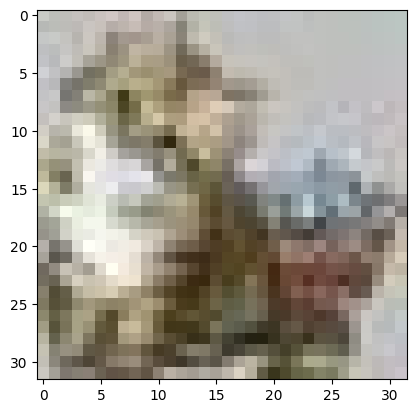

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [16]:
def get_layer_names(start, end, m):
  layer_names=[]
  for layer in m.layers[start:end]:
    layer_names.append(layer.name+'('+layer.__class__.__name__+')')
  return layer_names

In [17]:
#Function for plotting feature maps
def plot_feature_map(layer_names, activations):
  images_per_row = 16
  for layer_name, layer_activation in zip(layer_names, activations):
    if 'Conv2D' not in layer_name:
      continue

    n_features = layer_activation.shape[-1]
    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            # channel_image -= channel_image.mean()
            # channel_image /= channel_image.std()
            # channel_image *= 64
            # channel_image += 128
            # channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

  plt.show()

# Convnet output of block 1

In [ ]:
# Extracts the outputs of first block:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 148ms/step


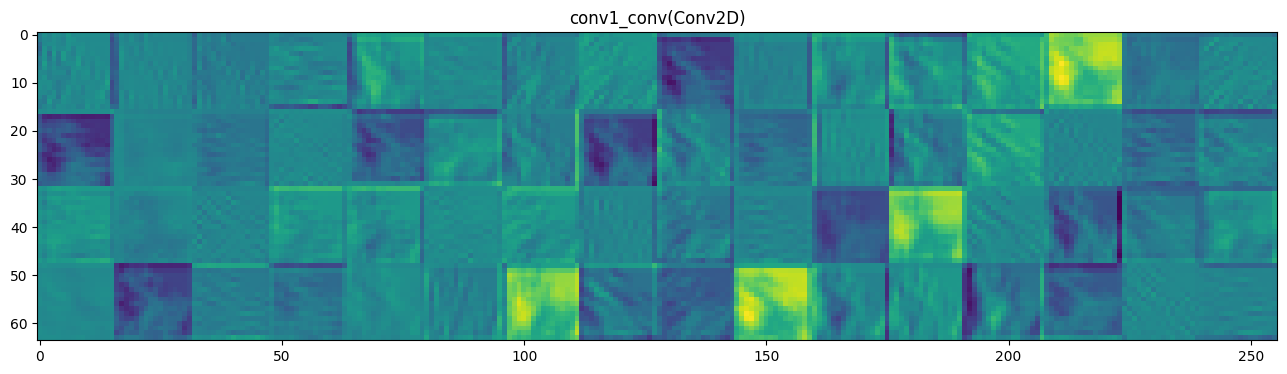

In [ ]:
#Plot feature map for the first block
layer_names = get_layer_names(0, 6, model)

# Now let's display our feature maps
plot_feature_map(layer_names, activations)

# Covnet output of block 3

In [ ]:
# Extracts the outputs of Block 3
layer_outputs = [layer.output for layer in model.layers[38:78]]

# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 1s 711ms/step


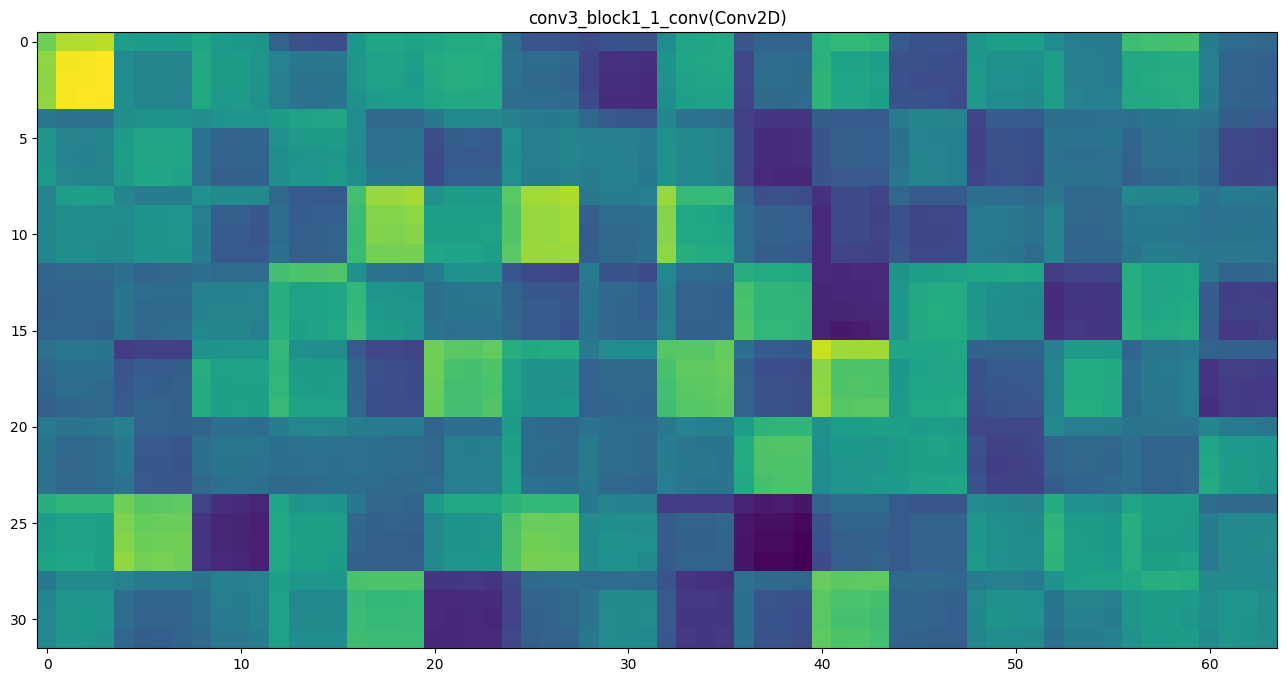

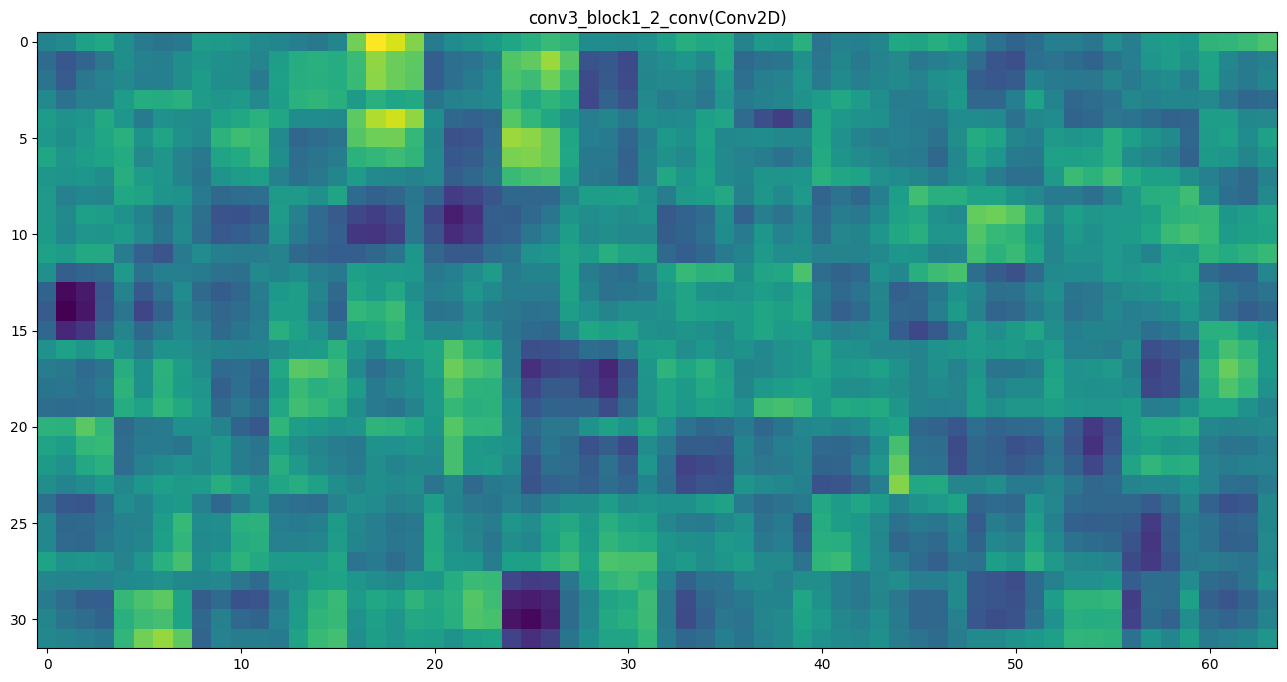

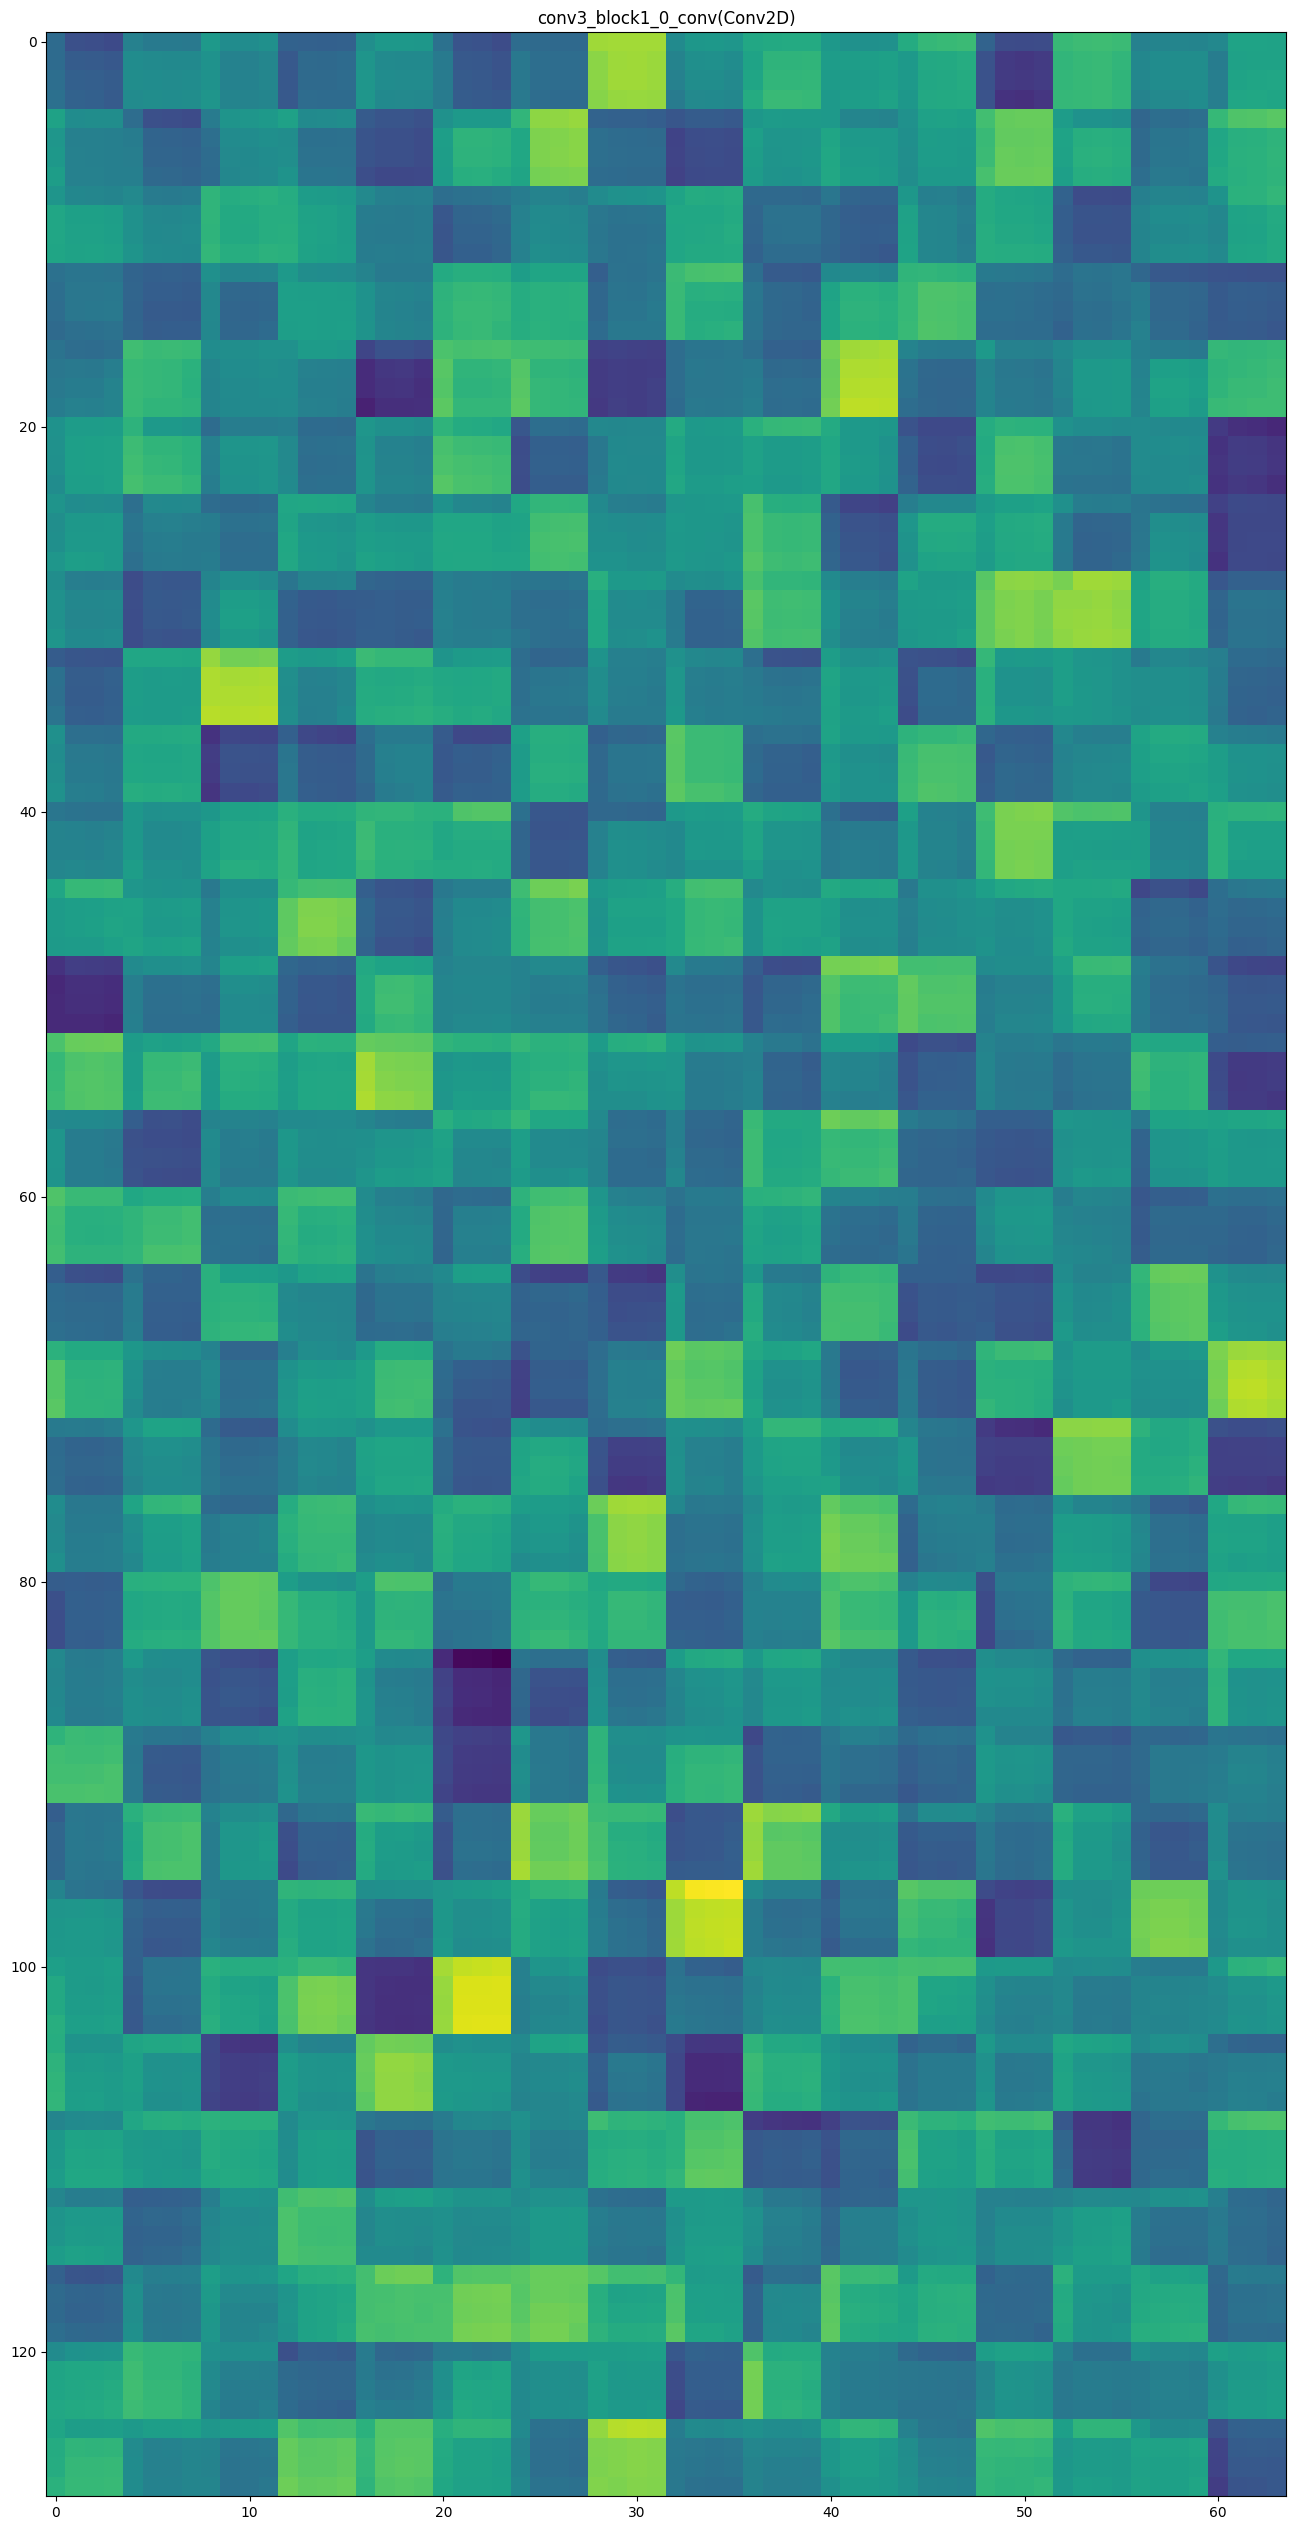

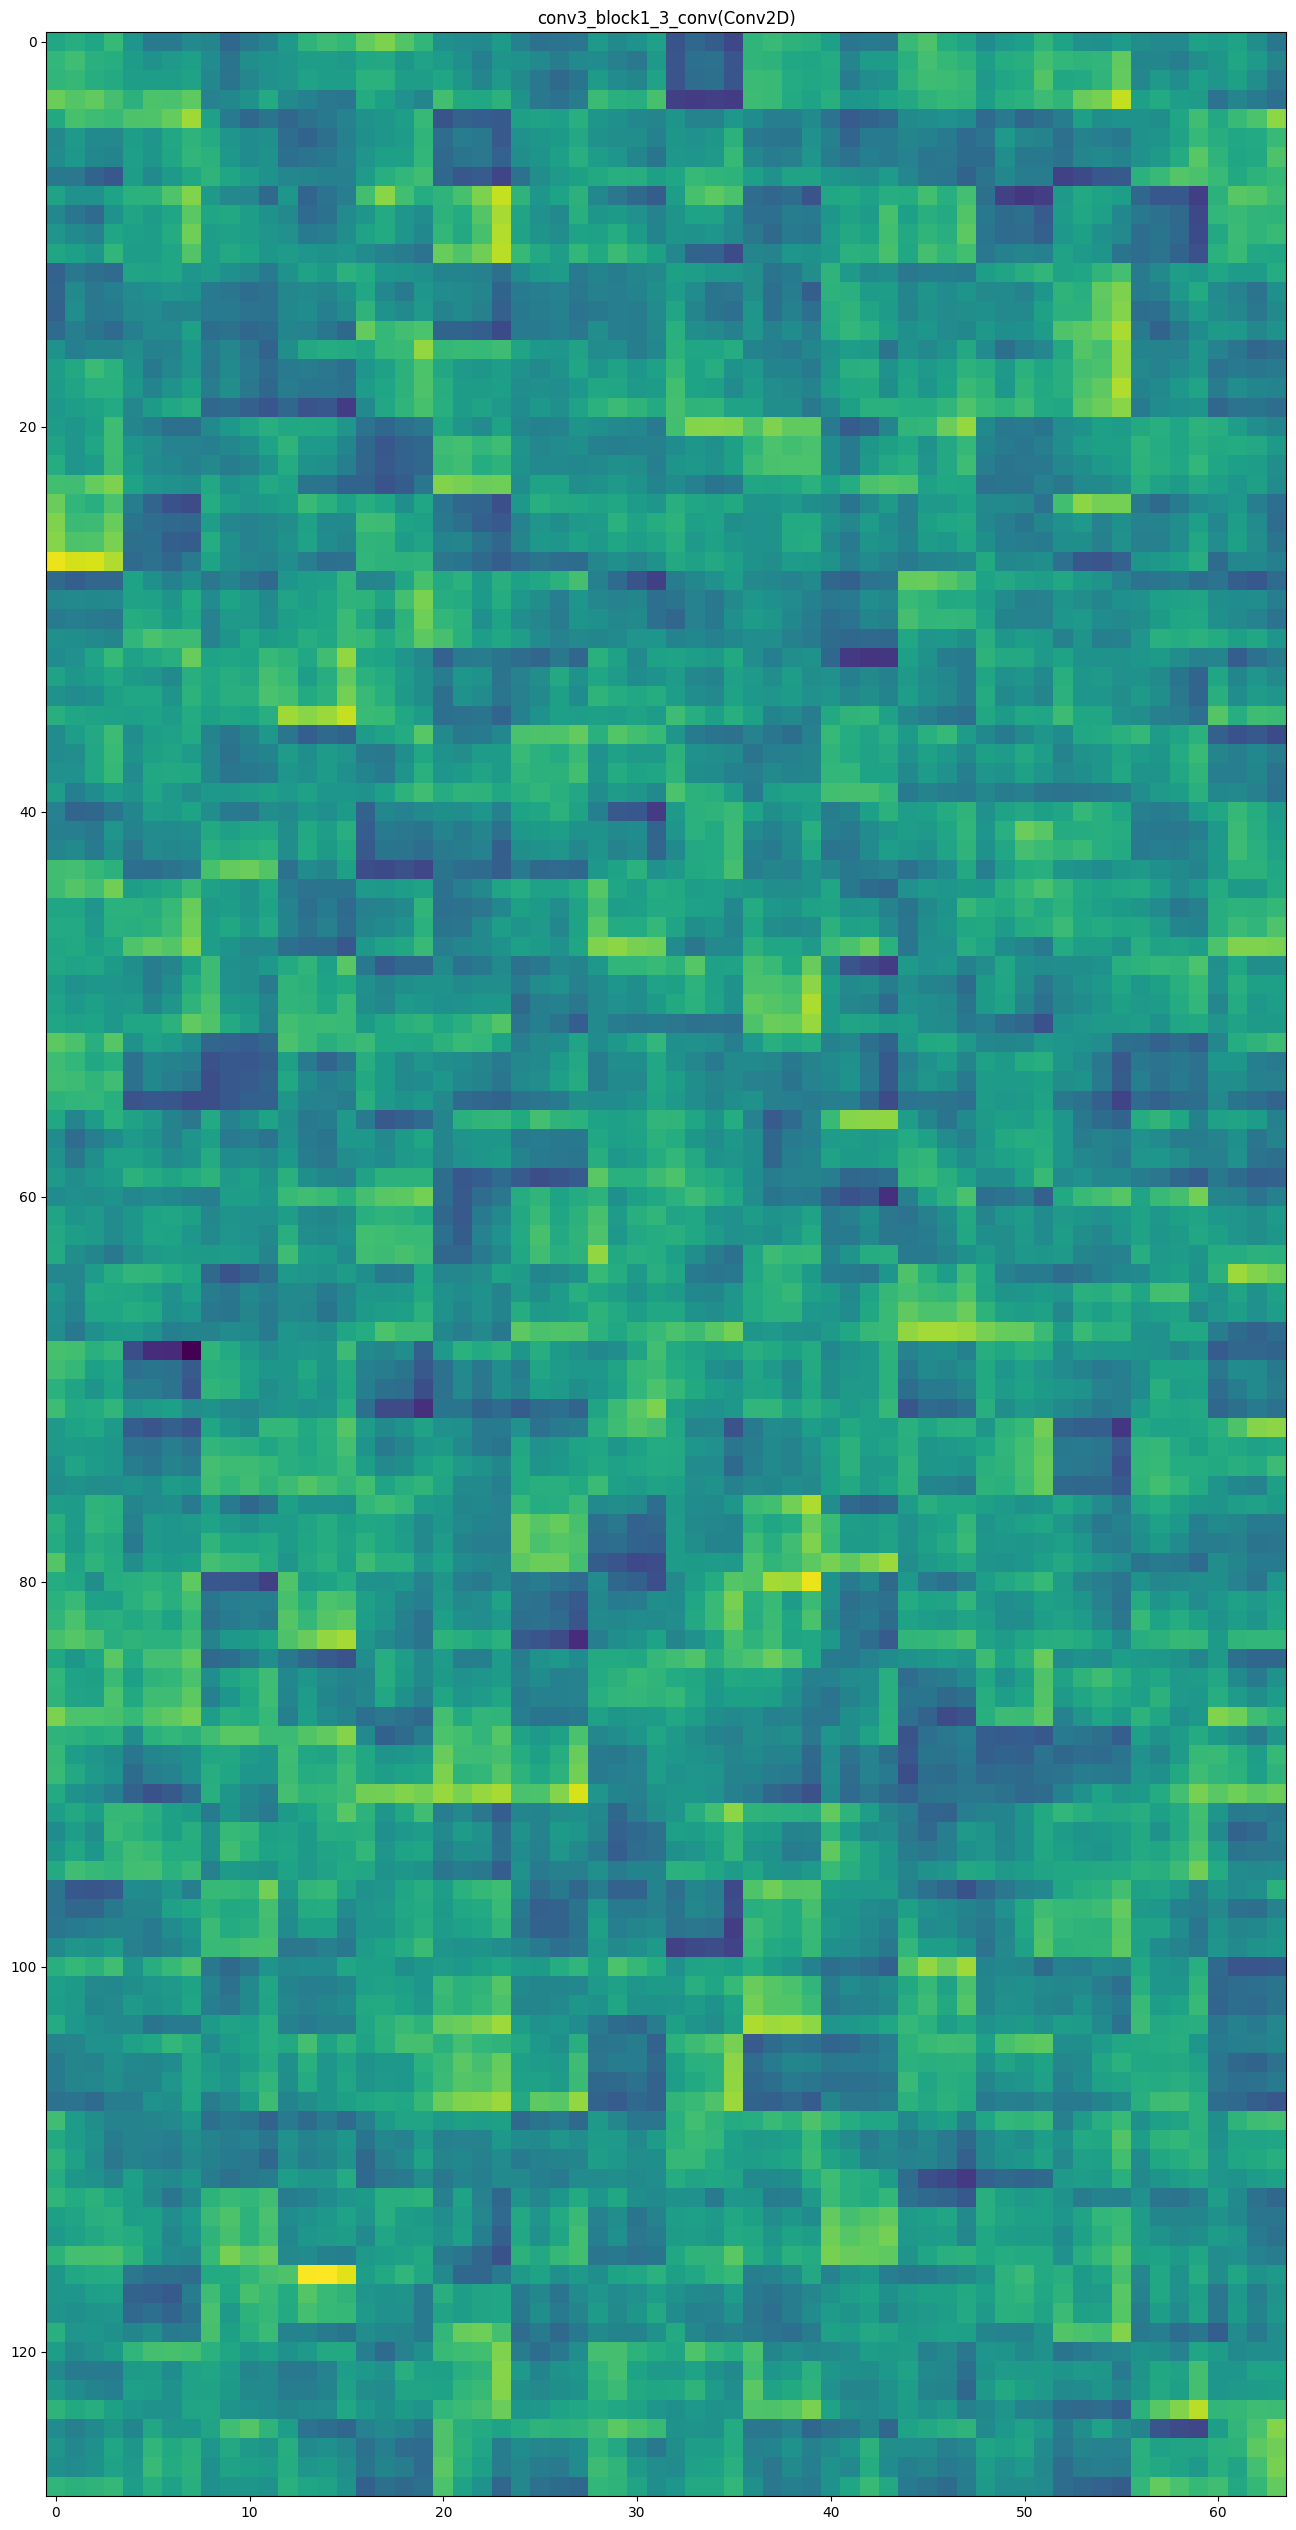

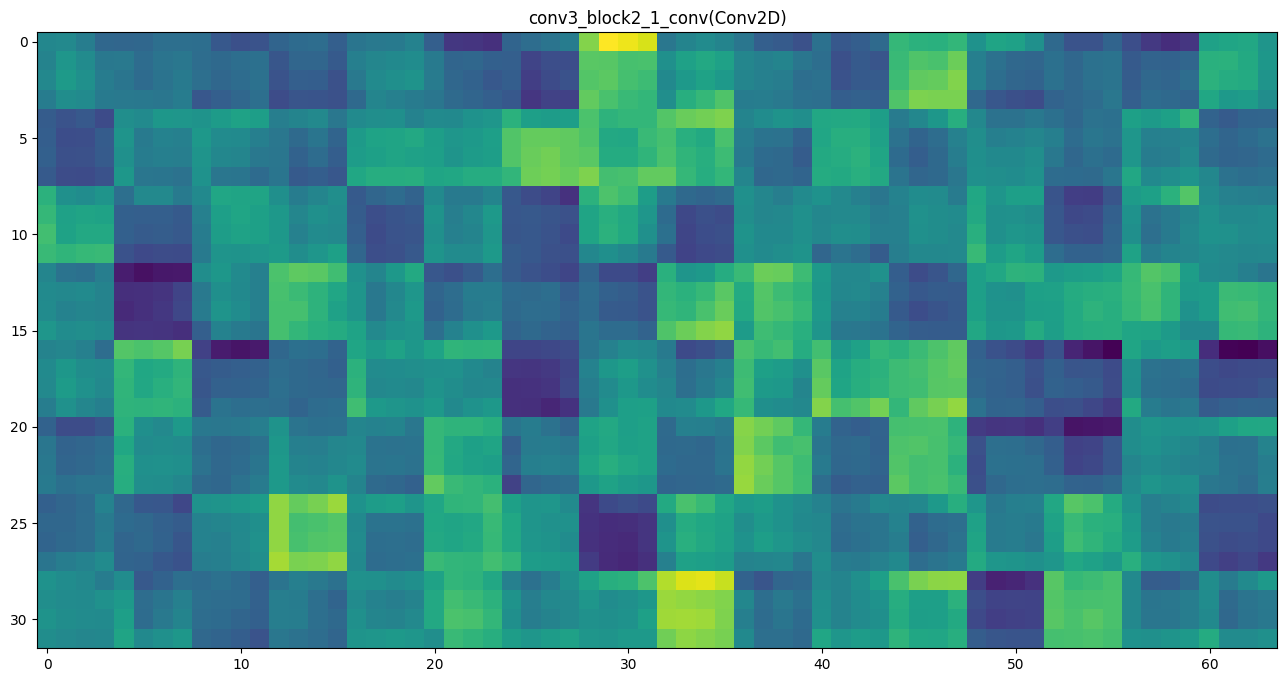

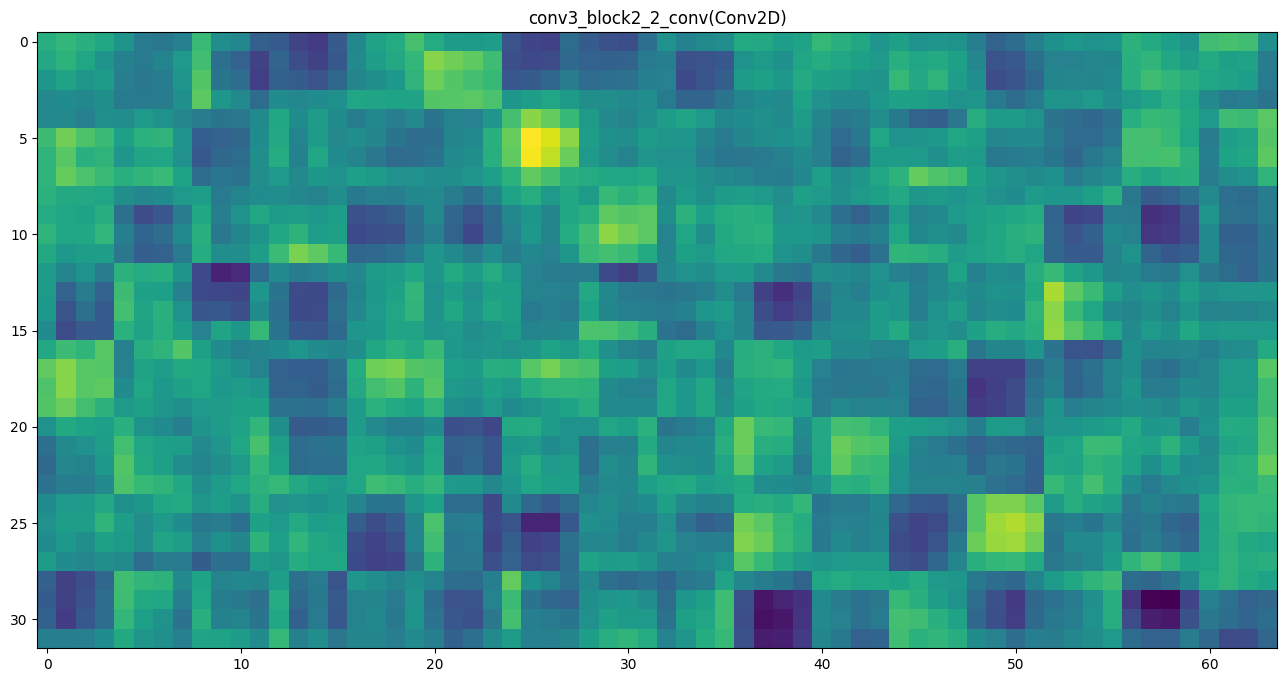

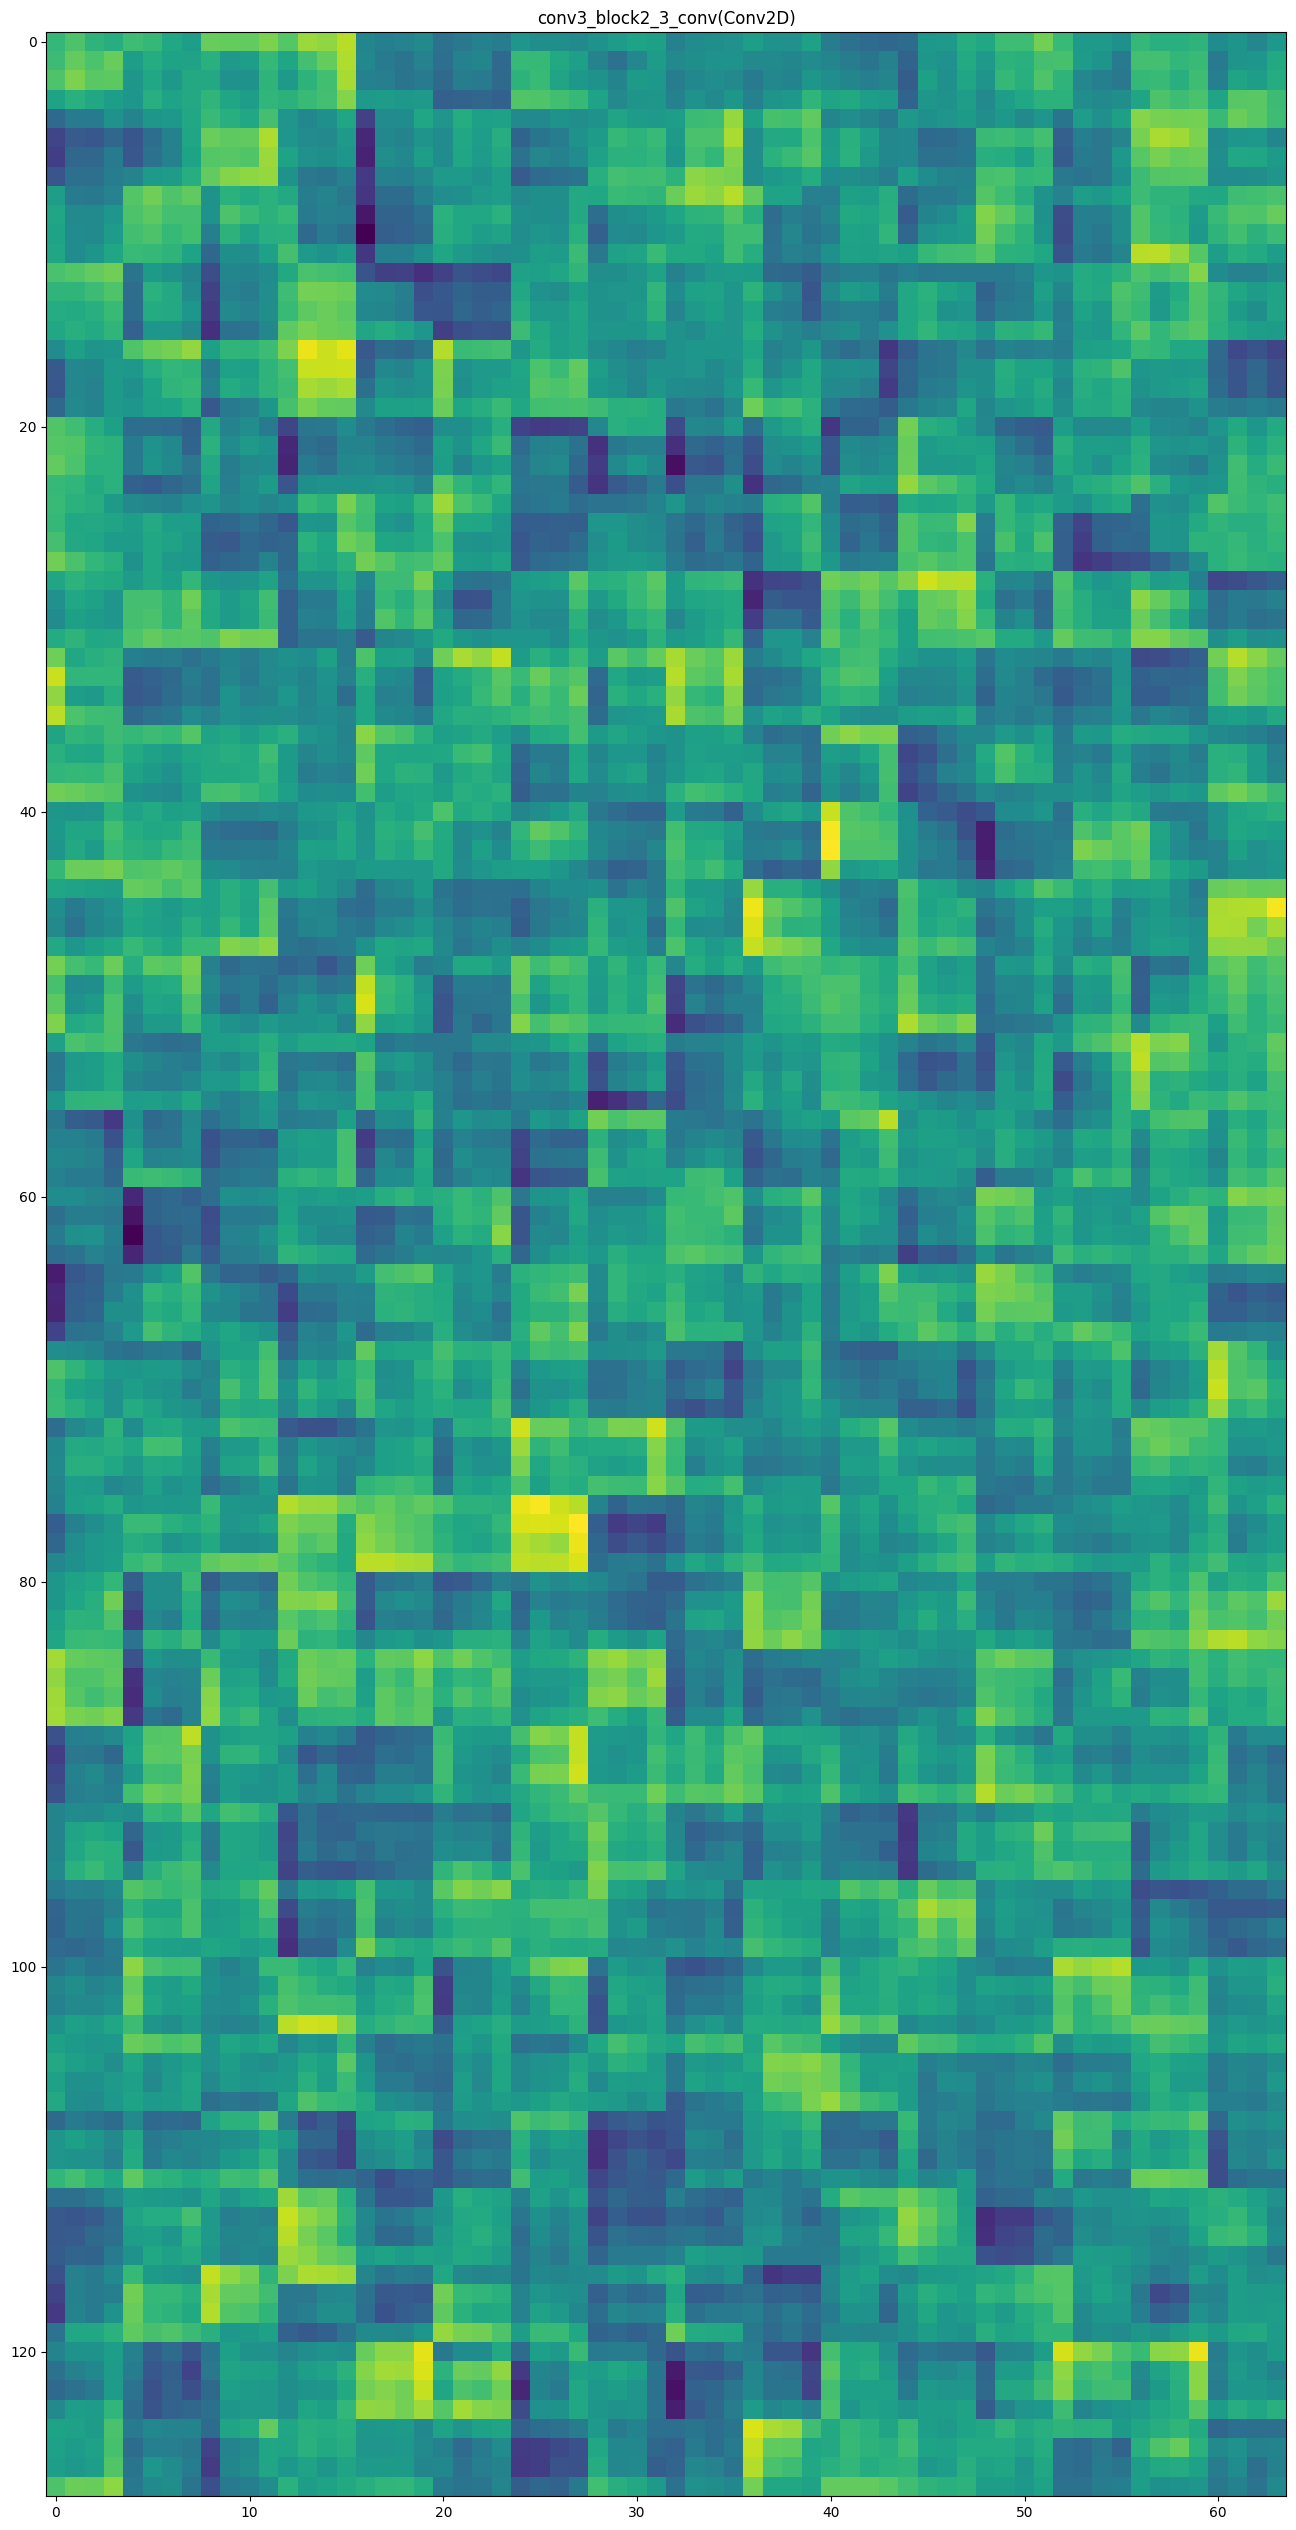

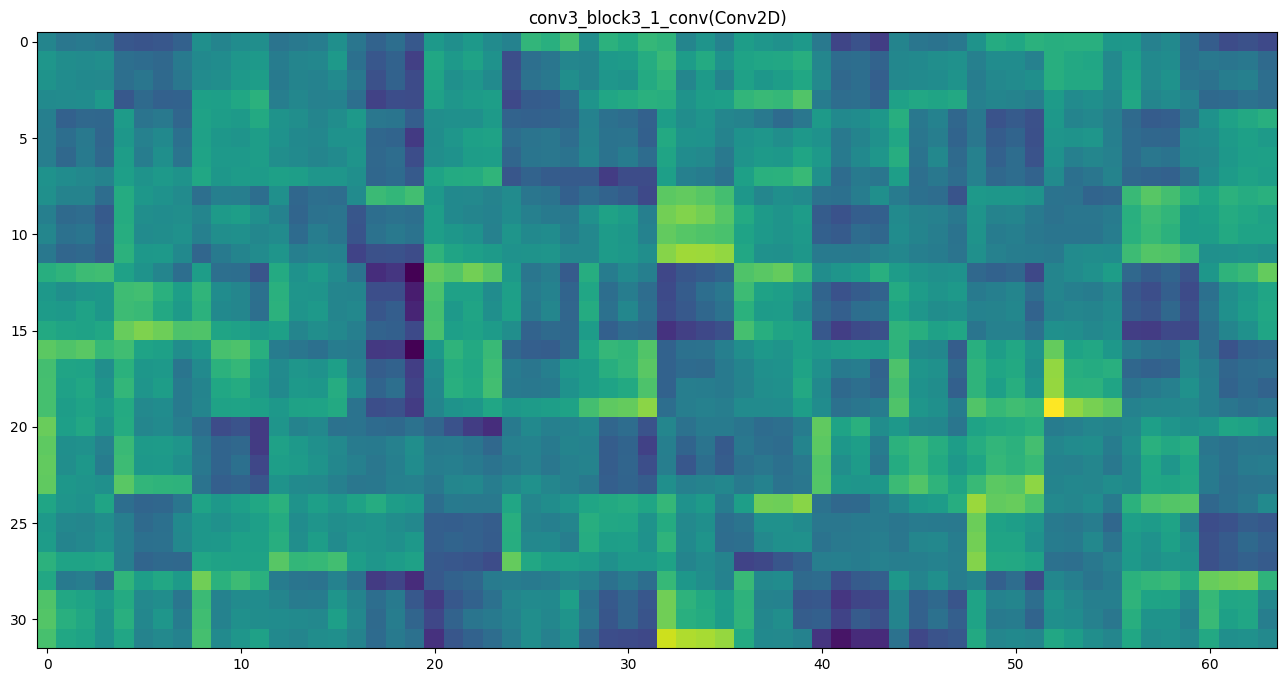

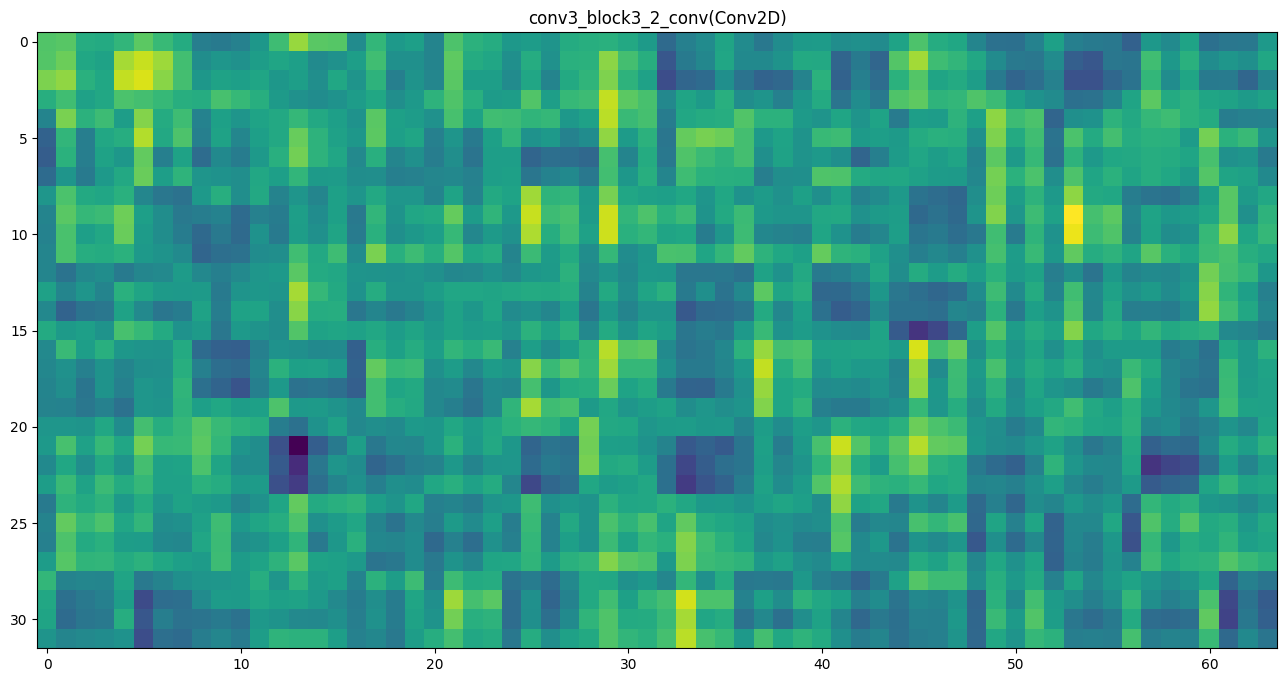

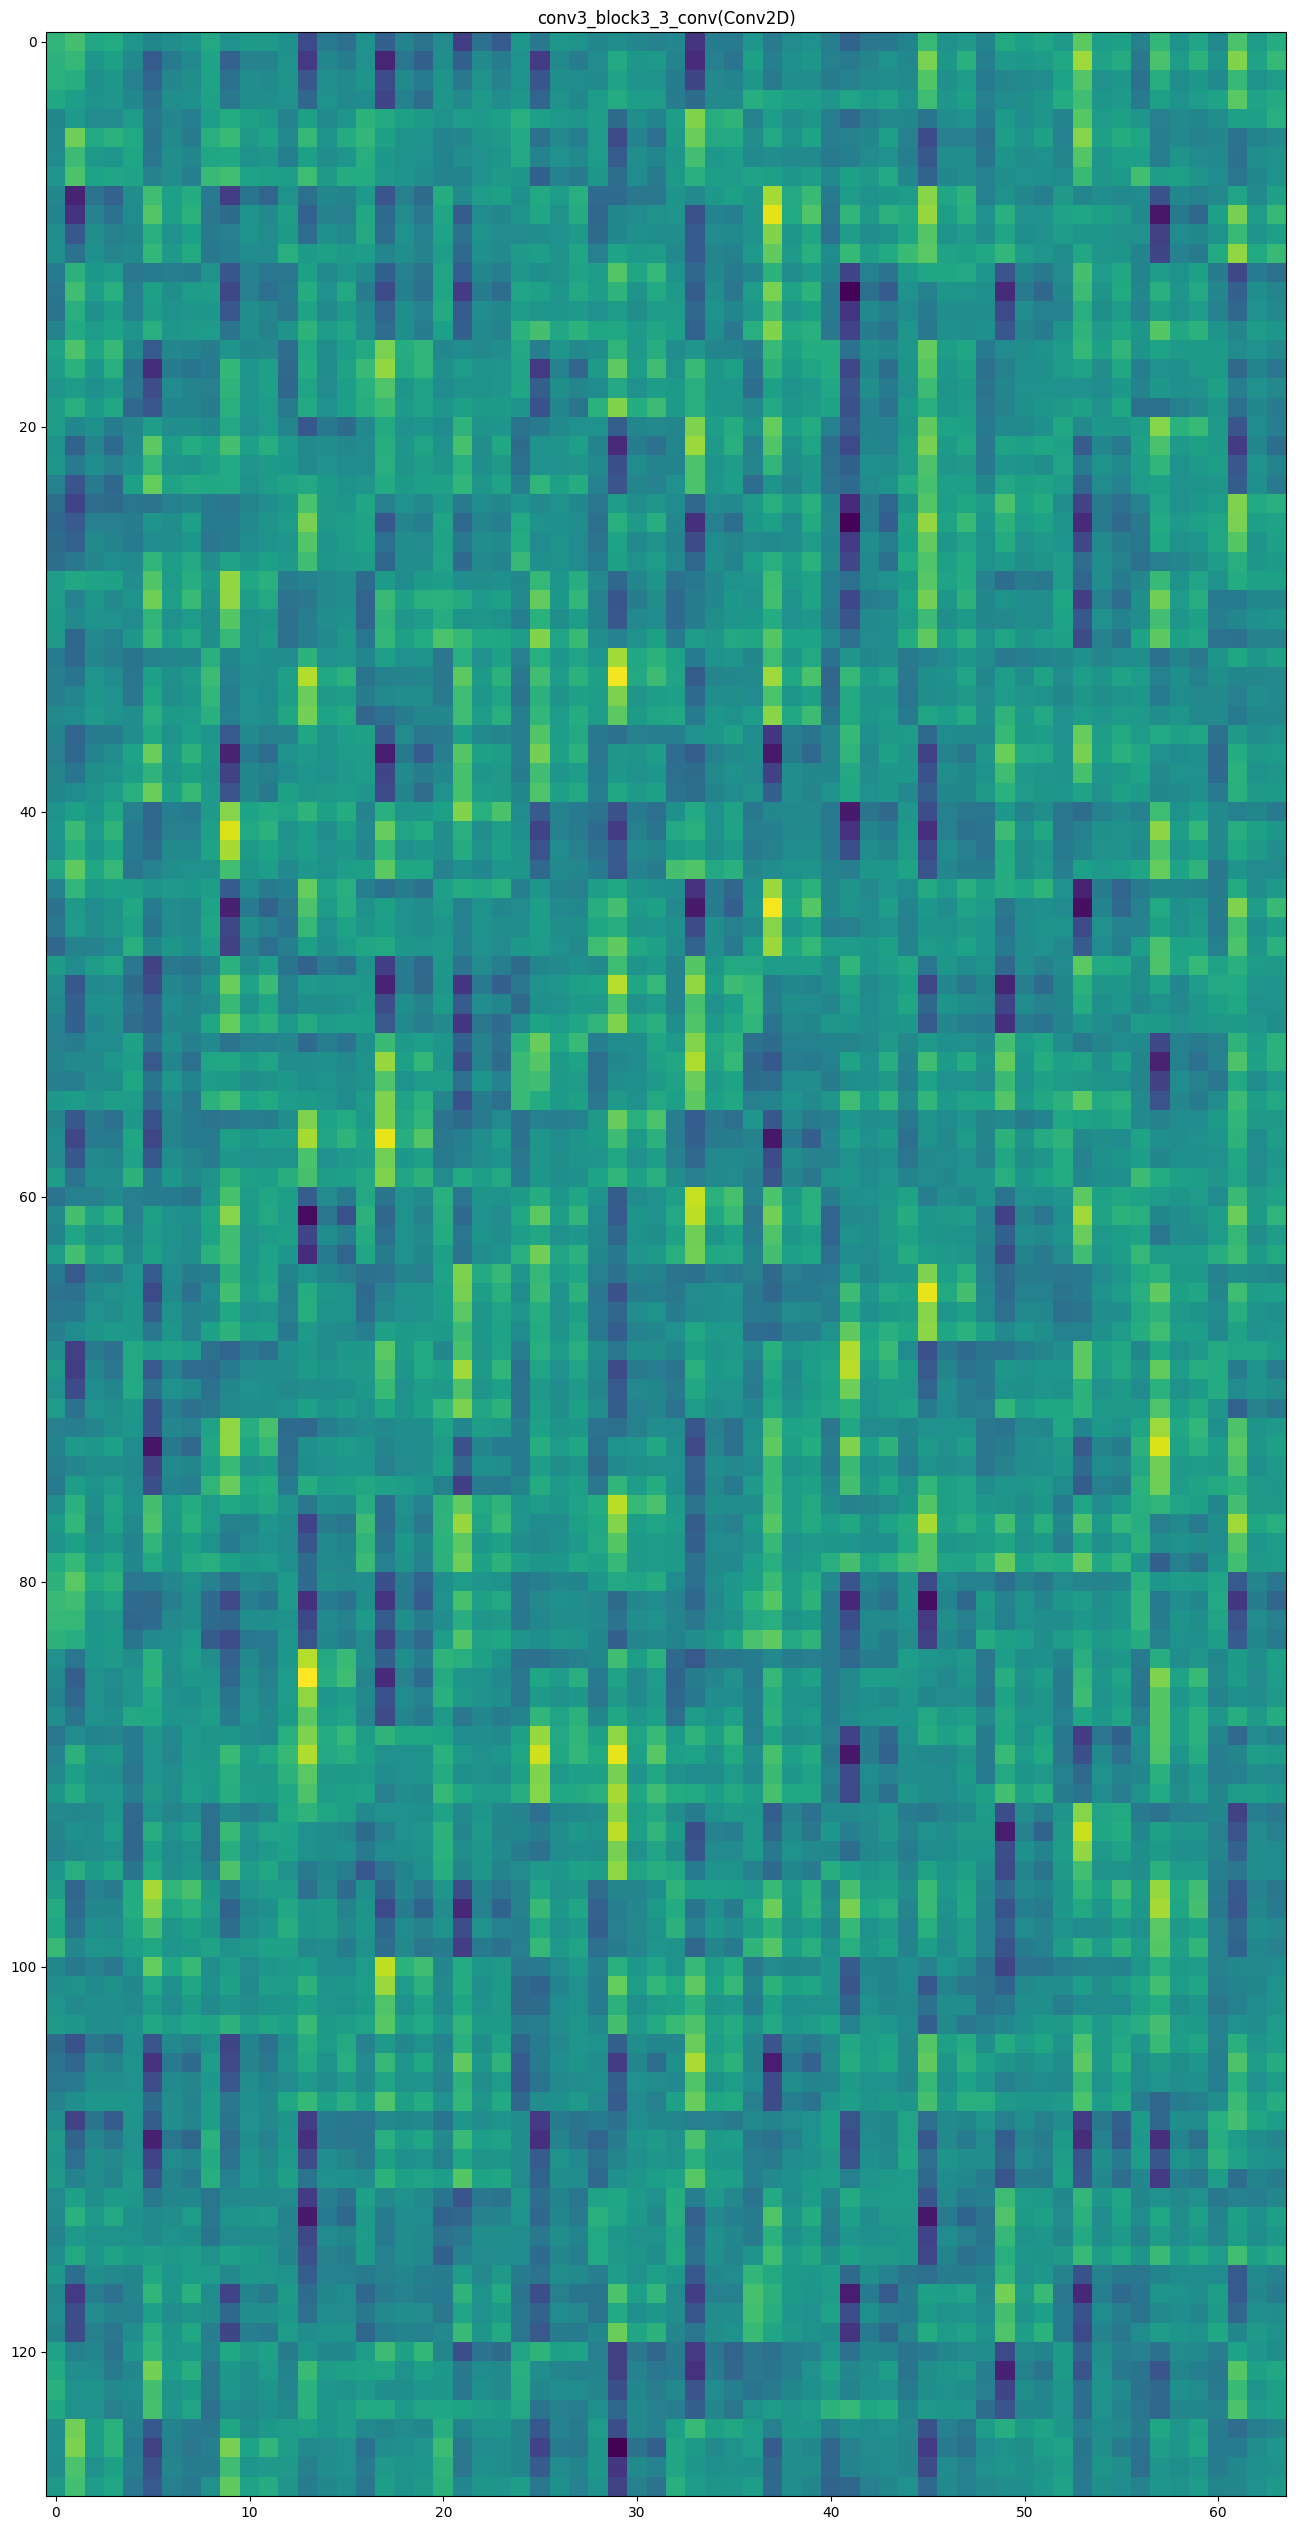

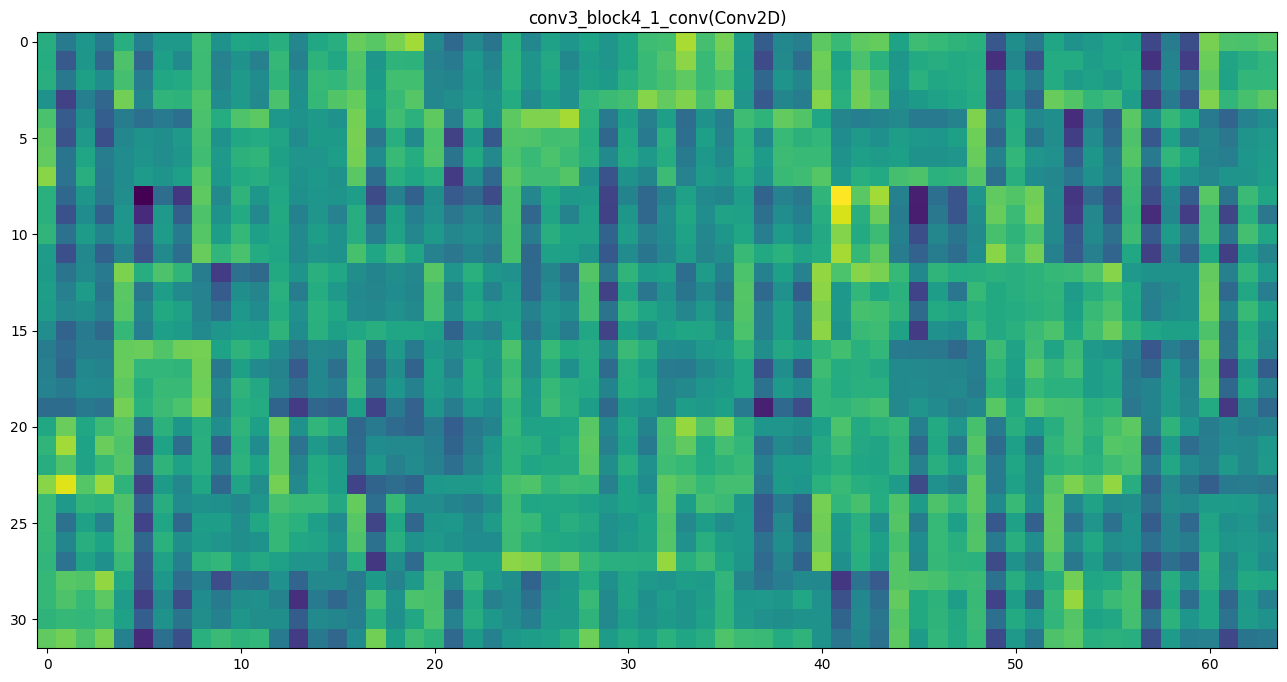

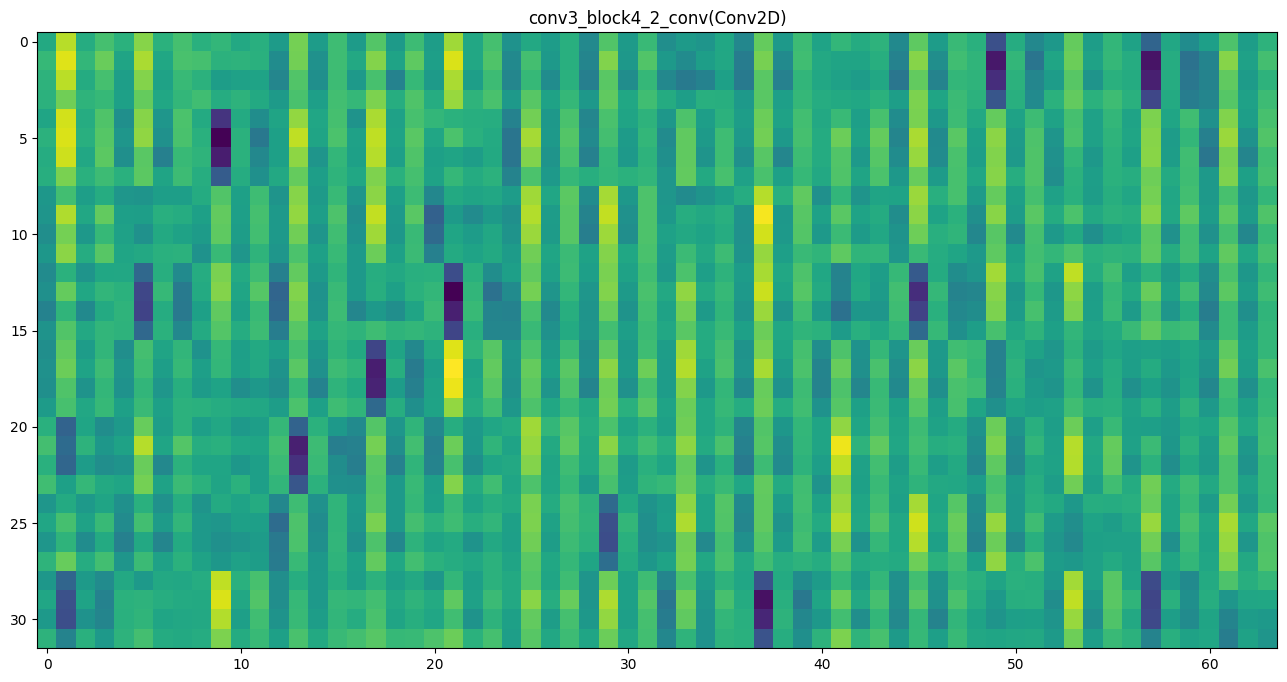

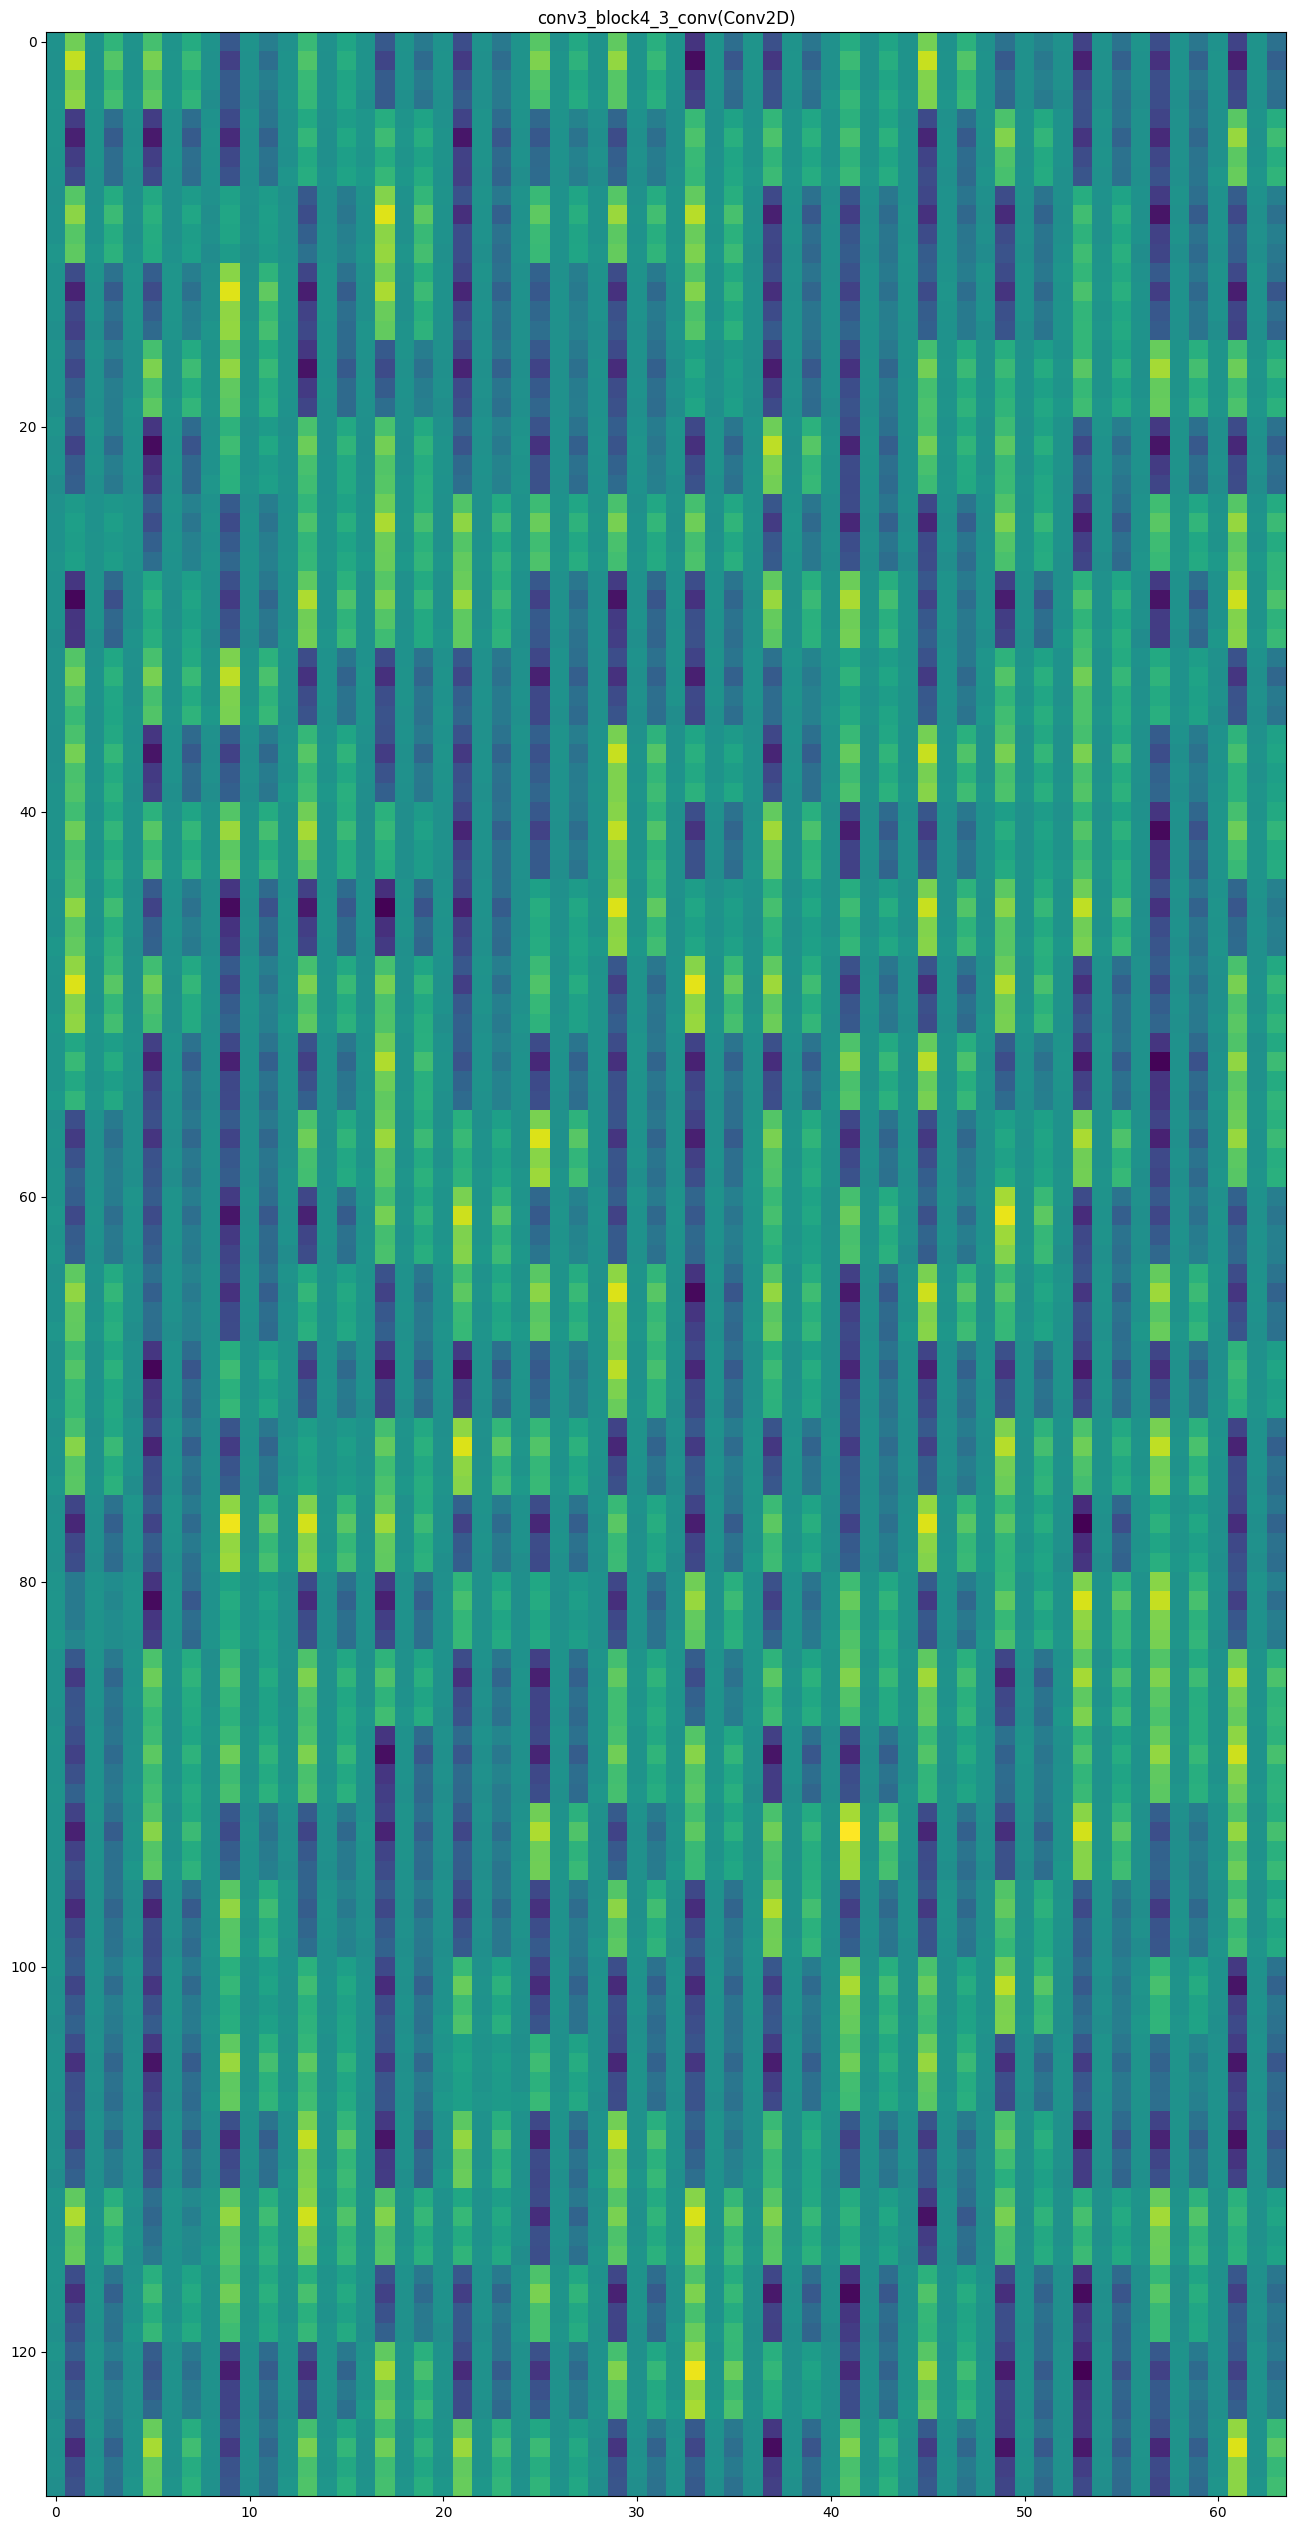

In [ ]:
#get the names of the layers
layer_names = get_layer_names(38, 78, model)

#plot feature maps
plot_feature_map(layer_names, activations)

# Covnet output of Block 5

In [ ]:
# Extracts the outputs of Block 5
layer_outputs = [layer.output for layer in model.layers[141:172]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 1s 1s/step


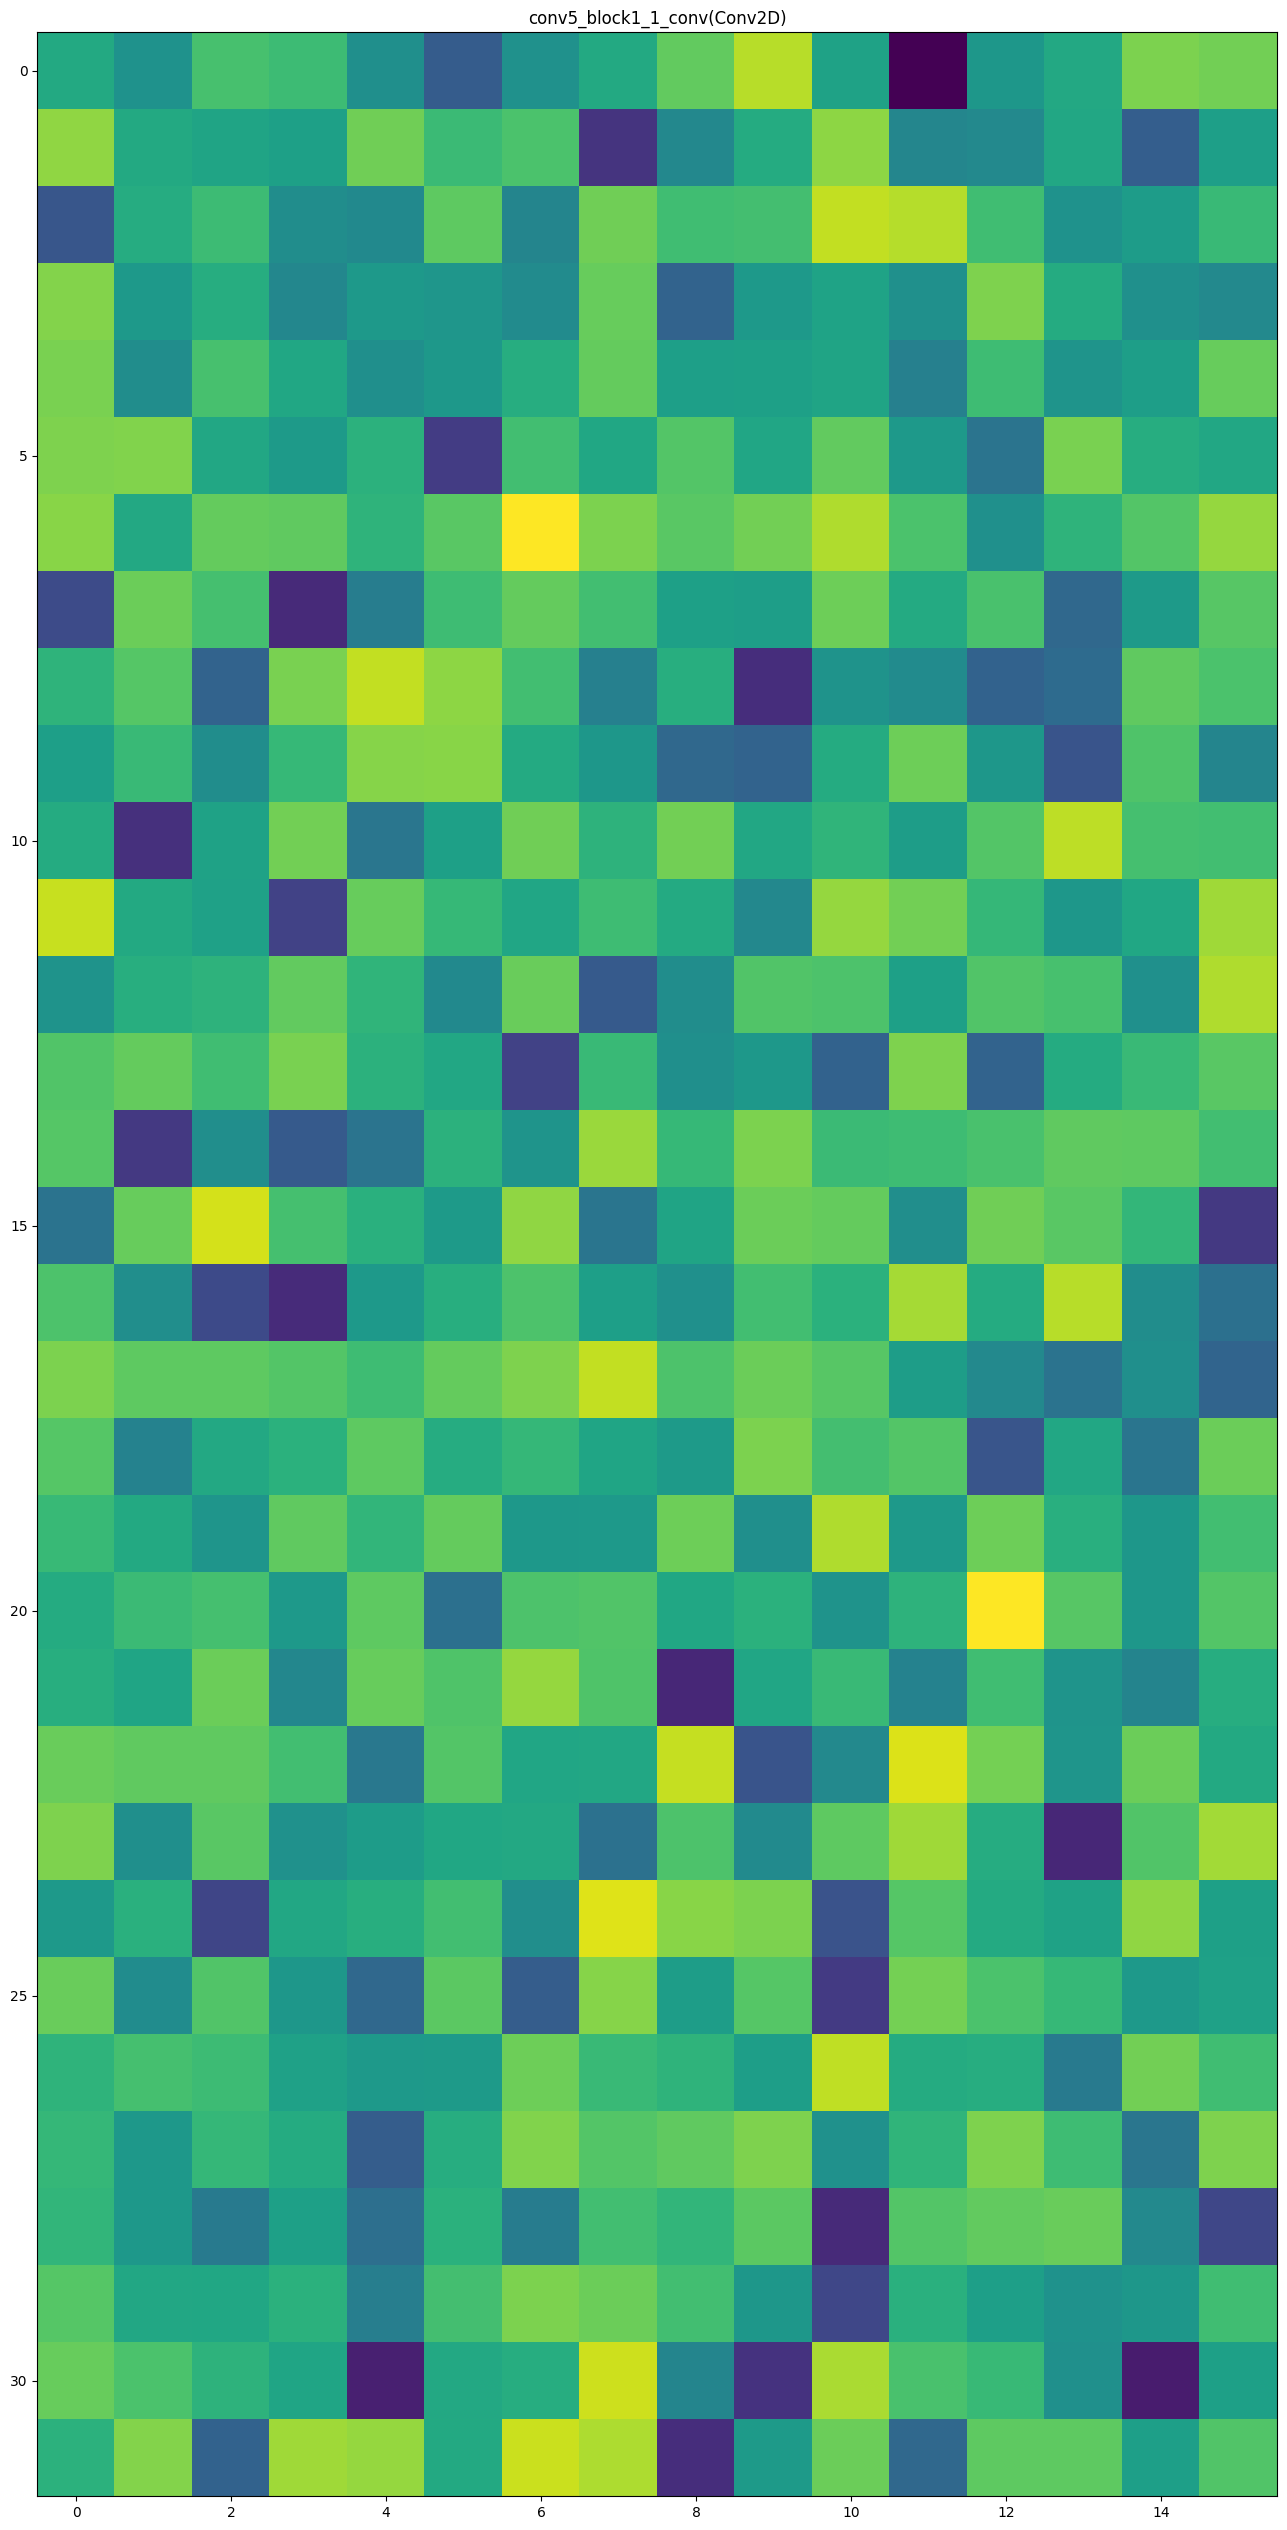

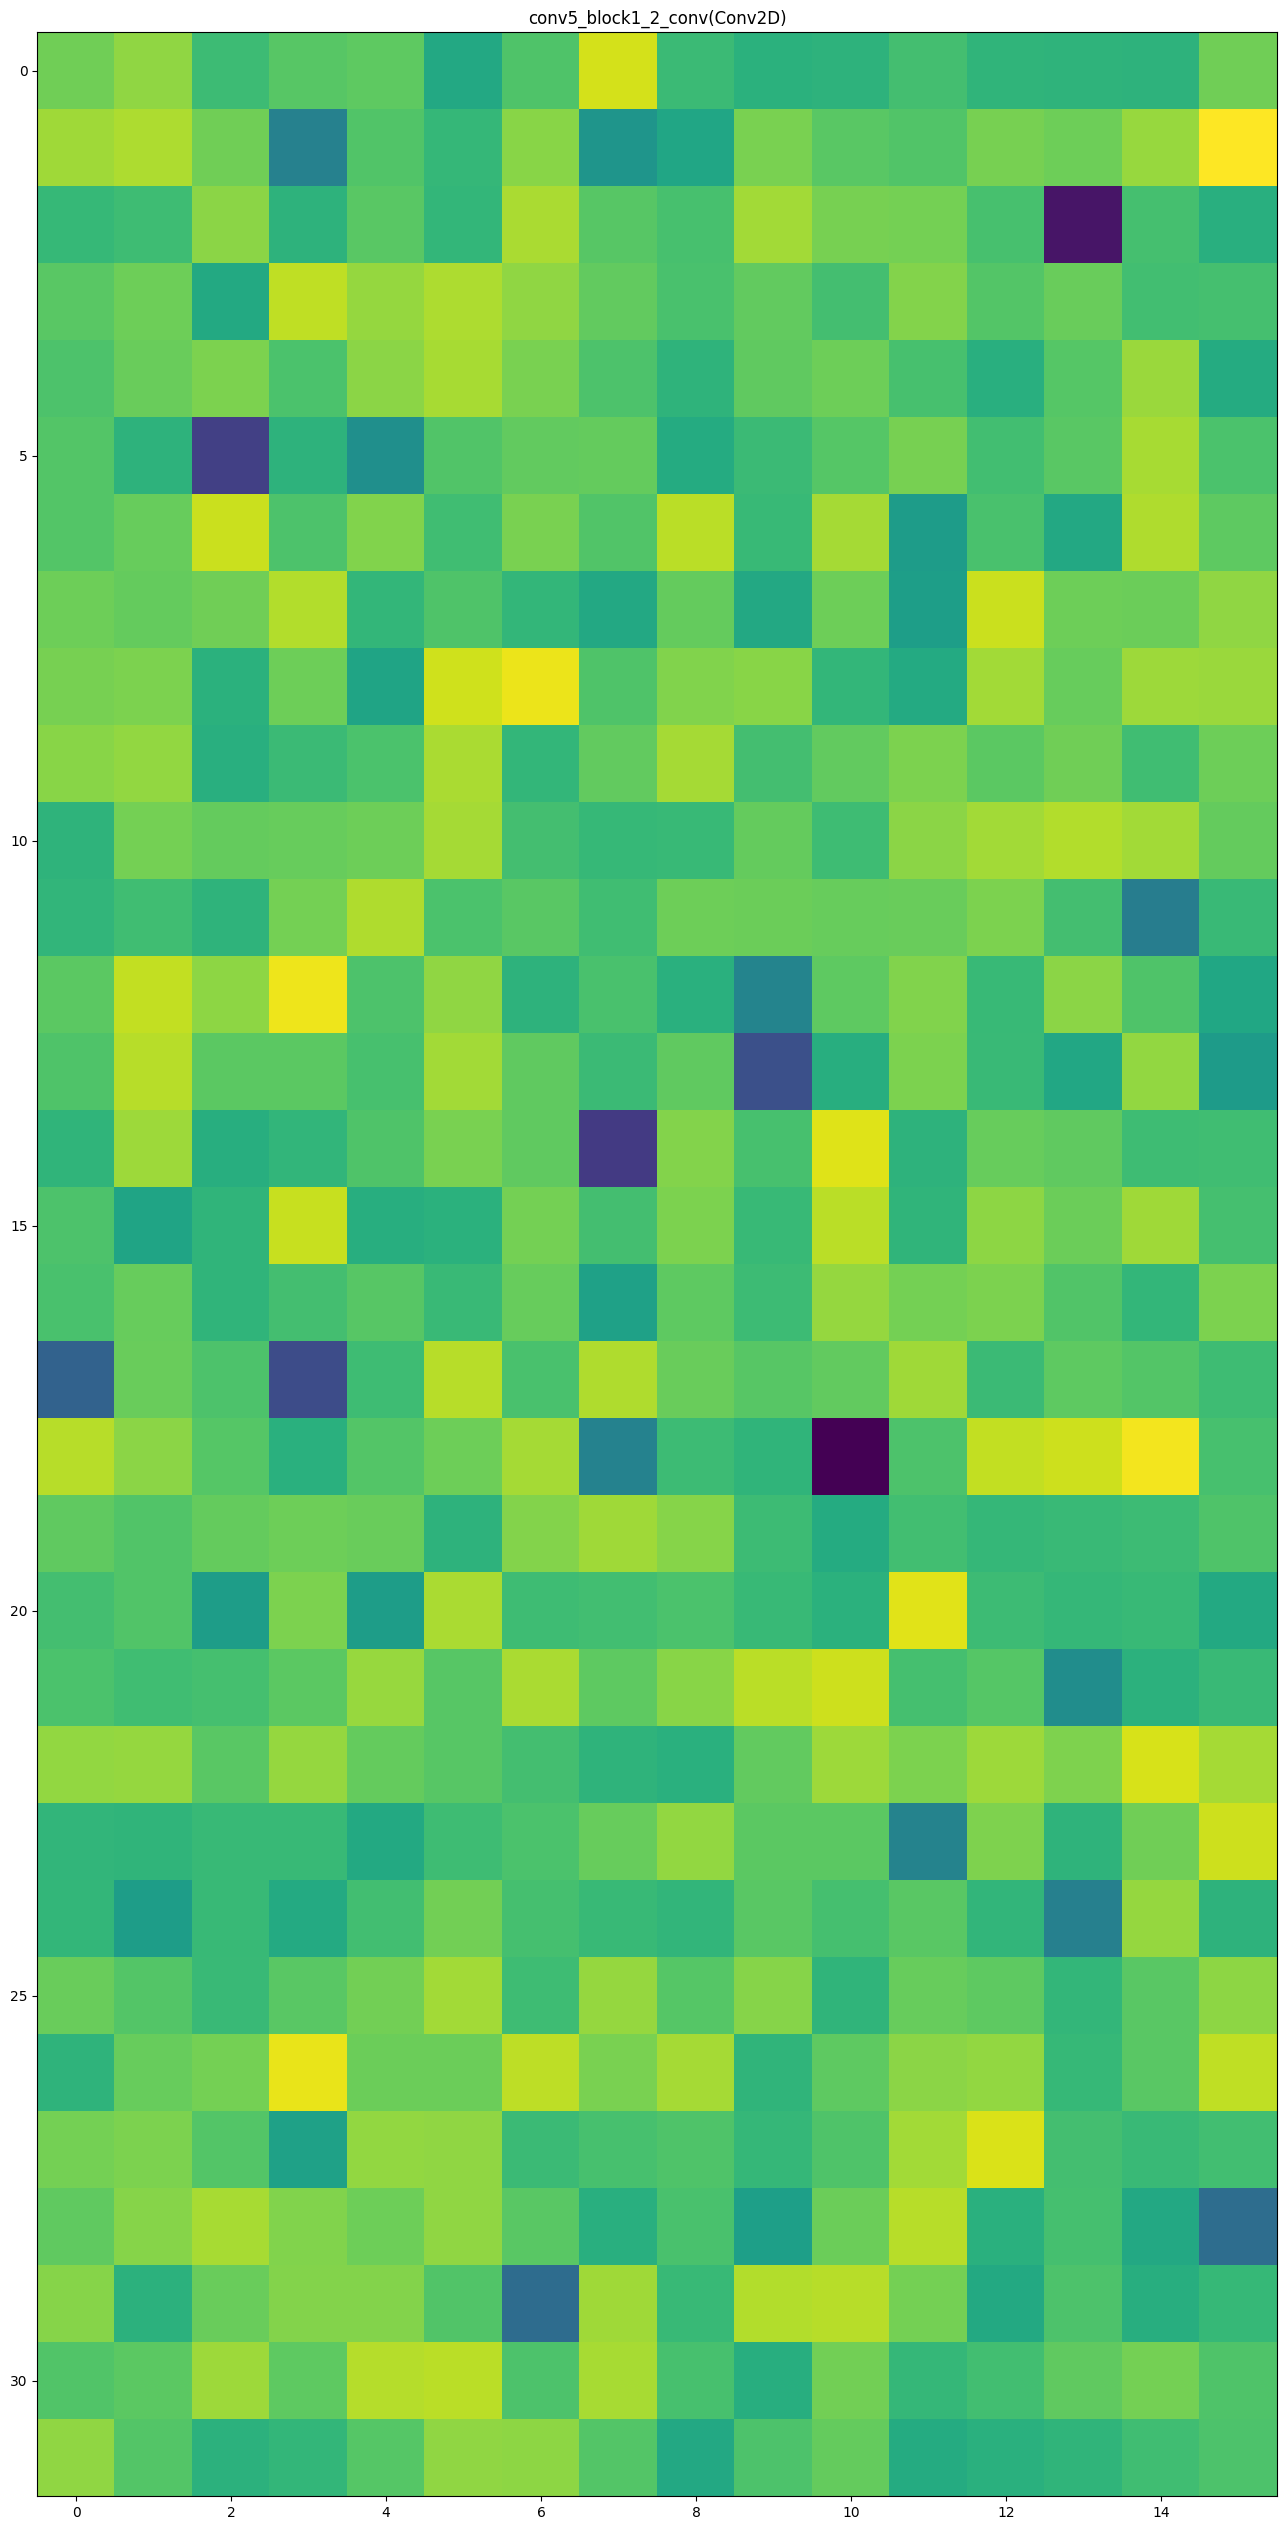

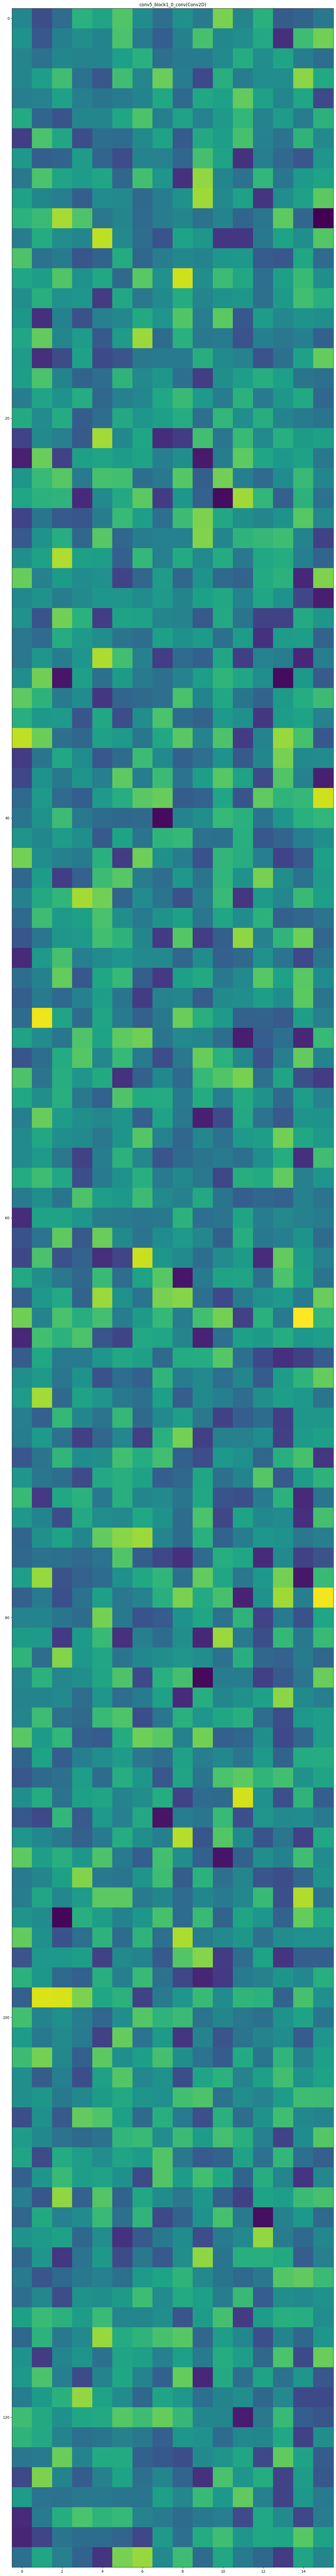

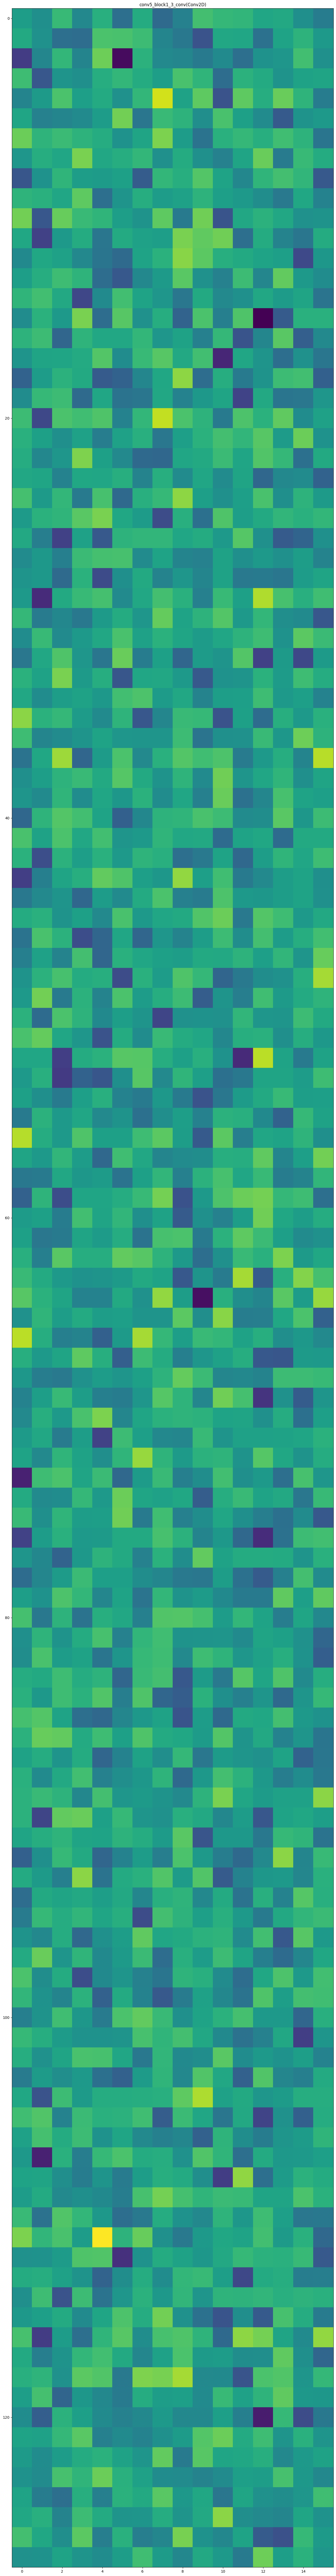

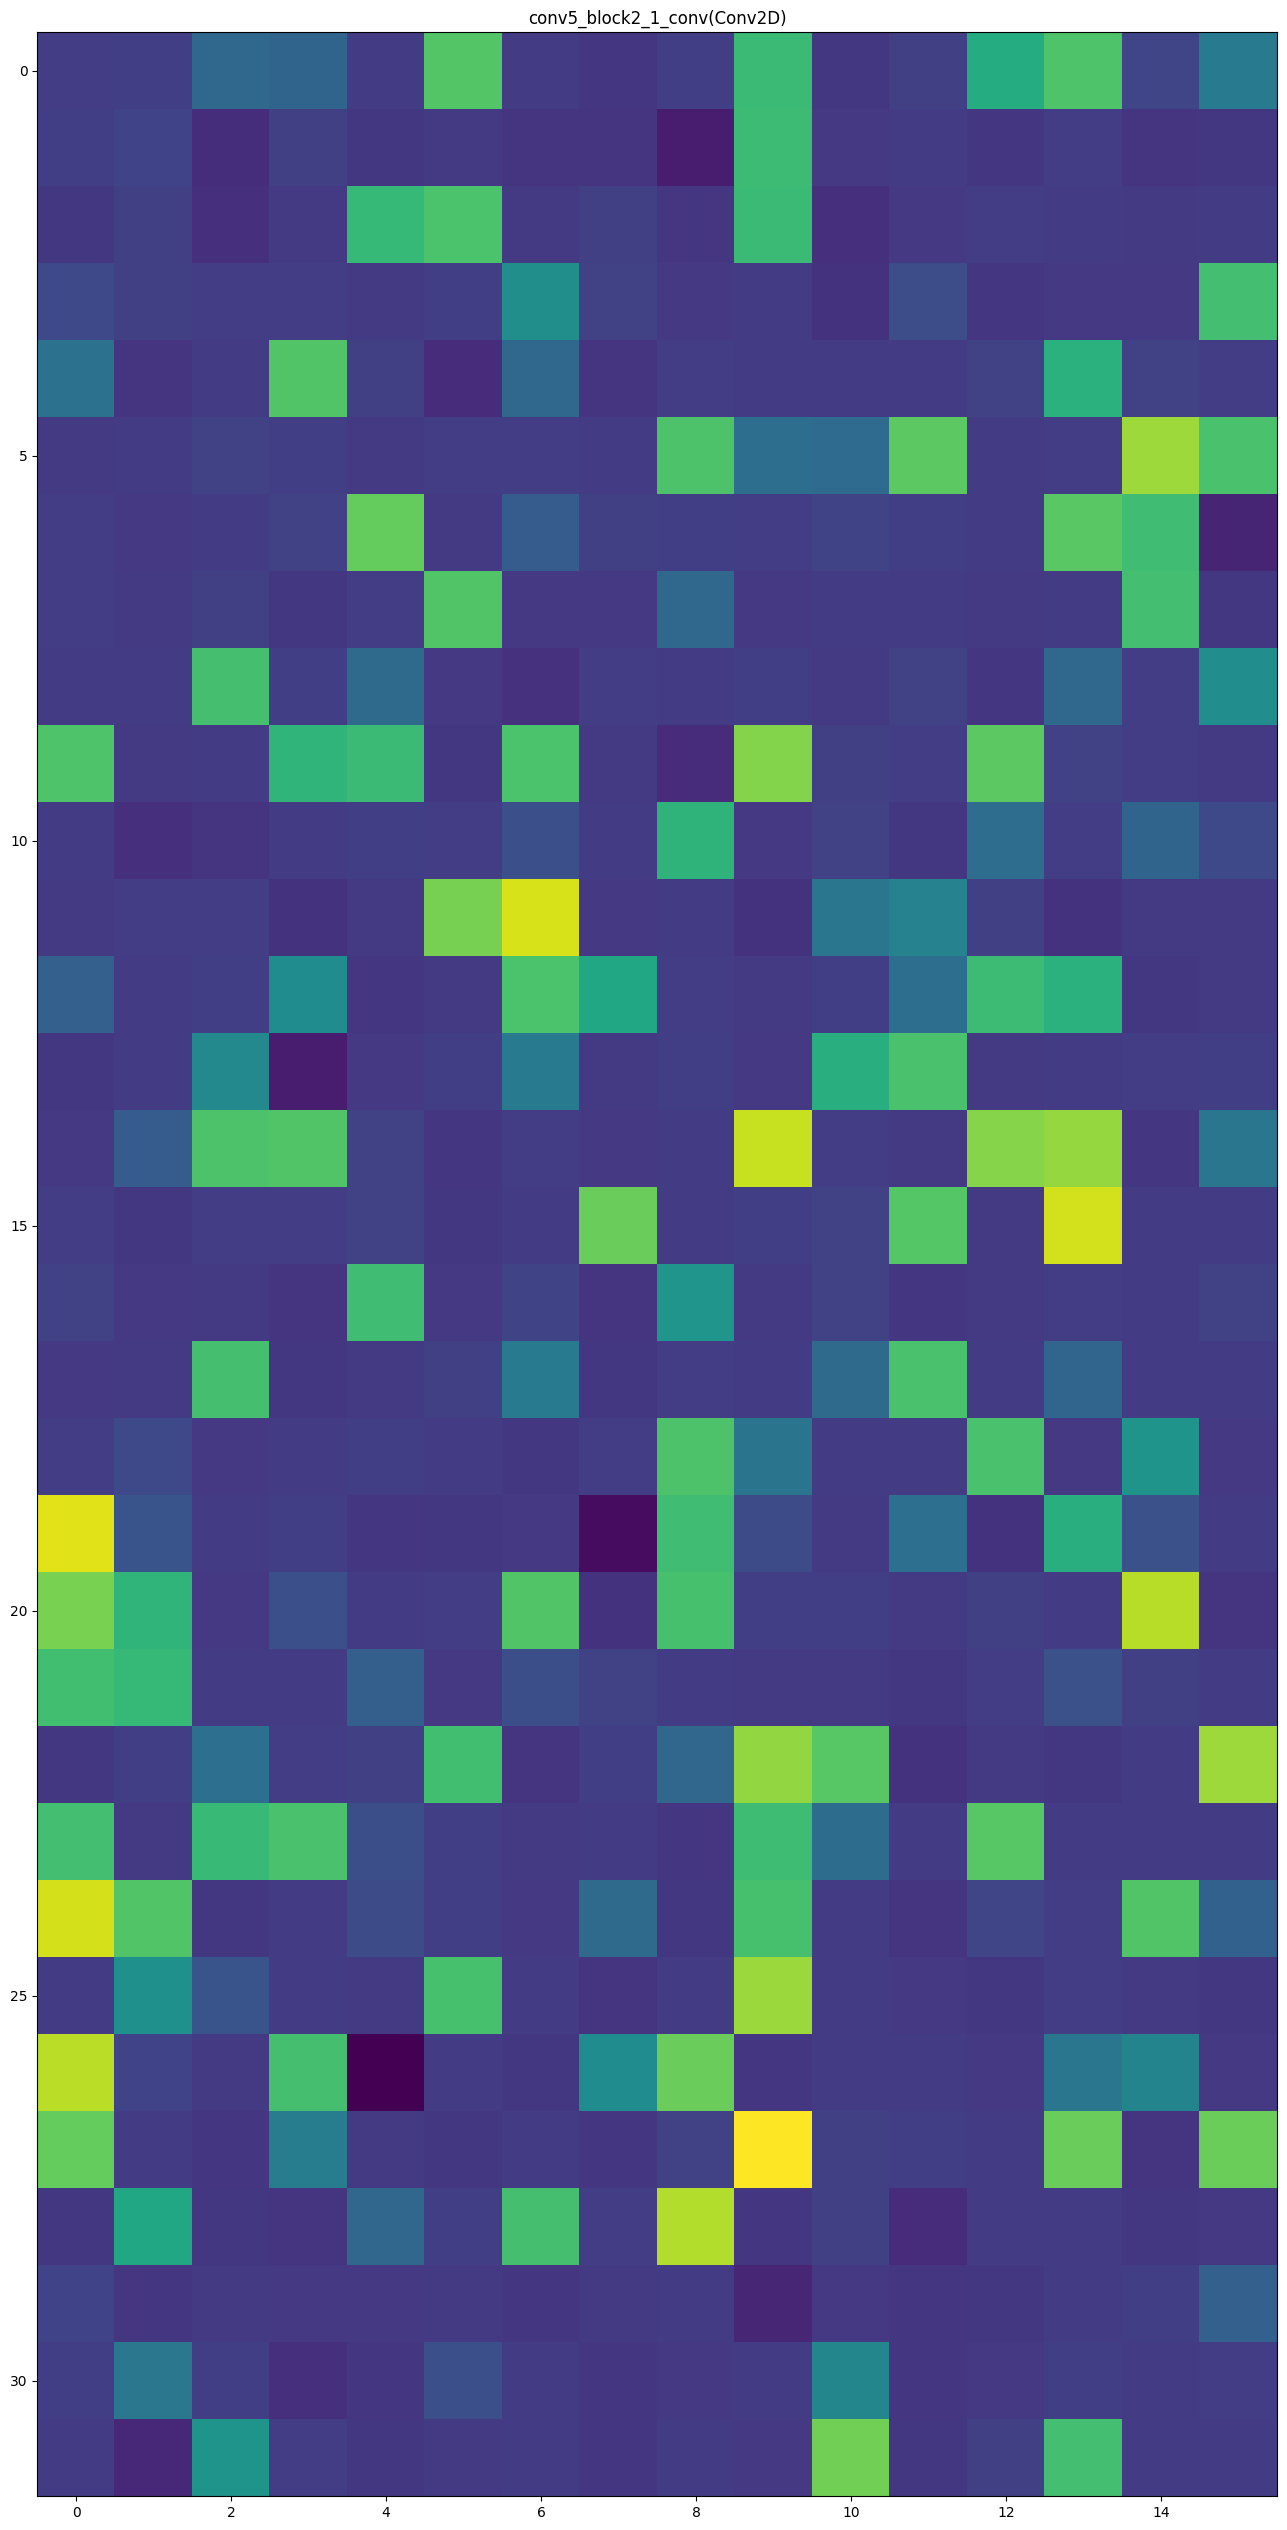

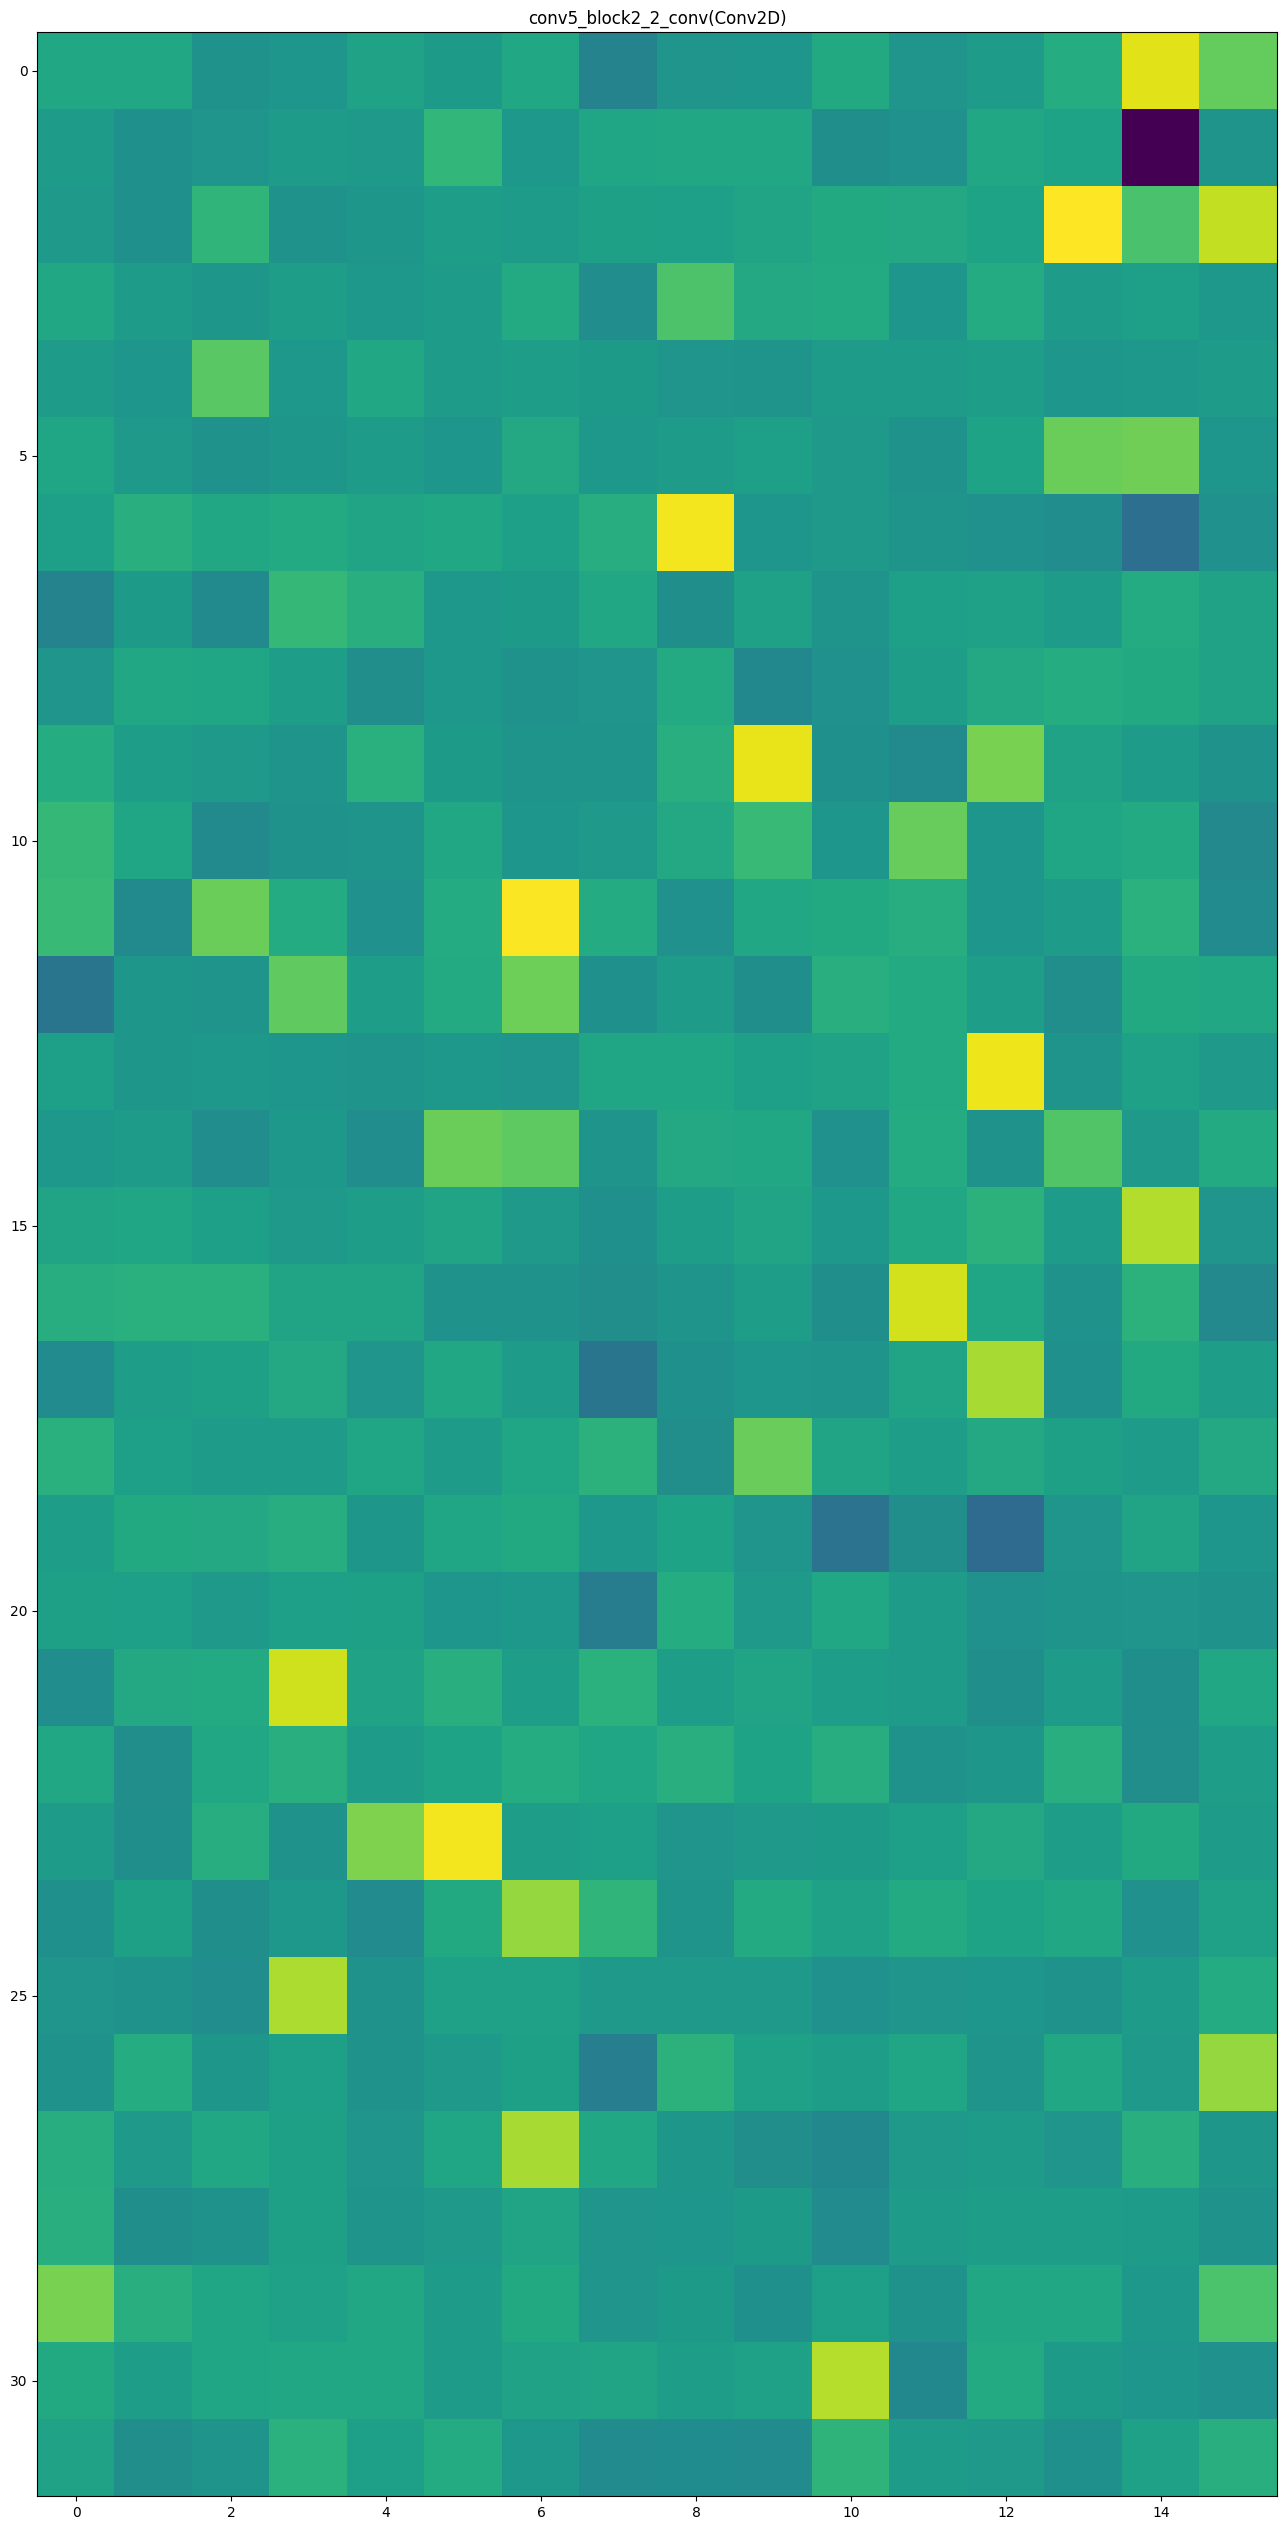

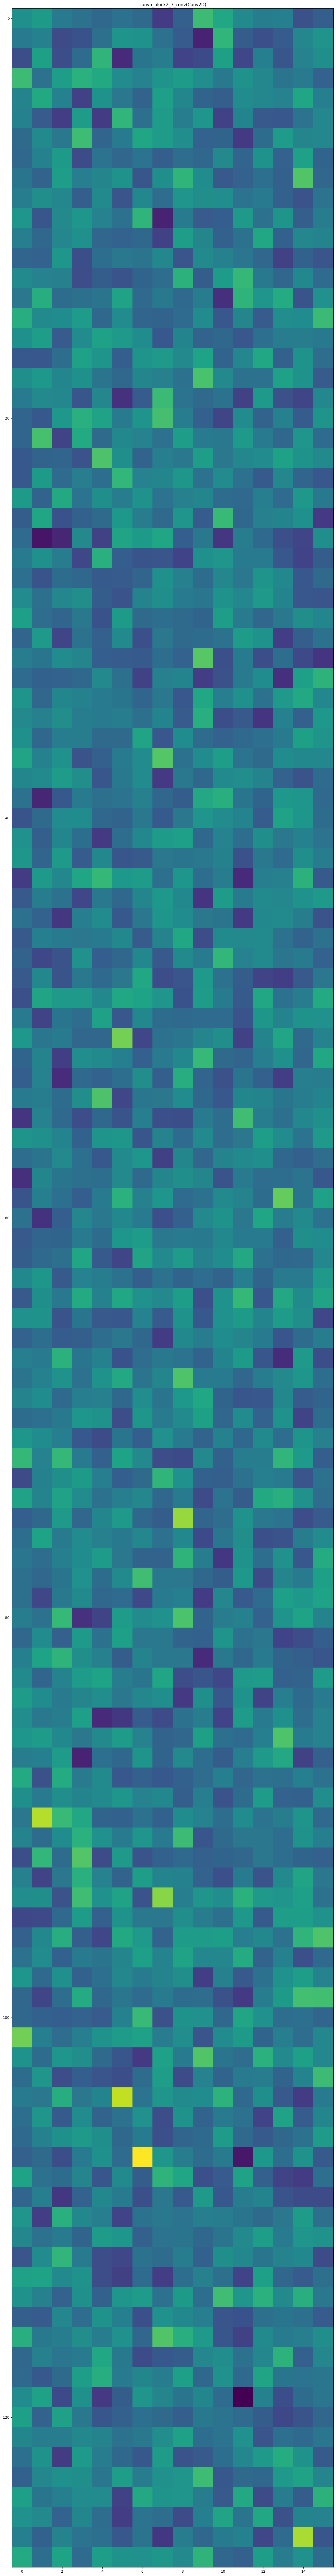

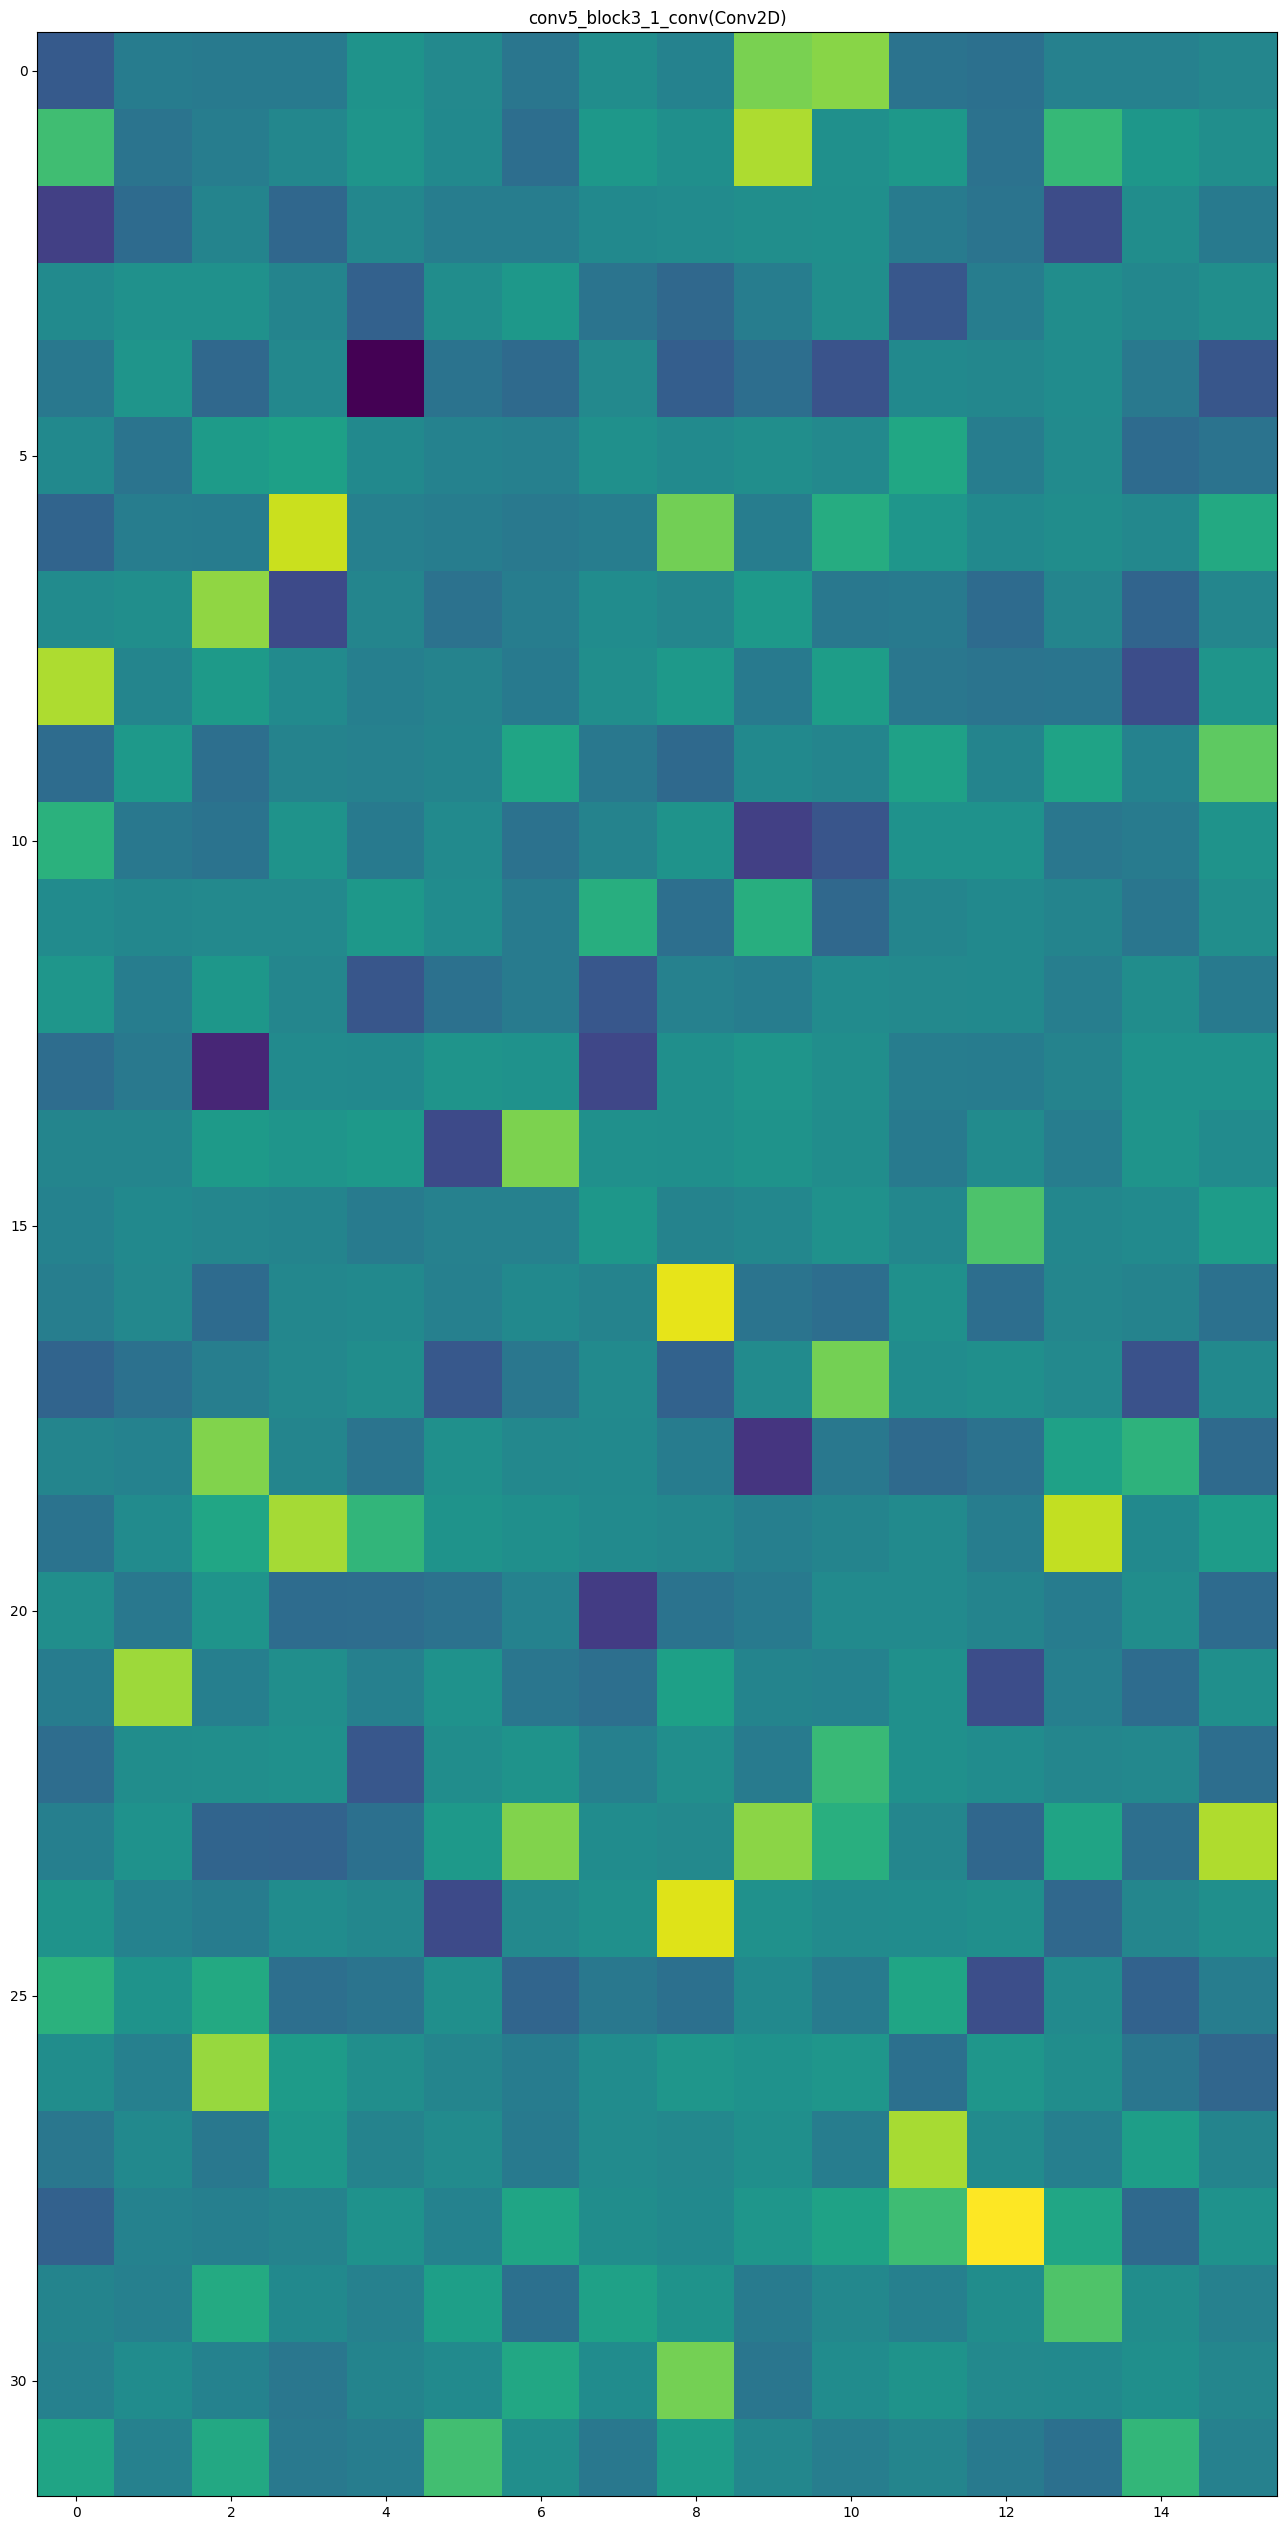

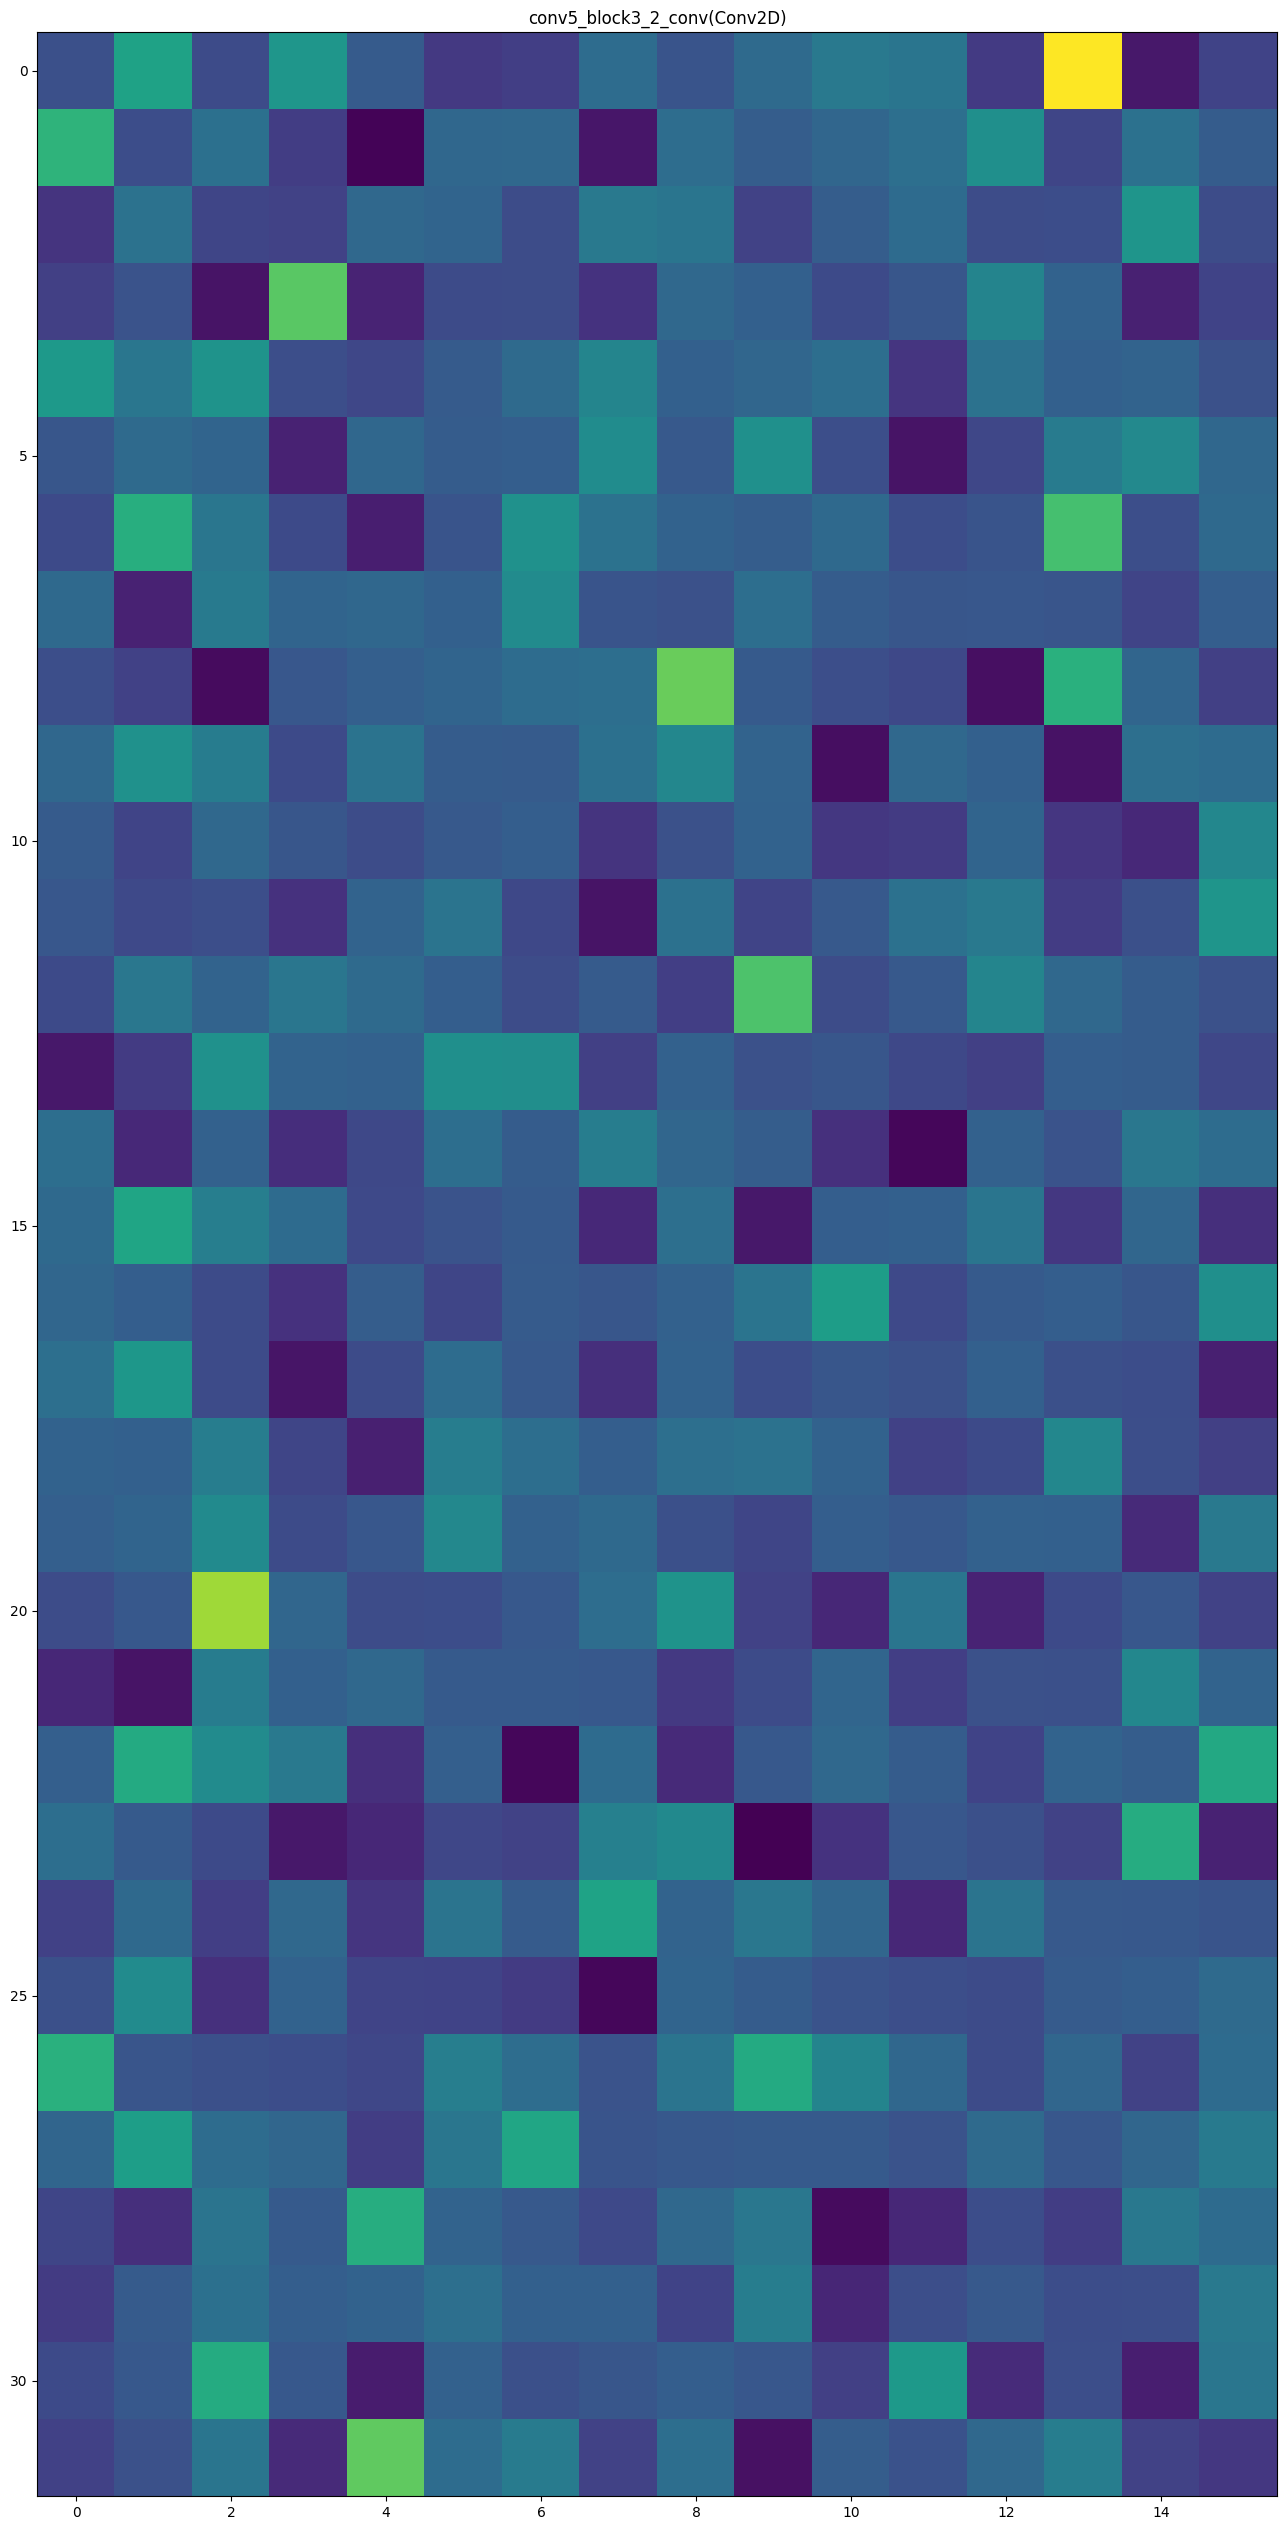

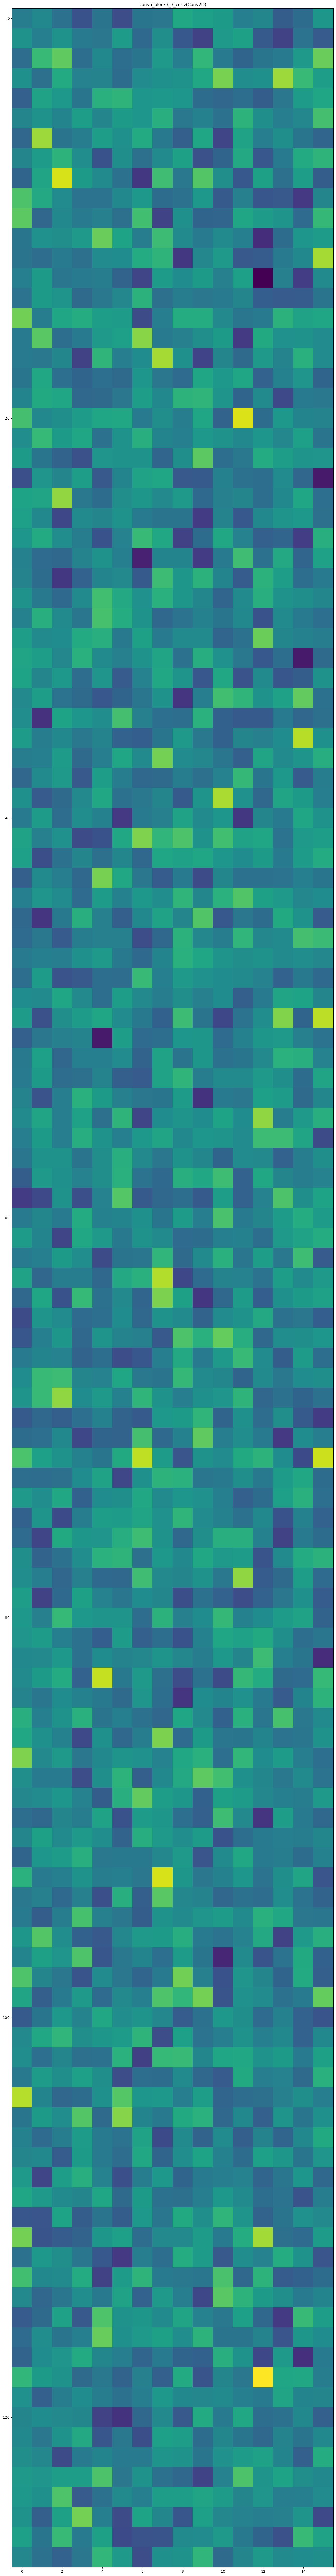

In [ ]:
layer_names = get_layer_names(141, 172, model)

# Now let's display our feature maps

plot_feature_map(layer_names, activations)

#Visualizing convnets filters.

In [14]:
def get_filters(start, end, names, m):
  filters=[]
  layer = m.layers
  for i in range(start, end):
    if 'Conv2D' not in names[i-start]:
      filters.append([0])
    else:
      filter, biases = m.layers[i].get_weights()
      filters.append(filter)
  return filters

In [15]:
def plot_filters(layer_names, filters):
  images_per_row = 16
  for layer_name, filter in zip(layer_names, filters):
    if 'Conv2D' not in layer_name:
      continue

    fig1=plt.figure(figsize=(8, 12))
    fig1.suptitle(layer_name)

    n_filters = filter.shape[3]
    columns = 16
    rows = int(n_filters/columns)

    for i in range(1, n_filters +1):
        f = filter[:, :, :, i-1]
        fig1 =plt.subplot(rows, columns, i)
        fig1.set_xticks([])  #Turn off axis
        fig1.set_yticks([])
        plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
        #ix += 1


  plt.show()

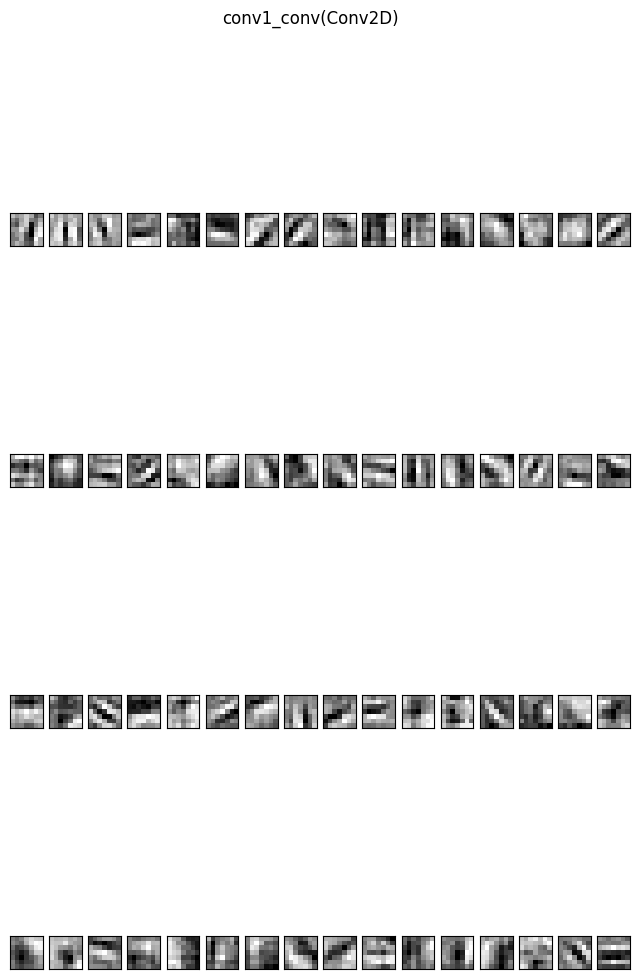

In [ ]:
layer_names = get_layer_names(0, 6, model)
filters = get_filters(0, 6, layer_names, model)
plot_filters(layer_names, filters)

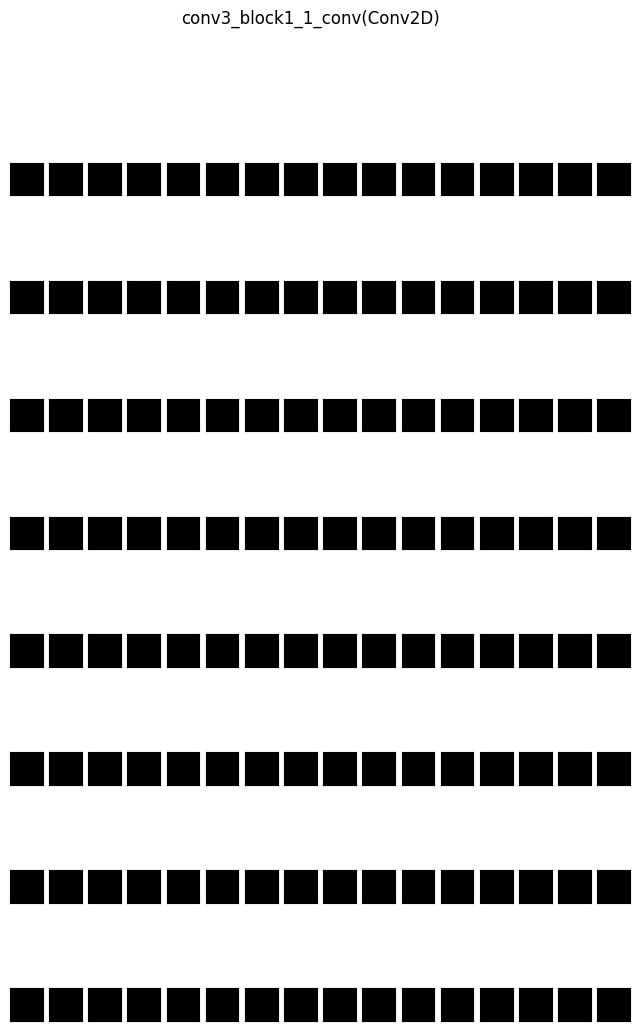

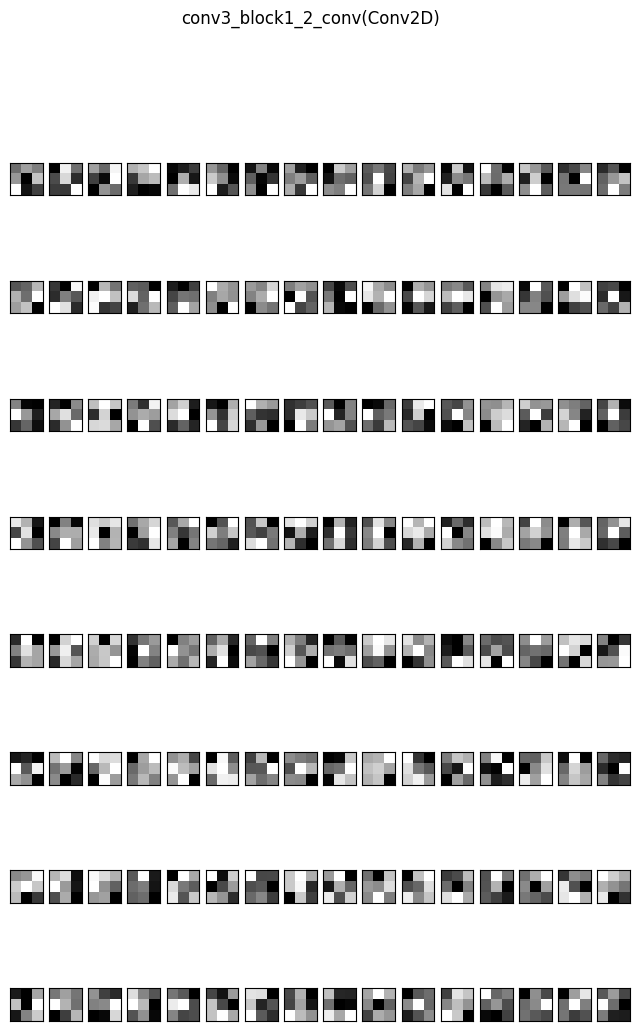

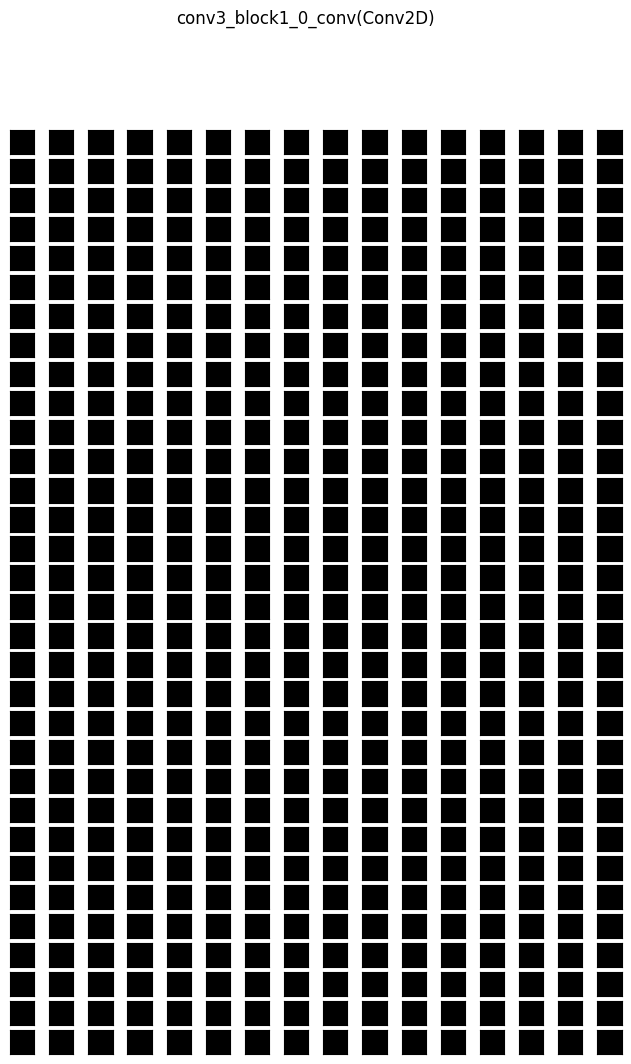

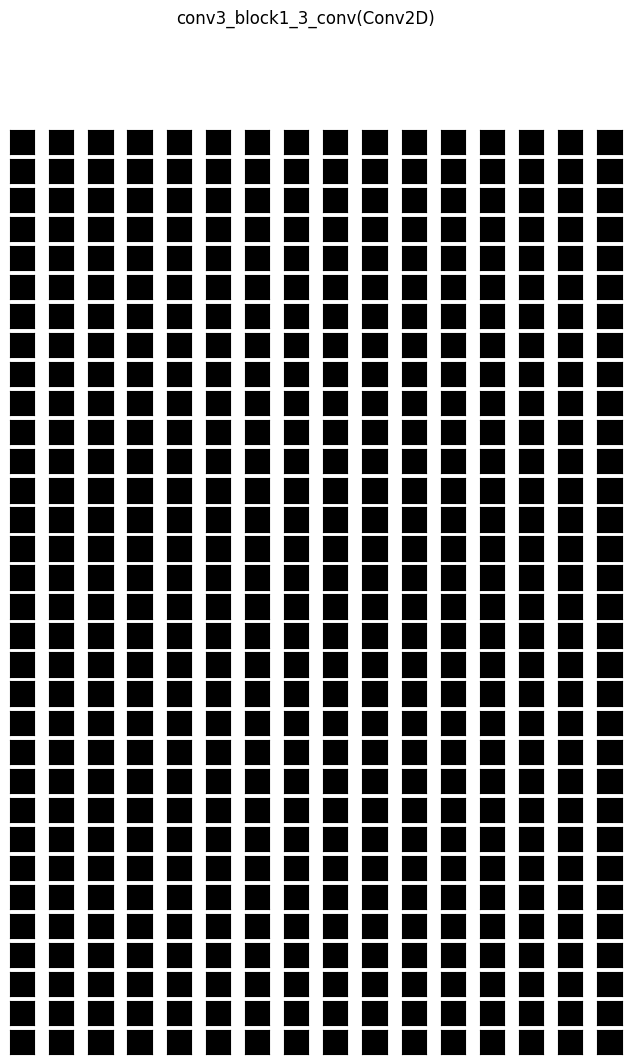

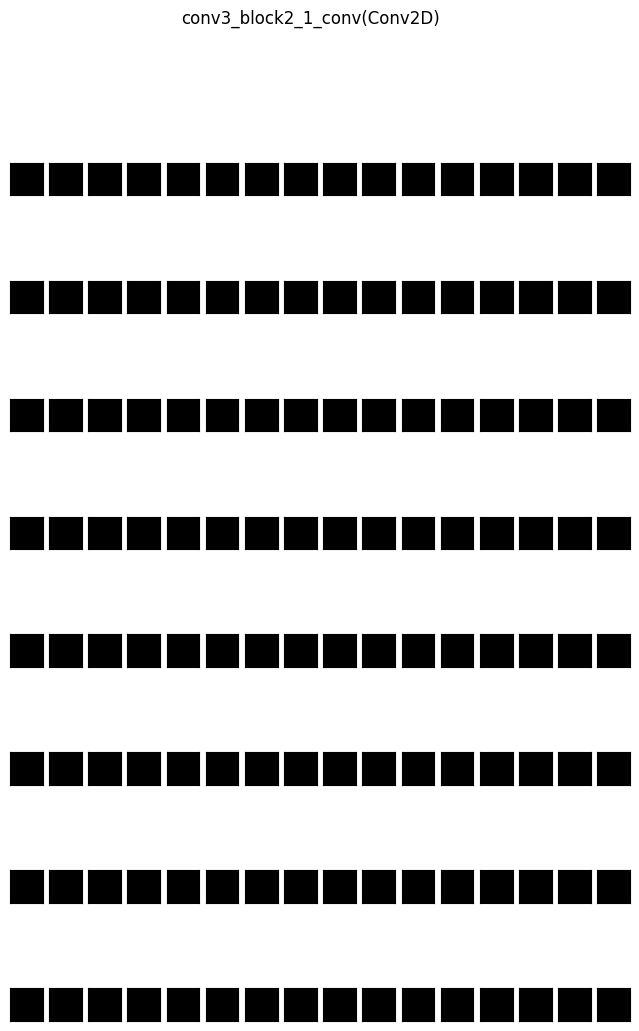

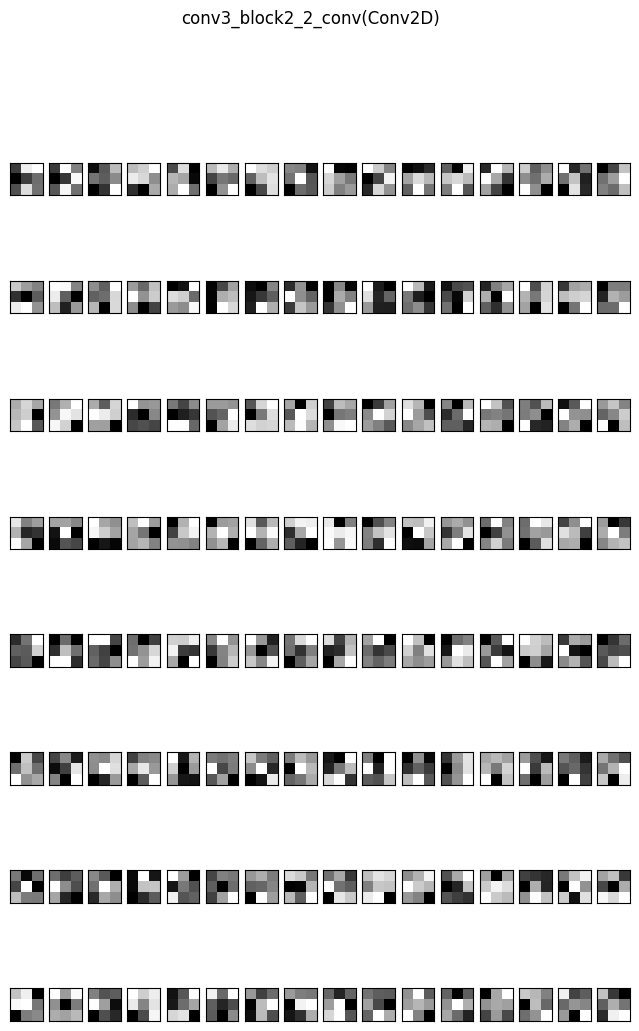

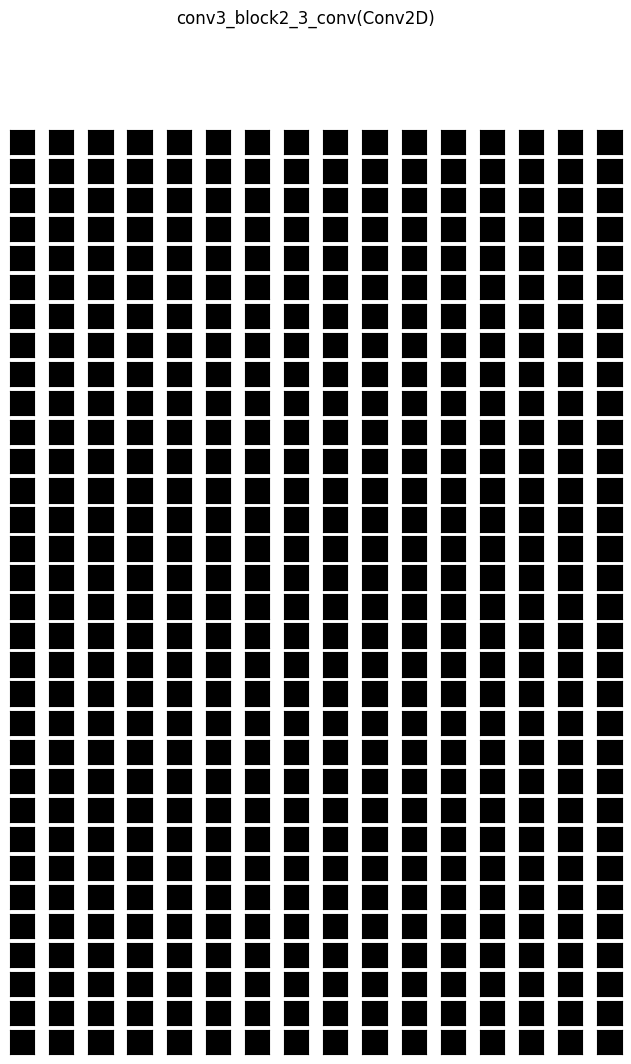

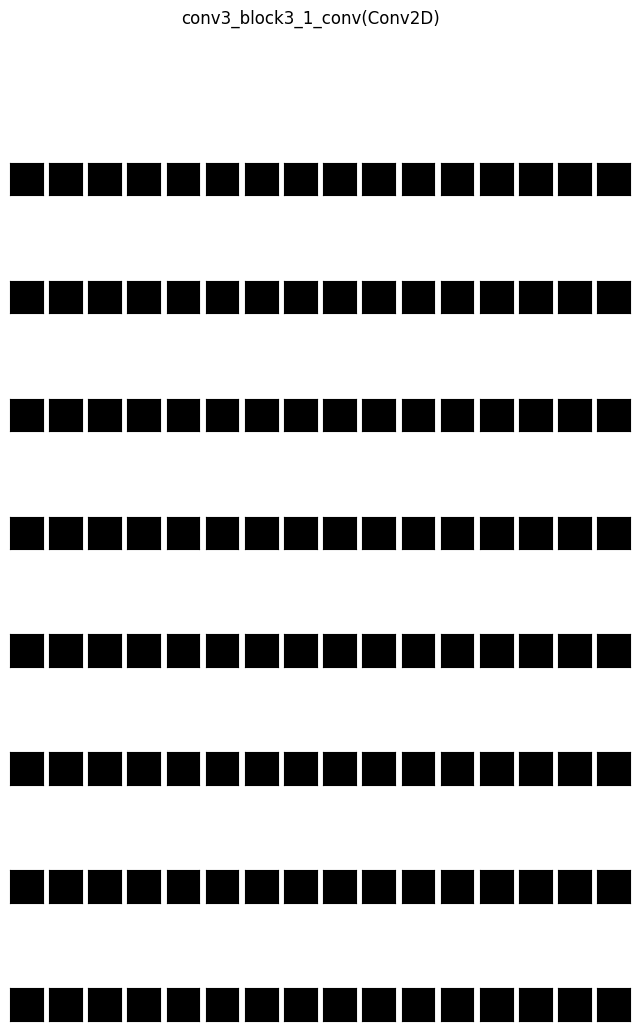

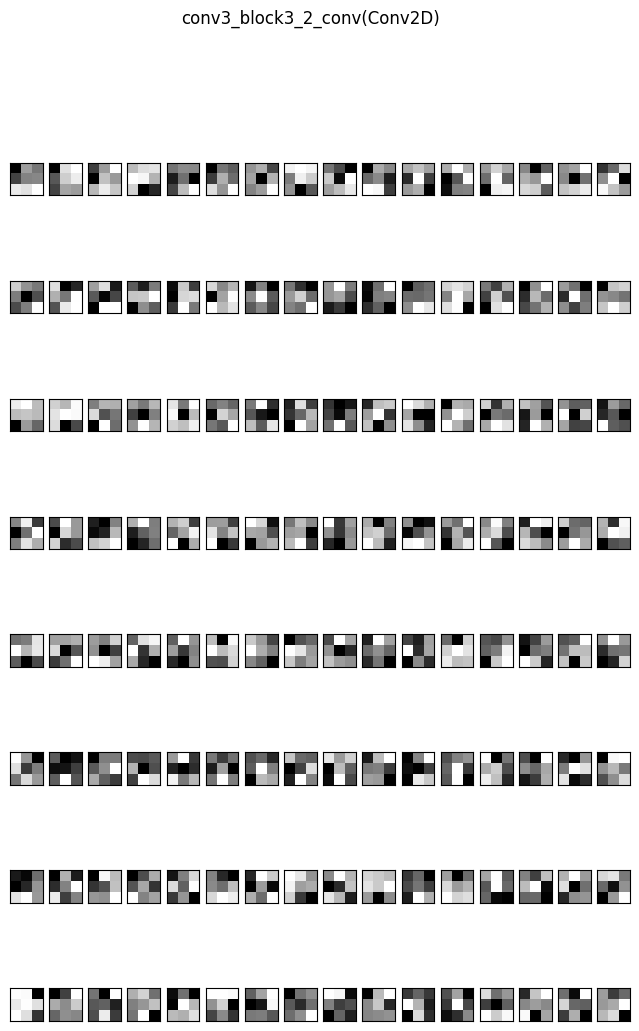

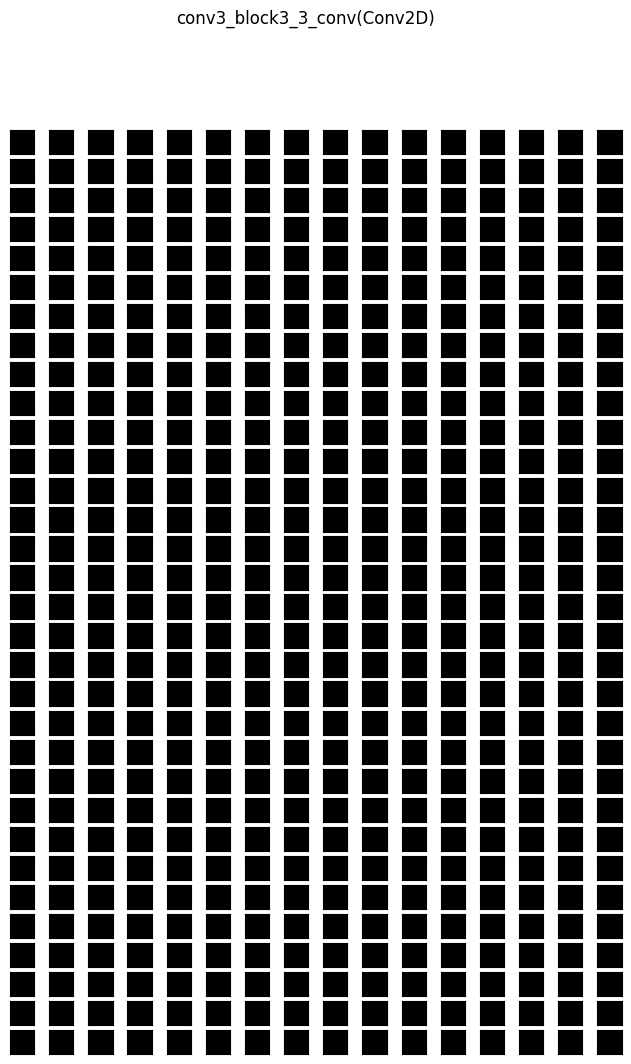

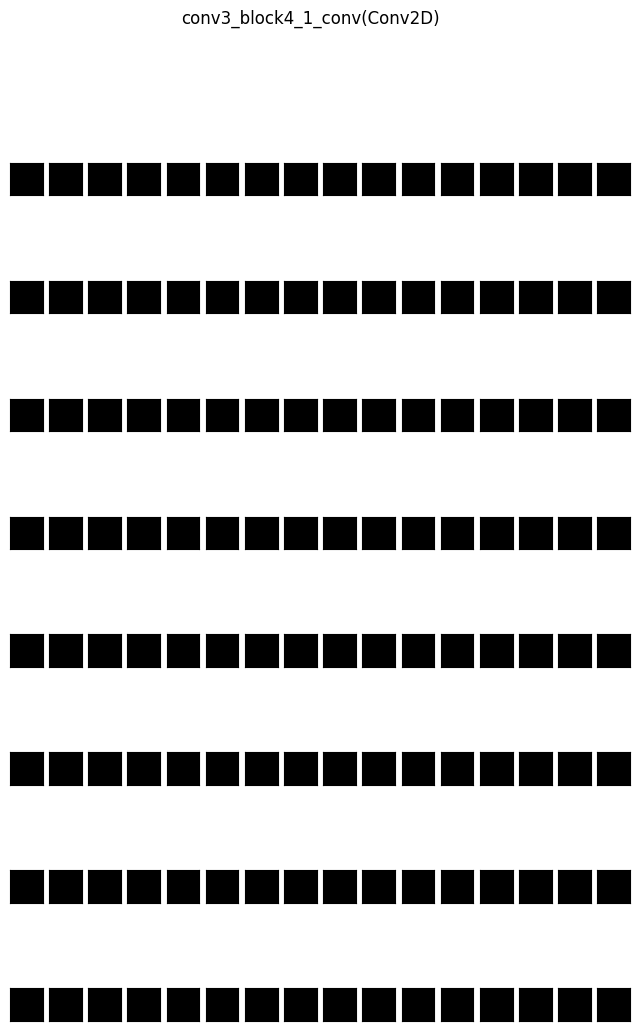

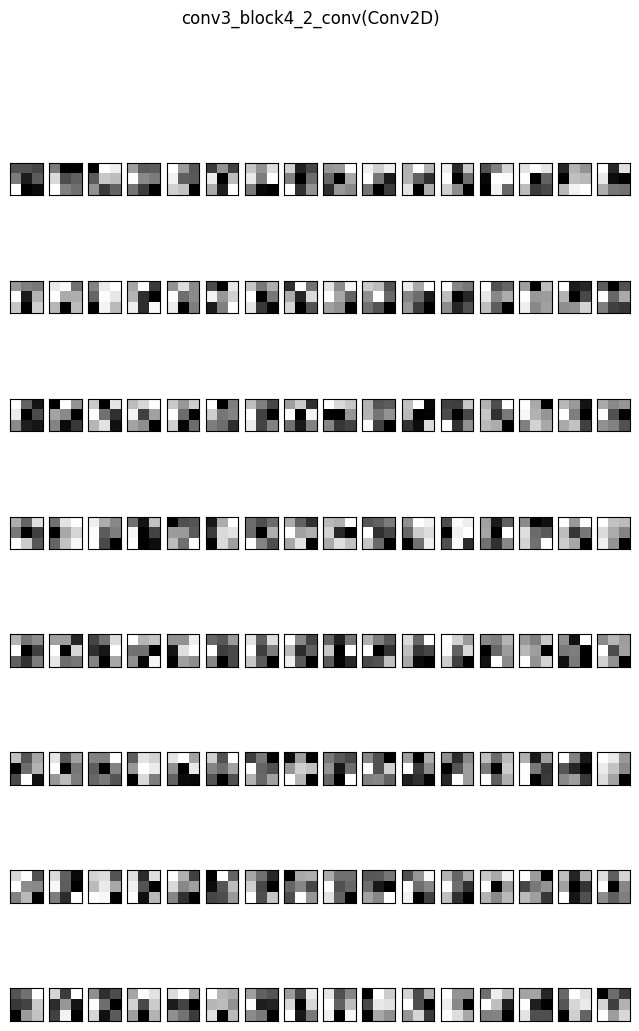

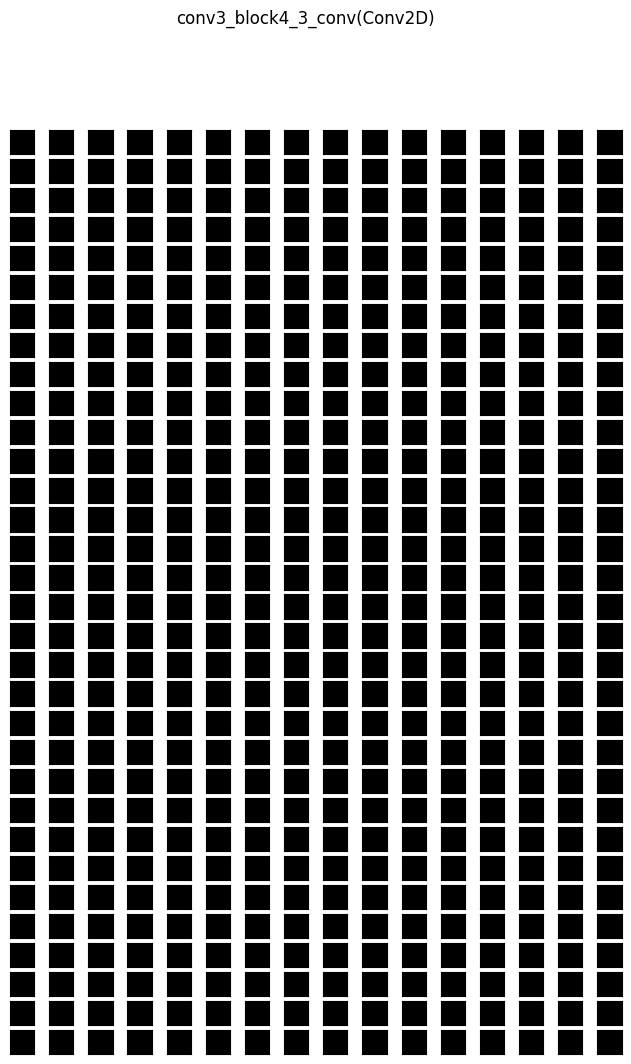

In [ ]:
layer_names = get_layer_names(38, 78, model)
filters = get_filters(38, 78, layer_names, model)
plot_filters(layer_names, filters)

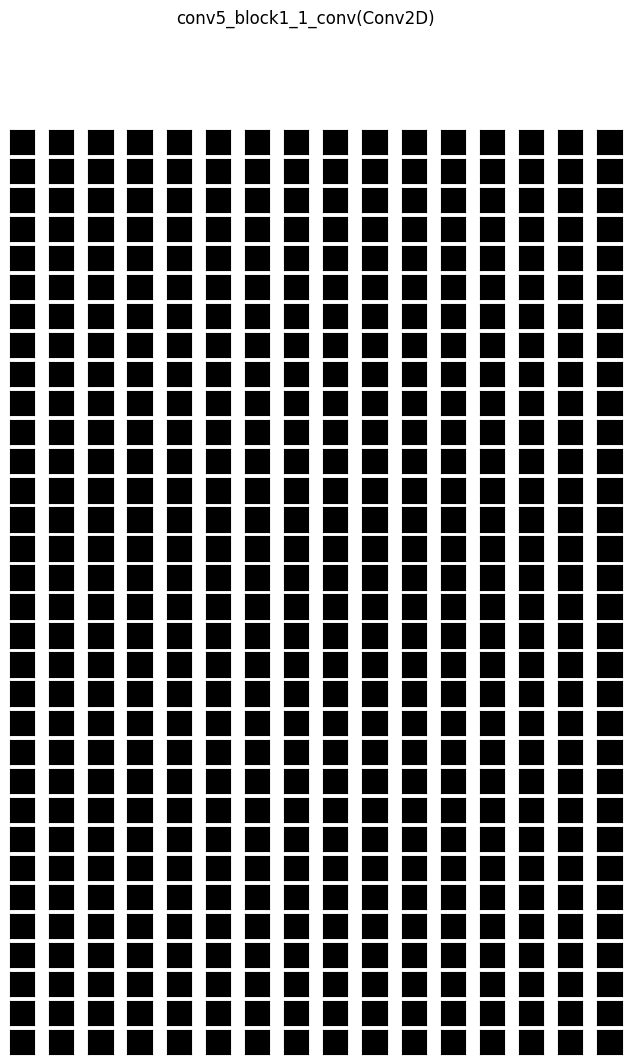

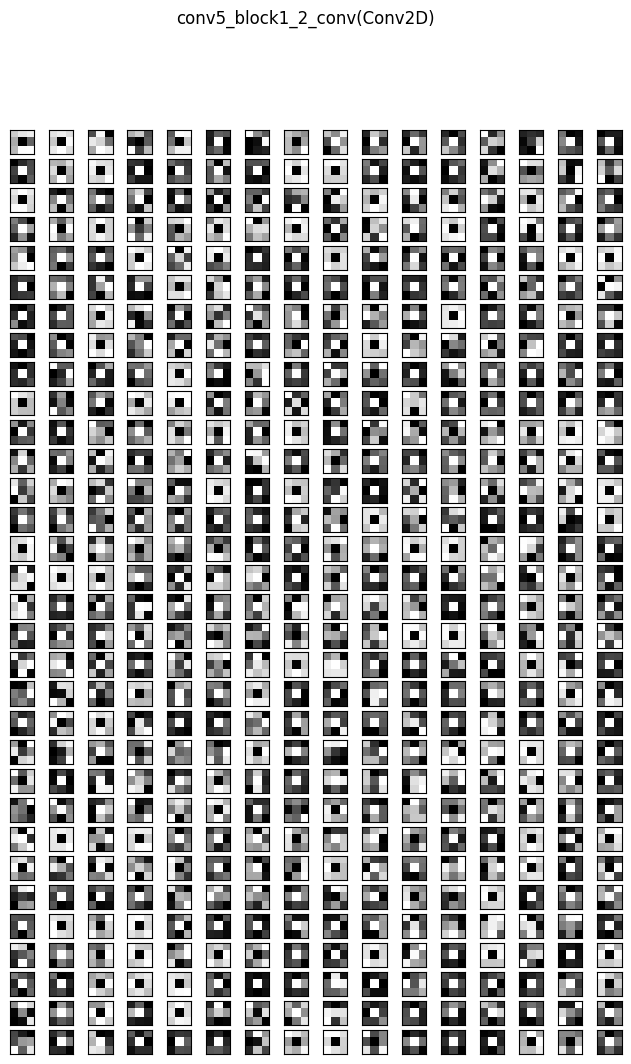

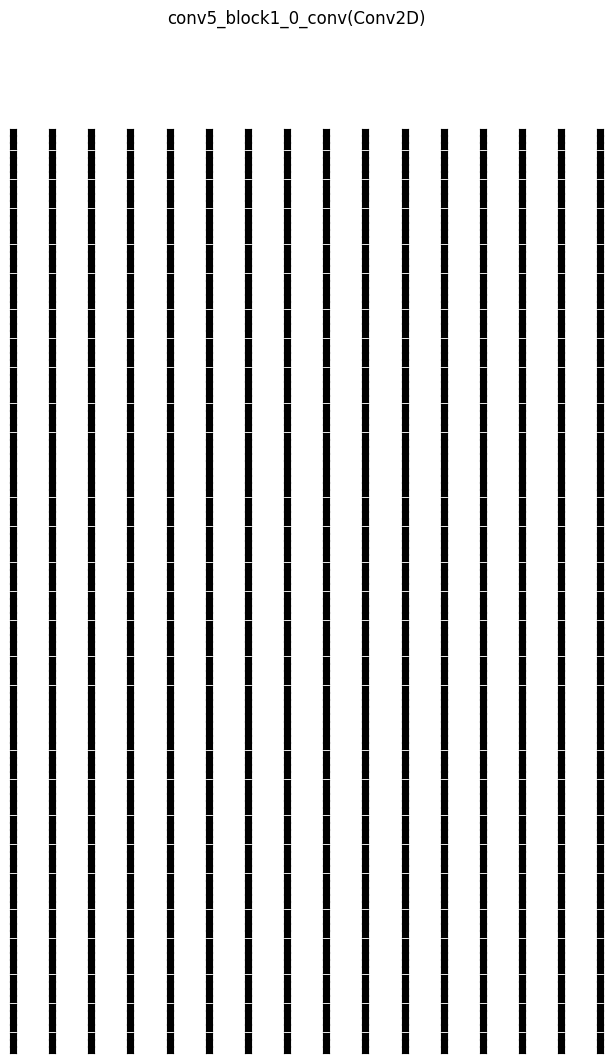

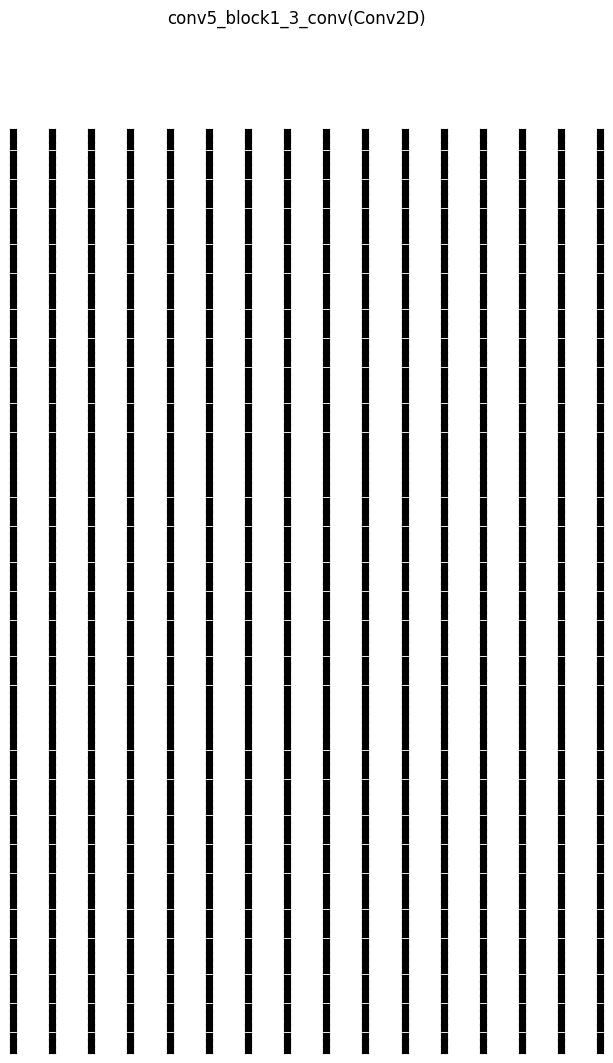

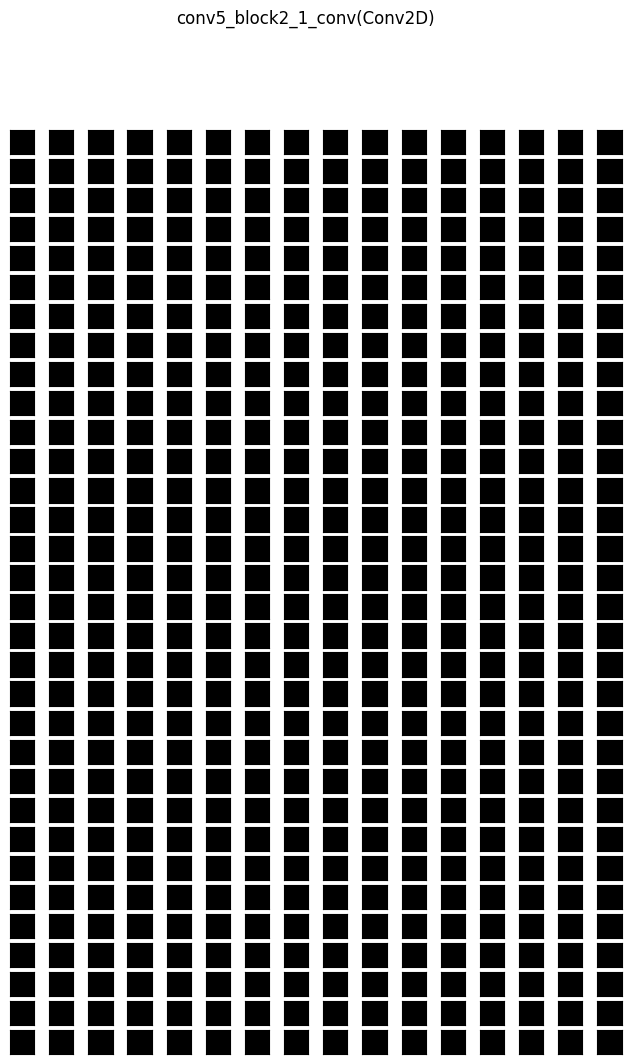

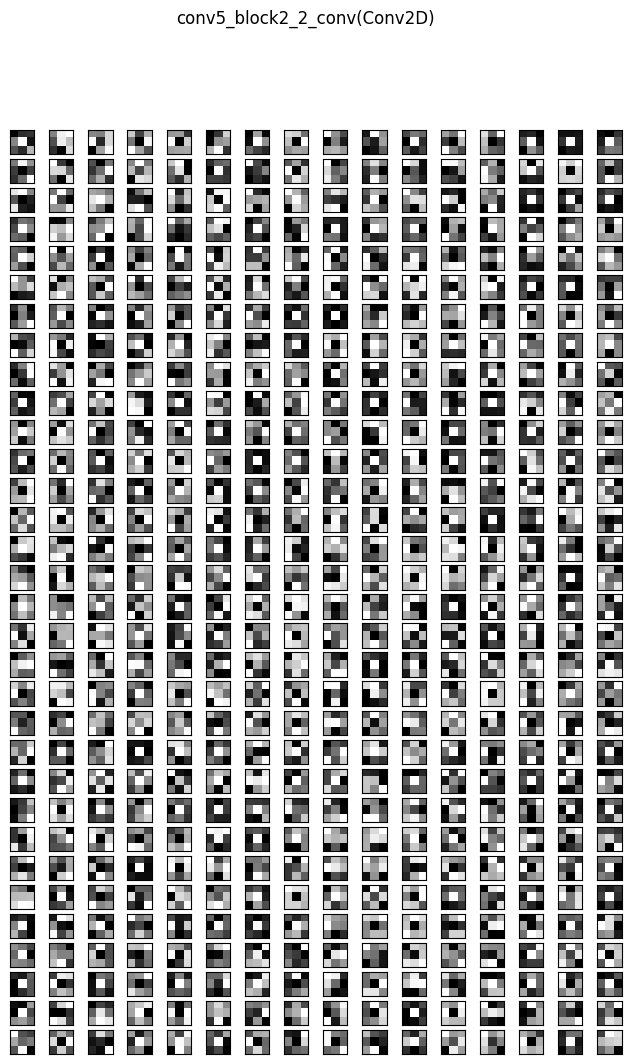

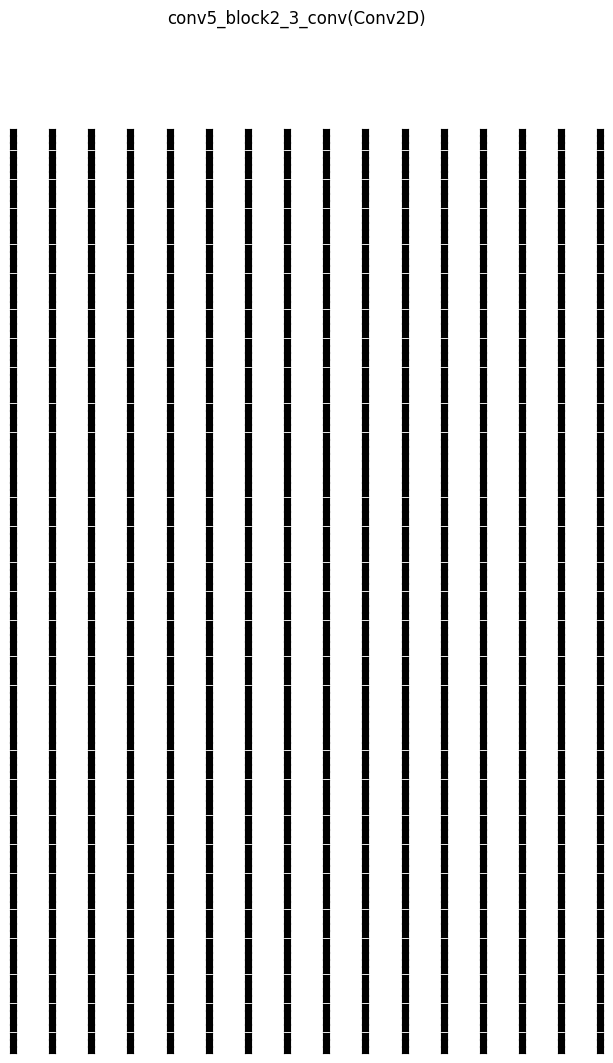

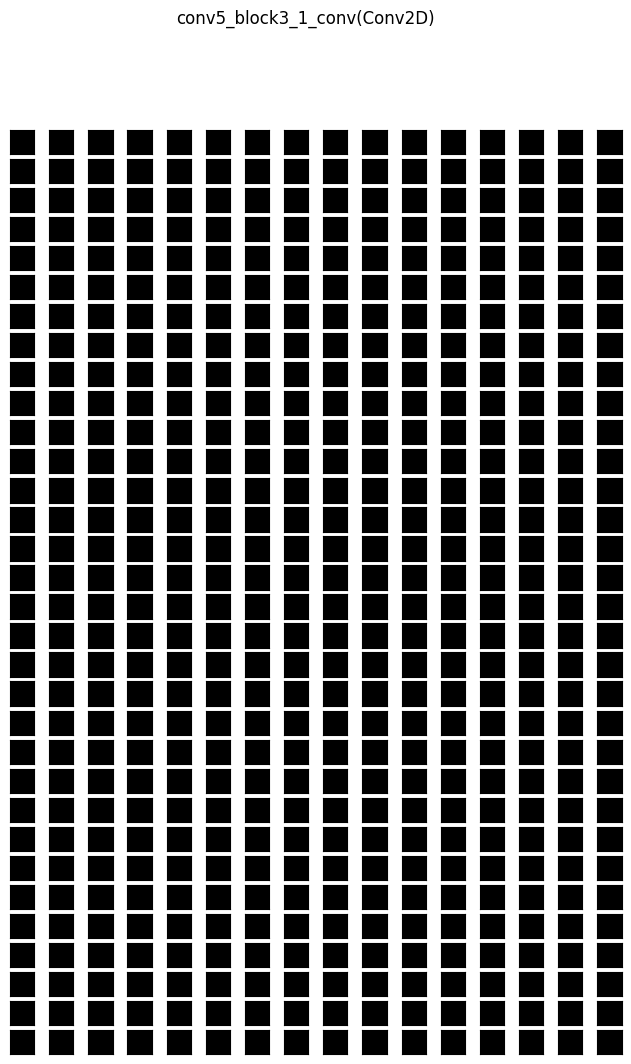

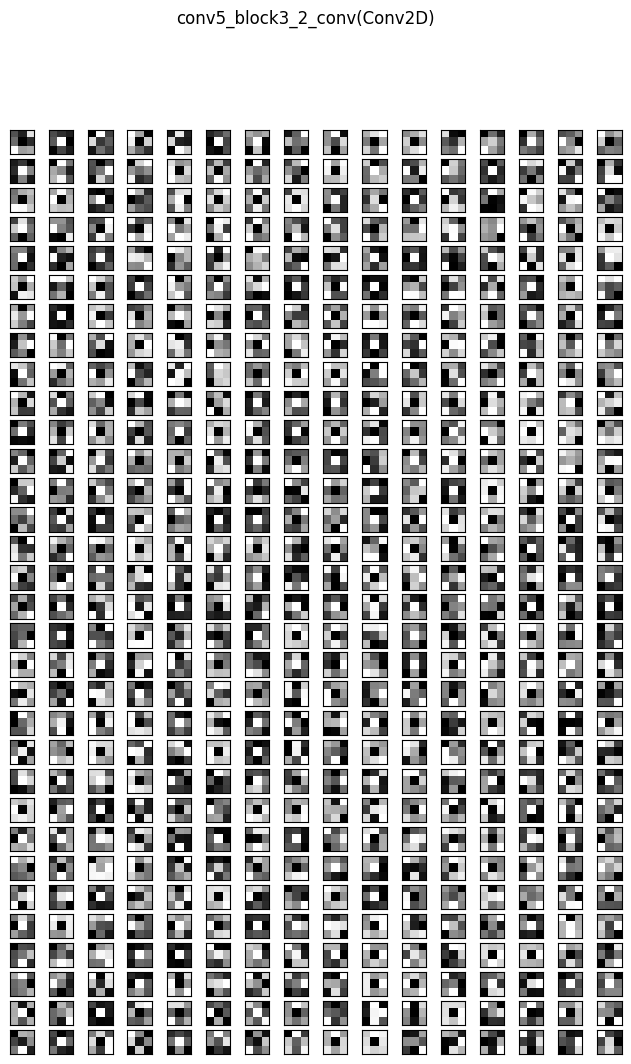

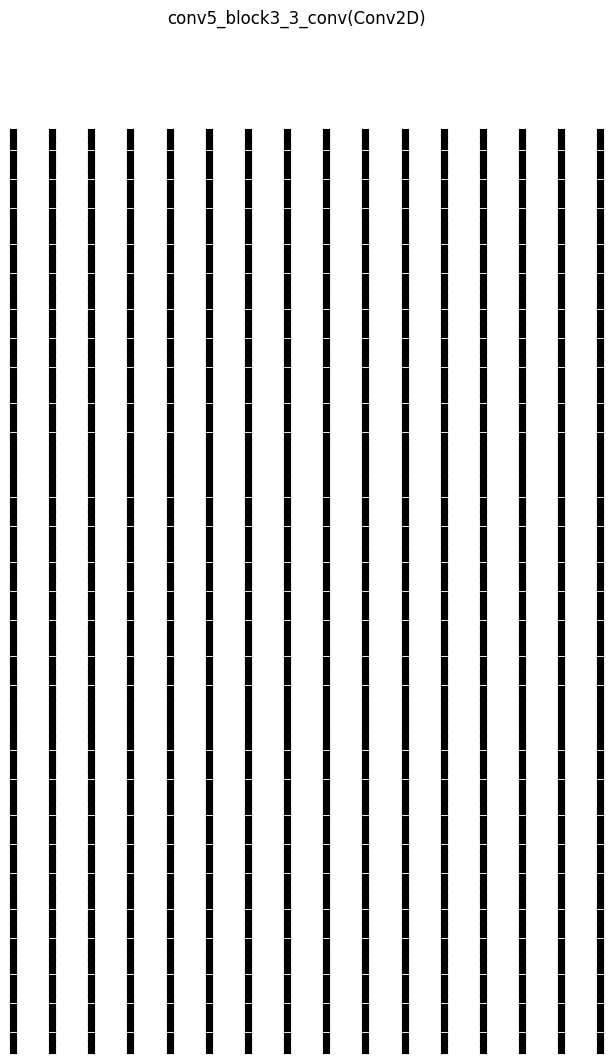

In [ ]:
layer_names = get_layer_names(141, 172, model)
filters = get_filters(141, 172, layer_names, model)
plot_filters(layer_names, filters)

# Visualizing heatmaps of class activation in an image.

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])

        print(pred_index)
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

tf.Tensor(3, shape=(), dtype=int64)


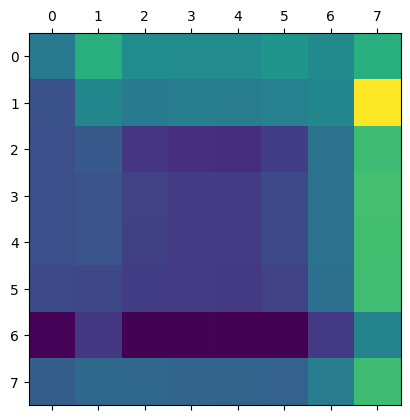

In [ ]:
heat_model = model
heat_model.layers[-1].activation = None

last_conv_layer_name = 'conv2_block3_3_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread('0872.jpg')

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('heatmap.jpg', superimposed_img)

True

(1, 32, 32, 3)


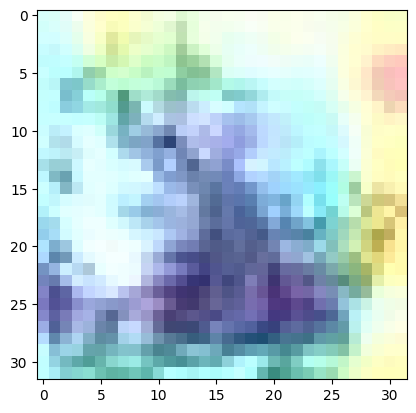

In [ ]:
img_path = 'heatmap.jpg'

# We preprocess the image into a 4D tensor
#from keras.preprocessing import image
import numpy as np

img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)


plt.imshow(img_tensor[0])
plt.show()

In [ ]:
model.save("model.keras")

## PS 1.B - 20 points

In [this notebook](https://pantelis.github.io/artificial-intelligence/aiml-common/lectures/transfer-learning/transfer_learning_tutorial.html) we showcase _transfer learning_ using a pre-trained CNN model.

Perform the fine-tunning and feature extraction methods of transfer learning using the same model as in PS-1A, for the class `ship`.

Repeat the visualization of PS-1.A before and after  transfer learning and write a conclusive summary as to the relative value of the two methods.

In [35]:
#Load Cifar10 dataset
(x_train_s, y_train_s), (x_test_s, y_test_s) = keras.datasets.cifar10.load_data()

In [36]:
#Relabel the dataset, images that are not ship is labeled 0, ship images are labeled 1
y_train_s[y_train_s!=8]=0
y_train_s[y_train_s==8]=1
y_test_s[y_test_s!=8]=0
y_test_s[y_test_s==8]=1

# Fine-tunning

In [37]:
#Build model for fine-tuning

#Get the model we've trained previously, and replace the output layer with a binary classifier
#All the layers are trainable
base_model = model
for layer in base_model.layers:
 layer.trainable = True
base_model = base_model.layers[-2]

#Add new classification head, using sigmoid since this is binary classication model
fc2 = tf.keras.layers.Dense(1,  activation='sigmoid', name="AddedDense2")(base_model.output)
ft_model = tf.keras.models.Model(inputs=model.input, outputs=fc2)

ft_model.compile(optimizer=optimizers.Adam(learning_rate= 0.0001), loss='binary_crossentropy',metrics=['accuracy'])
ft_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [38]:
history = ft_model.fit(x_train_s, y_train_s, epochs=20, batch_size=32, validation_data=(x_test_s, y_test_s))

Epoch 1/20
1563/1563 [==============================] - 100s 46ms/step - loss: 0.4952 - accuracy: 0.8612 - val_loss: 0.1577 - val_accuracy: 0.9344
Epoch 2/20
1563/1563 [==============================] - 71s 45ms/step - loss: 0.1263 - accuracy: 0.9504 - val_loss: 0.1270 - val_accuracy: 0.9498
Epoch 3/20
1563/1563 [==============================] - 73s 47ms/step - loss: 0.0911 - accuracy: 0.9651 - val_loss: 0.1047 - val_accuracy: 0.9590
Epoch 4/20
1563/1563 [==============================] - 72s 46ms/step - loss: 0.0678 - accuracy: 0.9744 - val_loss: 0.0961 - val_accuracy: 0.9646
Epoch 5/20
1563/1563 [==============================] - 73s 47ms/step - loss: 0.0482 - accuracy: 0.9822 - val_loss: 0.1092 - val_accuracy: 0.9585
Epoch 6/20
1563/1563 [==============================] - 73s 47ms/step - loss: 0.0332 - accuracy: 0.9886 - val_loss: 0.1212 - val_accuracy: 0.9593
Epoch 7/20
1563/1563 [==============================] - 70s 45ms/step - loss: 0.0206 - accuracy: 0.9928 - val_loss: 0.1276 

# Feature Extract

In [39]:
#Build model using feature extraction
#Freeze the part from the original model
base_model = model
for layer in base_model.layers:
 layer.trainable = False
base_model = base_model.layers[-2]

#Add new classification head
fc2 = tf.keras.layers.Dense(1,  activation='sigmoid', name="AddedDense2")(base_model.output)

fe_model = tf.keras.models.Model(inputs=model.input, outputs=fc2)

fe_model.compile(optimizer=optimizers.Adam(learning_rate= 0.0001), loss='binary_crossentropy',metrics=['accuracy'])
fe_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [40]:
#Train feature exctraction model
history = fe_model.fit(x_train_s, y_train_s, epochs=20, batch_size=32, validation_data=(x_test_s, y_test_s))

Epoch 1/20
1563/1563 [==============================] - 27s 15ms/step - loss: 0.0986 - accuracy: 0.9597 - val_loss: 0.1582 - val_accuracy: 0.9631
Epoch 2/20
1563/1563 [==============================] - 24s 15ms/step - loss: 0.0261 - accuracy: 0.9934 - val_loss: 0.1631 - val_accuracy: 0.9662
Epoch 3/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0180 - accuracy: 0.9957 - val_loss: 0.1696 - val_accuracy: 0.9656
Epoch 4/20
1563/1563 [==============================] - 24s 16ms/step - loss: 0.0148 - accuracy: 0.9965 - val_loss: 0.1760 - val_accuracy: 0.9656
Epoch 5/20
1563/1563 [==============================] - 23s 15ms/step - loss: 0.0133 - accuracy: 0.9971 - val_loss: 0.1803 - val_accuracy: 0.9654
Epoch 6/20
1563/1563 [==============================] - 24s 16ms/step - loss: 0.0124 - accuracy: 0.9973 - val_loss: 0.1835 - val_accuracy: 0.9650
Epoch 7/20
1563/1563 [==============================] - 24s 15ms/step - loss: 0.0119 - accuracy: 0.9974 - val_loss: 0.1856 -

# Conclusive Summary
We performed 2 methods for transfer learning, fine tuning and feature extraction.

For fine tuning, I took the Resnet50 based model which was previously trained. All the layers are trainable so we could 'tune' the parameters. The model had 99% training accuracy and 96% validate accuracy. The training time is about 75 second per epoch (Using google colab backend T4).

For feature extraction, the model was as same as the fine tuning model but the layers that are from the pretained model are frozen, so all the parameters are
fixed. The model had 99% training accuracy and 96% validate accuracy. The training time is siginificantly shorter then fine tuning, about 30 second per epoch.

In this scenario, the result of using fine tuning and feature extraction are very close. I believe it's because the training datas for the pretrained model and transfer learning model are mostly the same(only difference is the datas in ship class). The features are mostly learned, limiting the room for fine tuning. Therefore using feature extraction would be more efficient for this case.

# Visualize outputs before and after Transfer learning

In [ ]:
img_path = 'ship.jpg'

ship_img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
ship_img_tensor = tf.keras.utils.img_to_array(ship_img)
ship_img_tensor = np.expand_dims(ship_img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
ship_img_tensor /= 255.

print(ship_img_tensor.shape)

(1, 32, 32, 3)


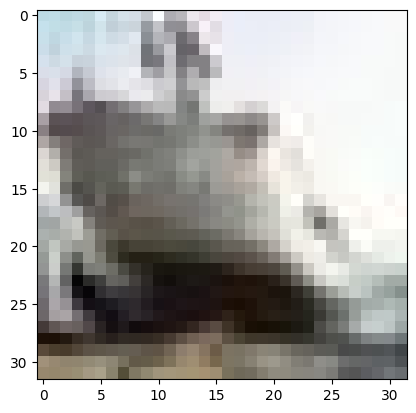

In [ ]:
plt.imshow(ship_img_tensor[0])
plt.show()

In [12]:
#Build a model before tranfer learning
input_shape = (32, 32, 3)
resnet_model = ResNet50(
    input_shape=input_shape,
    weights=None,
    include_top=False
)
flattened = tf.keras.layers.Flatten()(resnet_model.output)
fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened)
fc2 = tf.keras.layers.Dense(2, activation='sigmoid', name="AddedDense2")(fc1)

before_model = tf.keras.models.Model(inputs=resnet_model.input, outputs=fc2)

# HeatMaps before and after Transfer learning

1. Before Transfer learning

tf.Tensor(1, shape=(), dtype=int64)


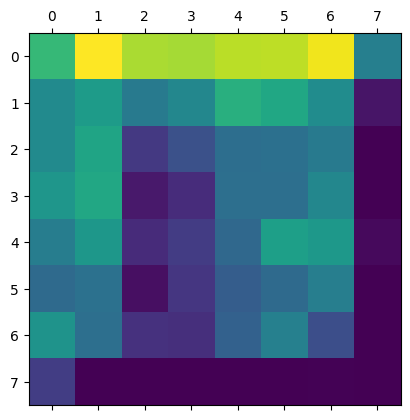

In [ ]:
heat_model = before_model
heat_model.layers[-1].activation = None

last_conv_layer_name = 'conv2_block3_3_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(ship_img_tensor, before_model, last_conv_layer_name)
# Display heatmap
plt.matshow(heatmap)
plt.show()

(1, 32, 32, 3)


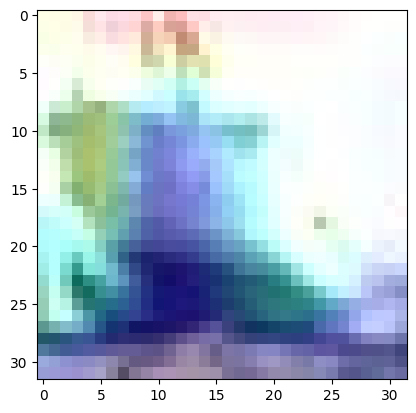

In [ ]:
img = cv2.imread('ship.jpg')

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('before_ship_heatmap.jpg', superimposed_img)

img_path = 'before_ship_heatmap.jpg'

img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

2. After fine-tuning

tf.Tensor(0, shape=(), dtype=int64)


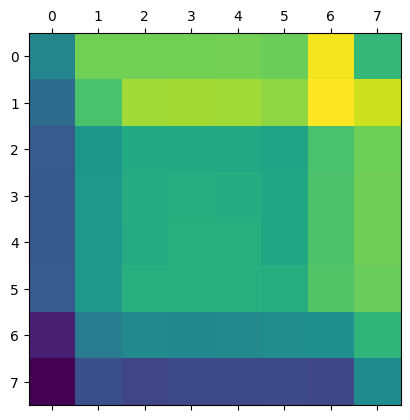

In [ ]:
heat_model = ft_model
heat_model.layers[-1].activation = None

last_conv_layer_name = 'conv2_block3_3_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(ship_img_tensor, ft_model, last_conv_layer_name)
# Display heatmap
plt.matshow(heatmap)
plt.show()

(1, 32, 32, 3)


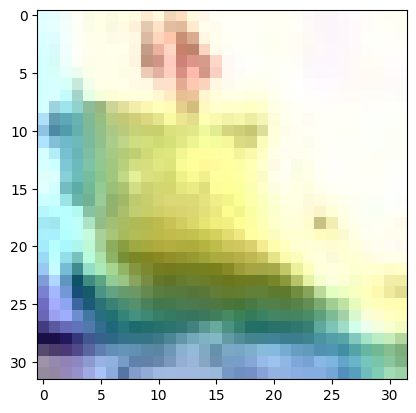

In [ ]:
img = cv2.imread('ship.jpg')

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('ft_ship_heatmap.jpg', superimposed_img)

img_path = 'ft_ship_heatmap.jpg'

img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

3. After feature extraction

tf.Tensor(0, shape=(), dtype=int64)


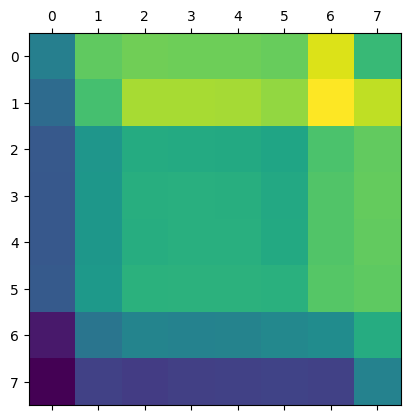

In [ ]:
heat_model = fe_model
heat_model.layers[-1].activation = None

last_conv_layer_name = 'conv2_block3_3_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(ship_img_tensor, fe_model, last_conv_layer_name)
# Display heatmap
plt.matshow(heatmap)
plt.show()

(1, 32, 32, 3)


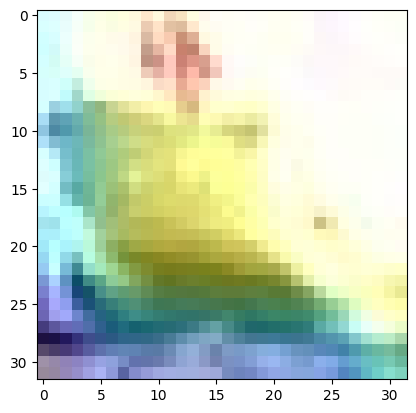

In [ ]:
img = cv2.imread('ship.jpg')

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('fe_ship_heatmap.jpg', superimposed_img)

img_path = 'fe_ship_heatmap.jpg'

img = tf.keras.utils.load_img(img_path, target_size=(32, 32))
img_tensor = tf.keras.utils.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

# Convnet outputs visualizations
1. Before Transfer learning

covnet outputs of first block

In [ ]:
# Extracts the outputs of first block:
layer_outputs = [layer.output for layer in before_model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=before_model.input, outputs=layer_outputs)
activations = activation_model.predict(ship_img_tensor)

1/1 [==============================] - 0s 62ms/step


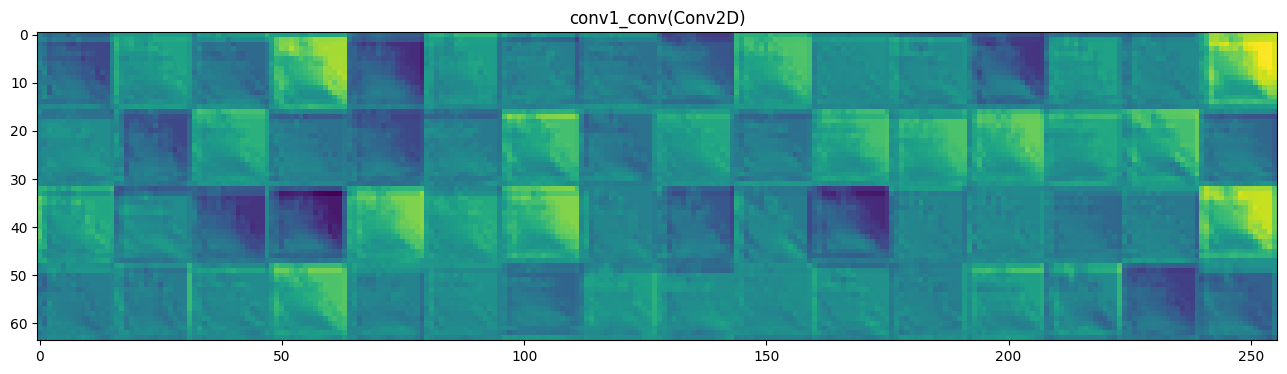

In [ ]:
#Plot feature map for the first block
layer_names = get_layer_names(0, 6, before_model)

# Now let's display our feature maps
plot_feature_map(layer_names, activations)

covnet outputs of third block

In [ ]:
# Extracts the outputs of Block 3
layer_outputs = [layer.output for layer in before_model.layers[38:78]]

# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=before_model.input, outputs=layer_outputs)
activations = activation_model.predict(ship_img_tensor)

1/1 [==============================] - 1s 994ms/step


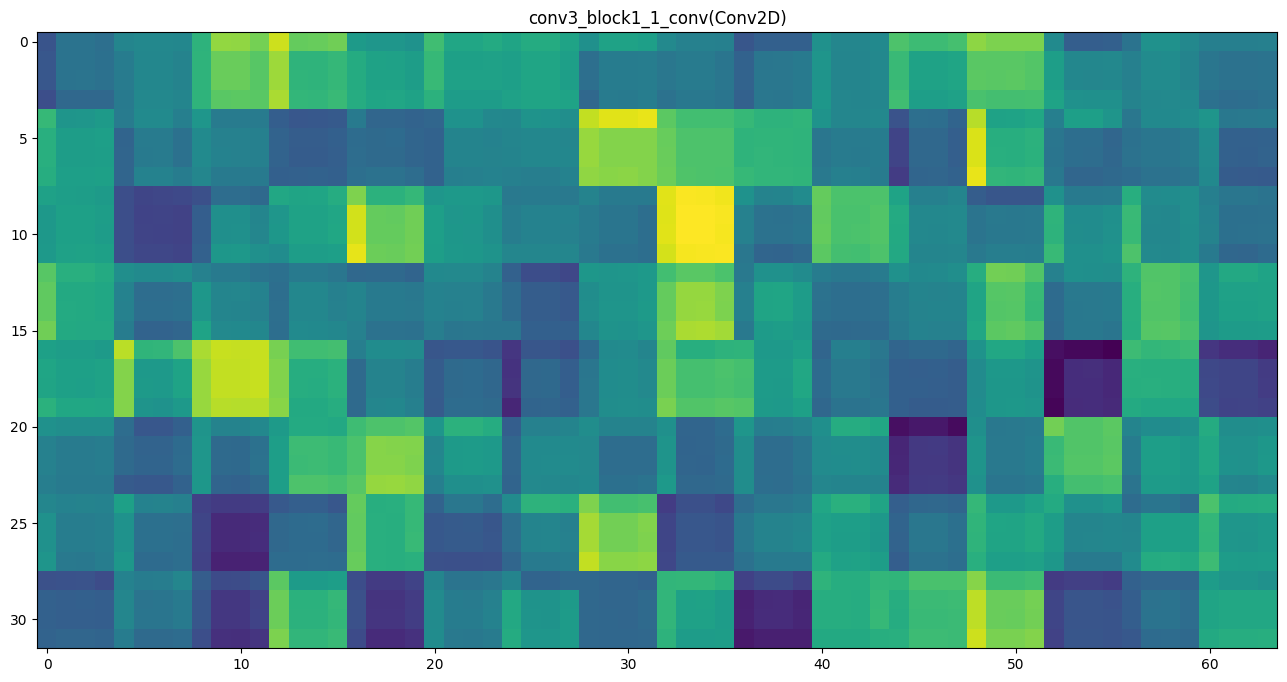

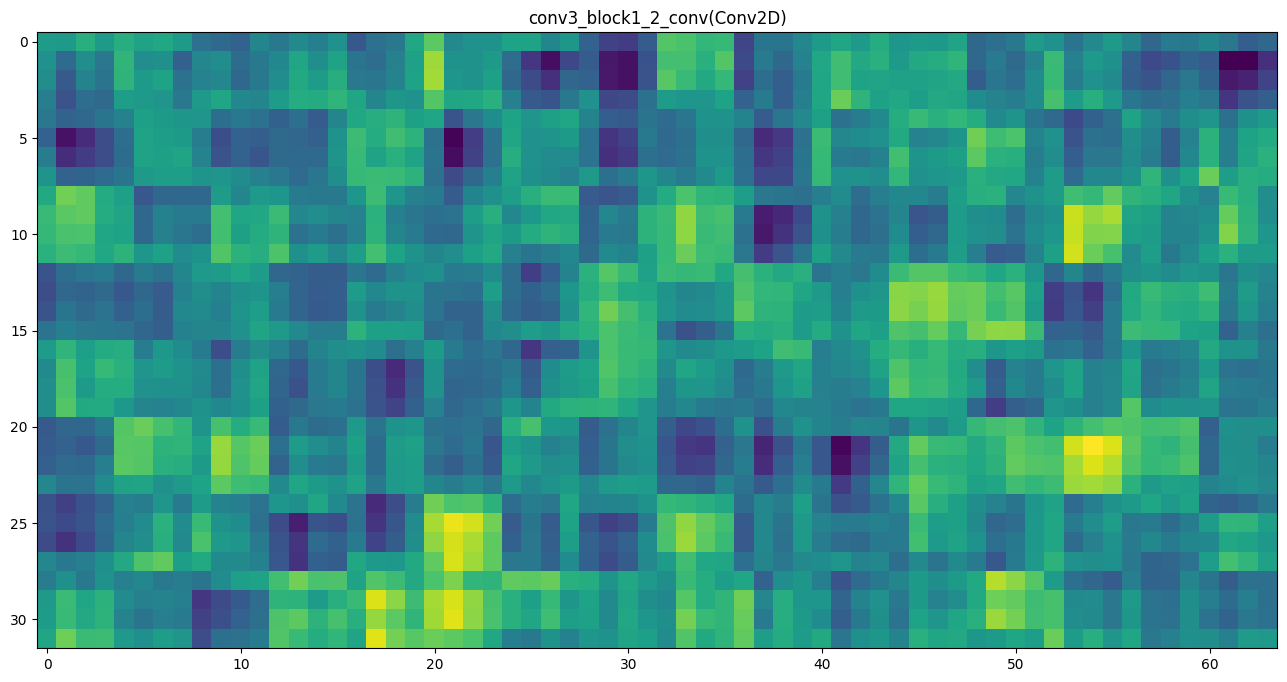

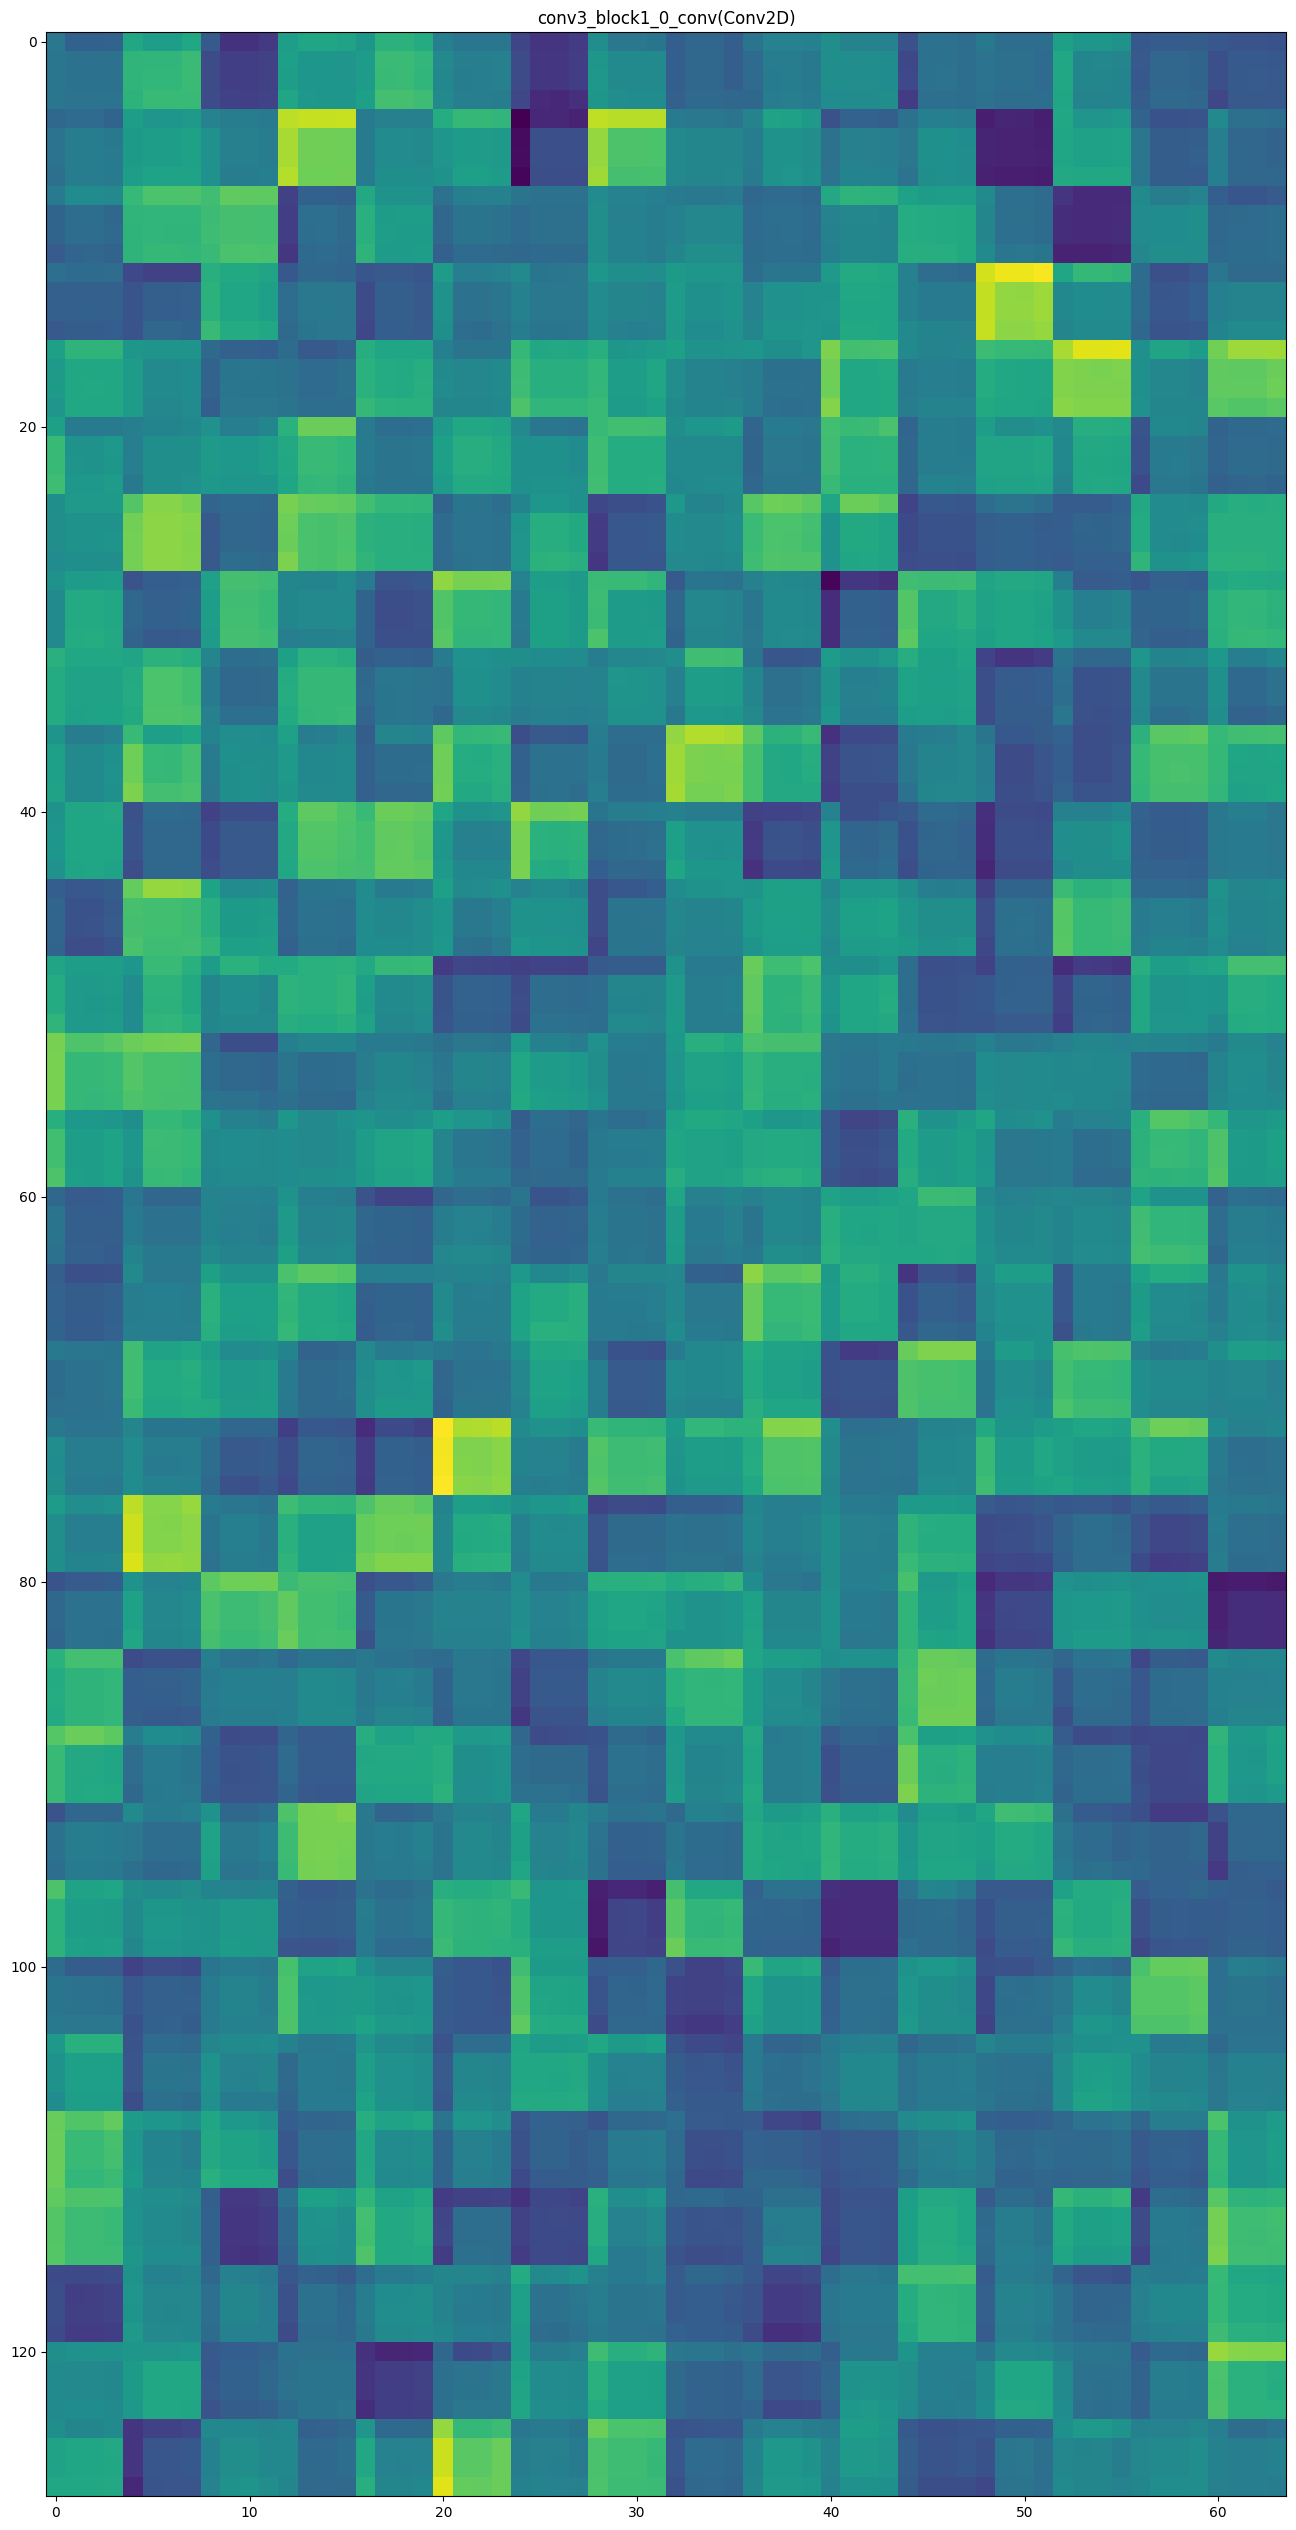

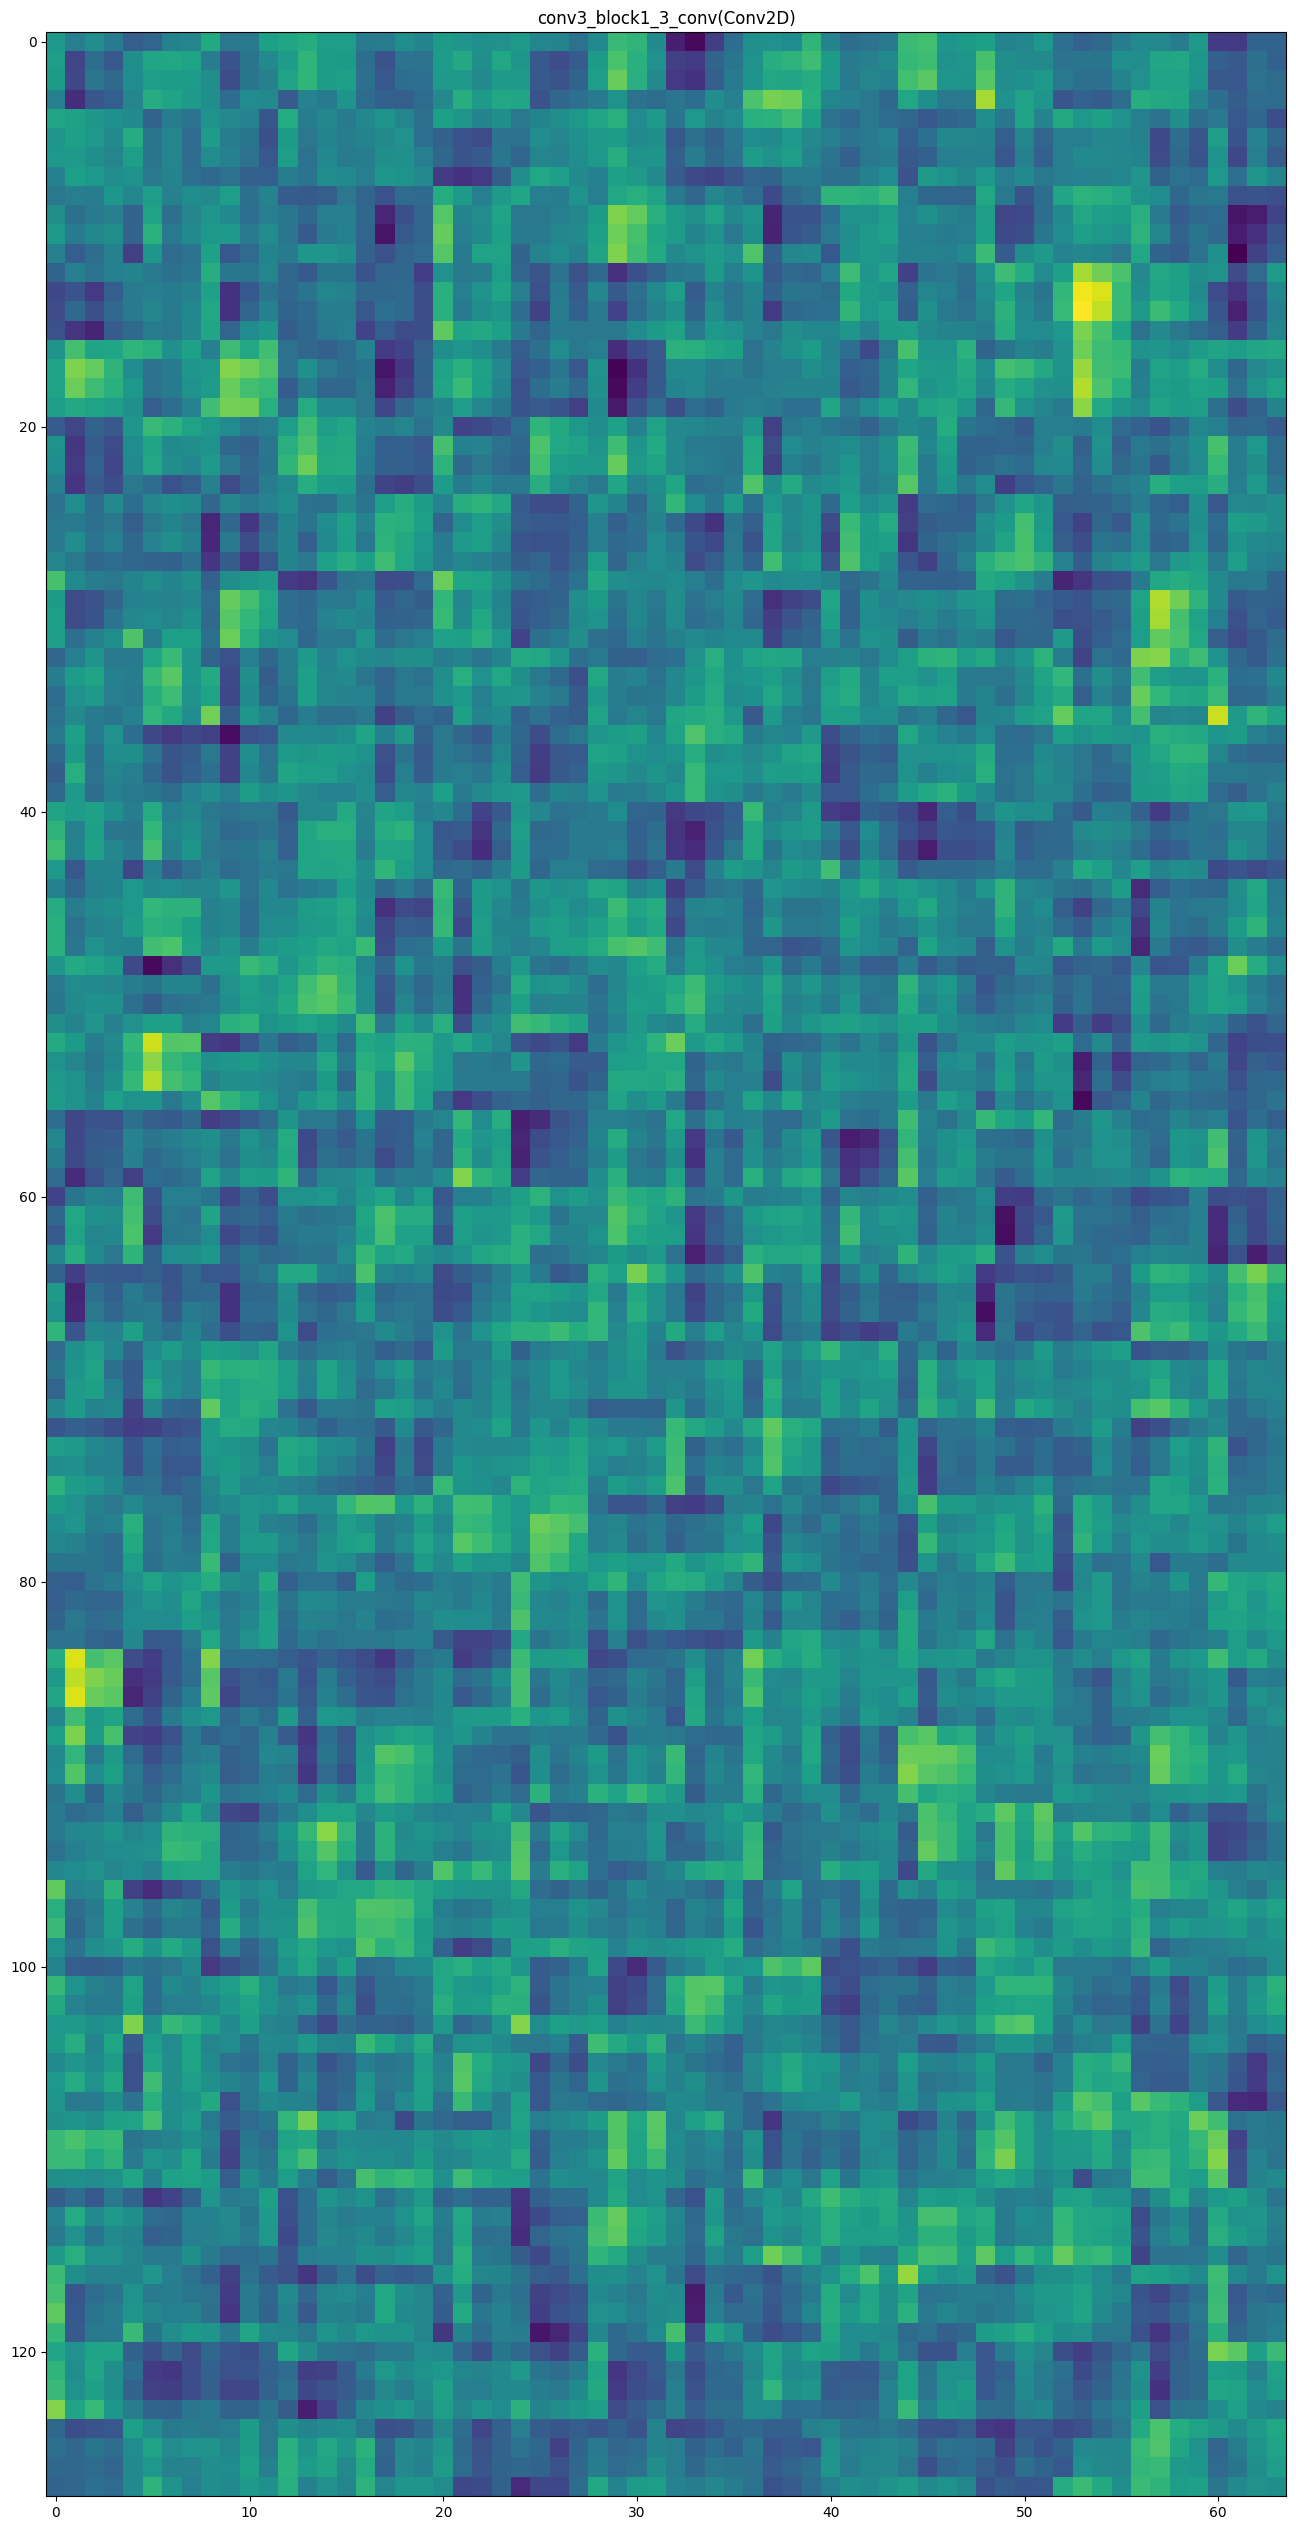

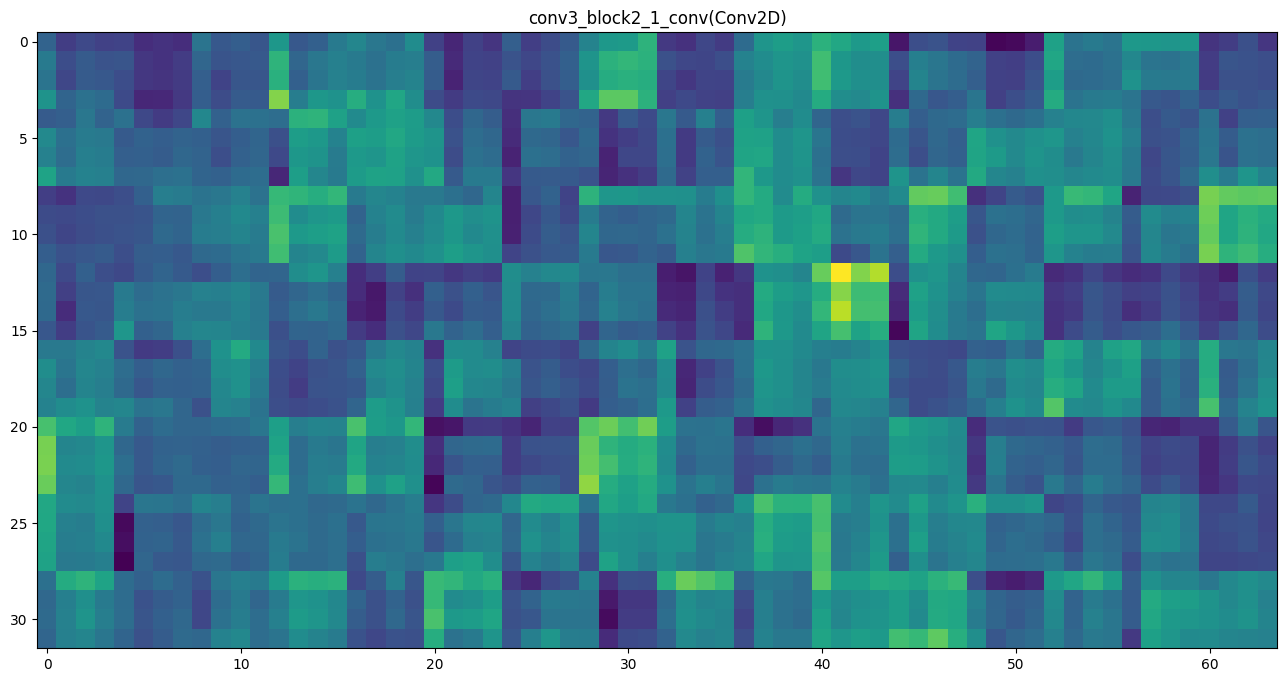

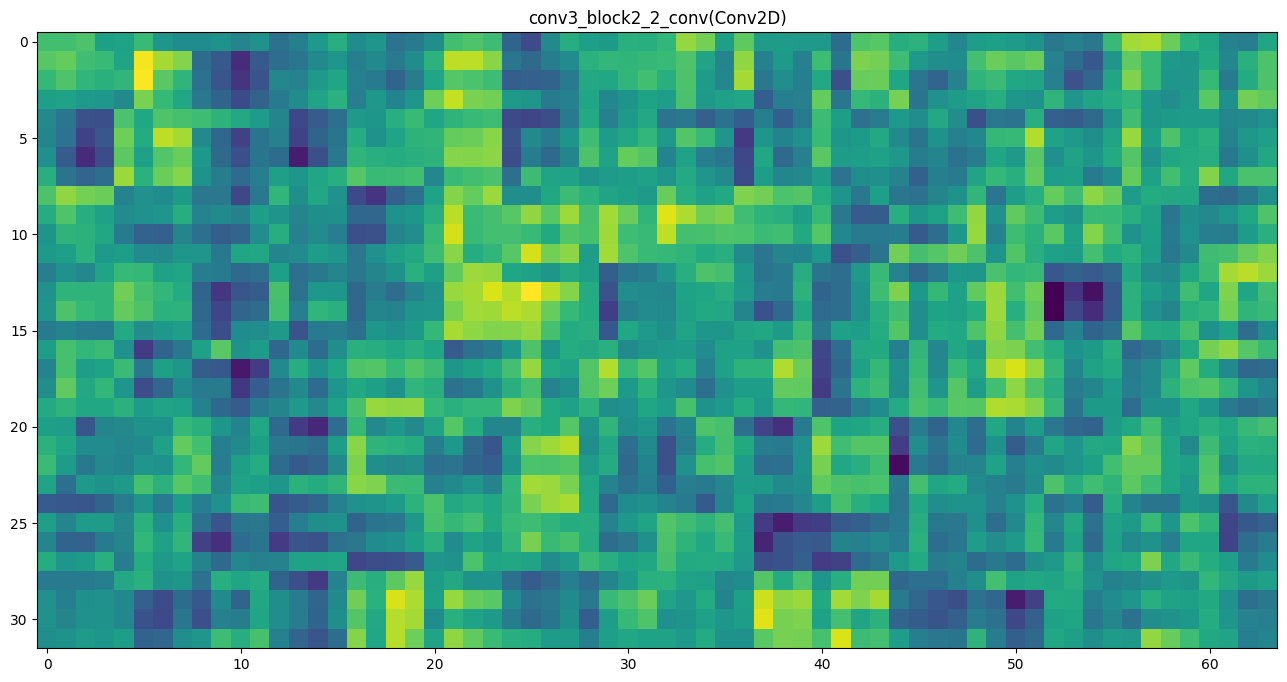

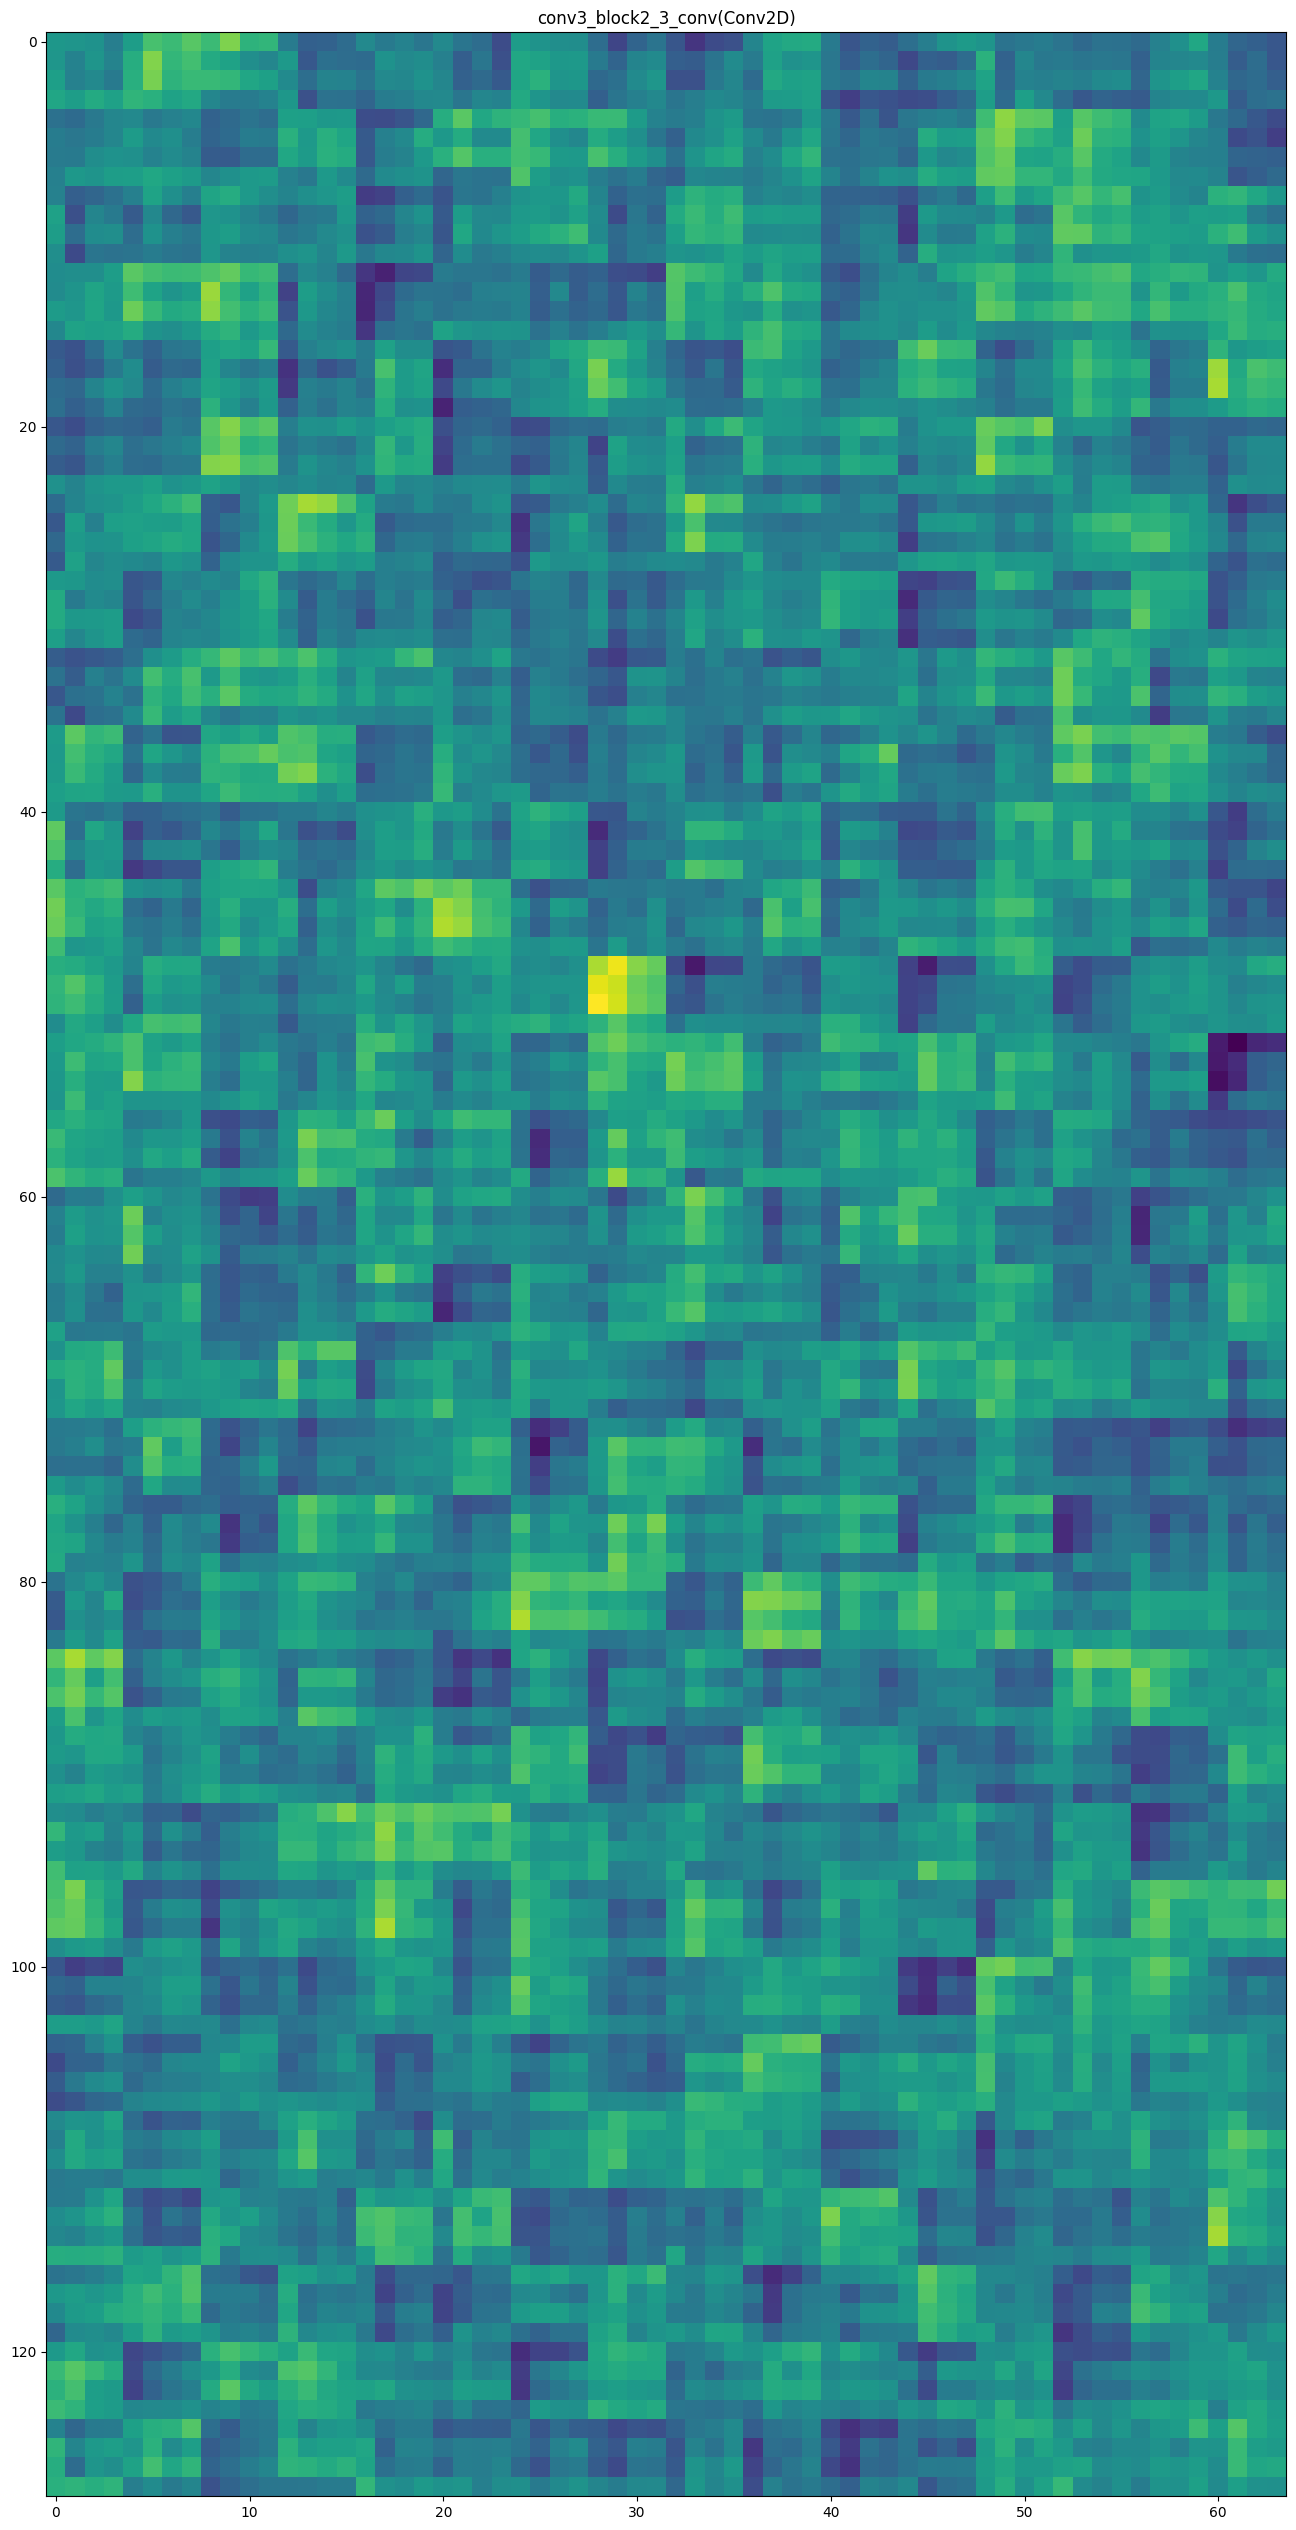

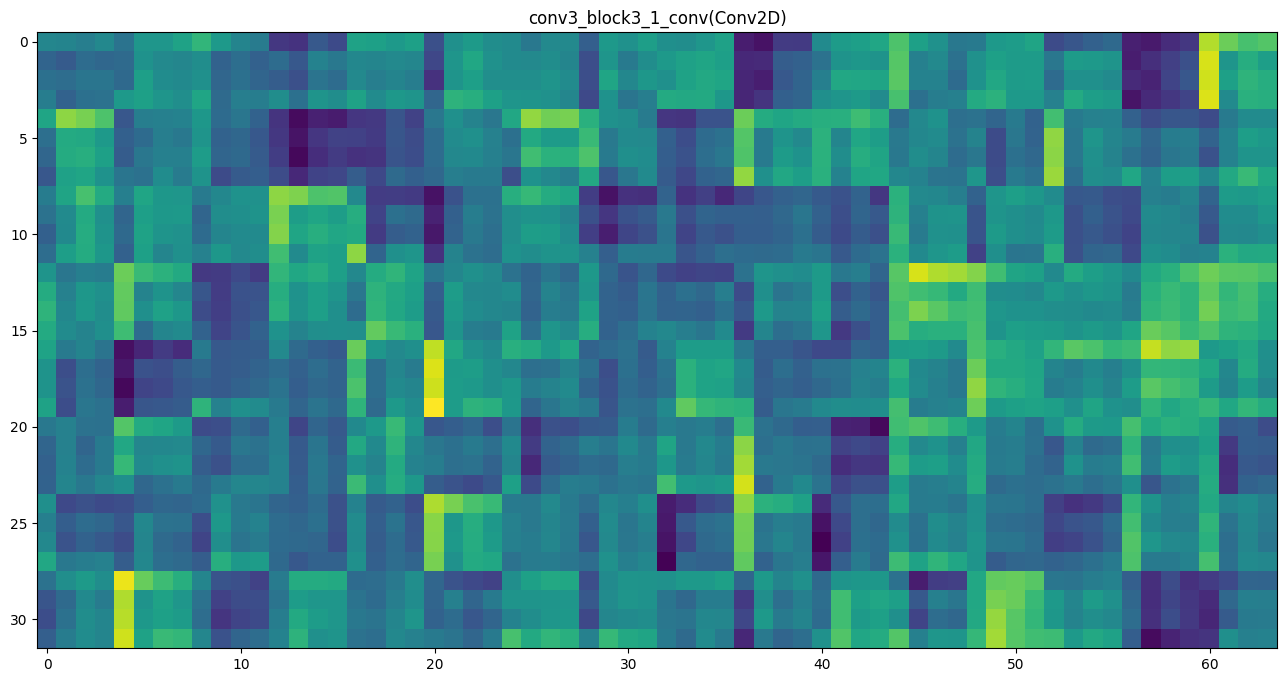

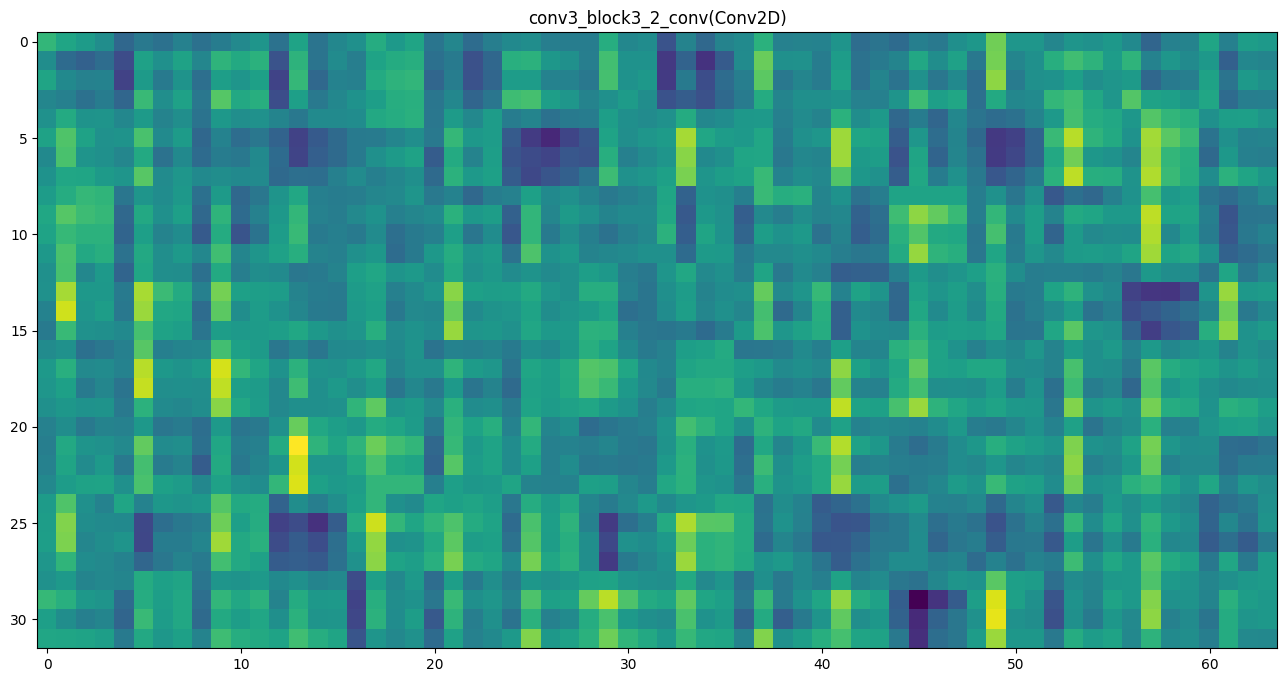

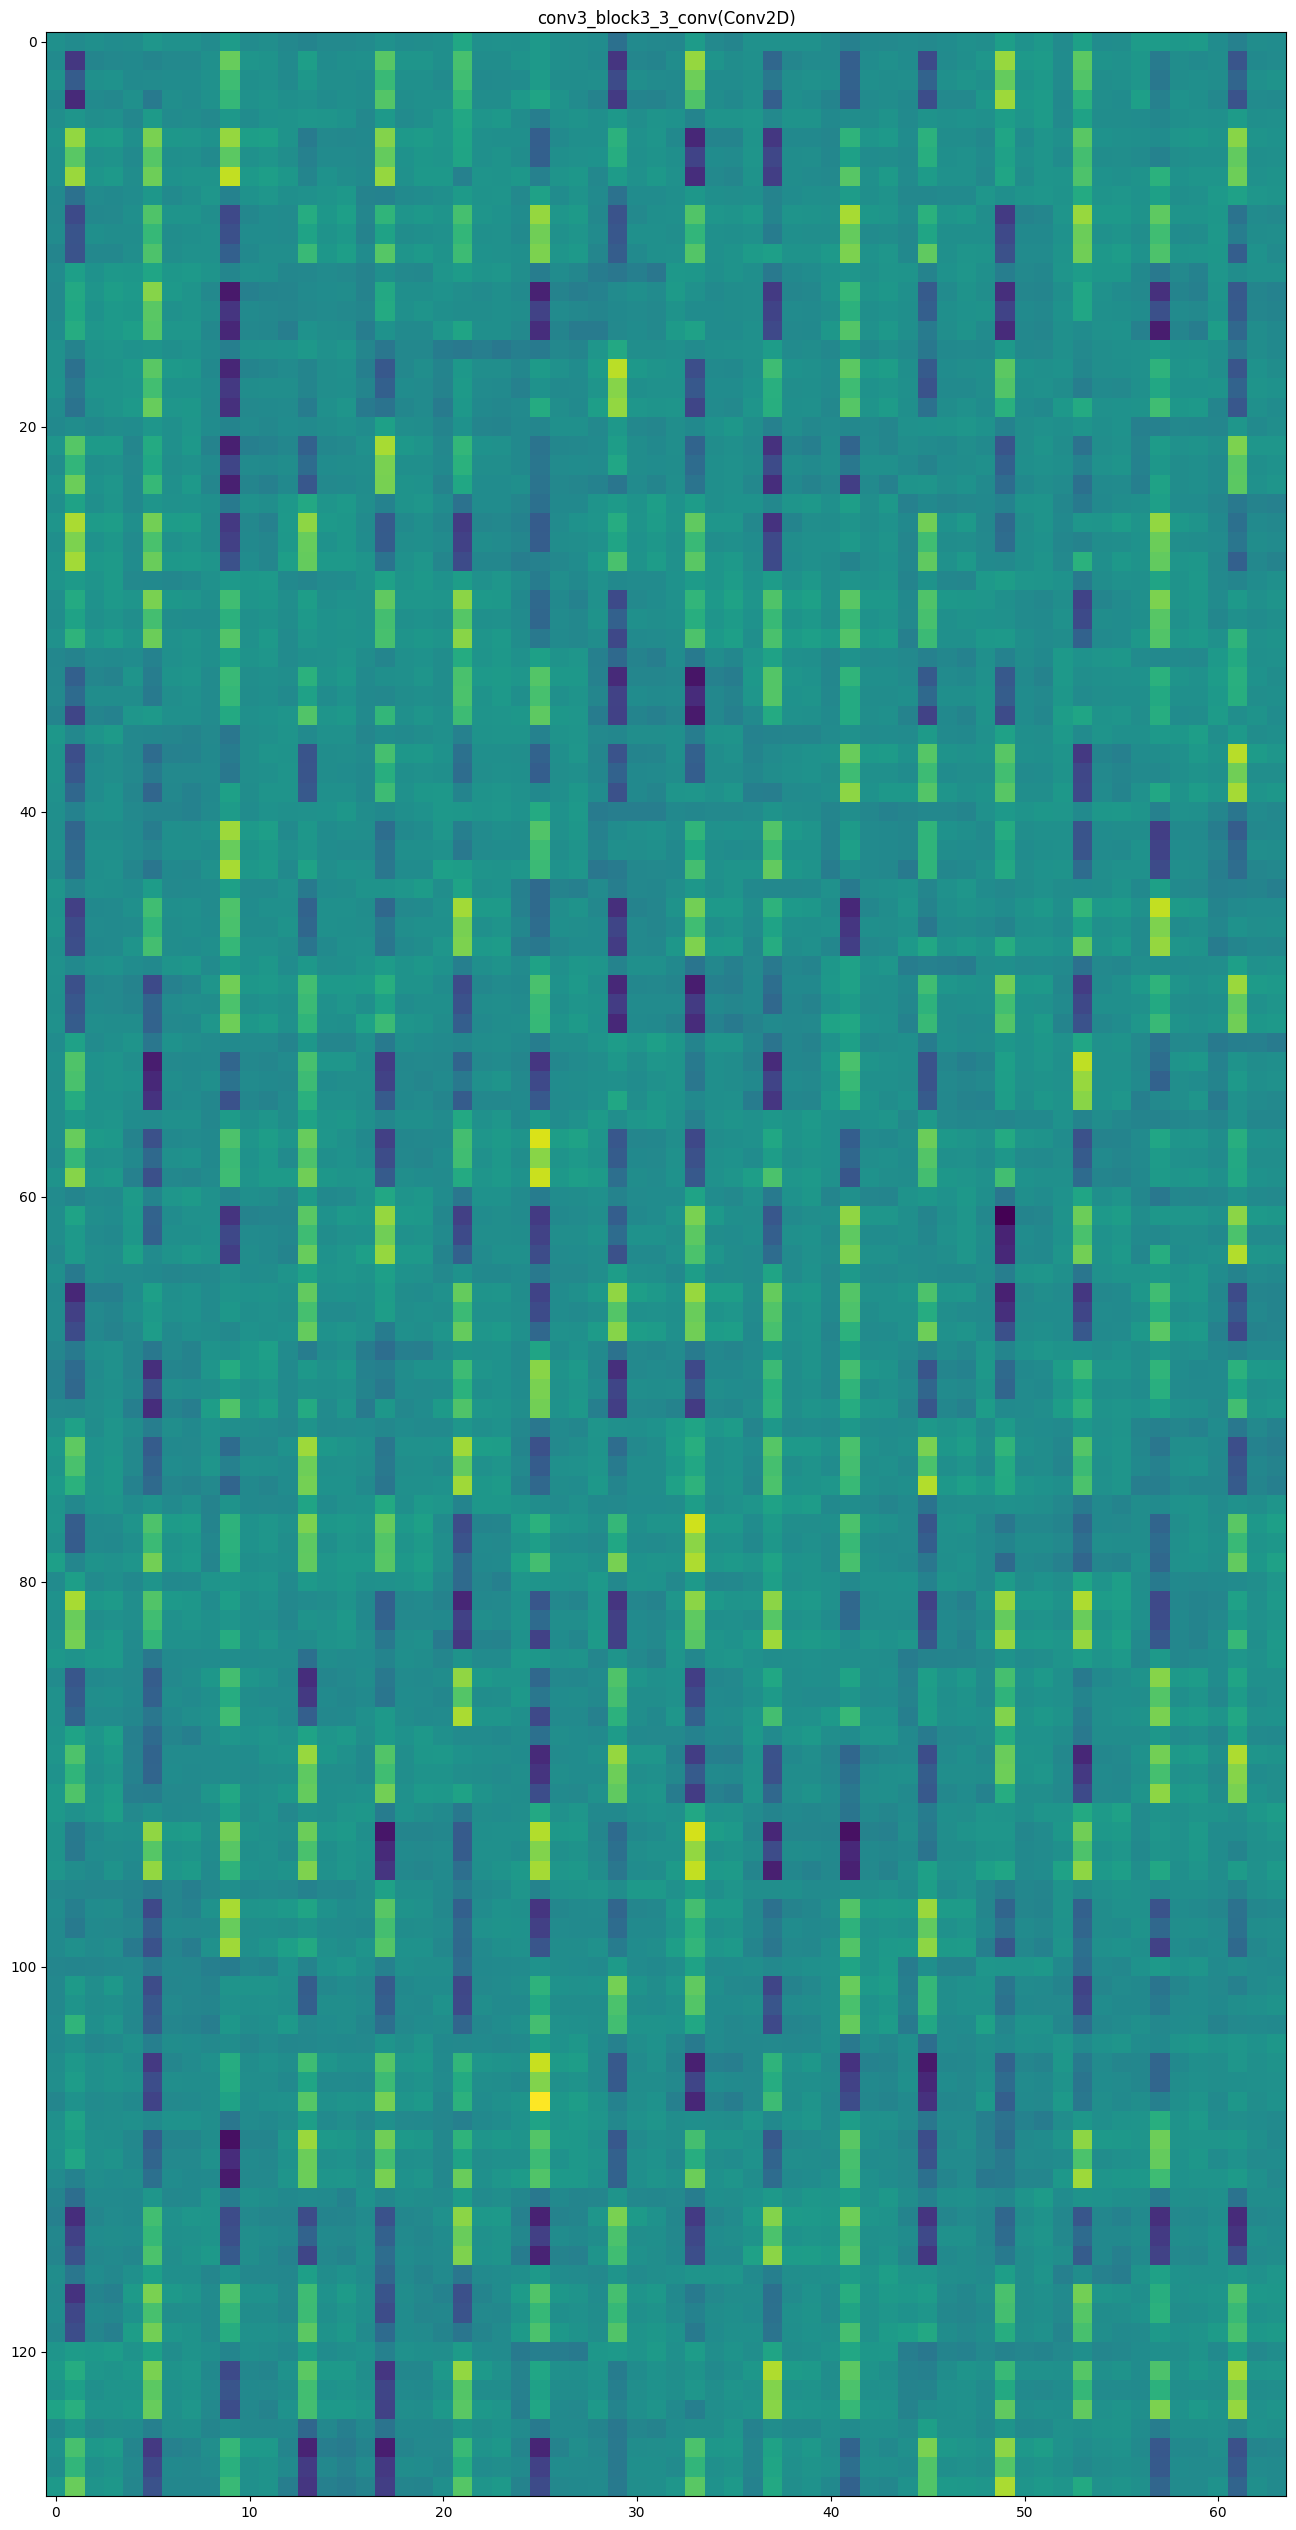

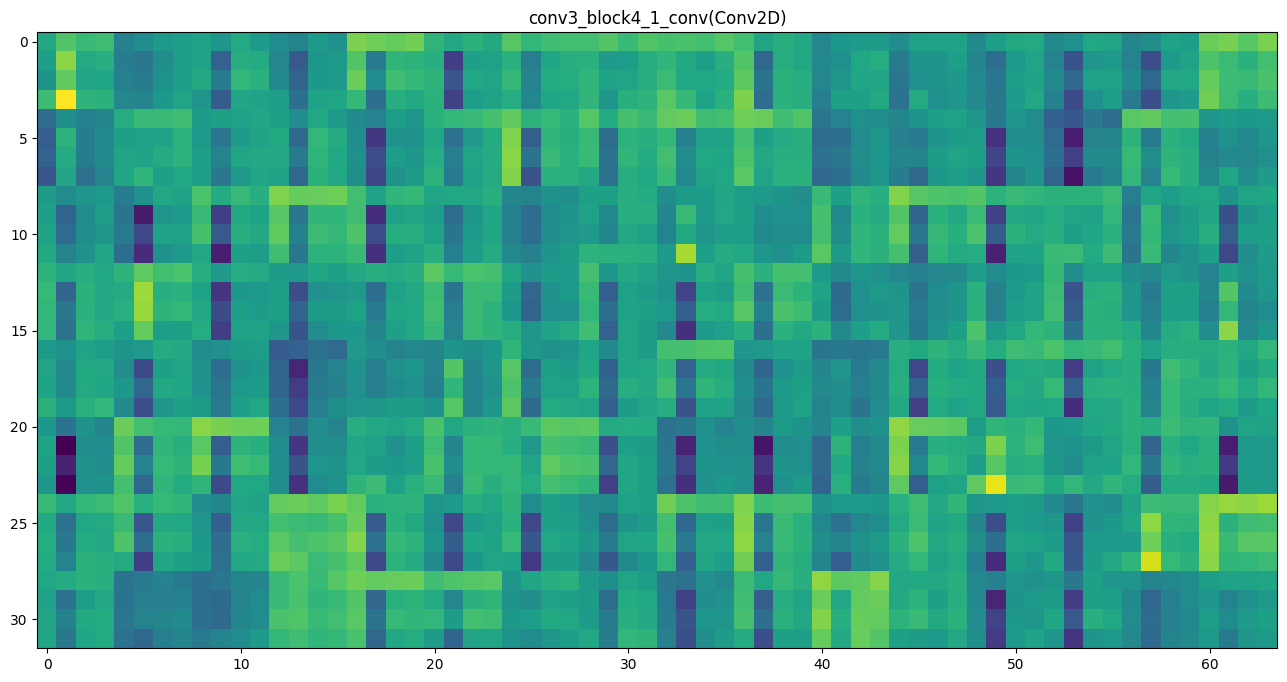

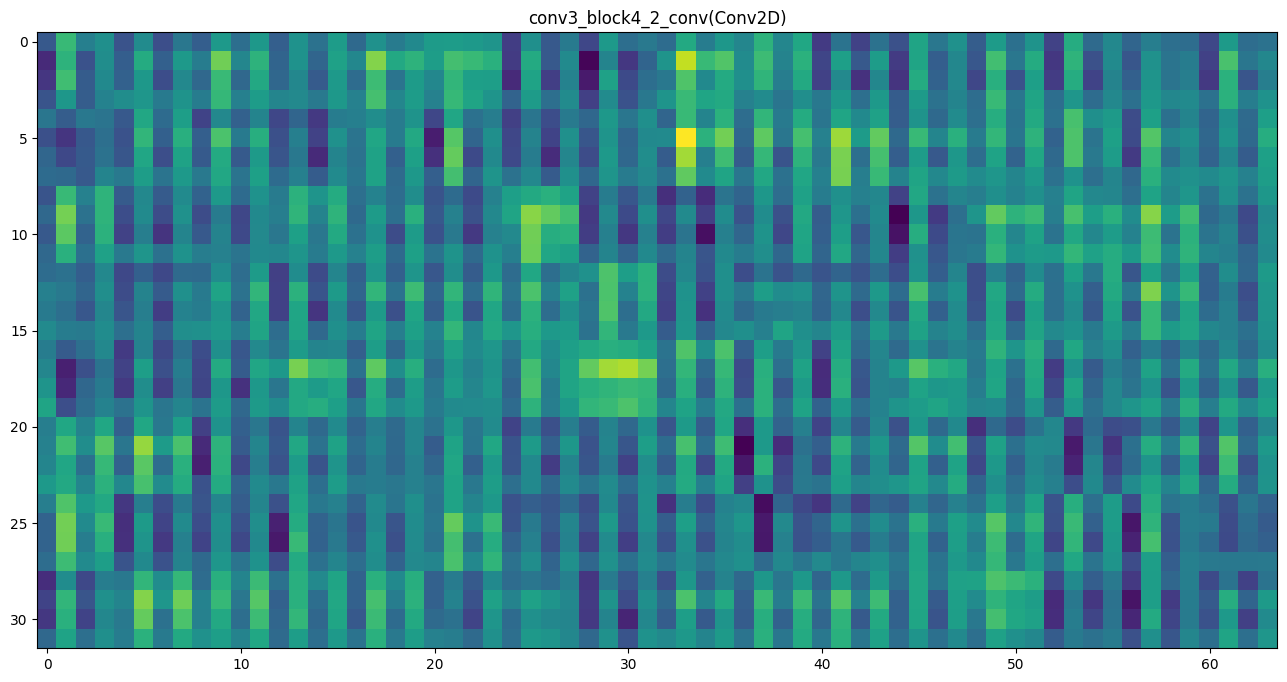

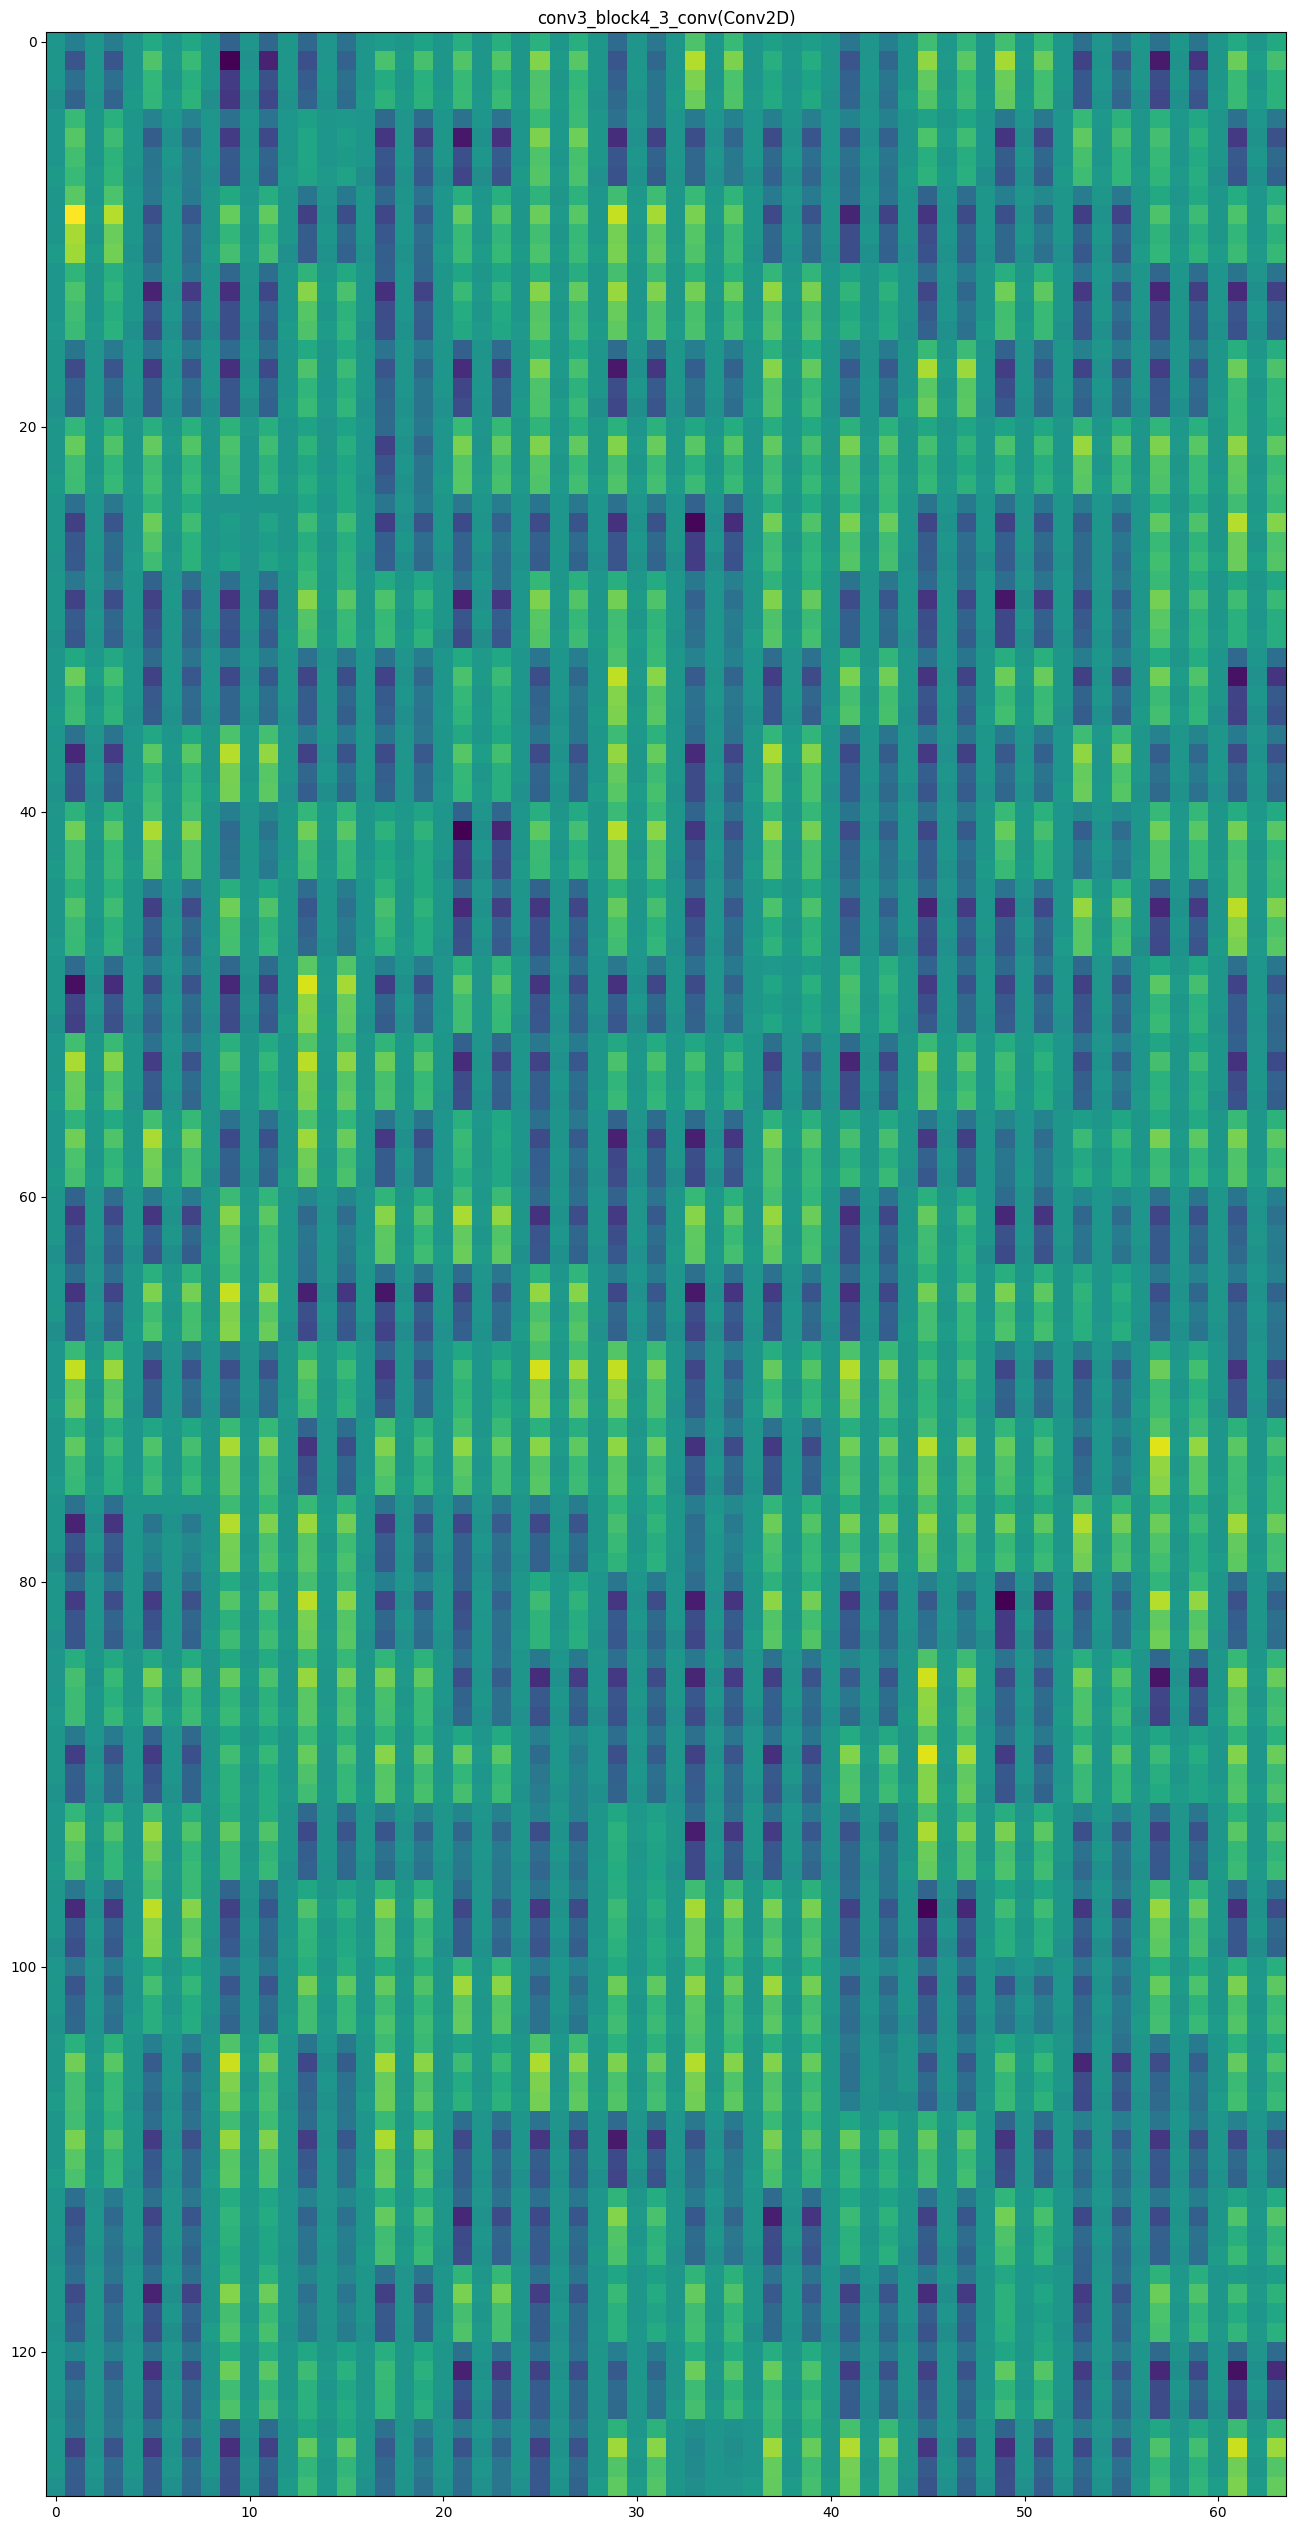

In [ ]:
#get the names of the layers
layer_names = get_layer_names(38, 78, before_model)

#plot feature maps
plot_feature_map(layer_names, activations)

covnet outputs of fifth block

In [ ]:
# Extracts the outputs of Block 5
layer_outputs = [layer.output for layer in before_model.layers[141:172]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=before_model.input, outputs=layer_outputs)
activations = activation_model.predict(ship_img_tensor)

1/1 [==============================] - 2s 2s/step


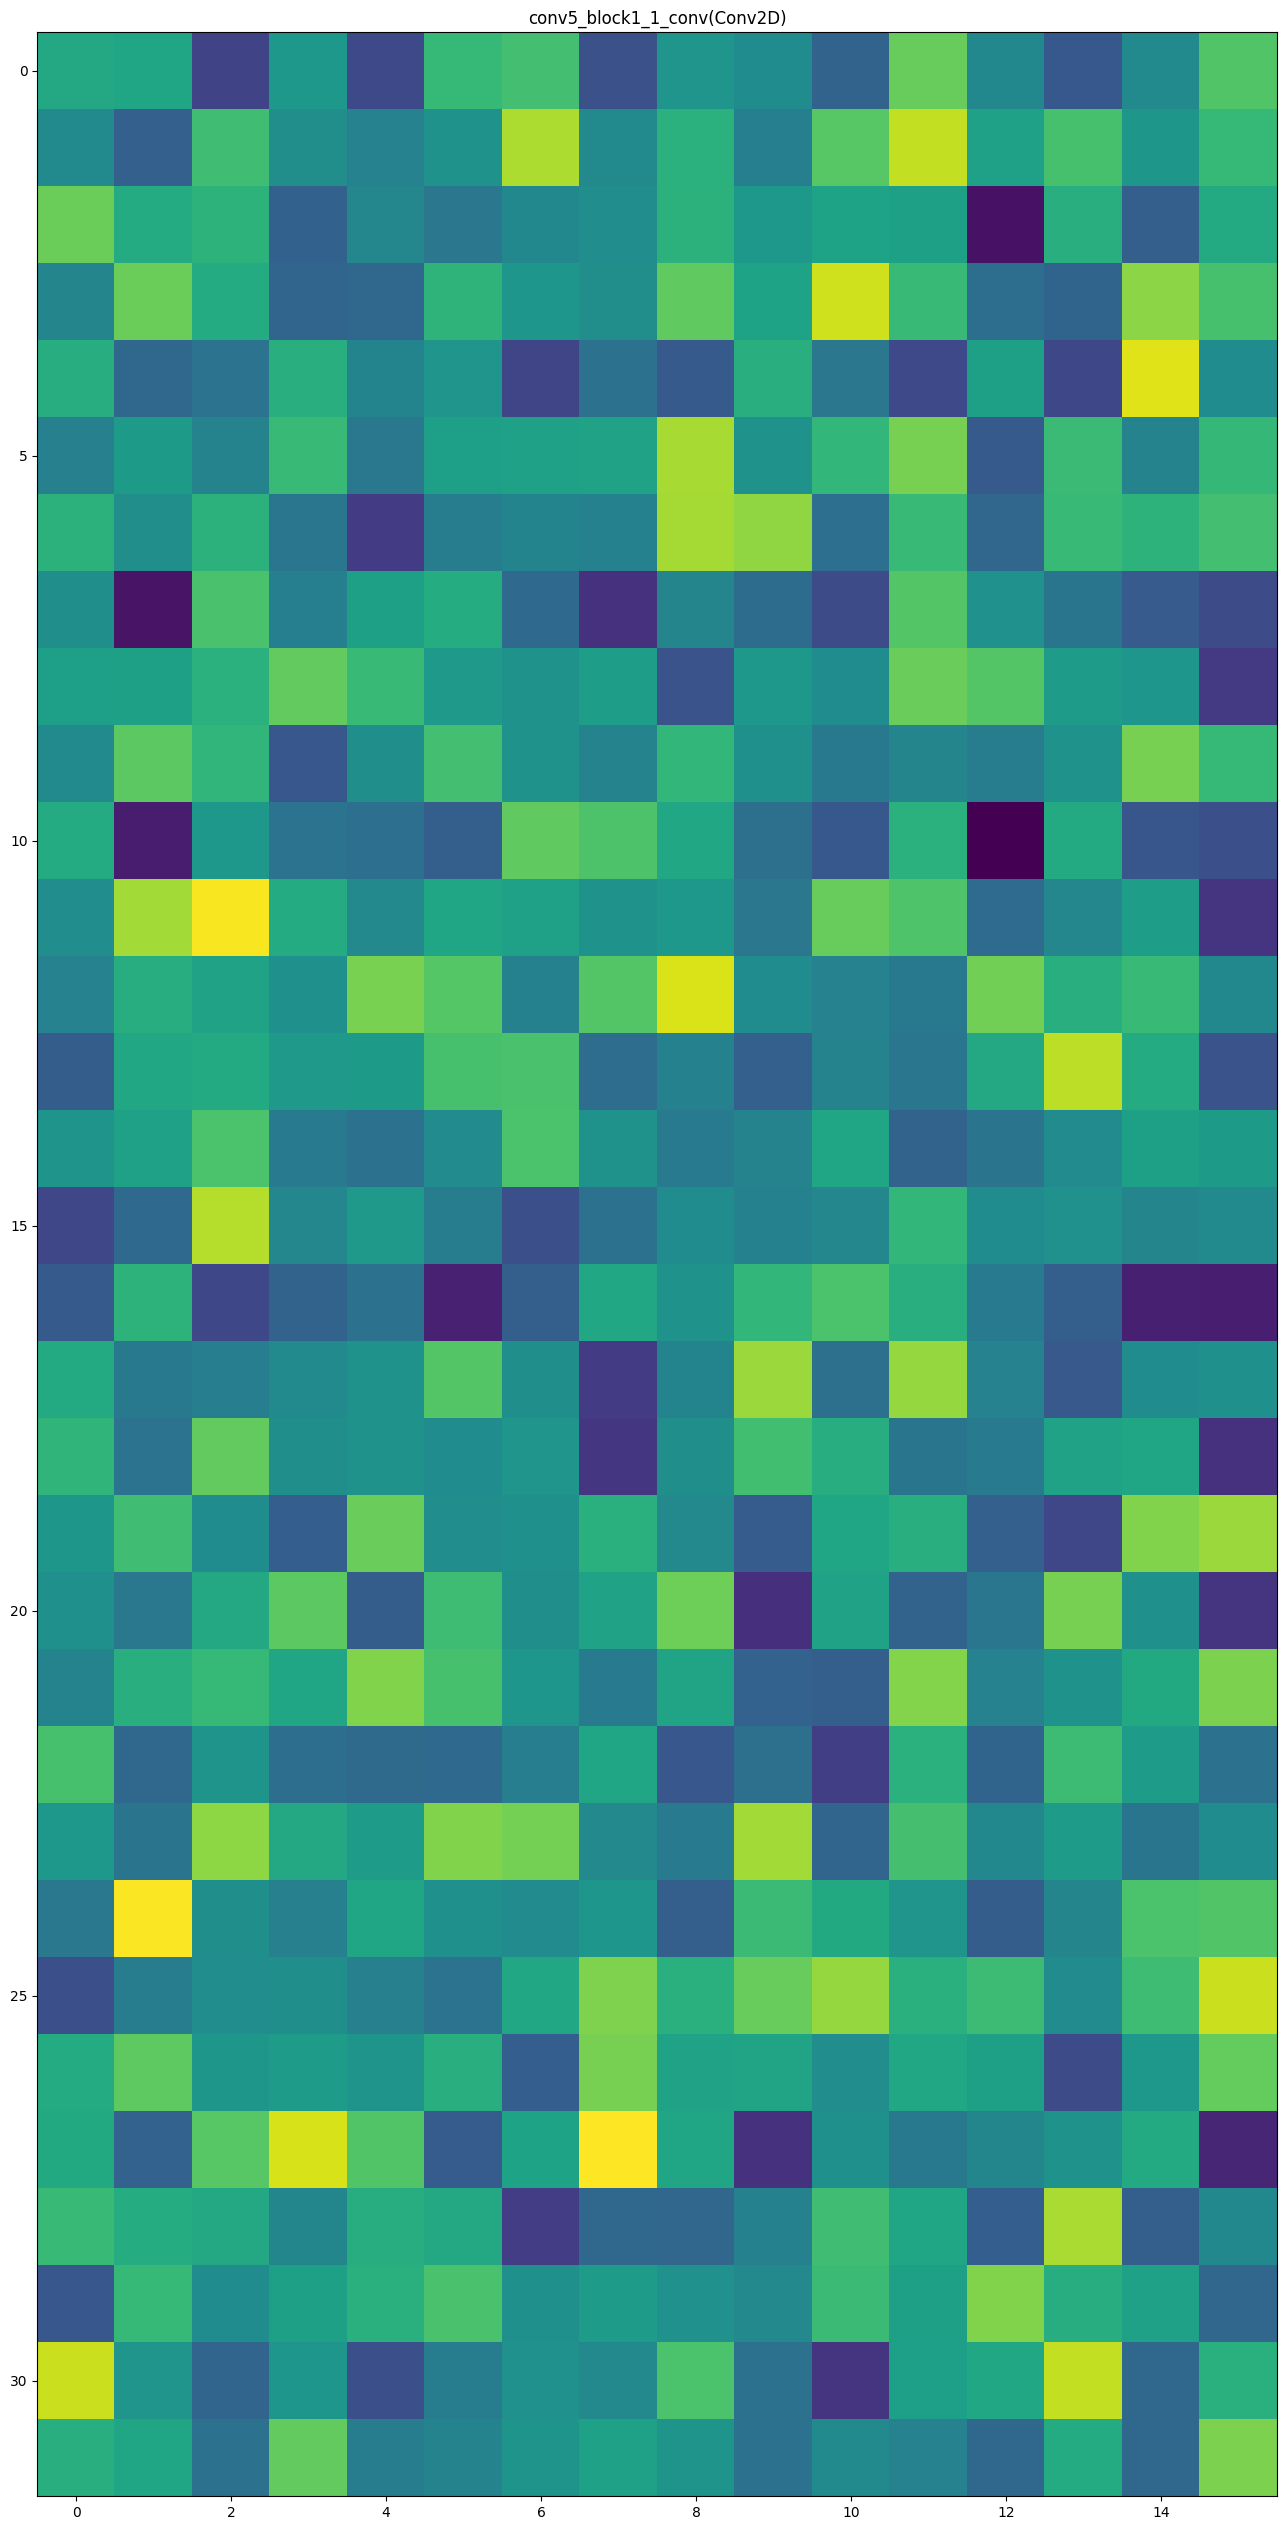

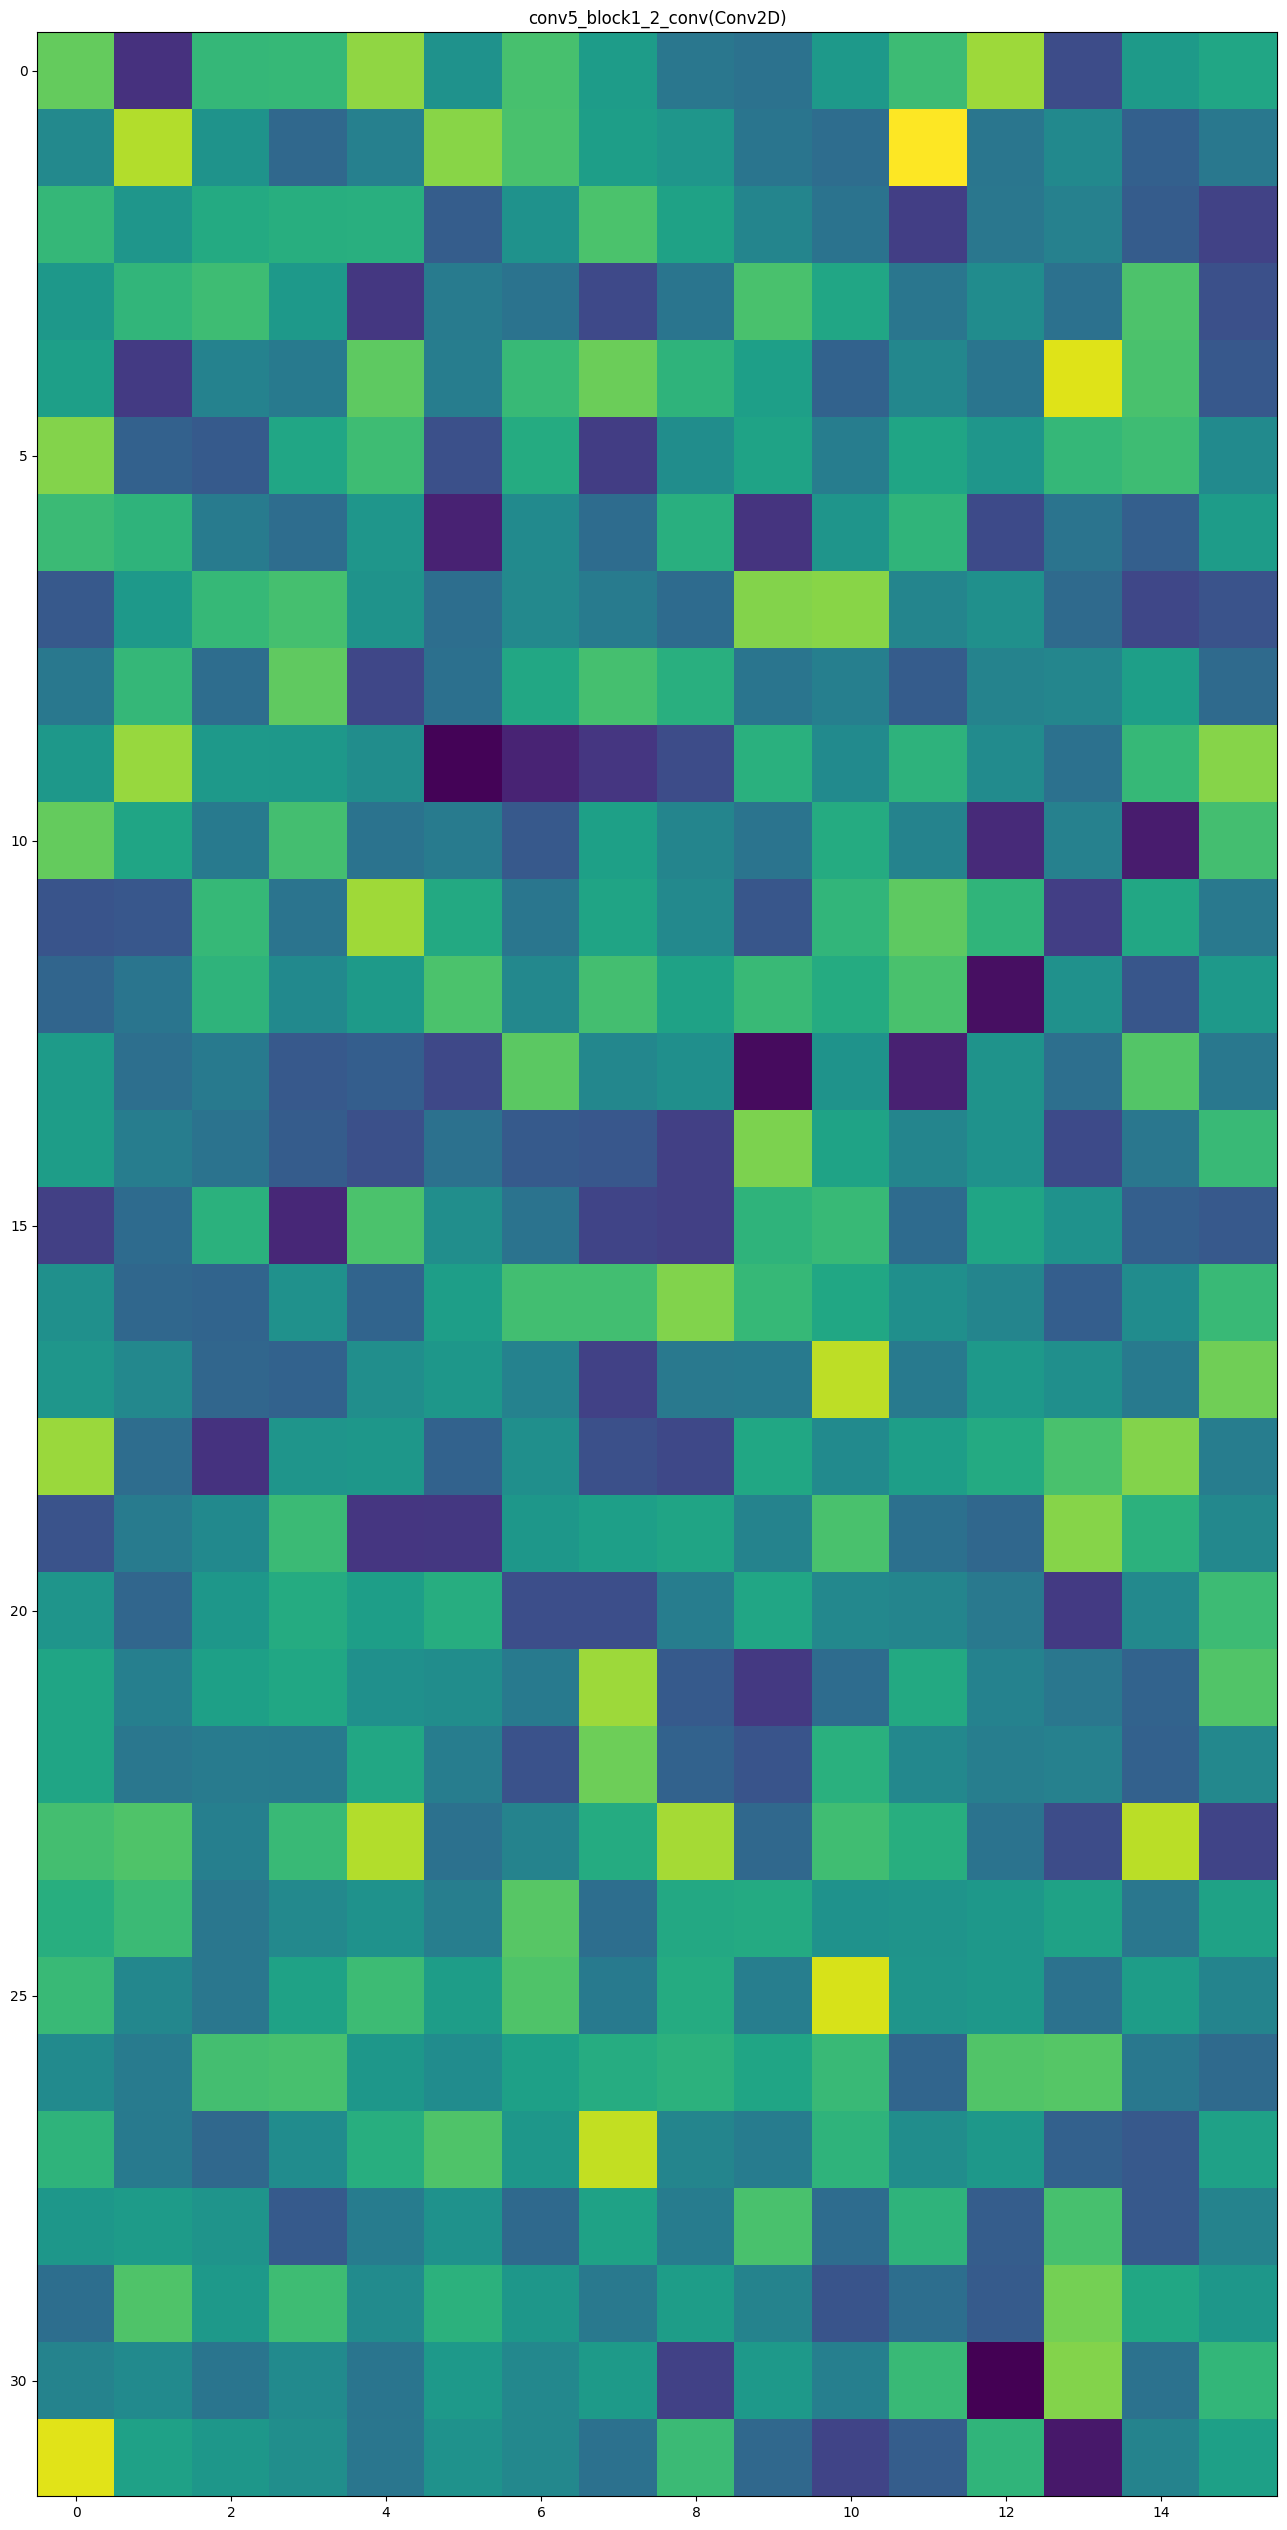

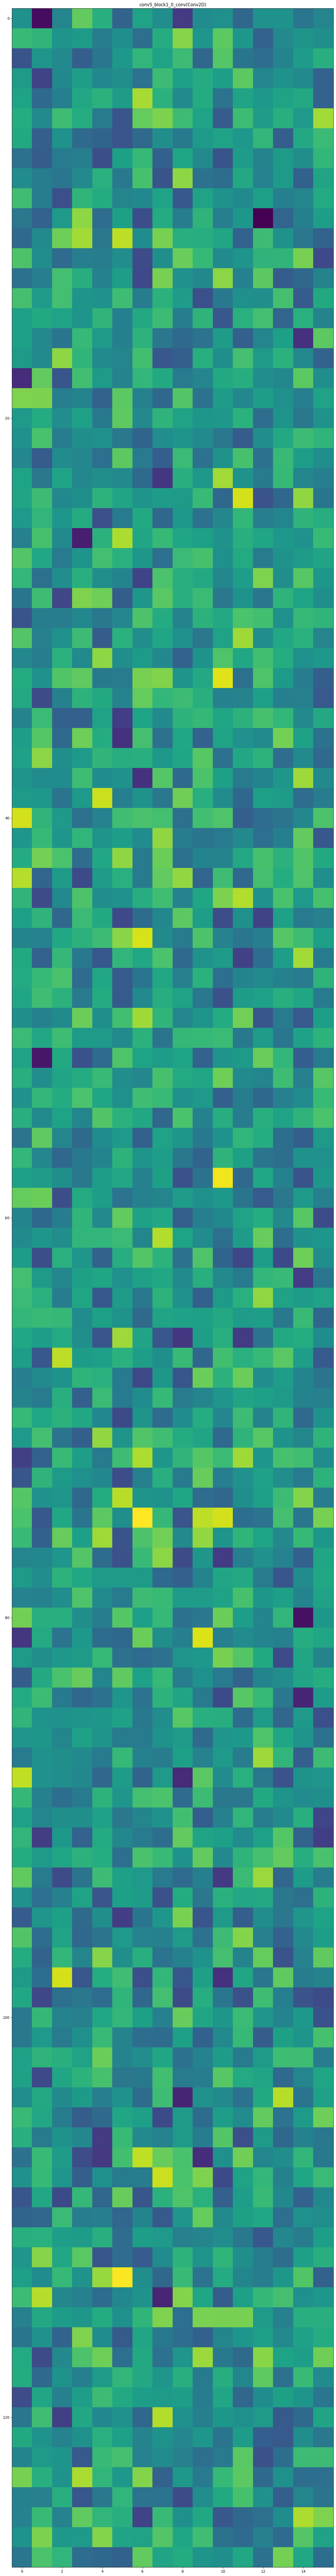

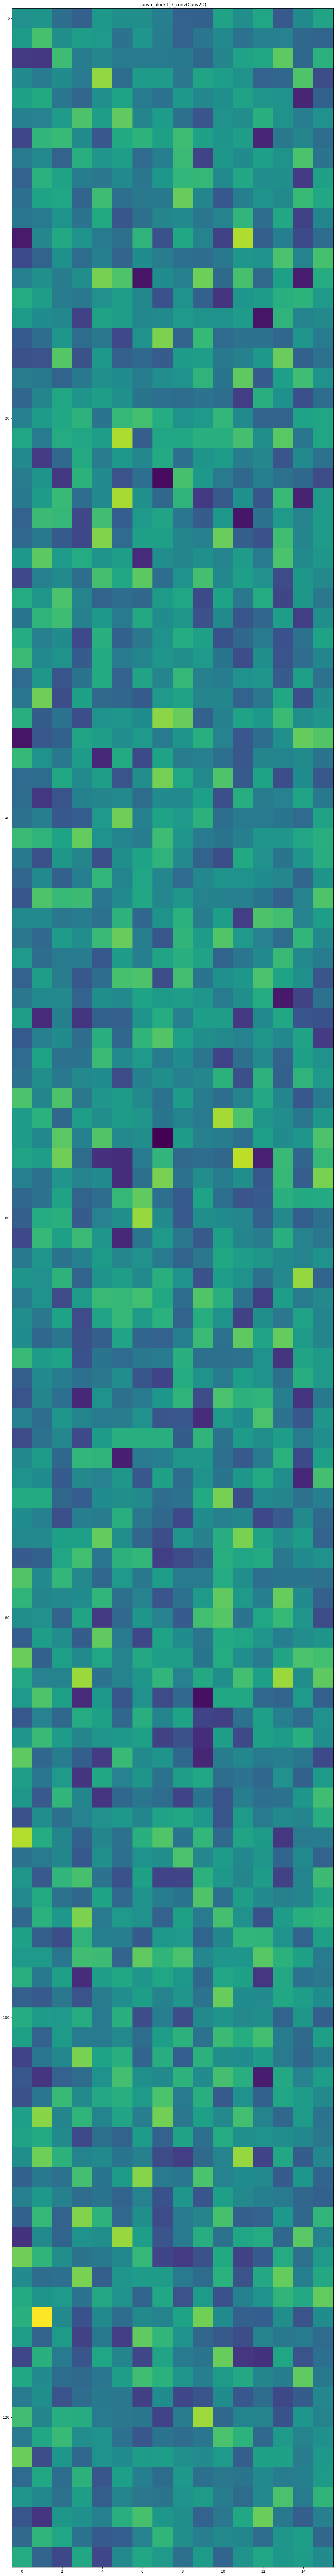

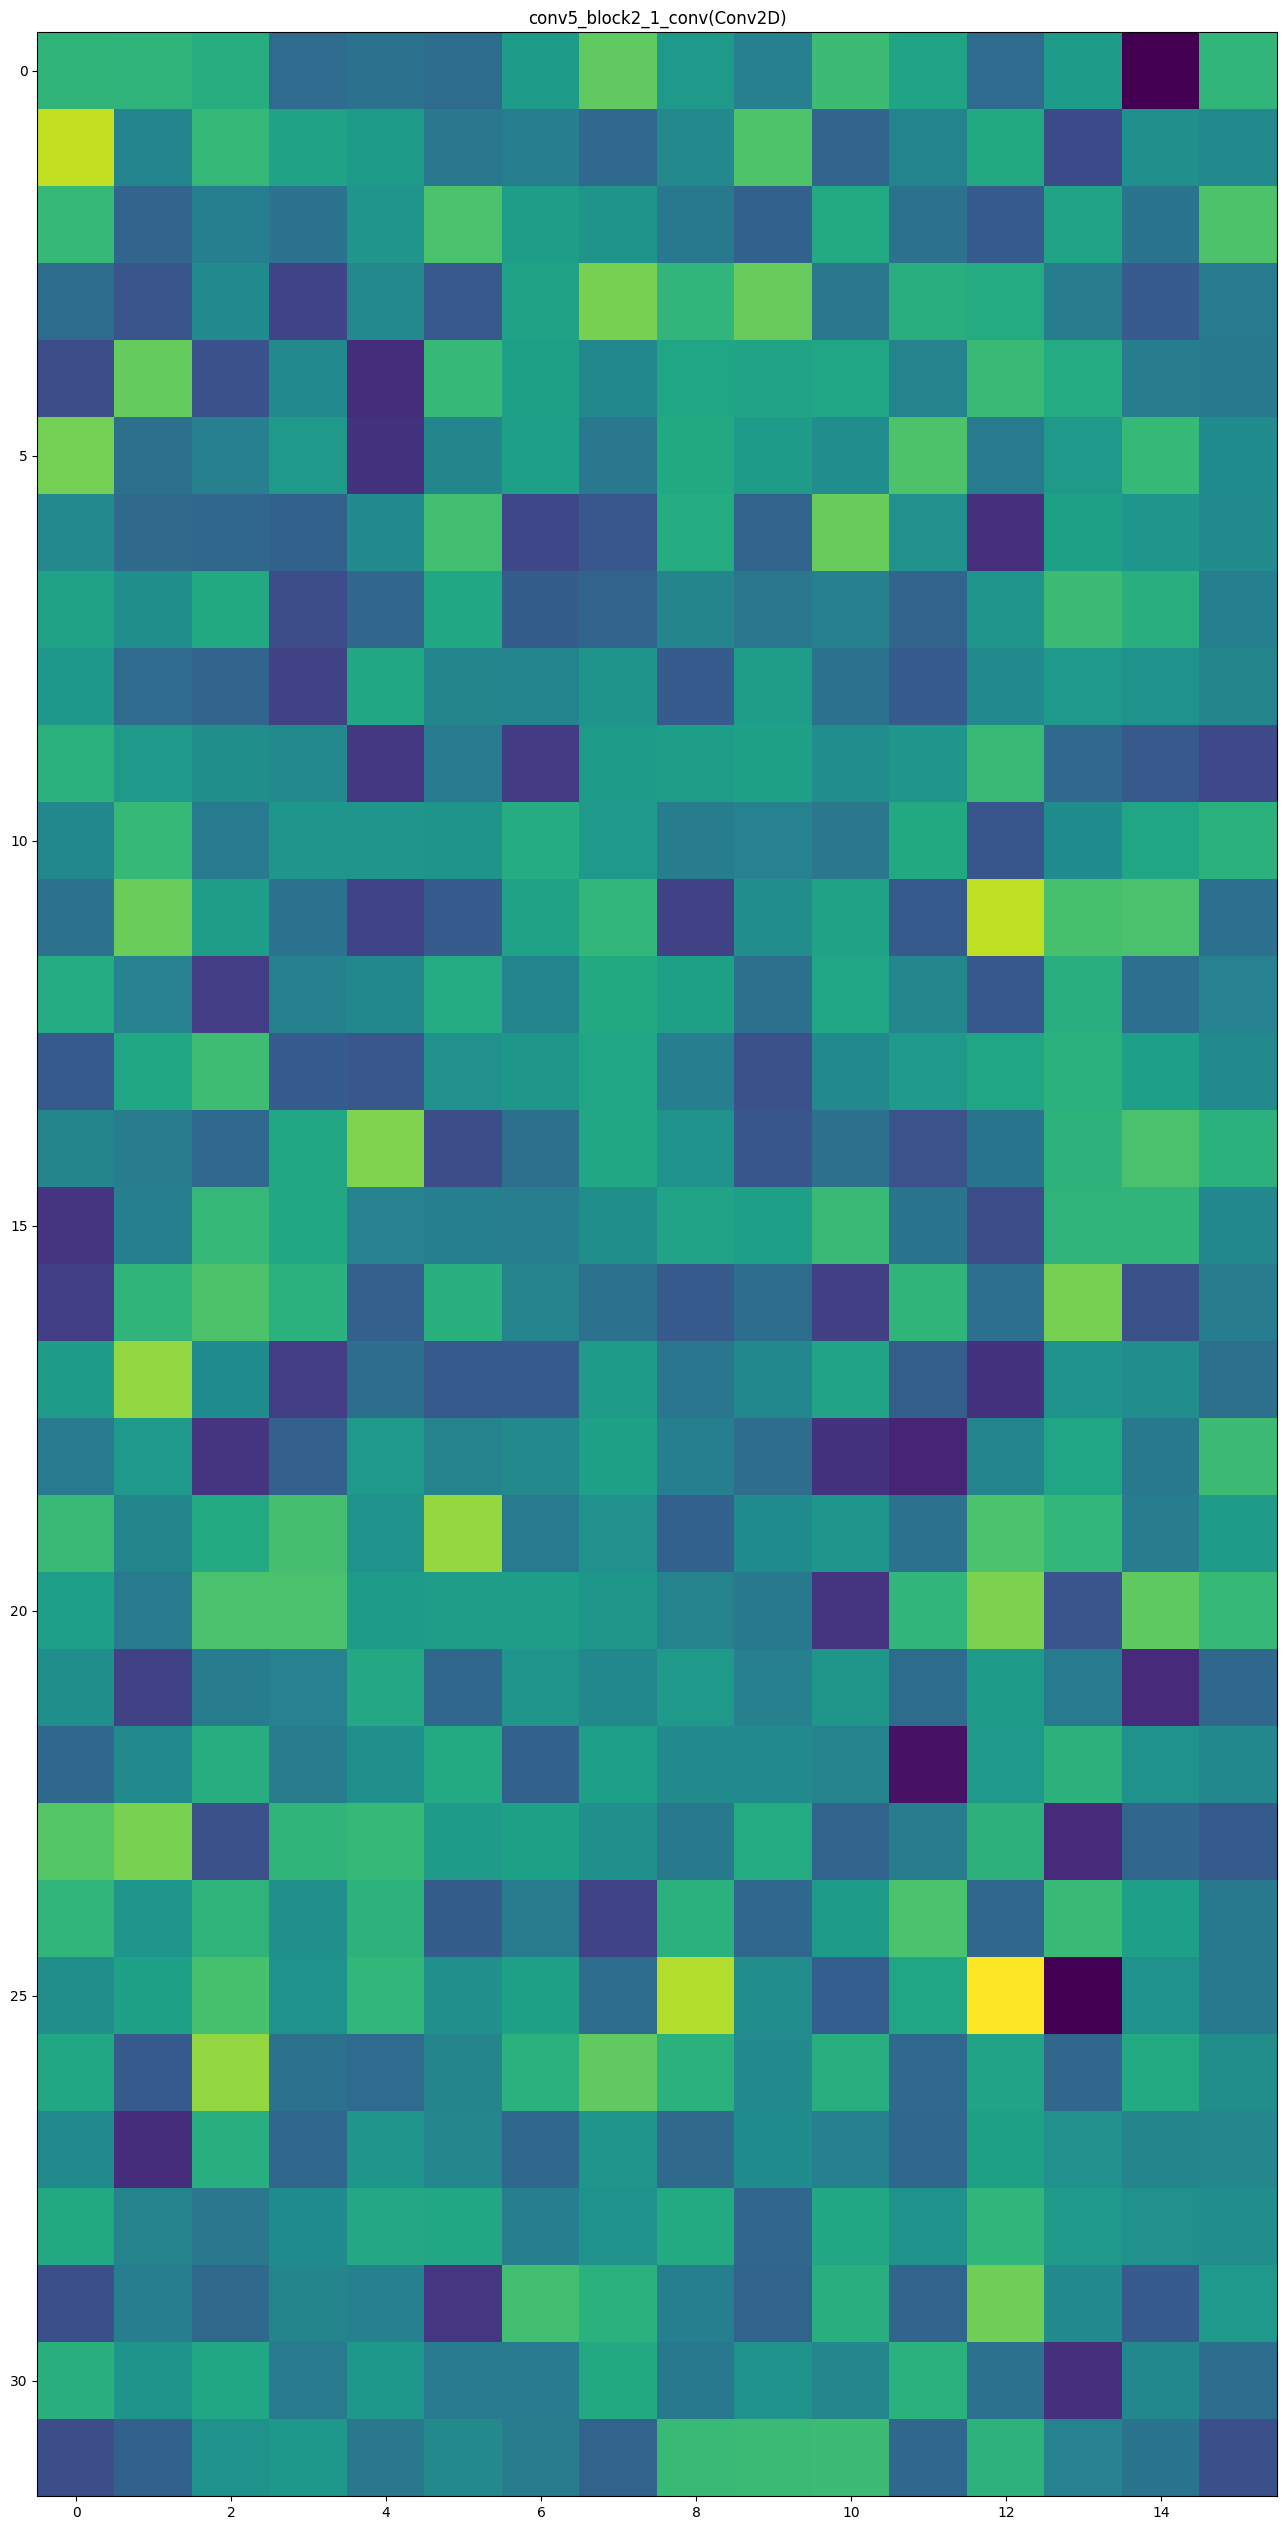

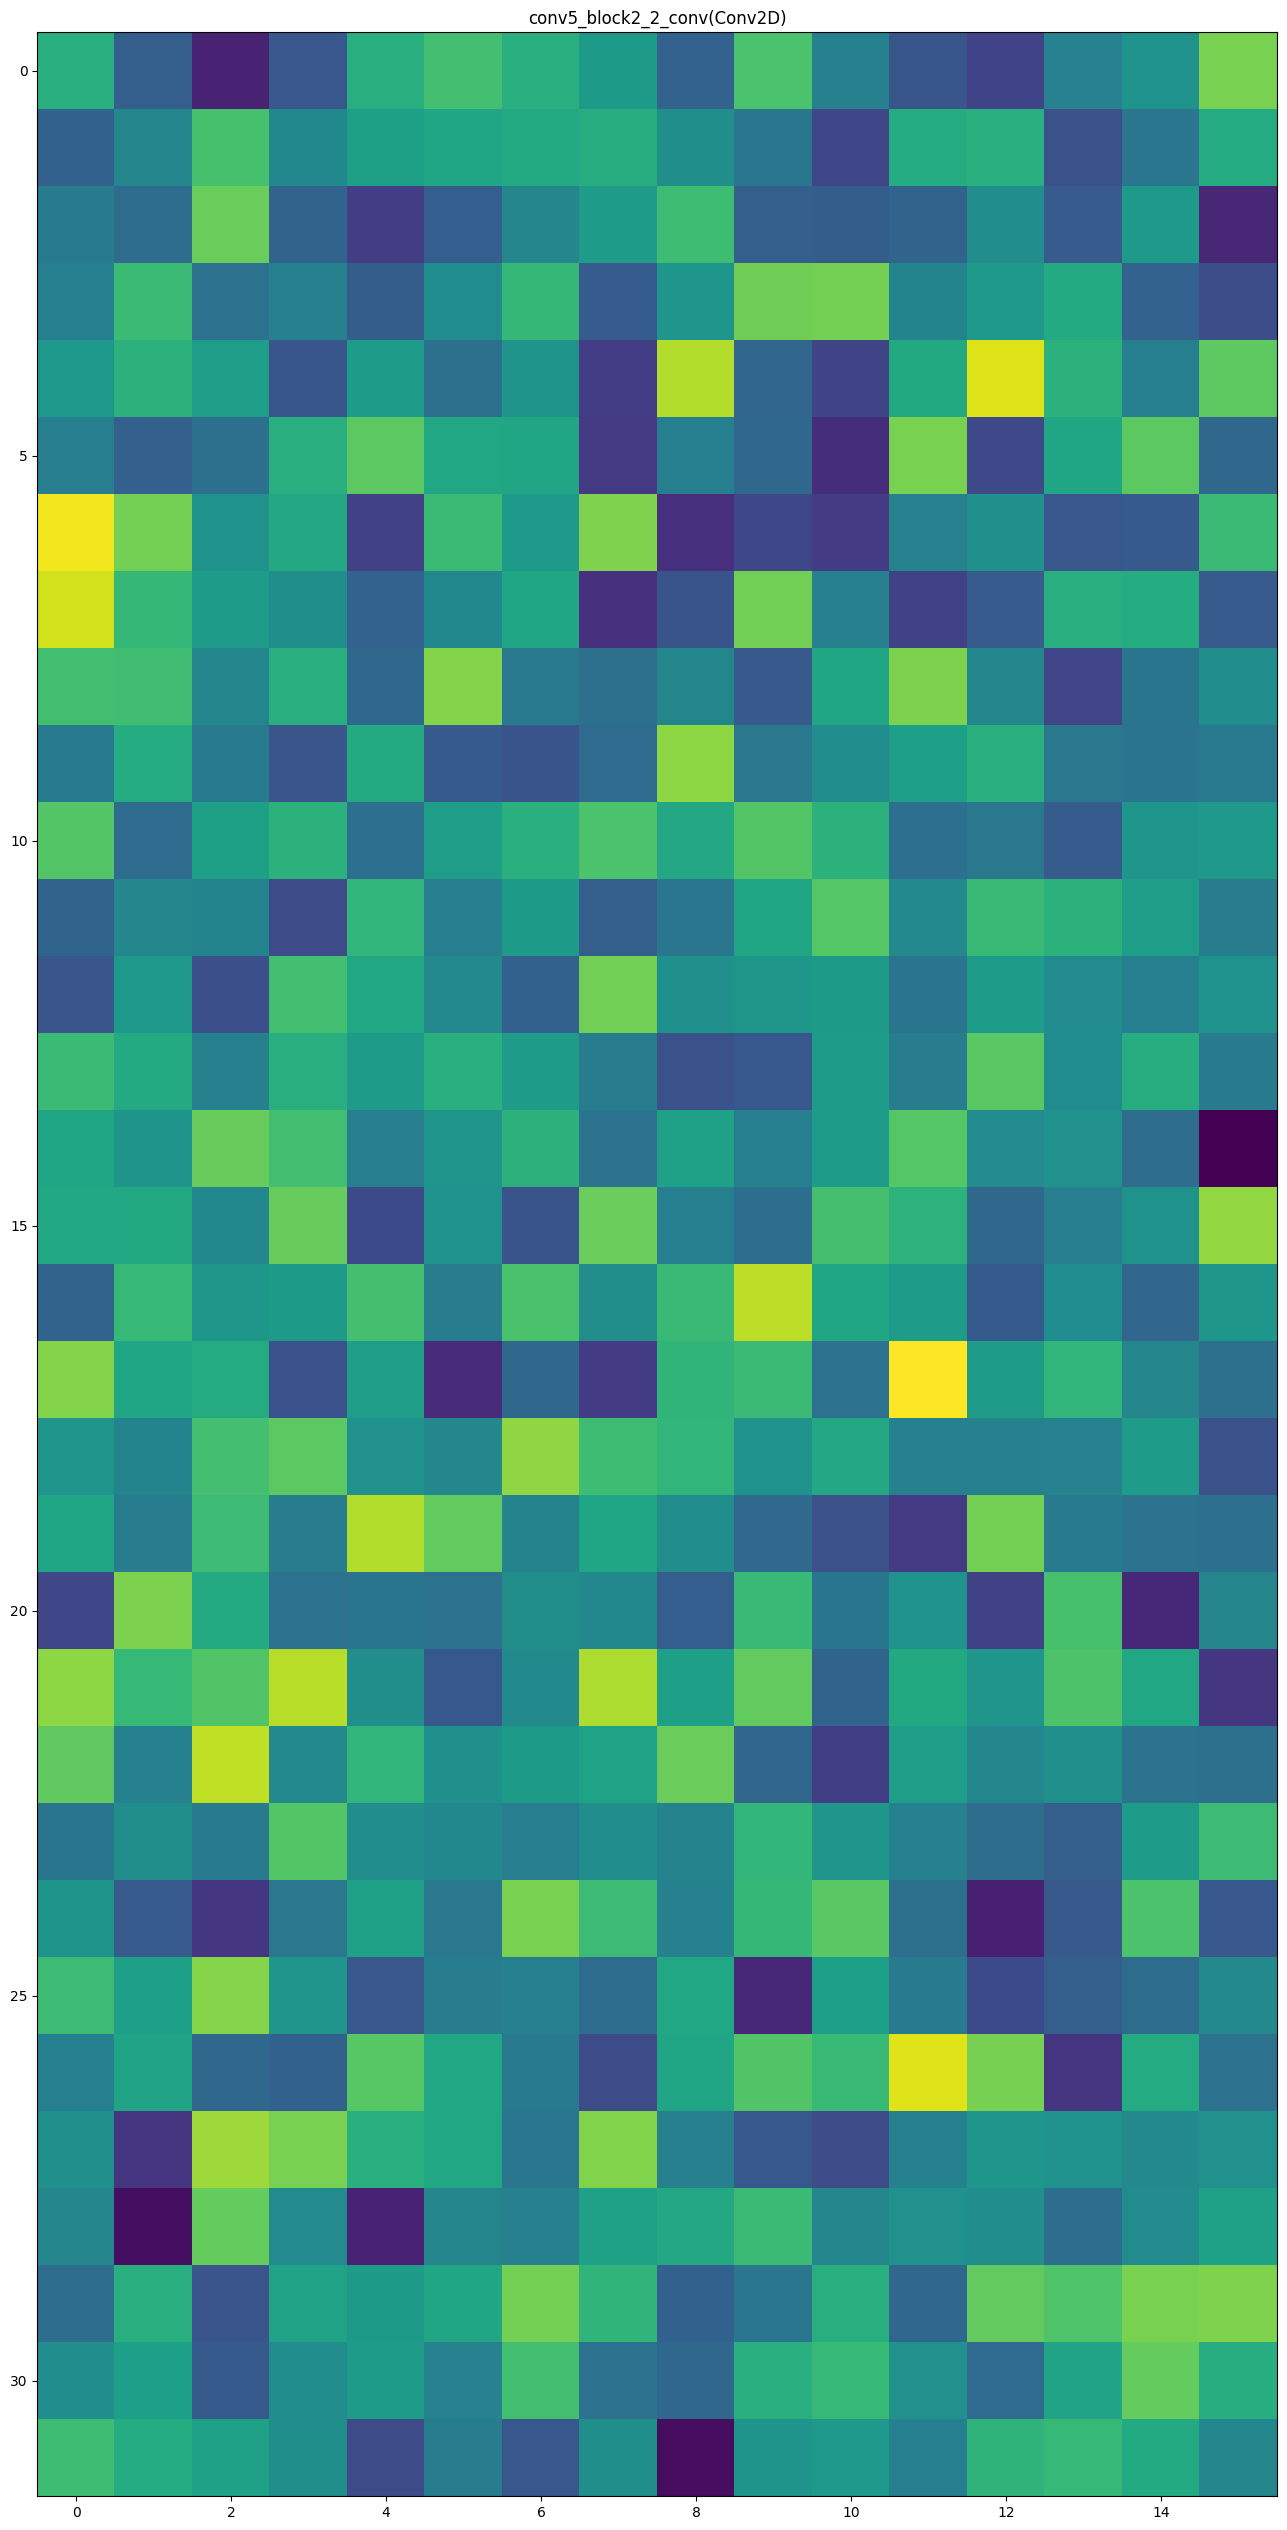

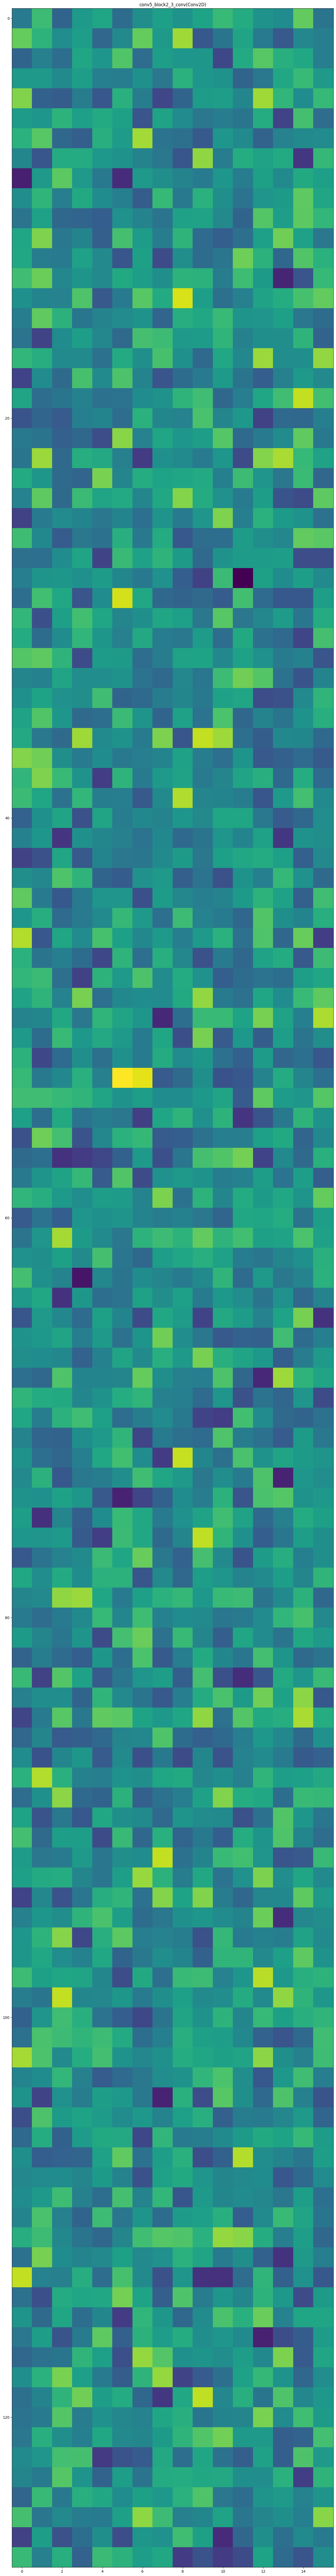

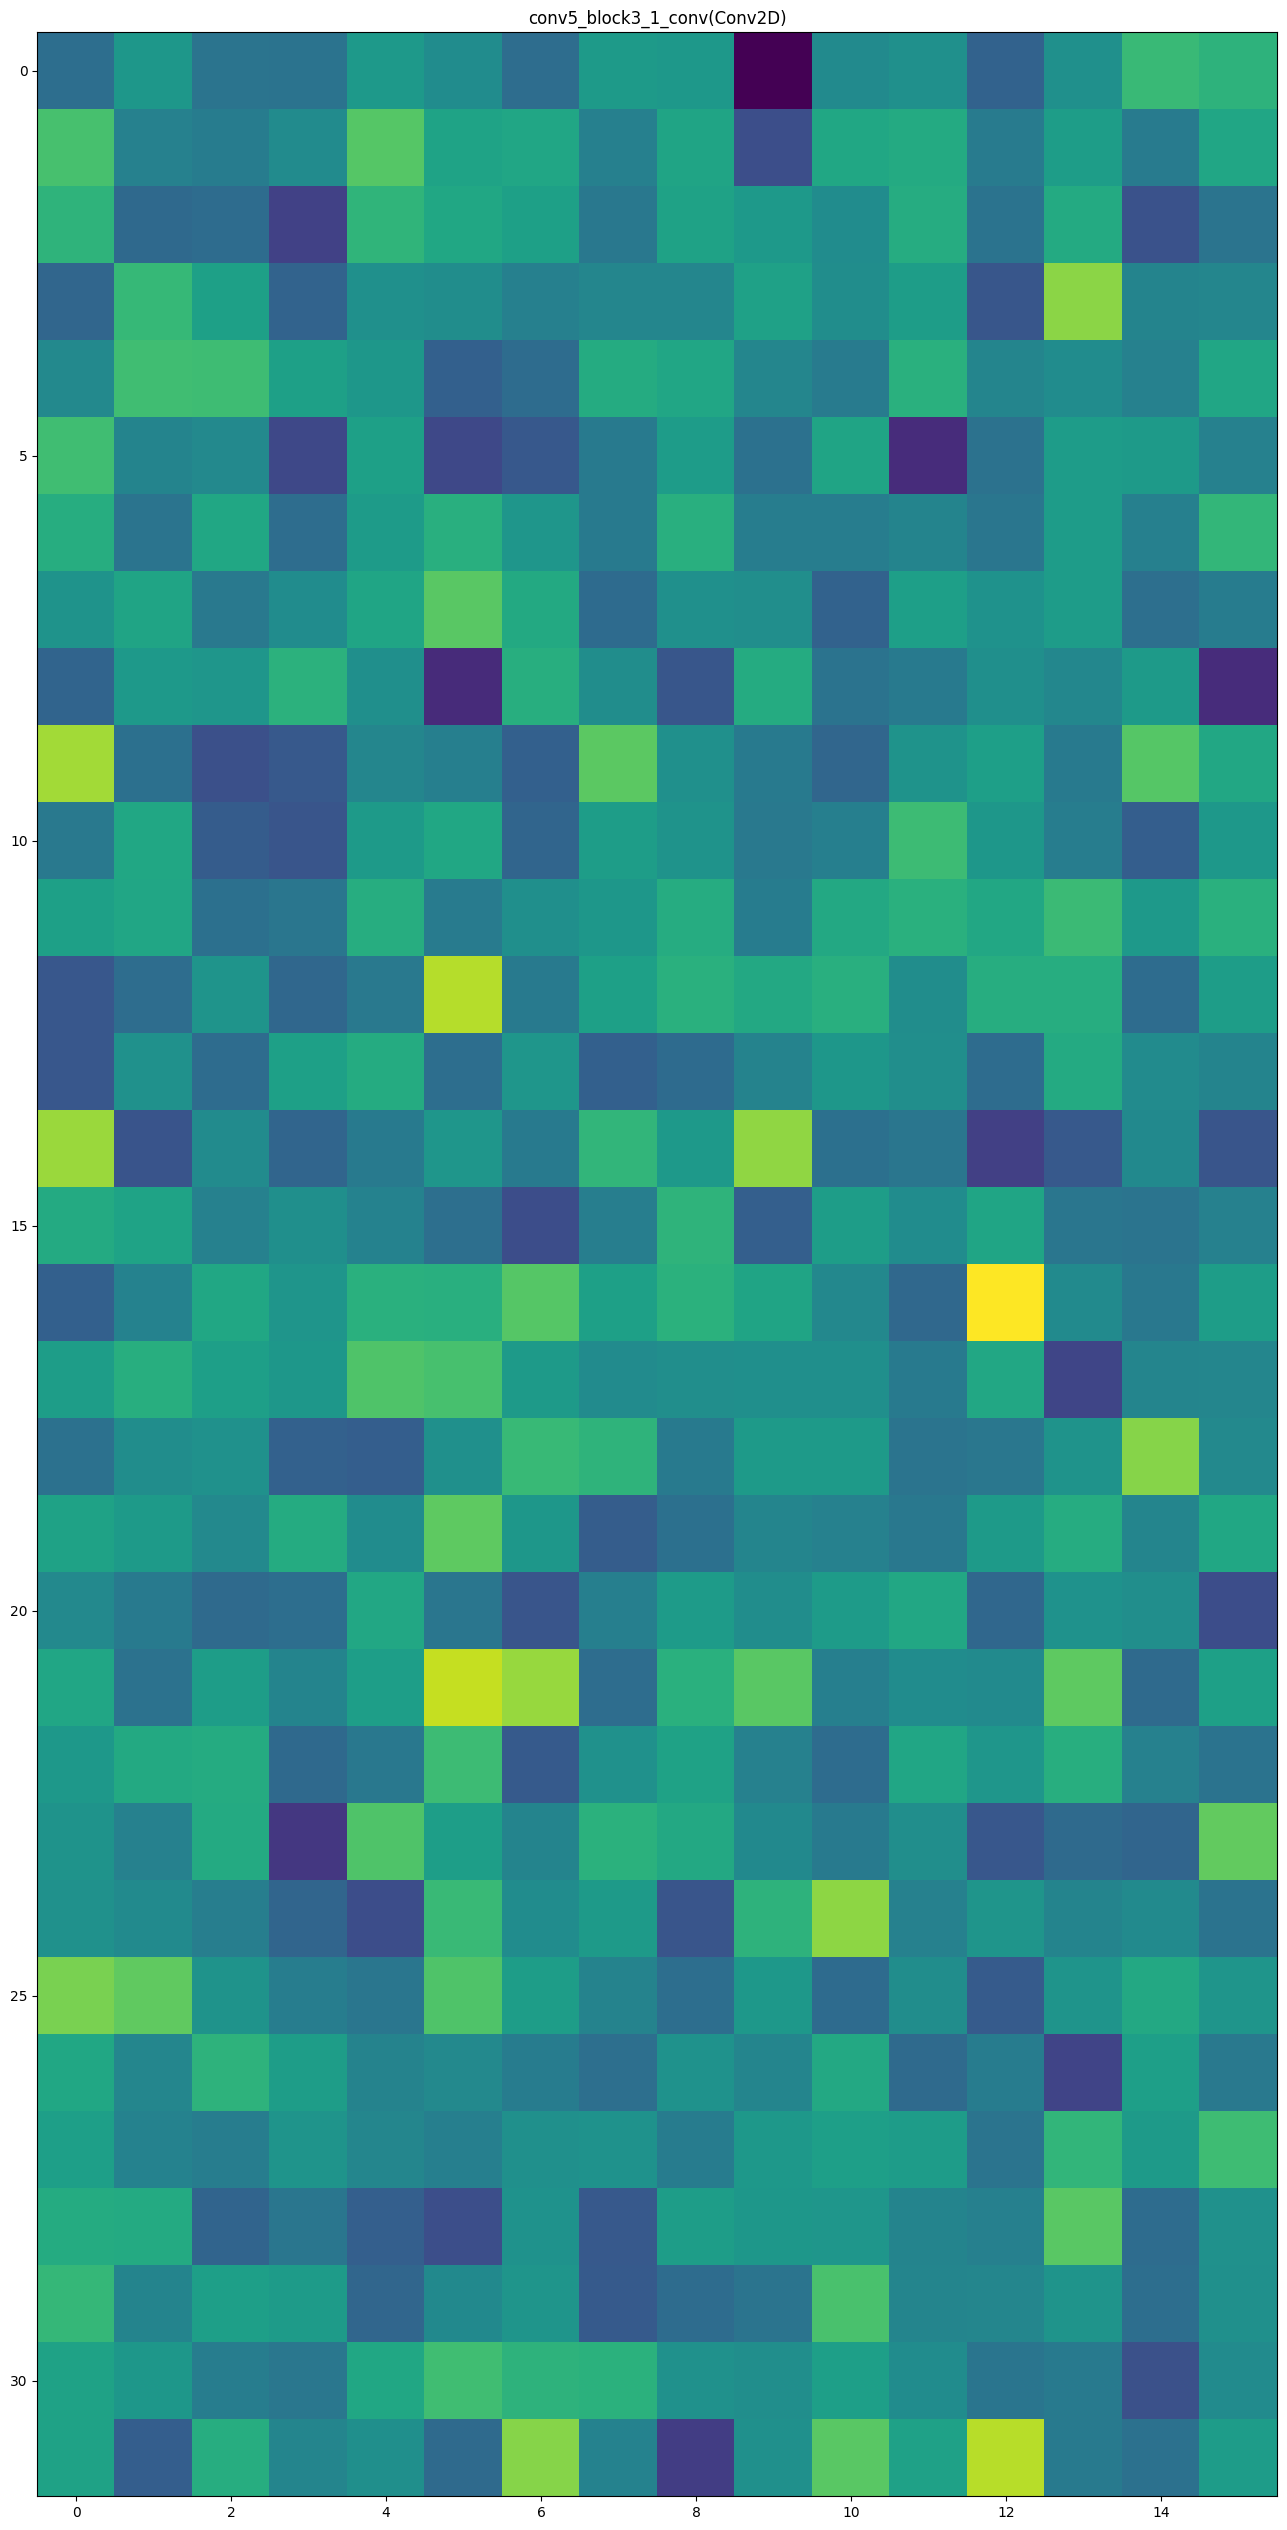

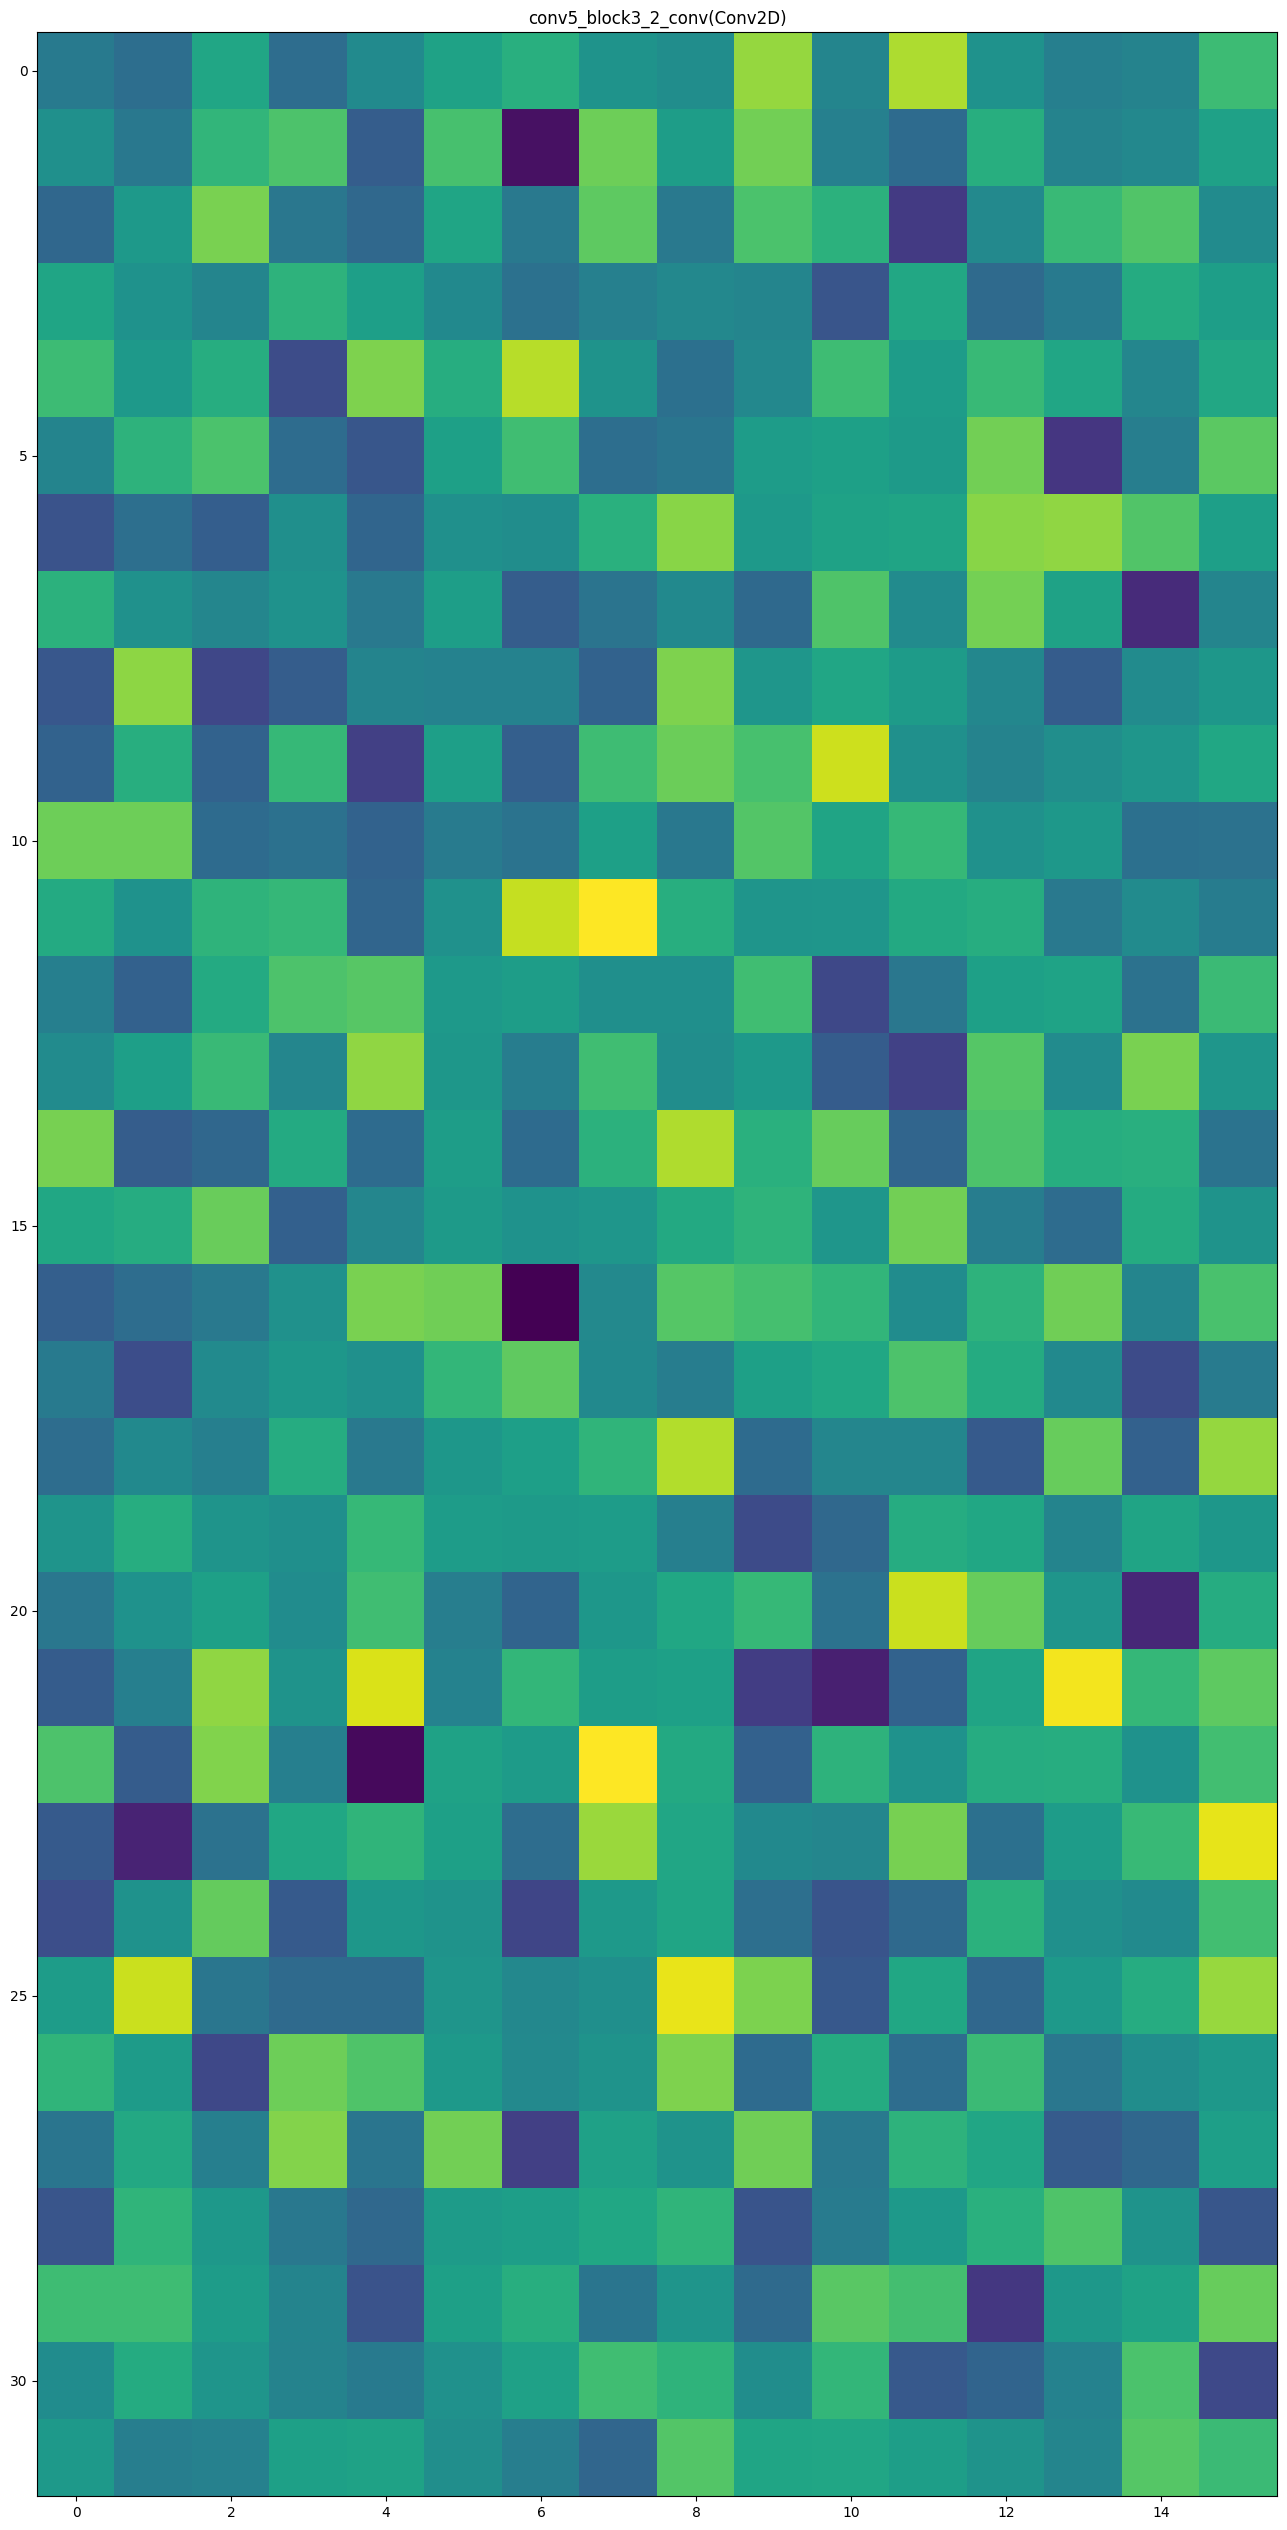

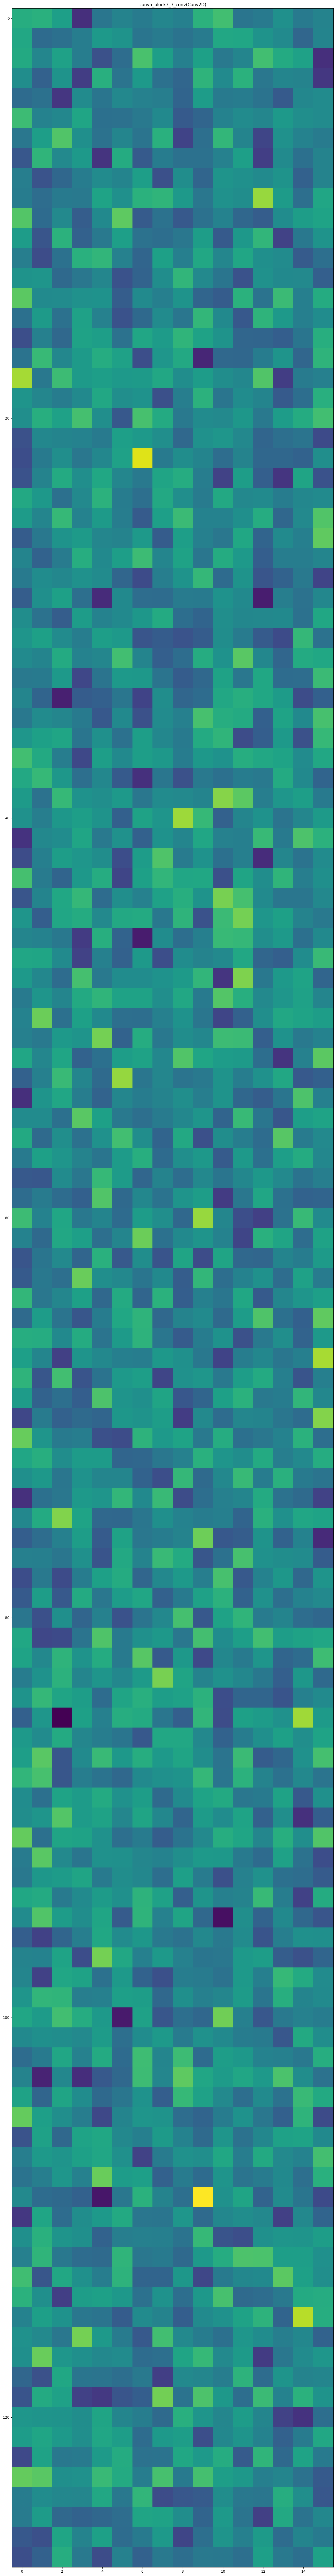

In [ ]:
layer_names = get_layer_names(141, 172, before_model)

# Now let's display our feature maps

plot_feature_map(layer_names, activations)

2. After fine-tuning

In [ ]:
# Extracts the outputs of first block:
layer_outputs = [layer.output for layer in ft_model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=ft_model.input, outputs=layer_outputs)
activations = activation_model.predict(ship_img_tensor)

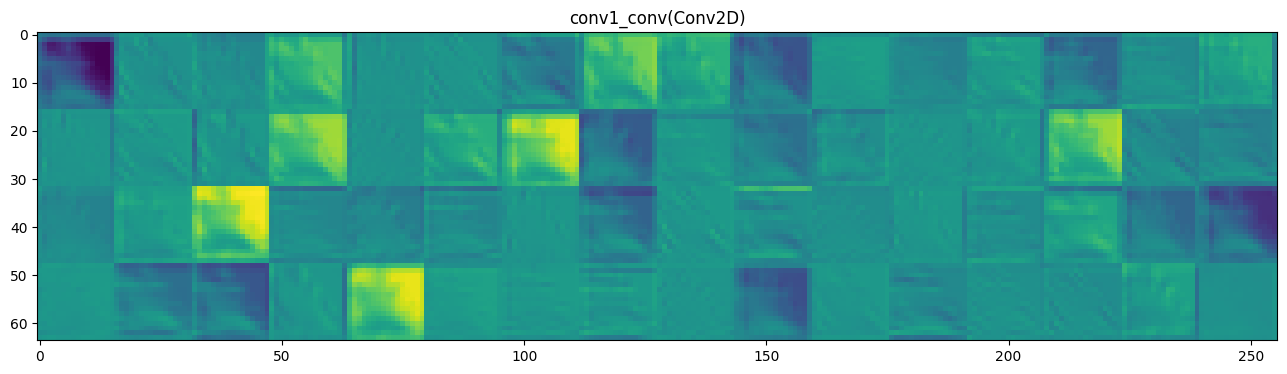

In [ ]:
#Plot feature map for the first block
layer_names = get_layer_names(0, 6, ft_model)

# Now let's display our feature maps
plot_feature_map(layer_names, activations)

In [ ]:
# Extracts the outputs of Block 3
layer_outputs = [layer.output for layer in ft_model.layers[38:78]]

# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=ft_model.input, outputs=layer_outputs)
activations = activation_model.predict(ship_img_tensor)

1/1 [==============================] - 0s 483ms/step


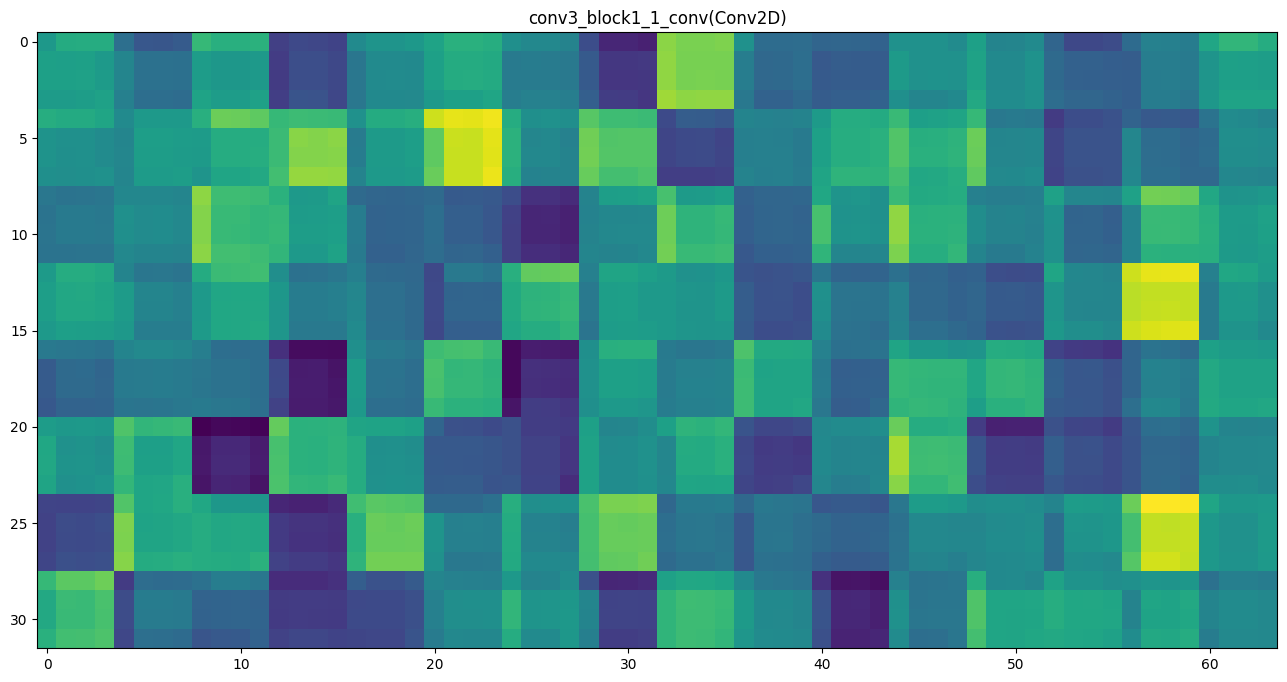

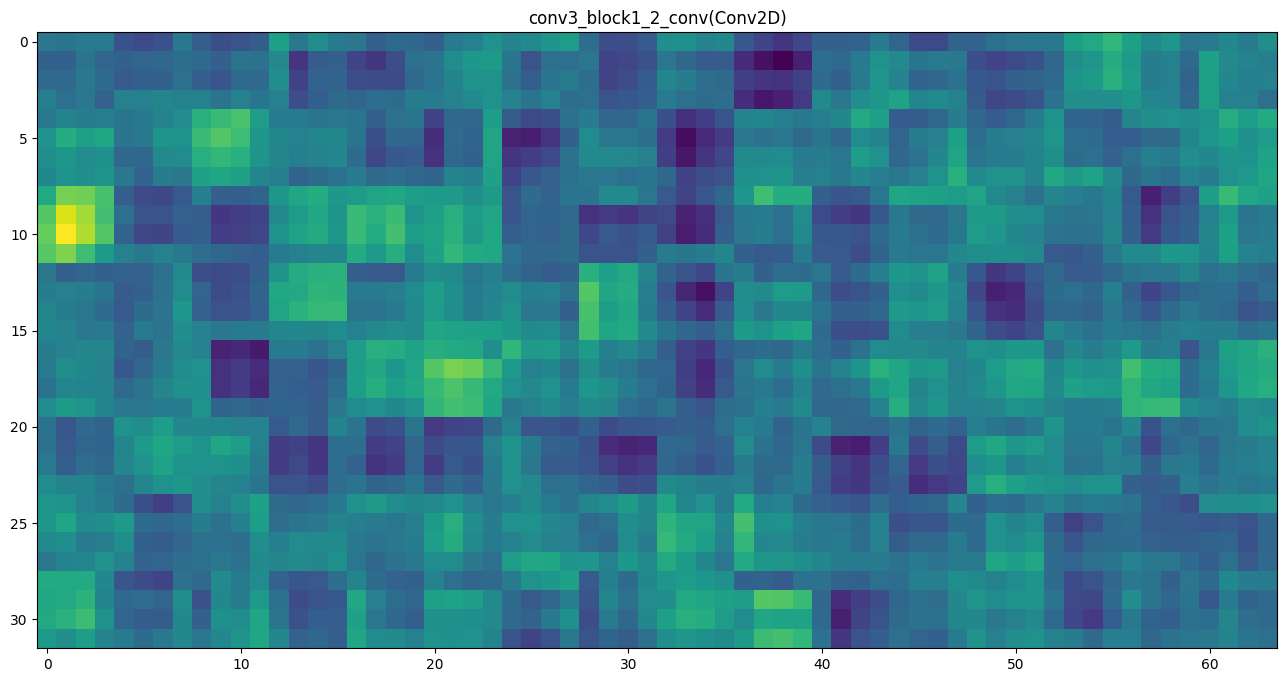

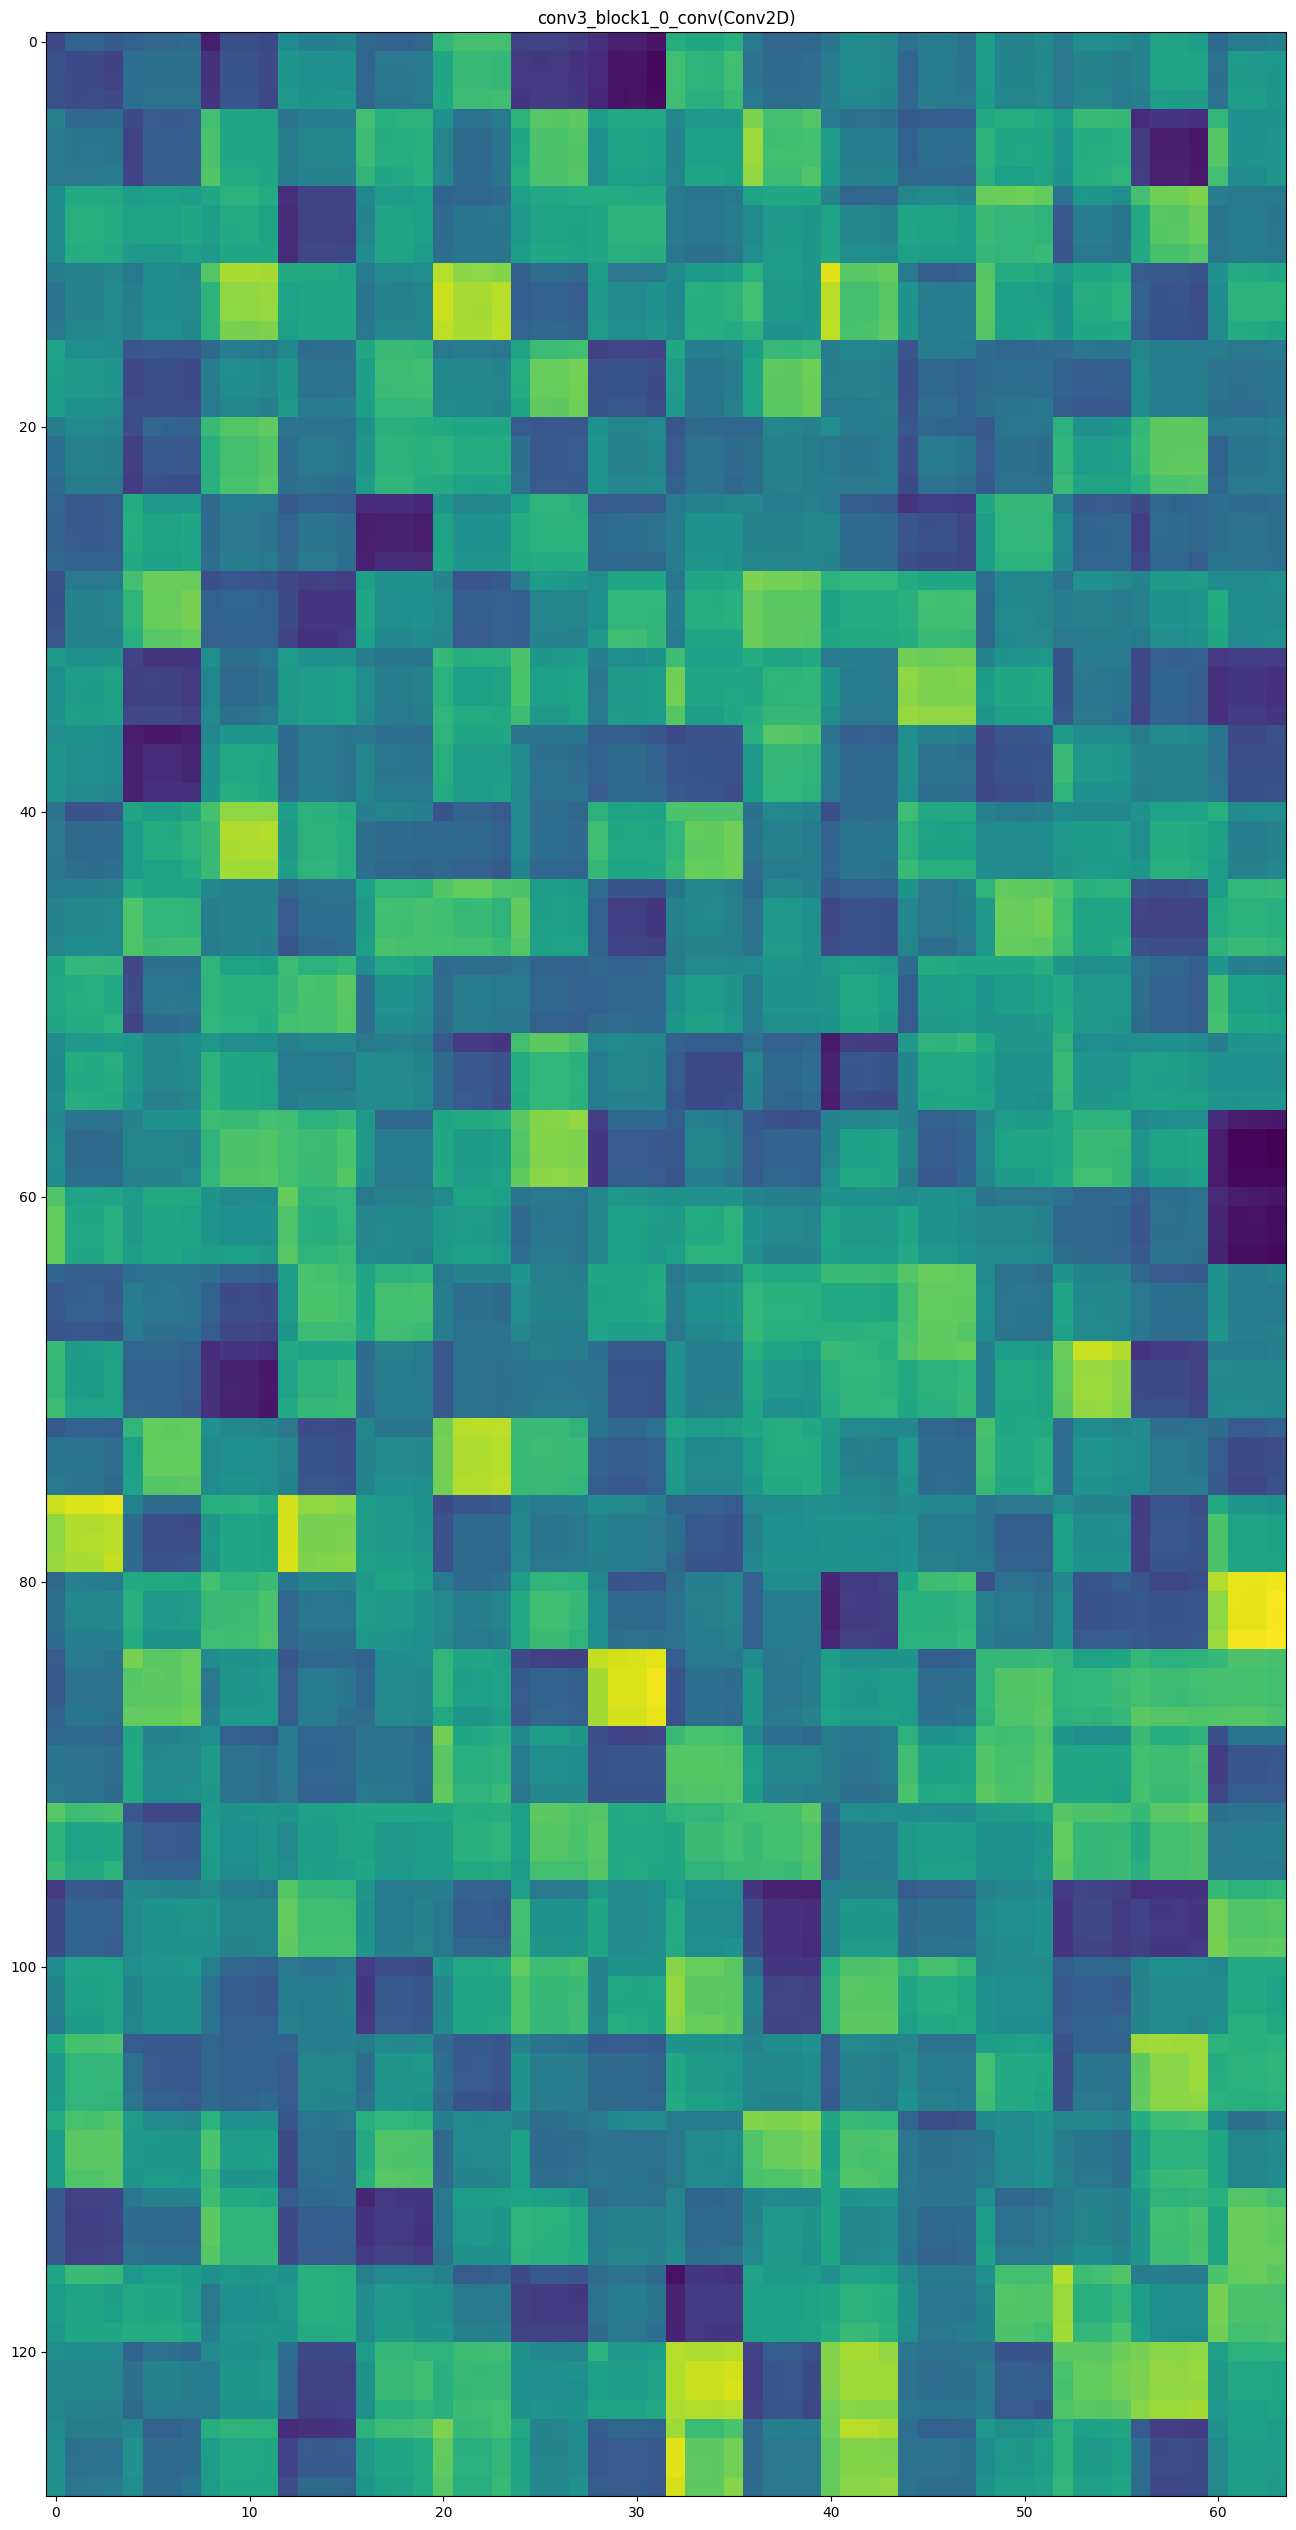

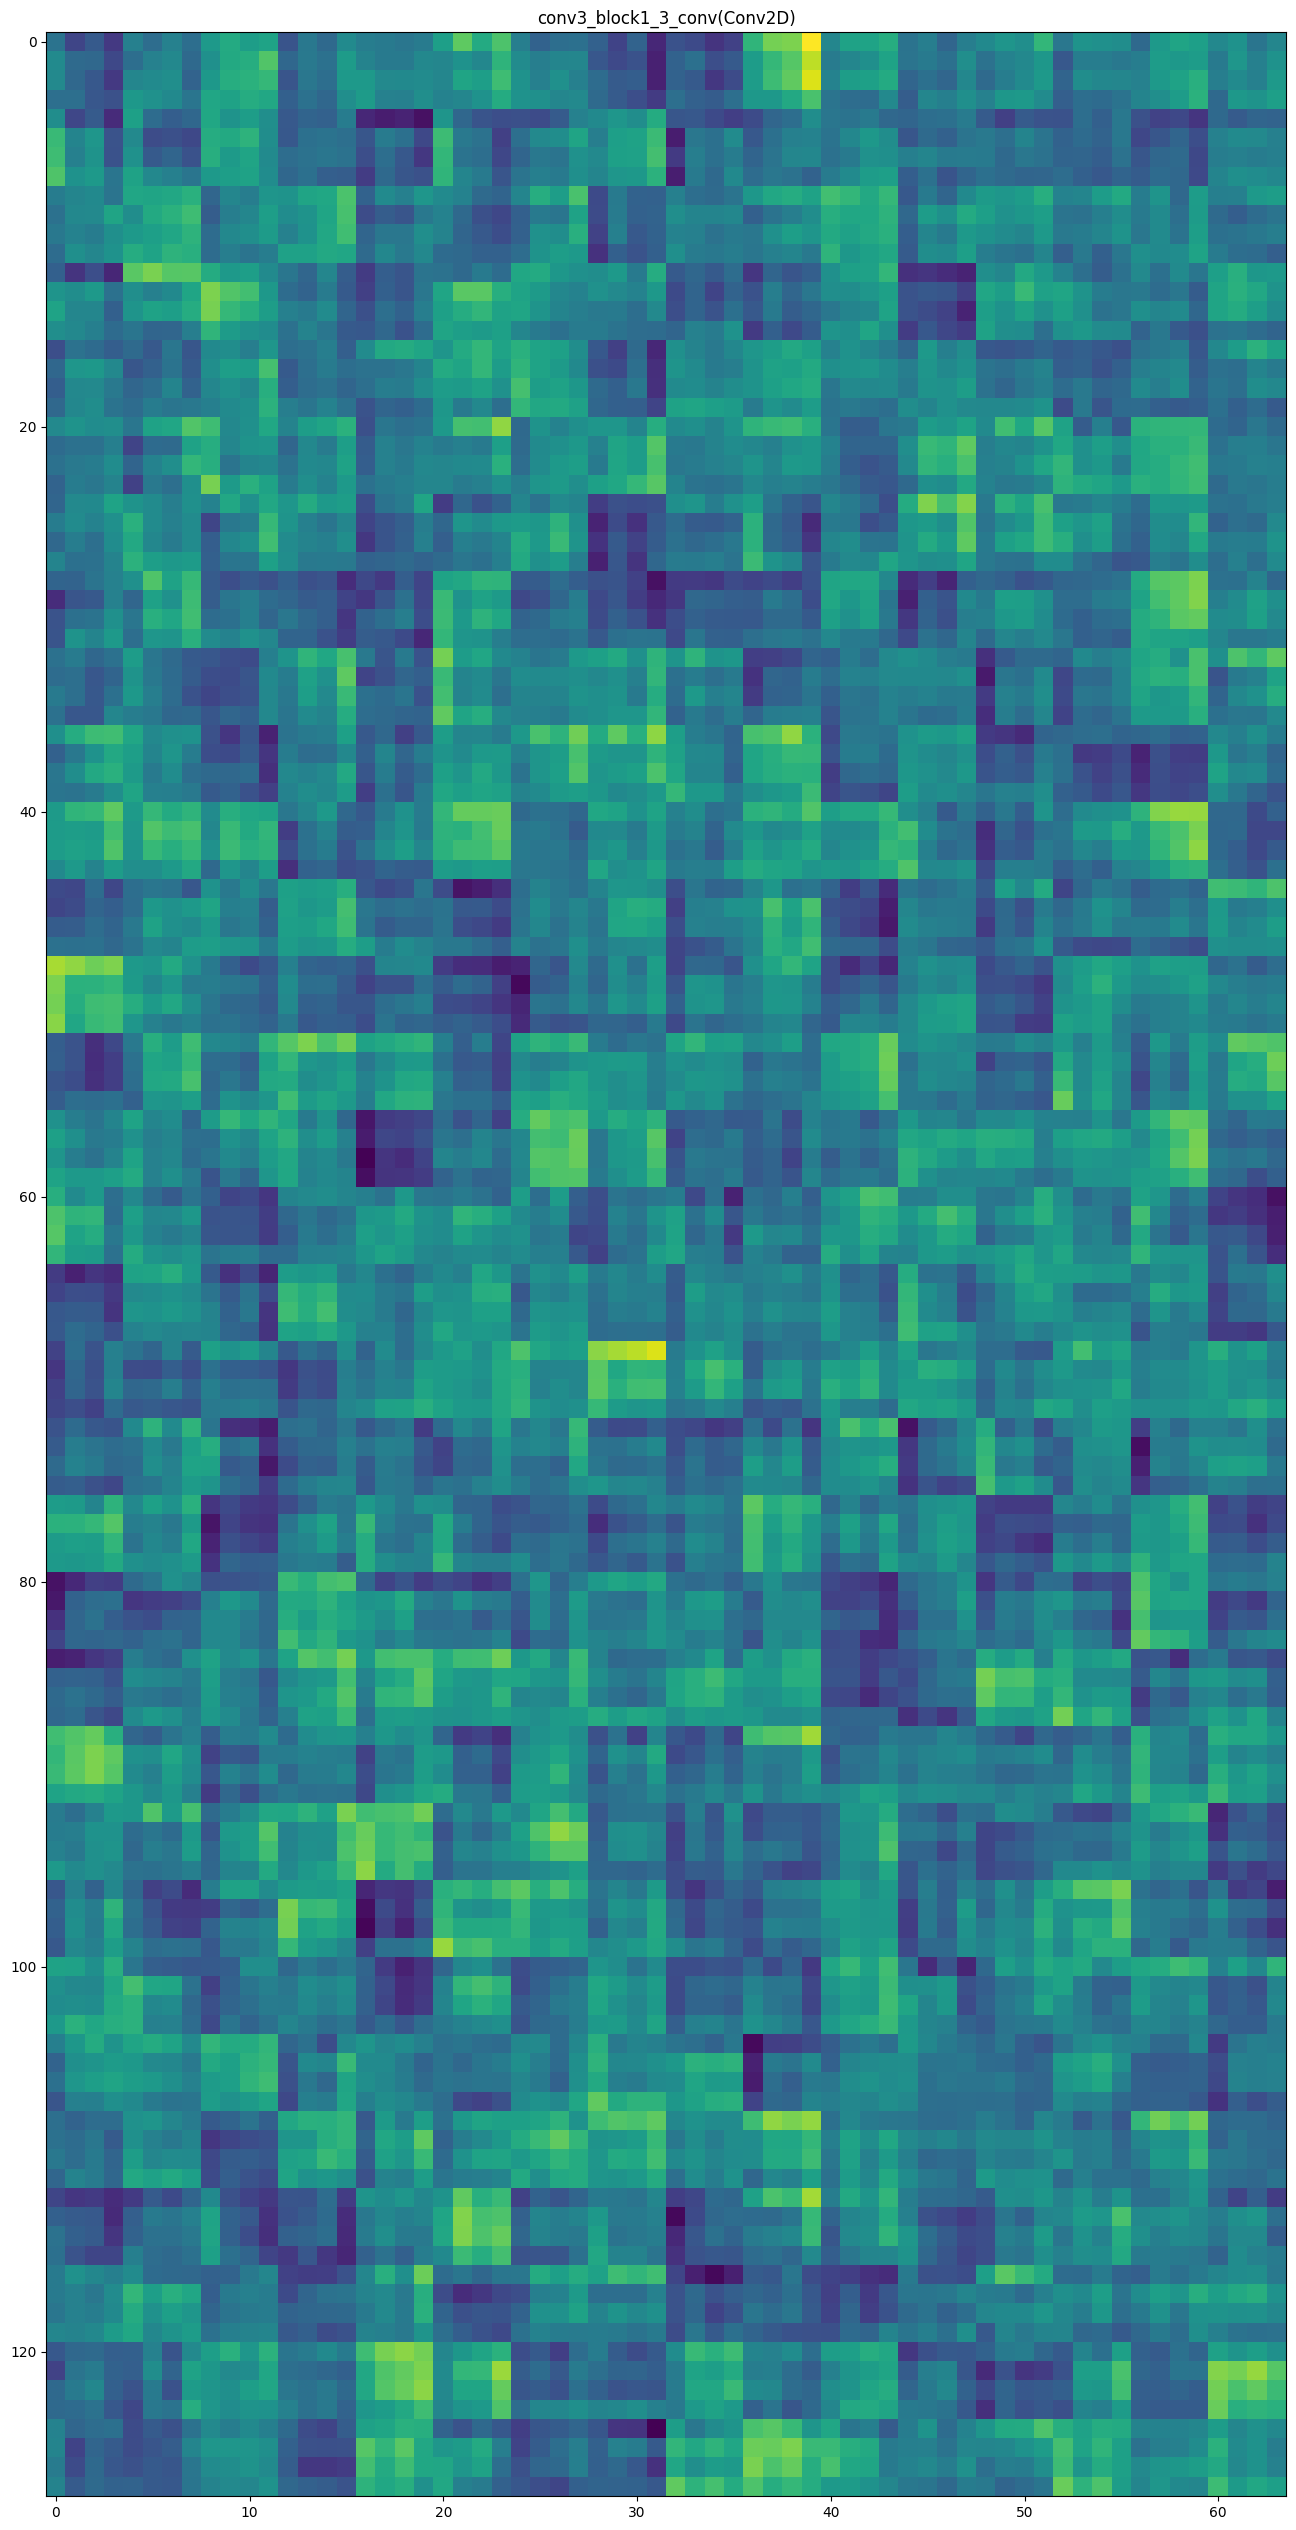

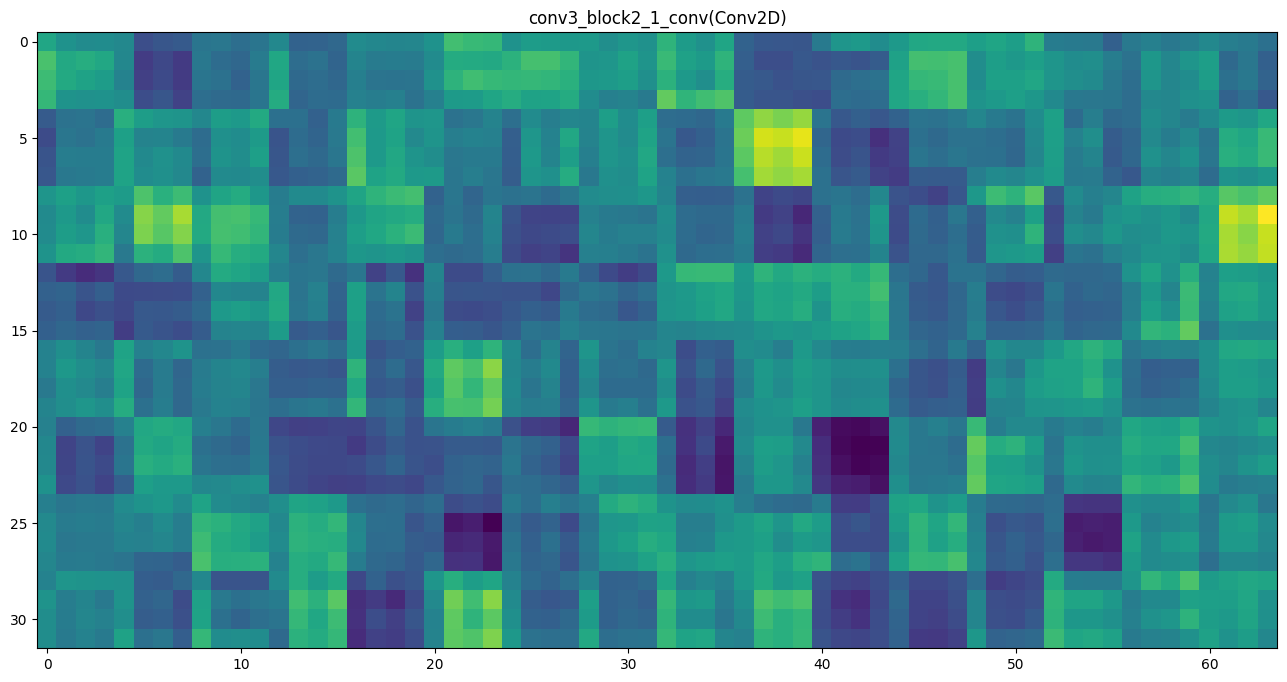

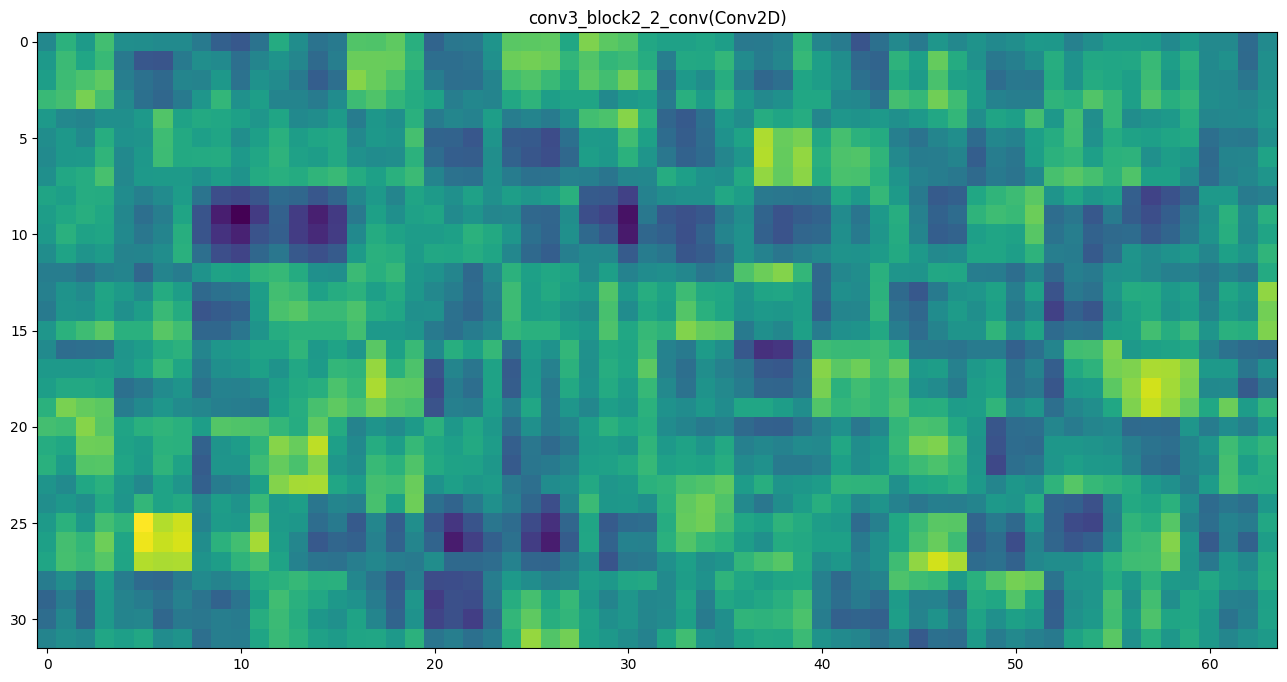

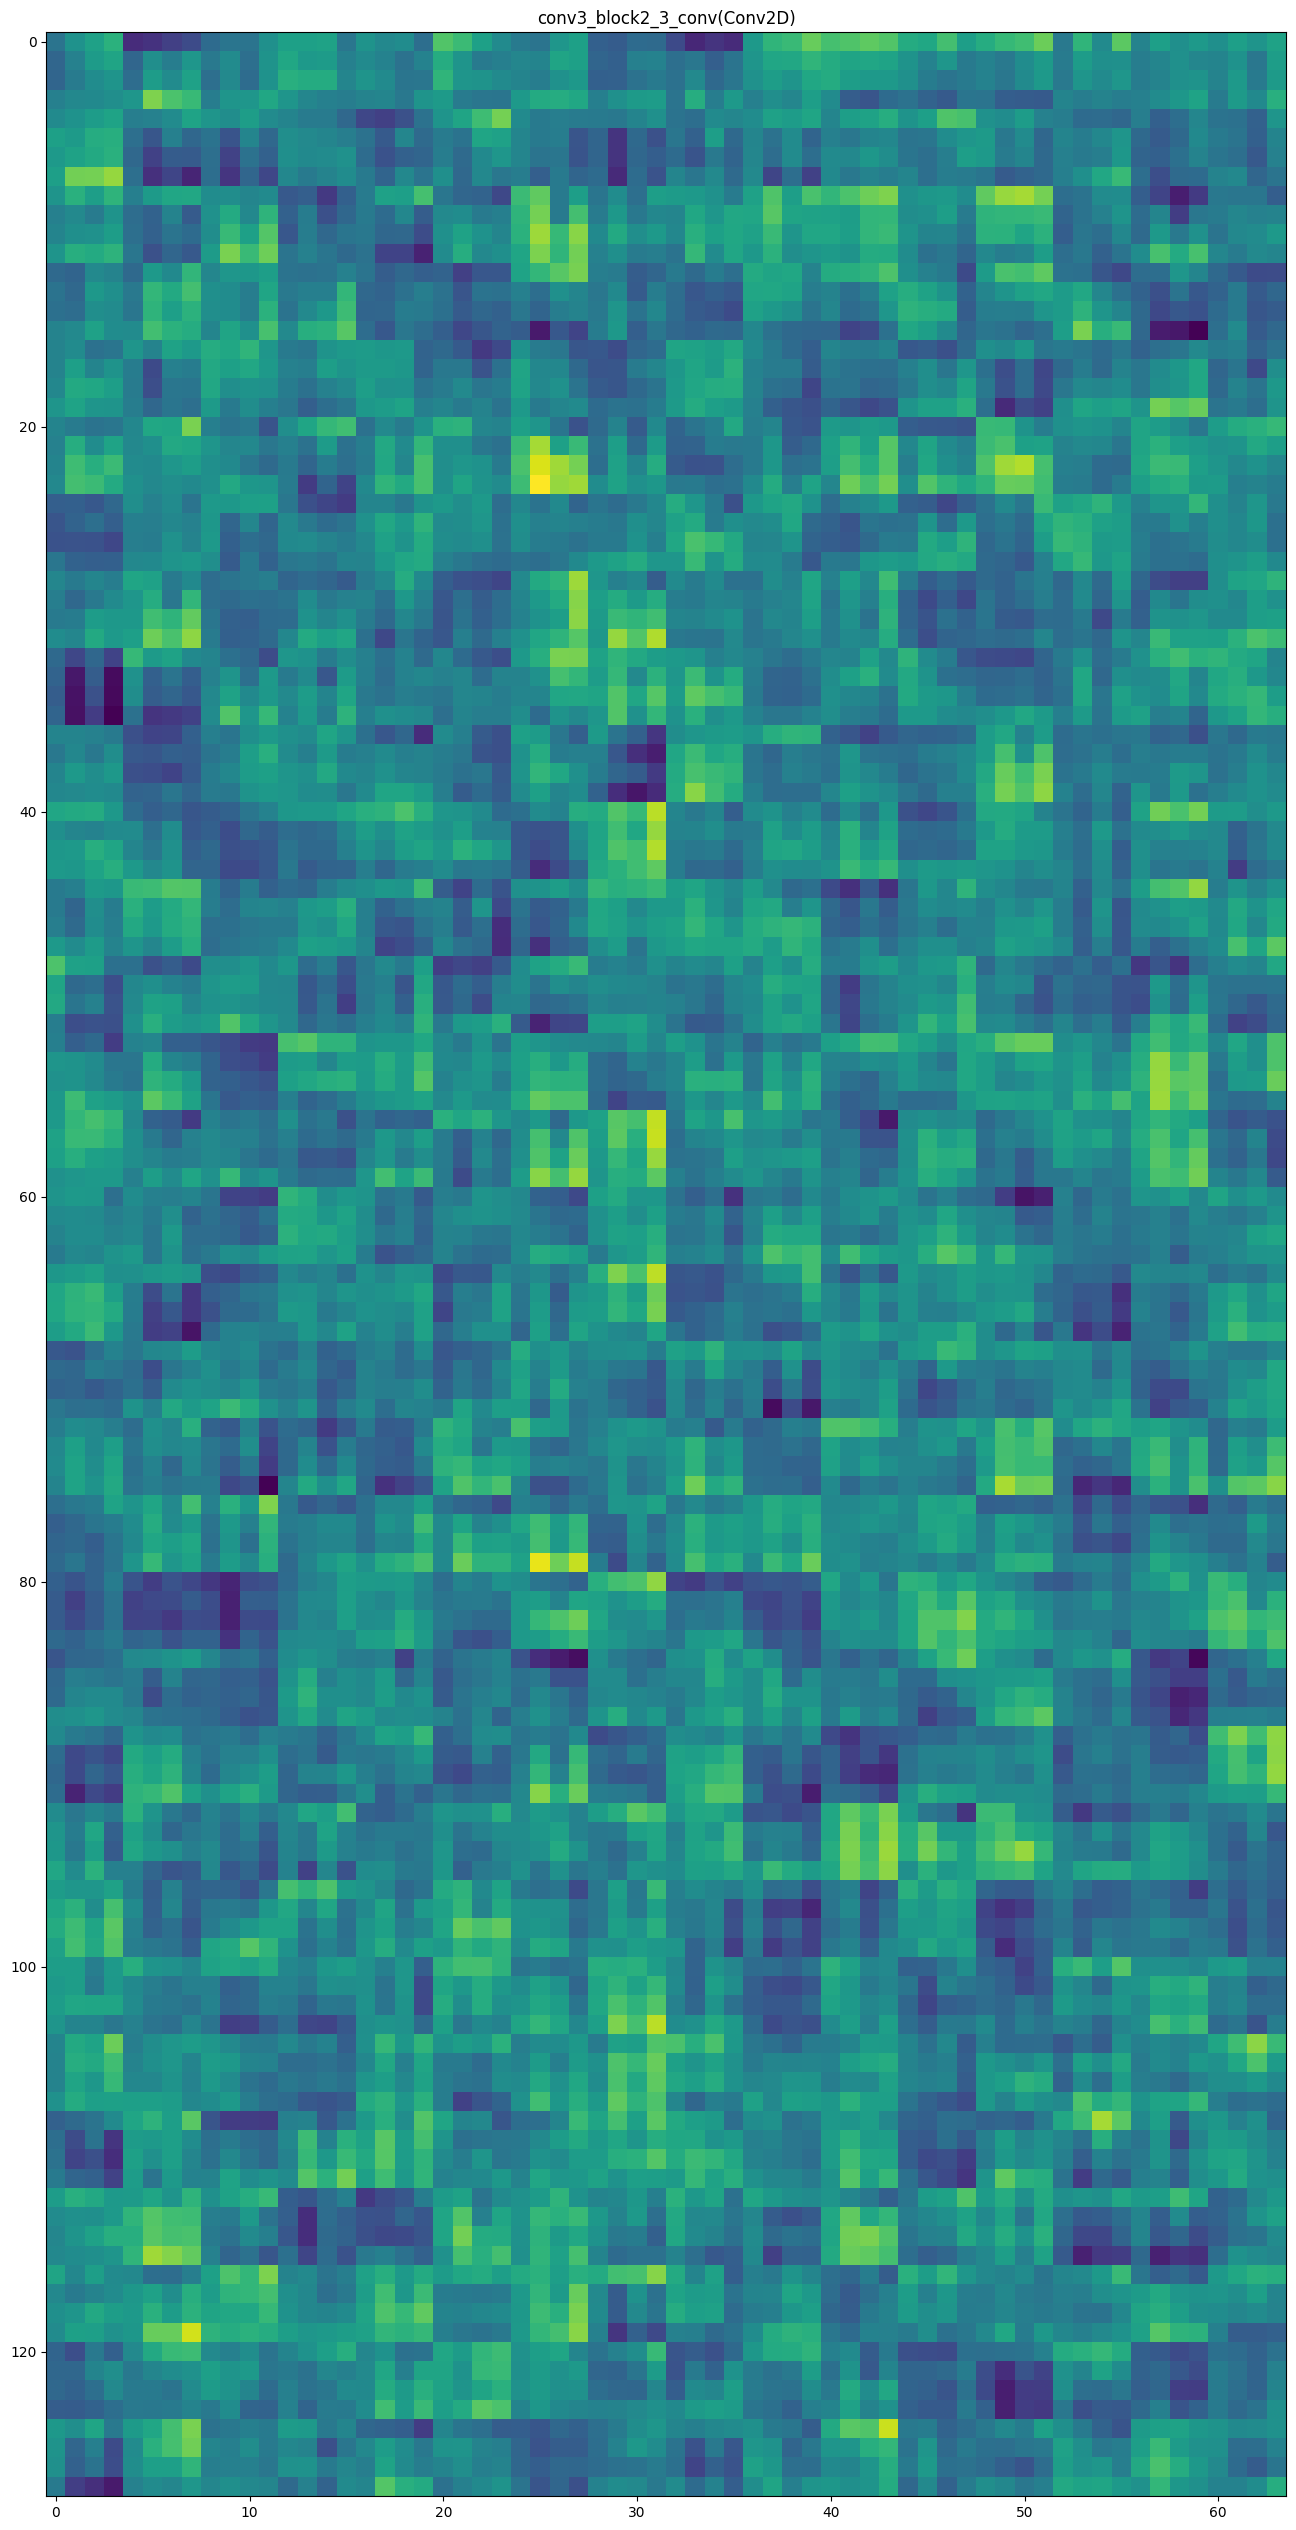

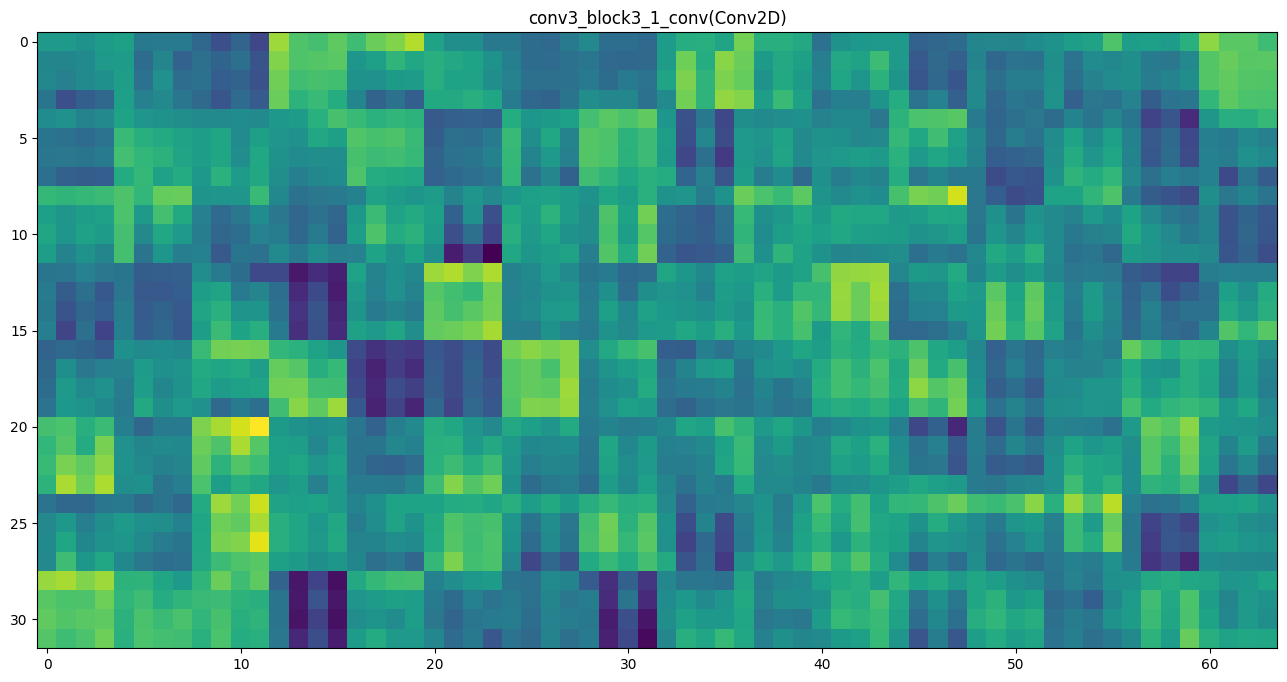

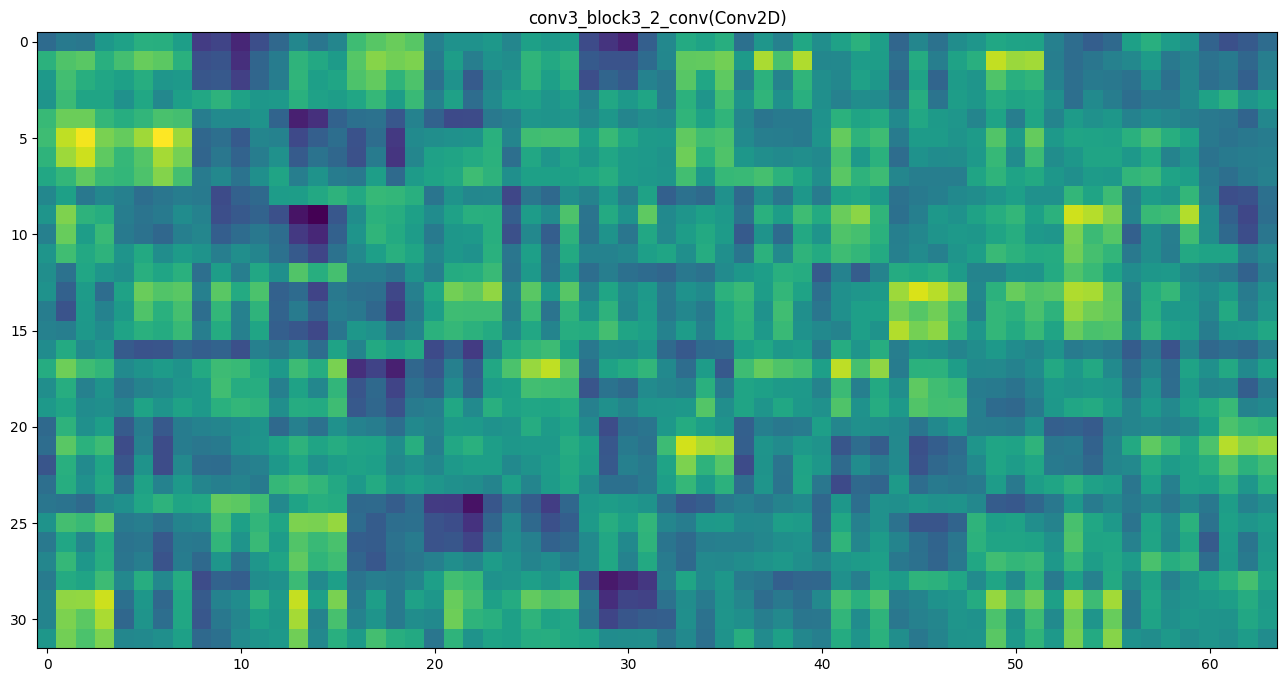

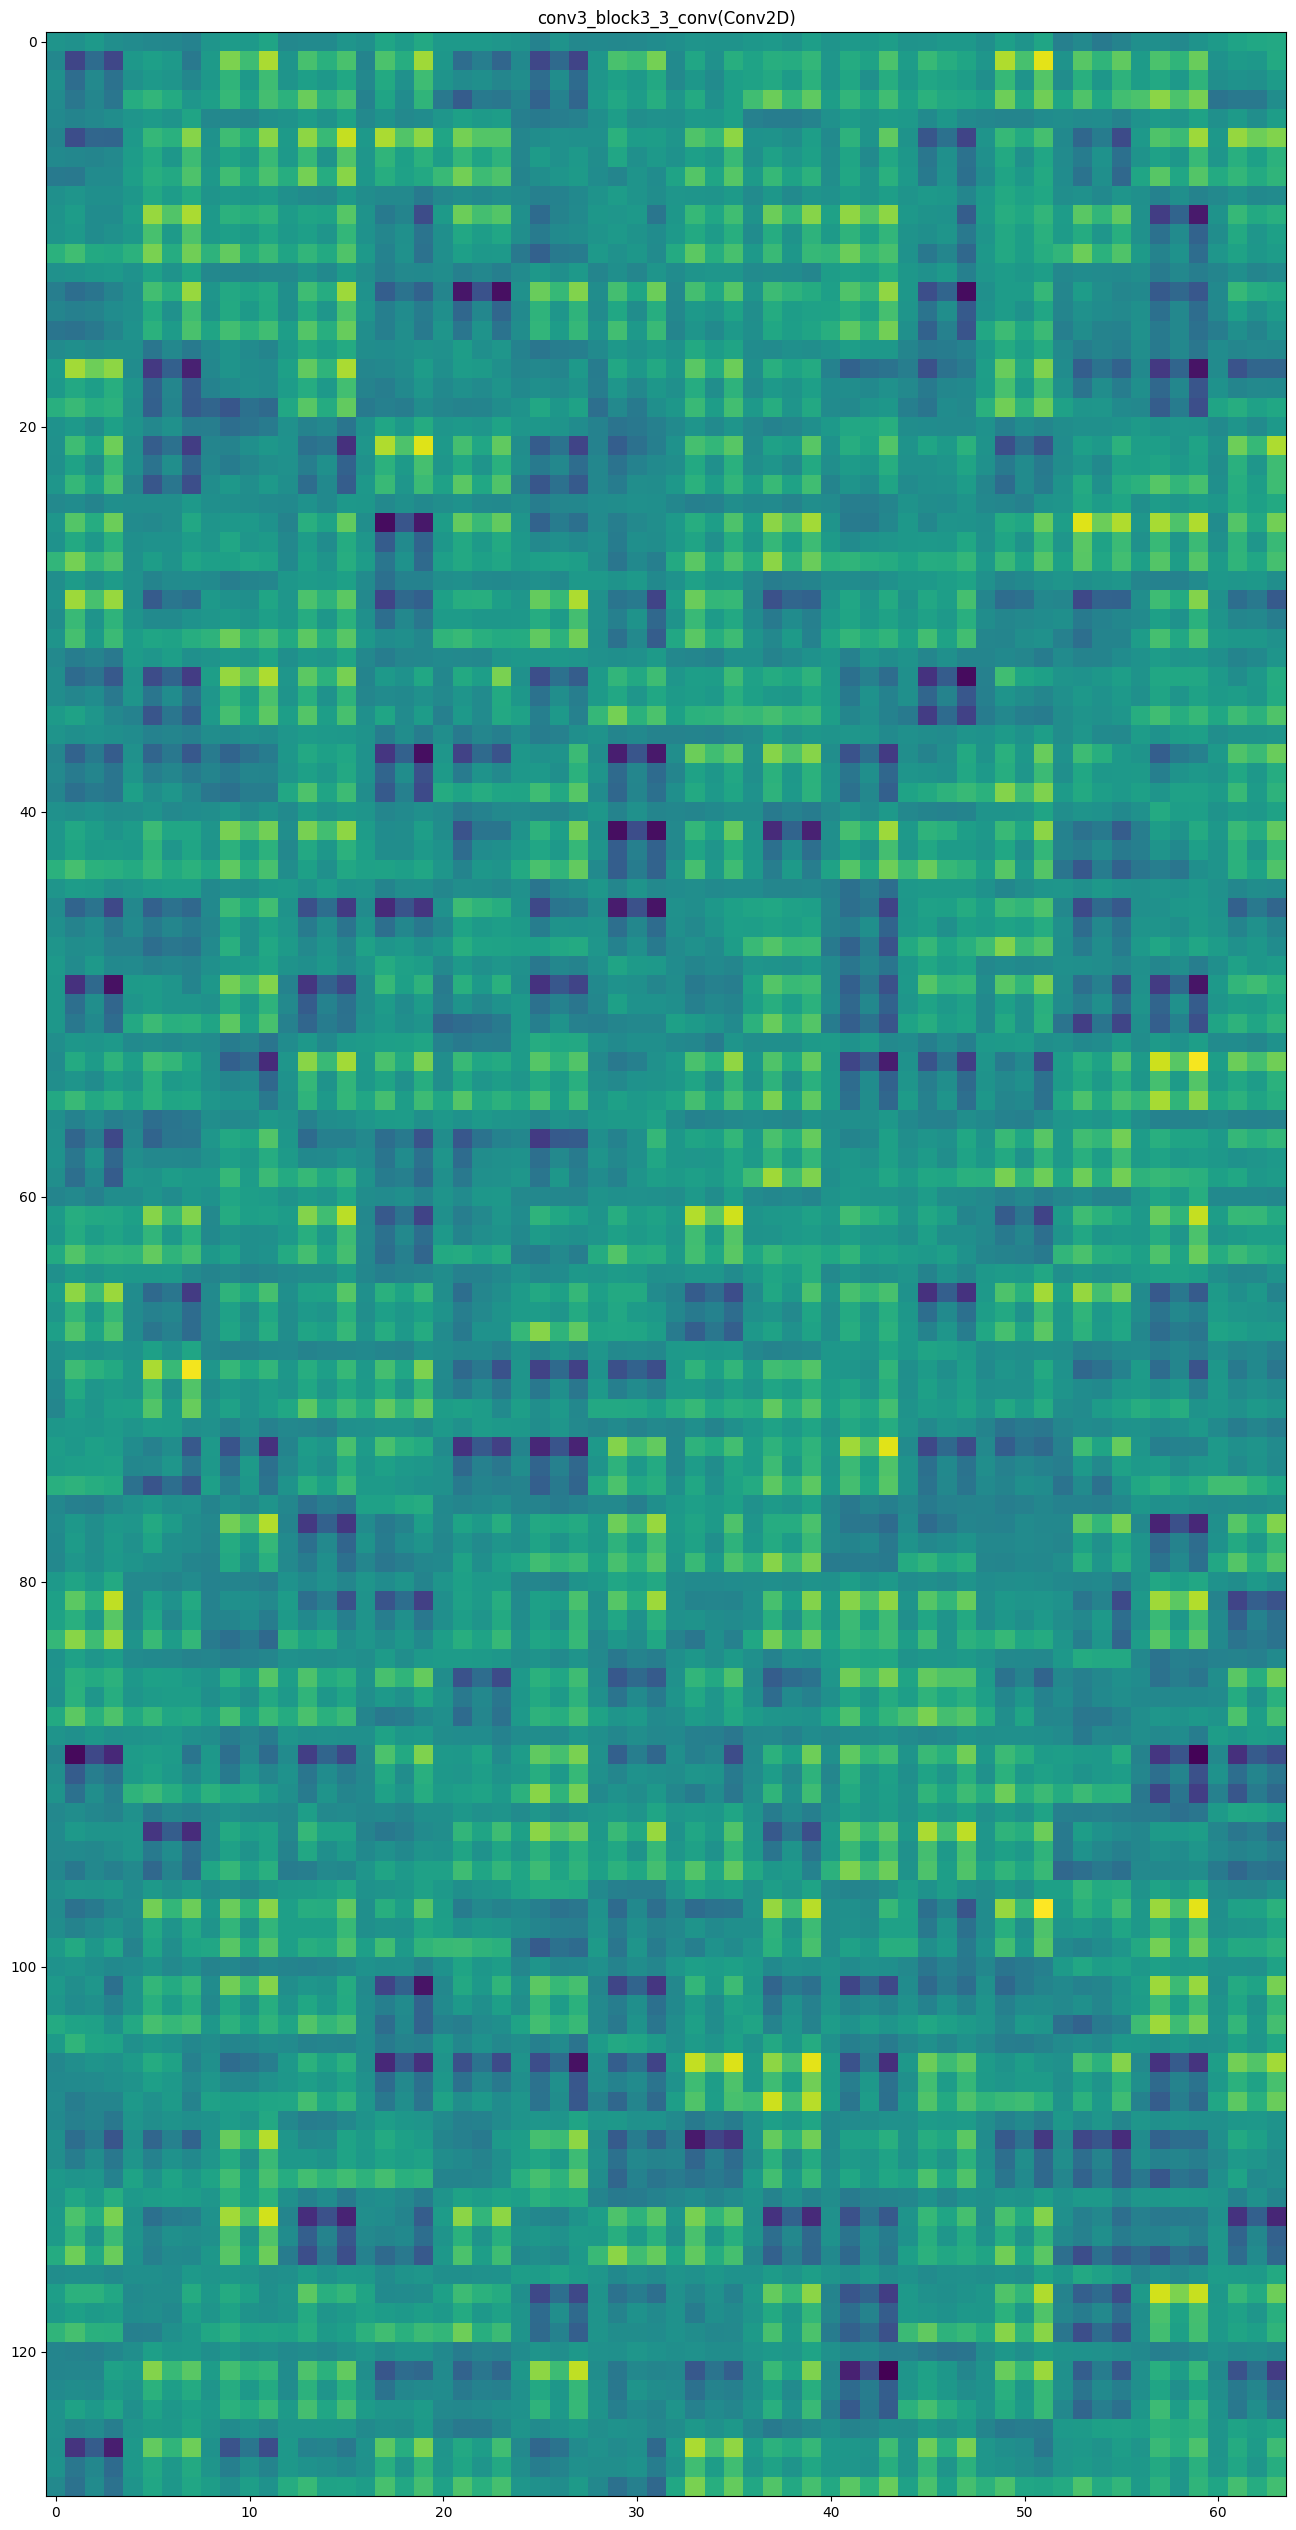

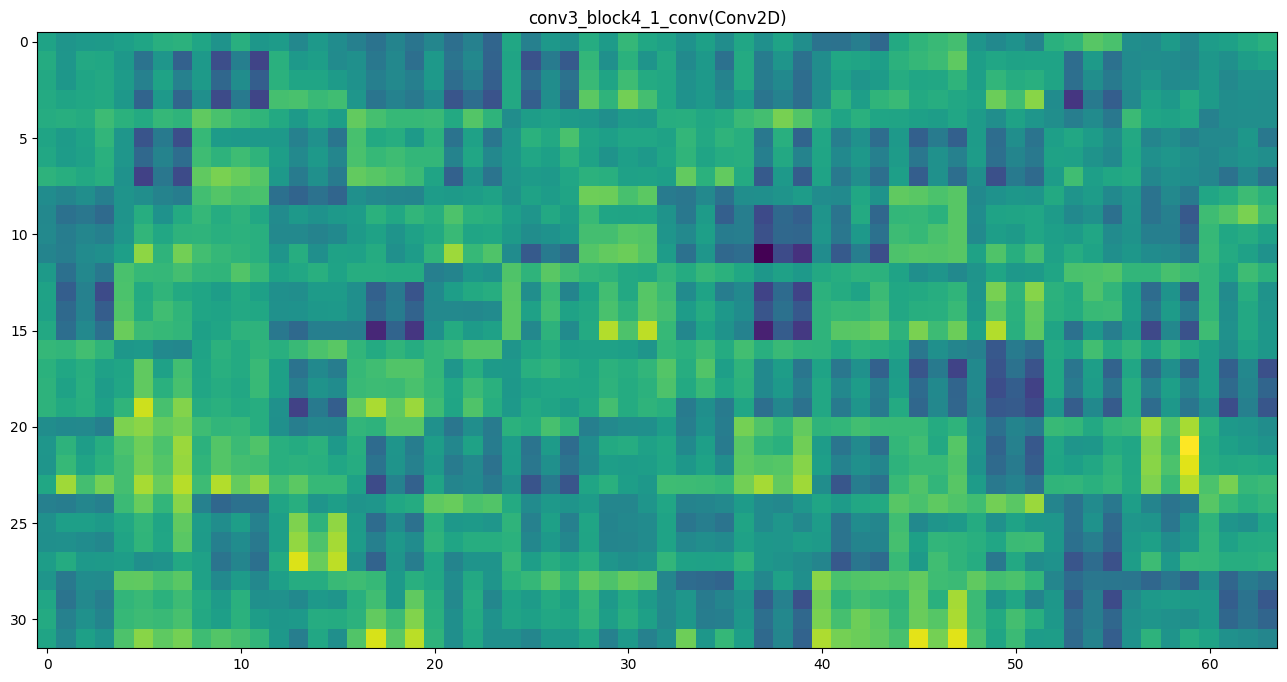

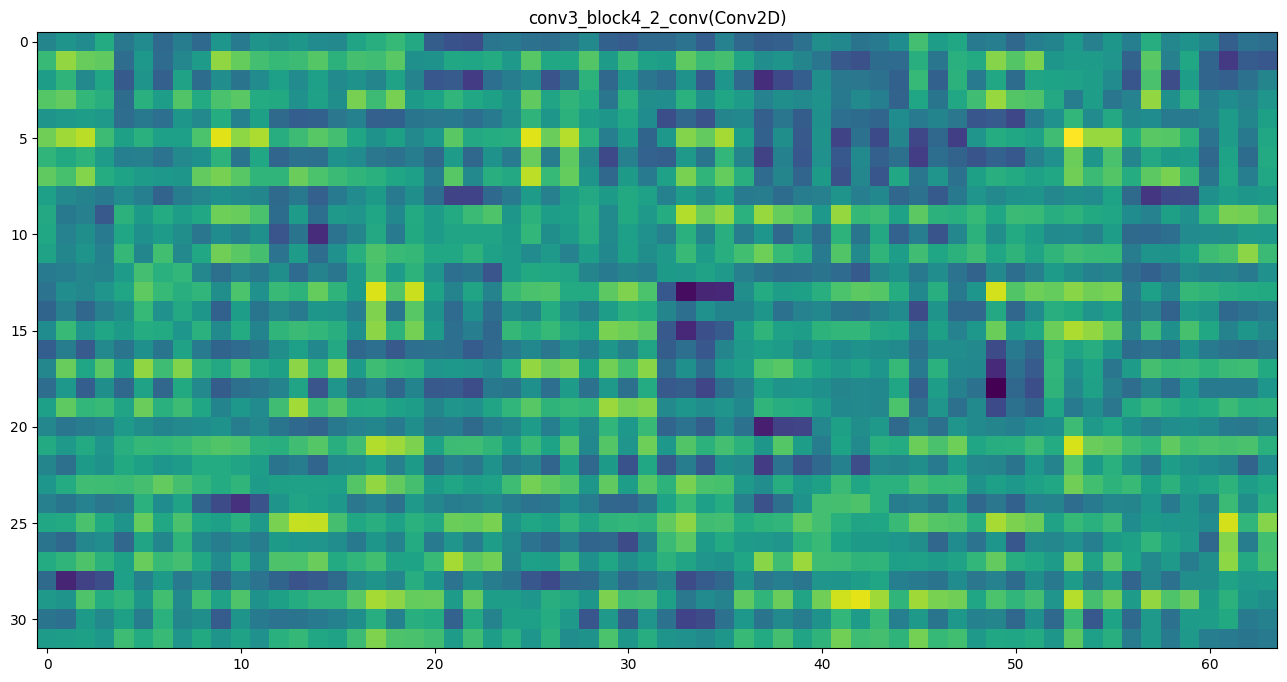

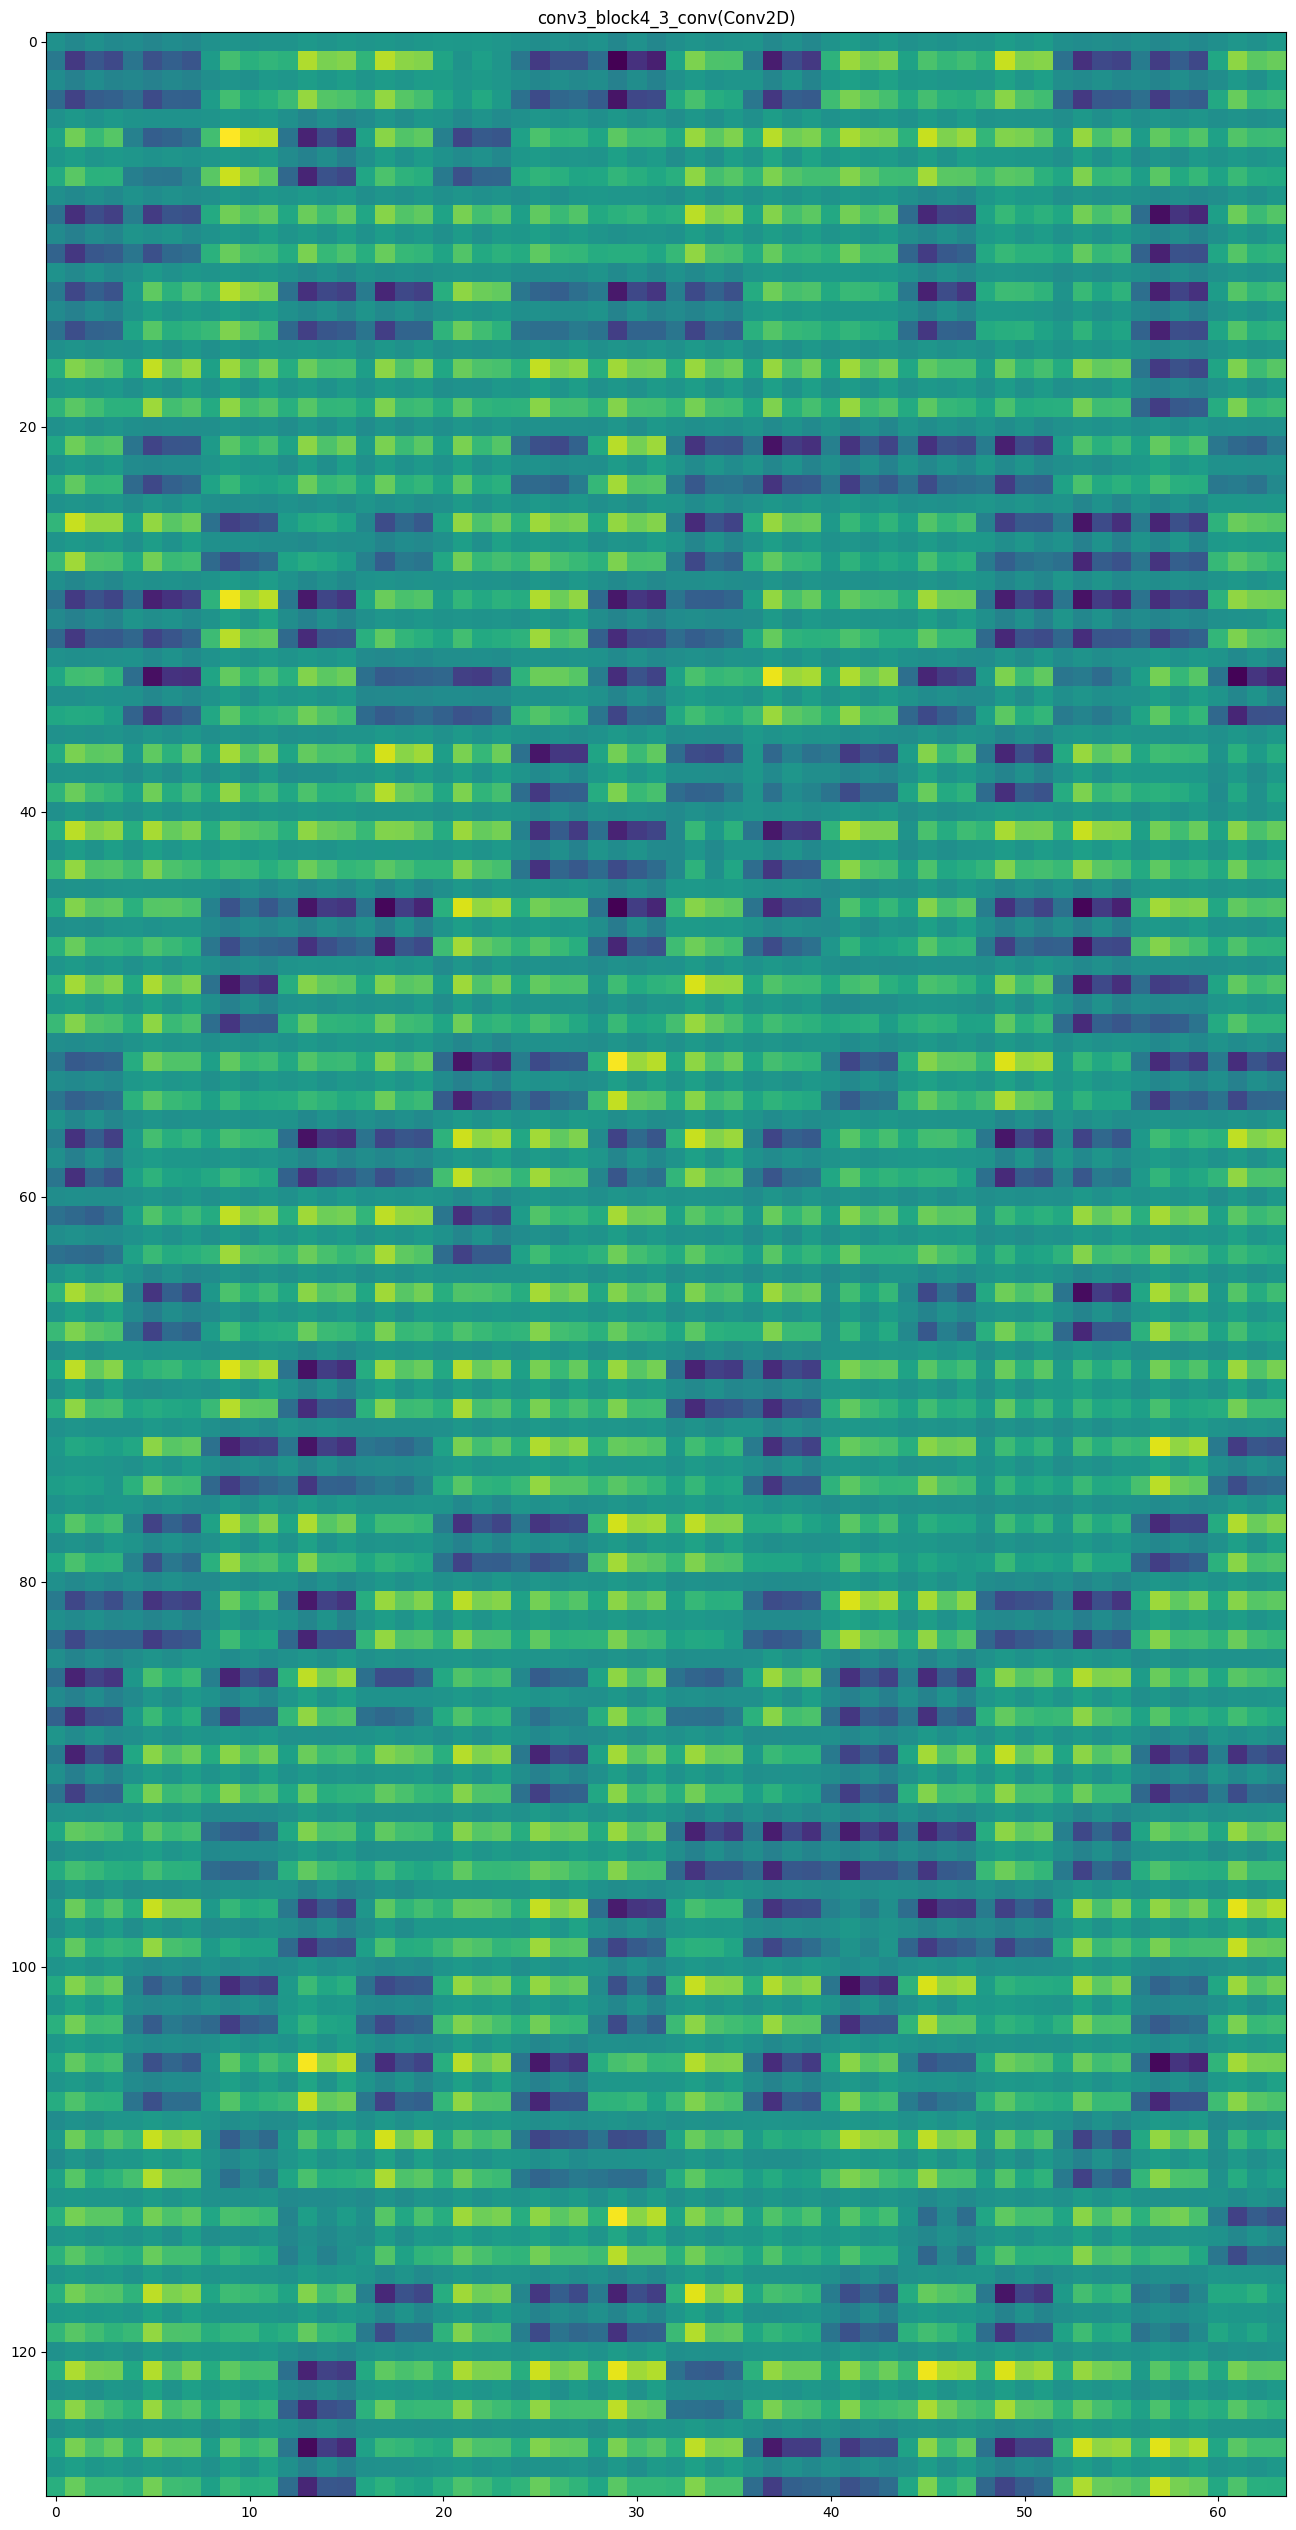

In [ ]:
#get the names of the layers
layer_names = get_layer_names(38, 78, ft_model)

#plot feature maps
plot_feature_map(layer_names, activations)

In [ ]:
# Extracts the outputs of Block 5
layer_outputs = [layer.output for layer in ft_model.layers[141:172]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=ft_model.input, outputs=layer_outputs)
activations = activation_model.predict(ship_img_tensor)

1/1 [==============================] - 1s 922ms/step


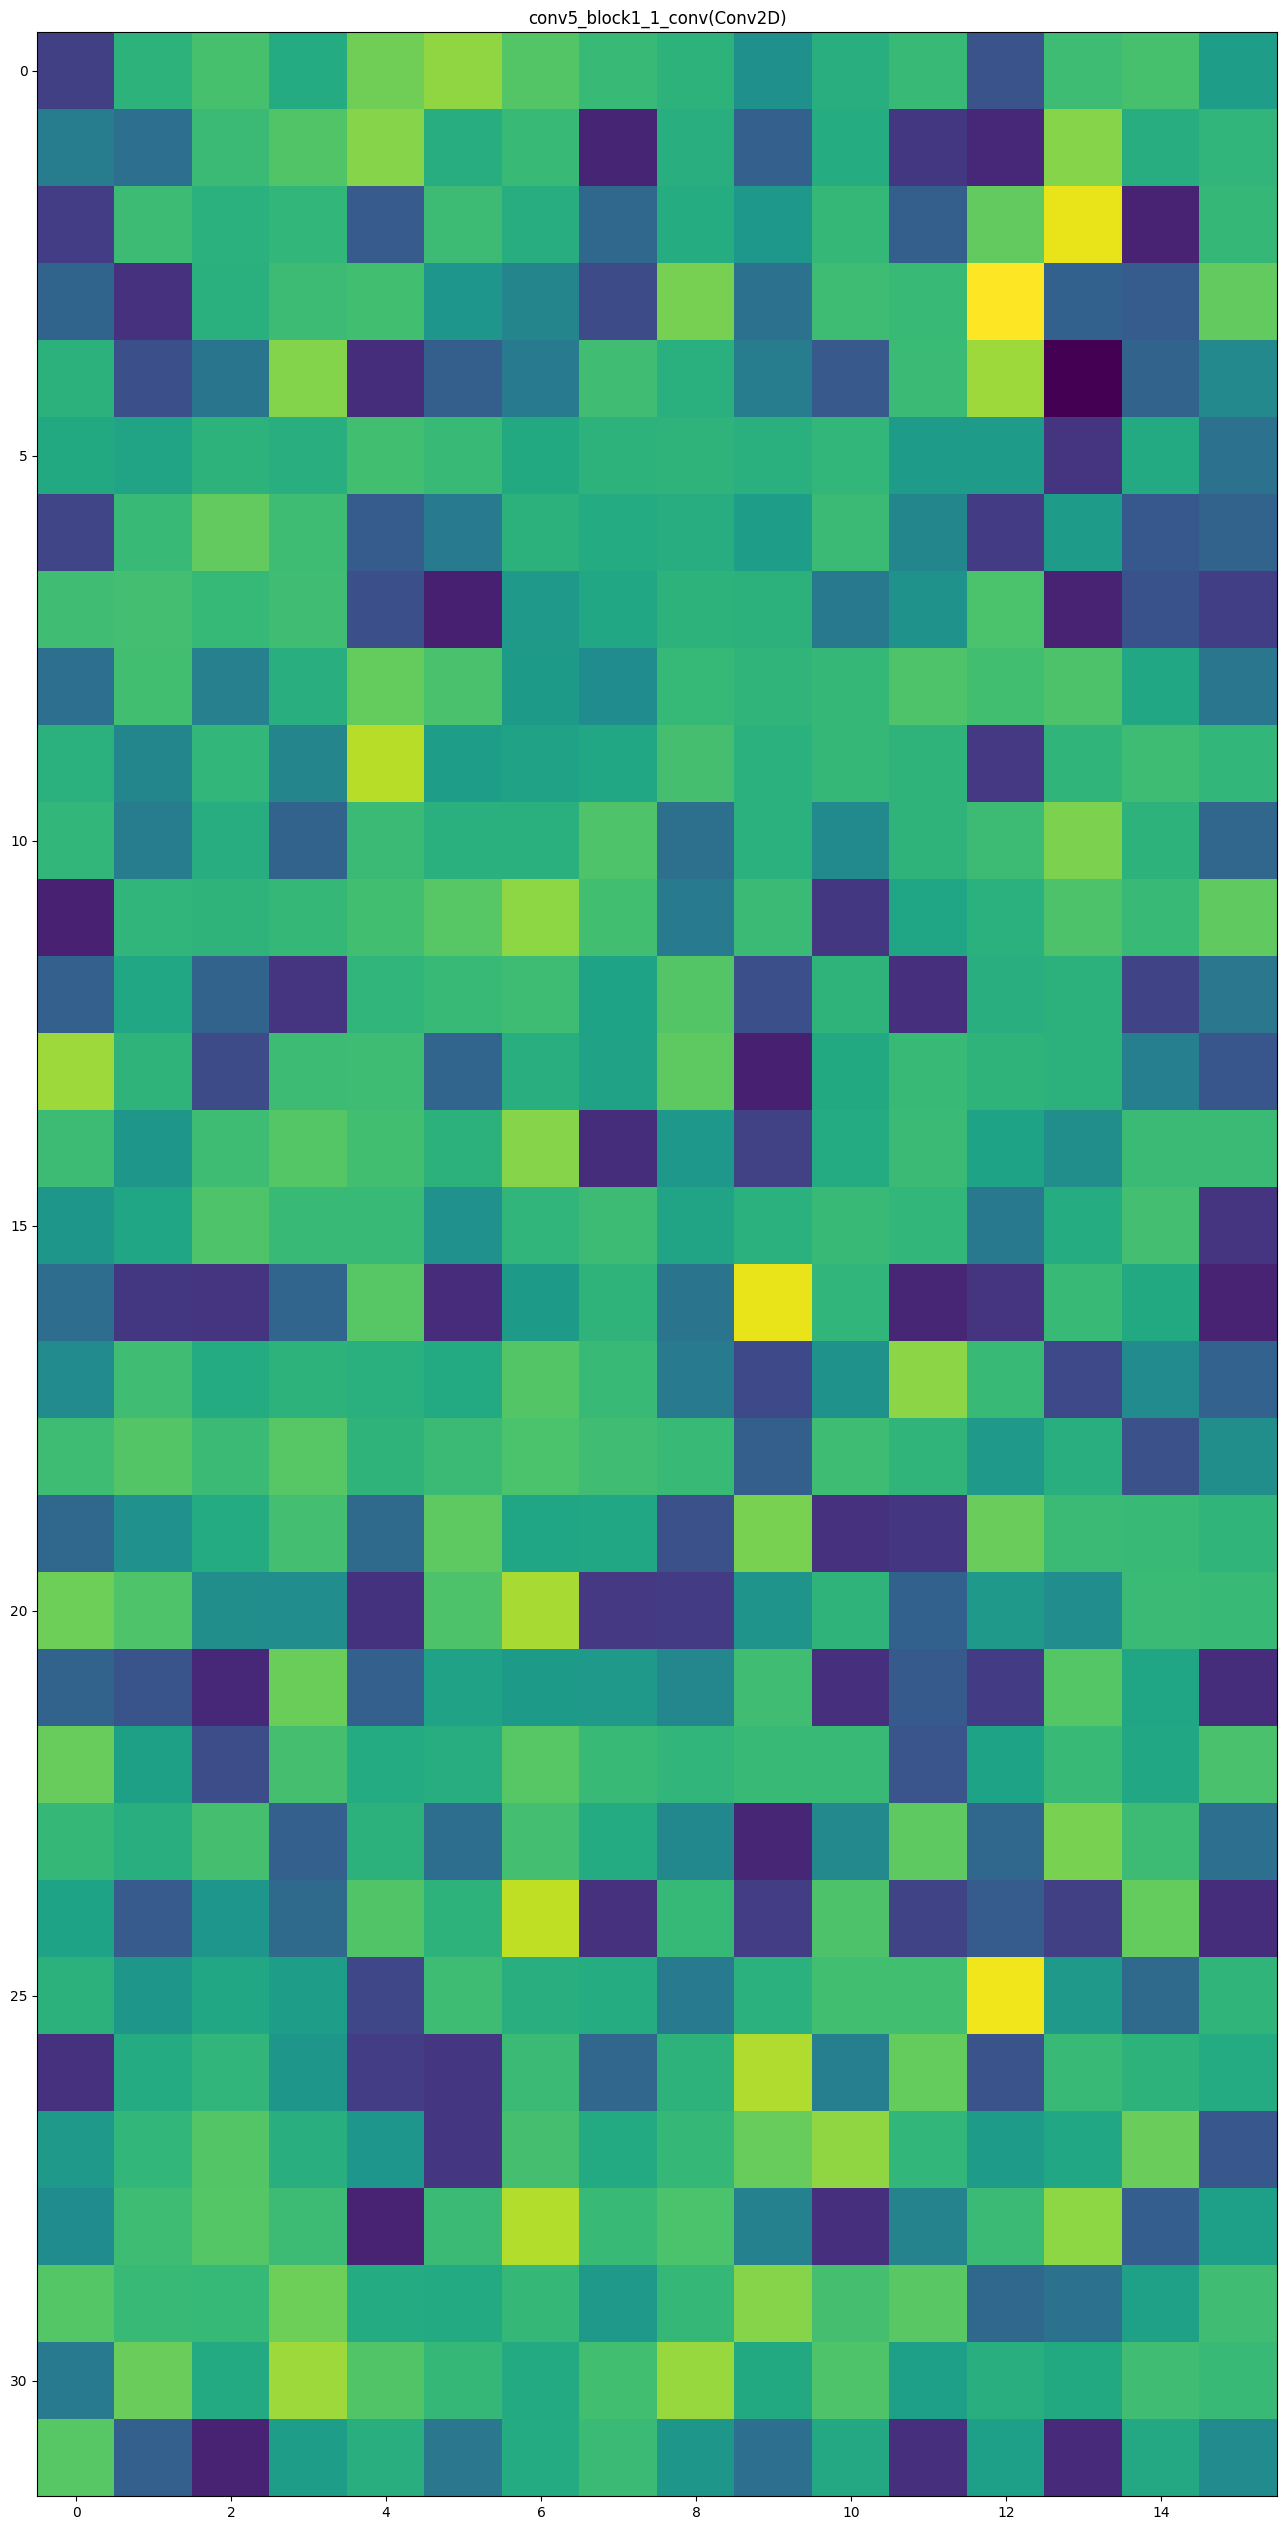

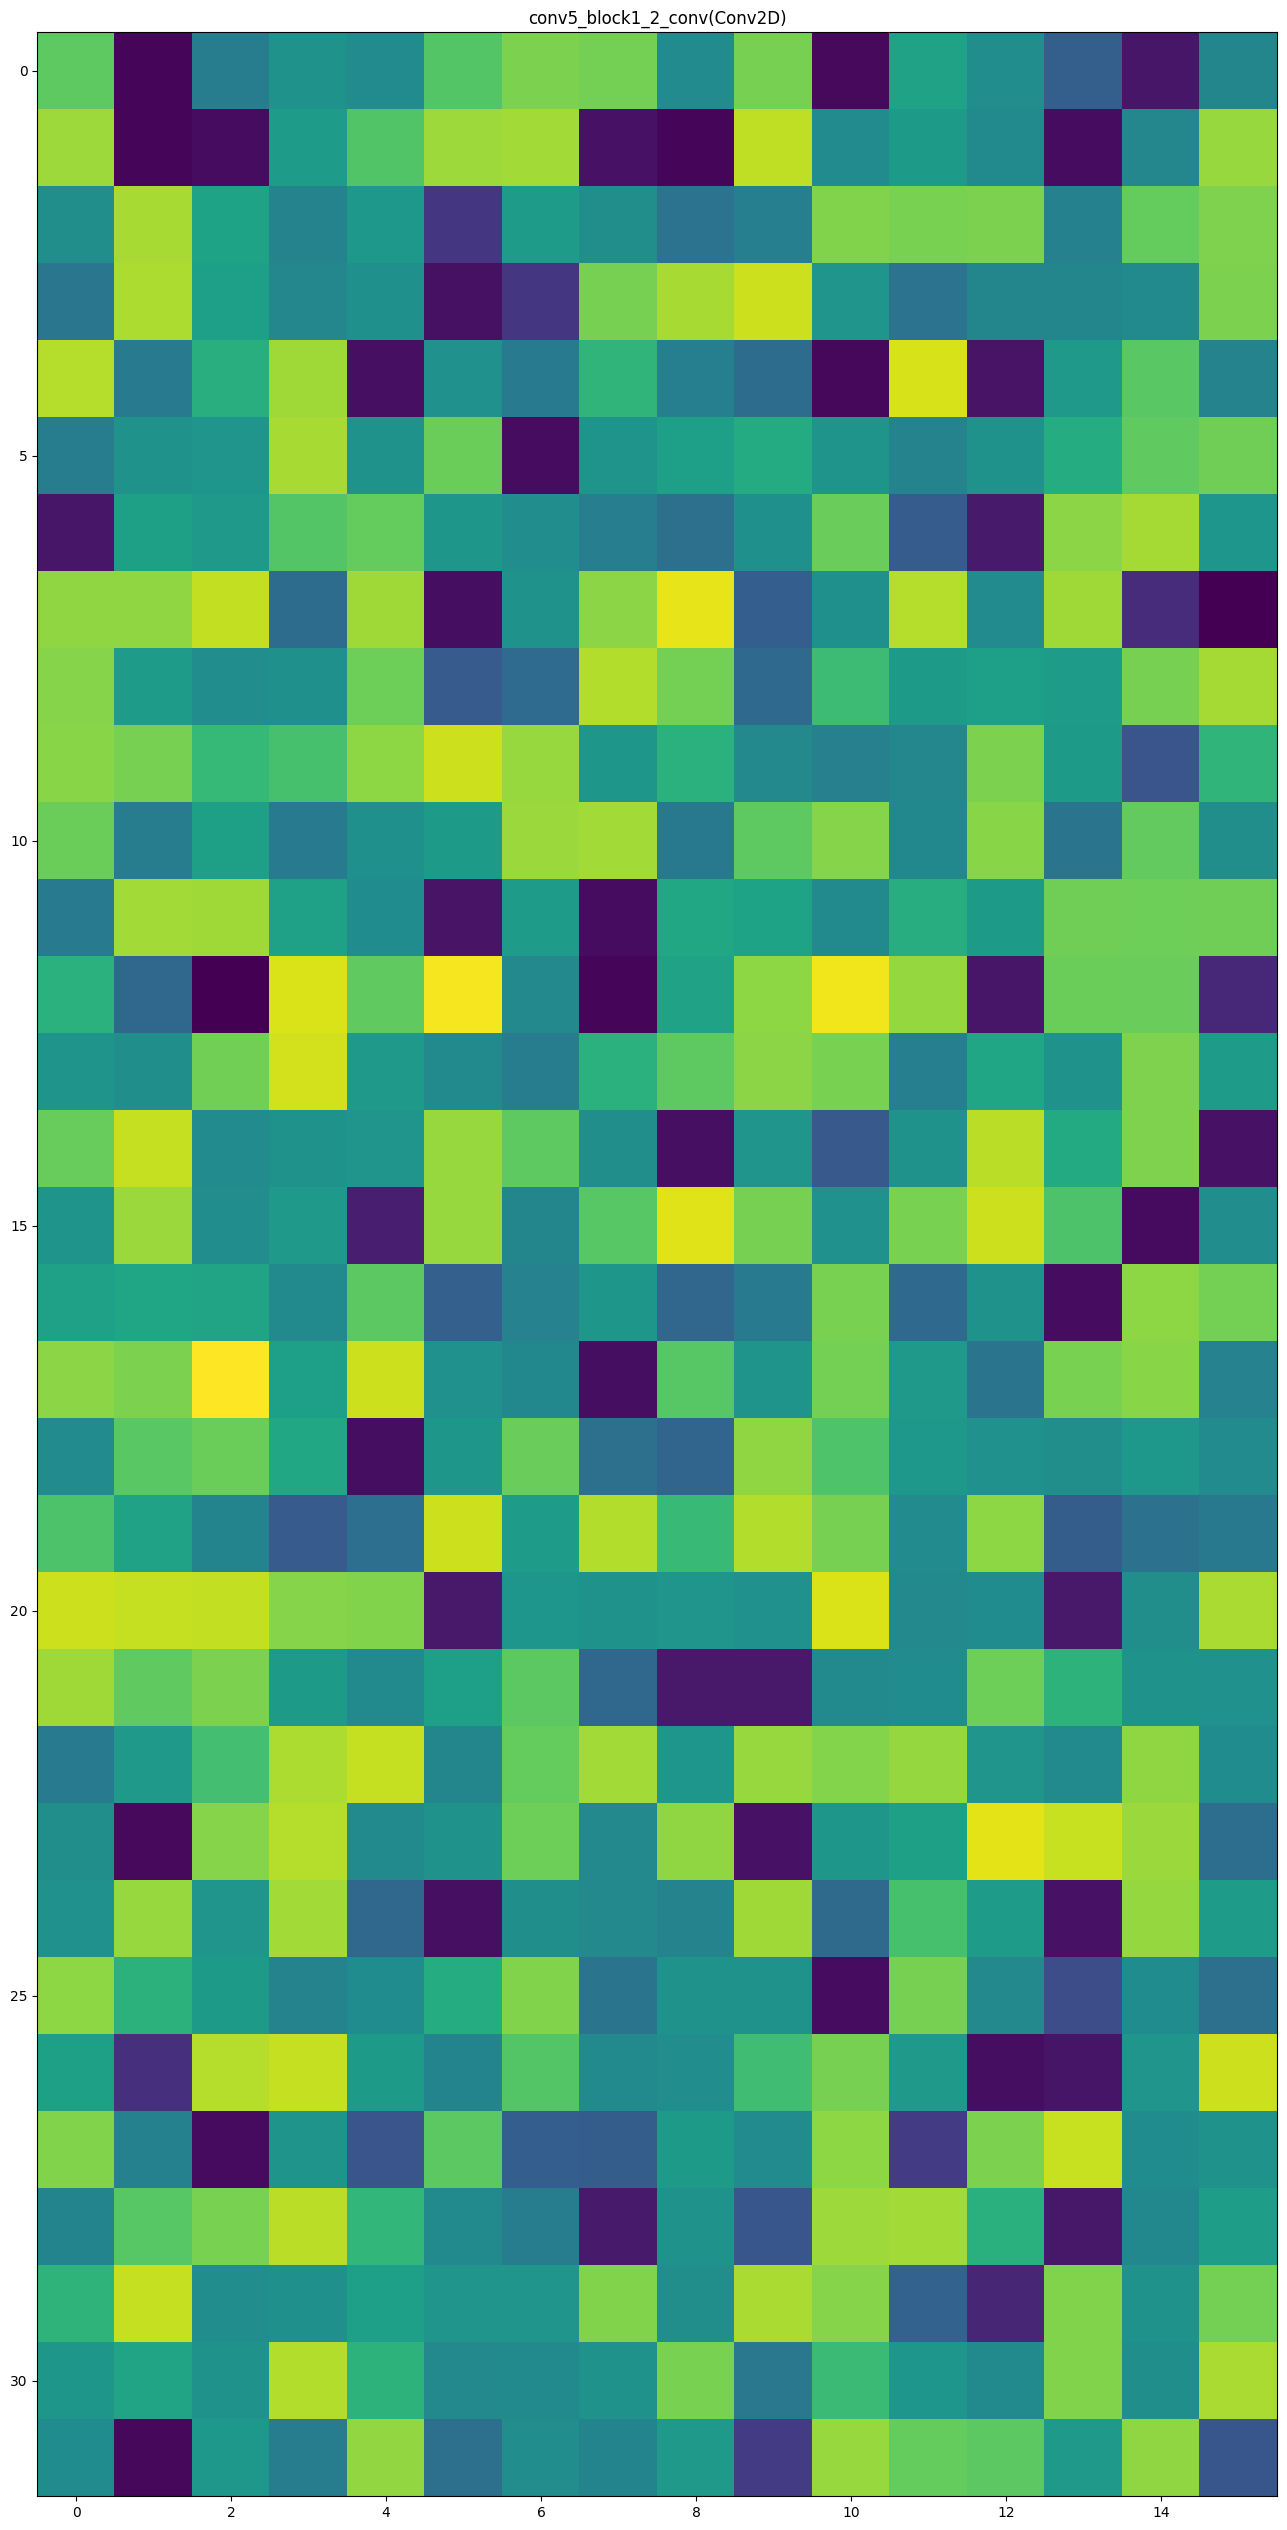

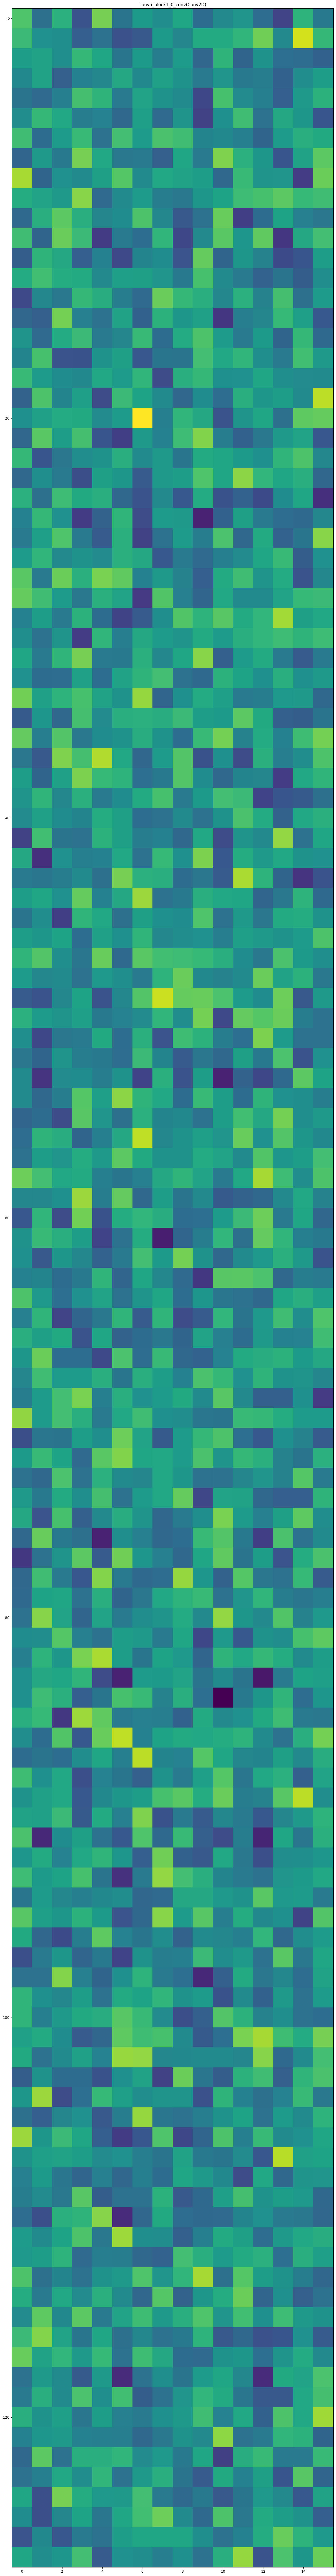

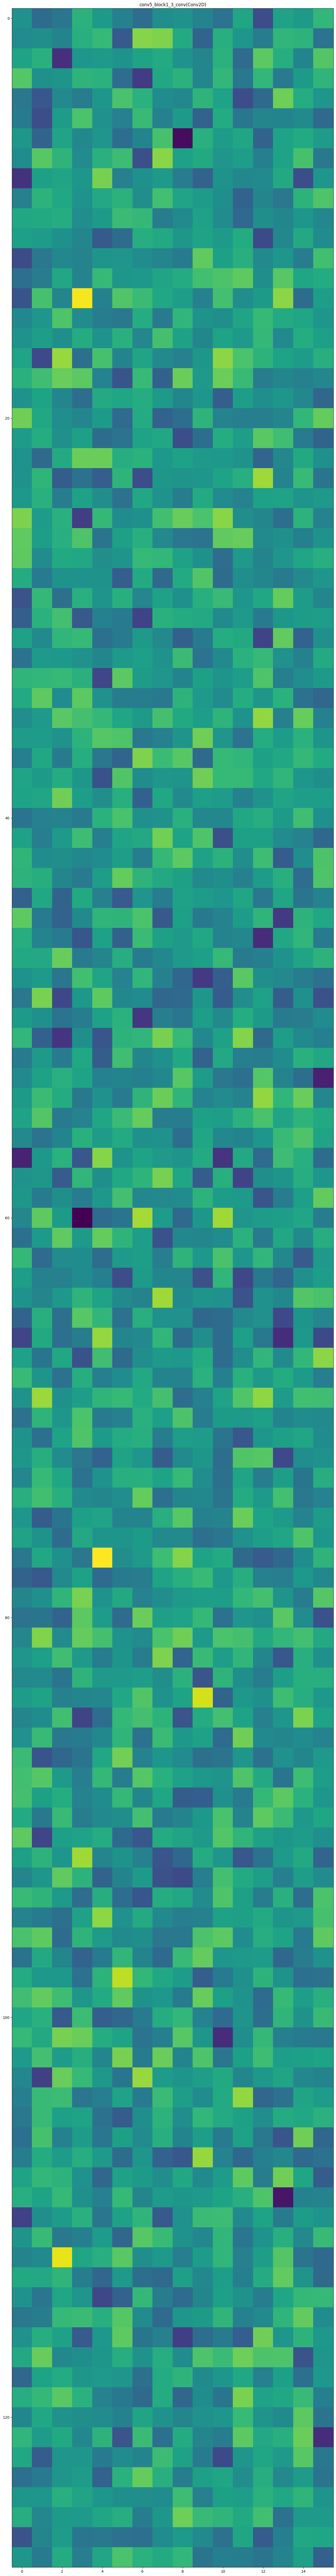

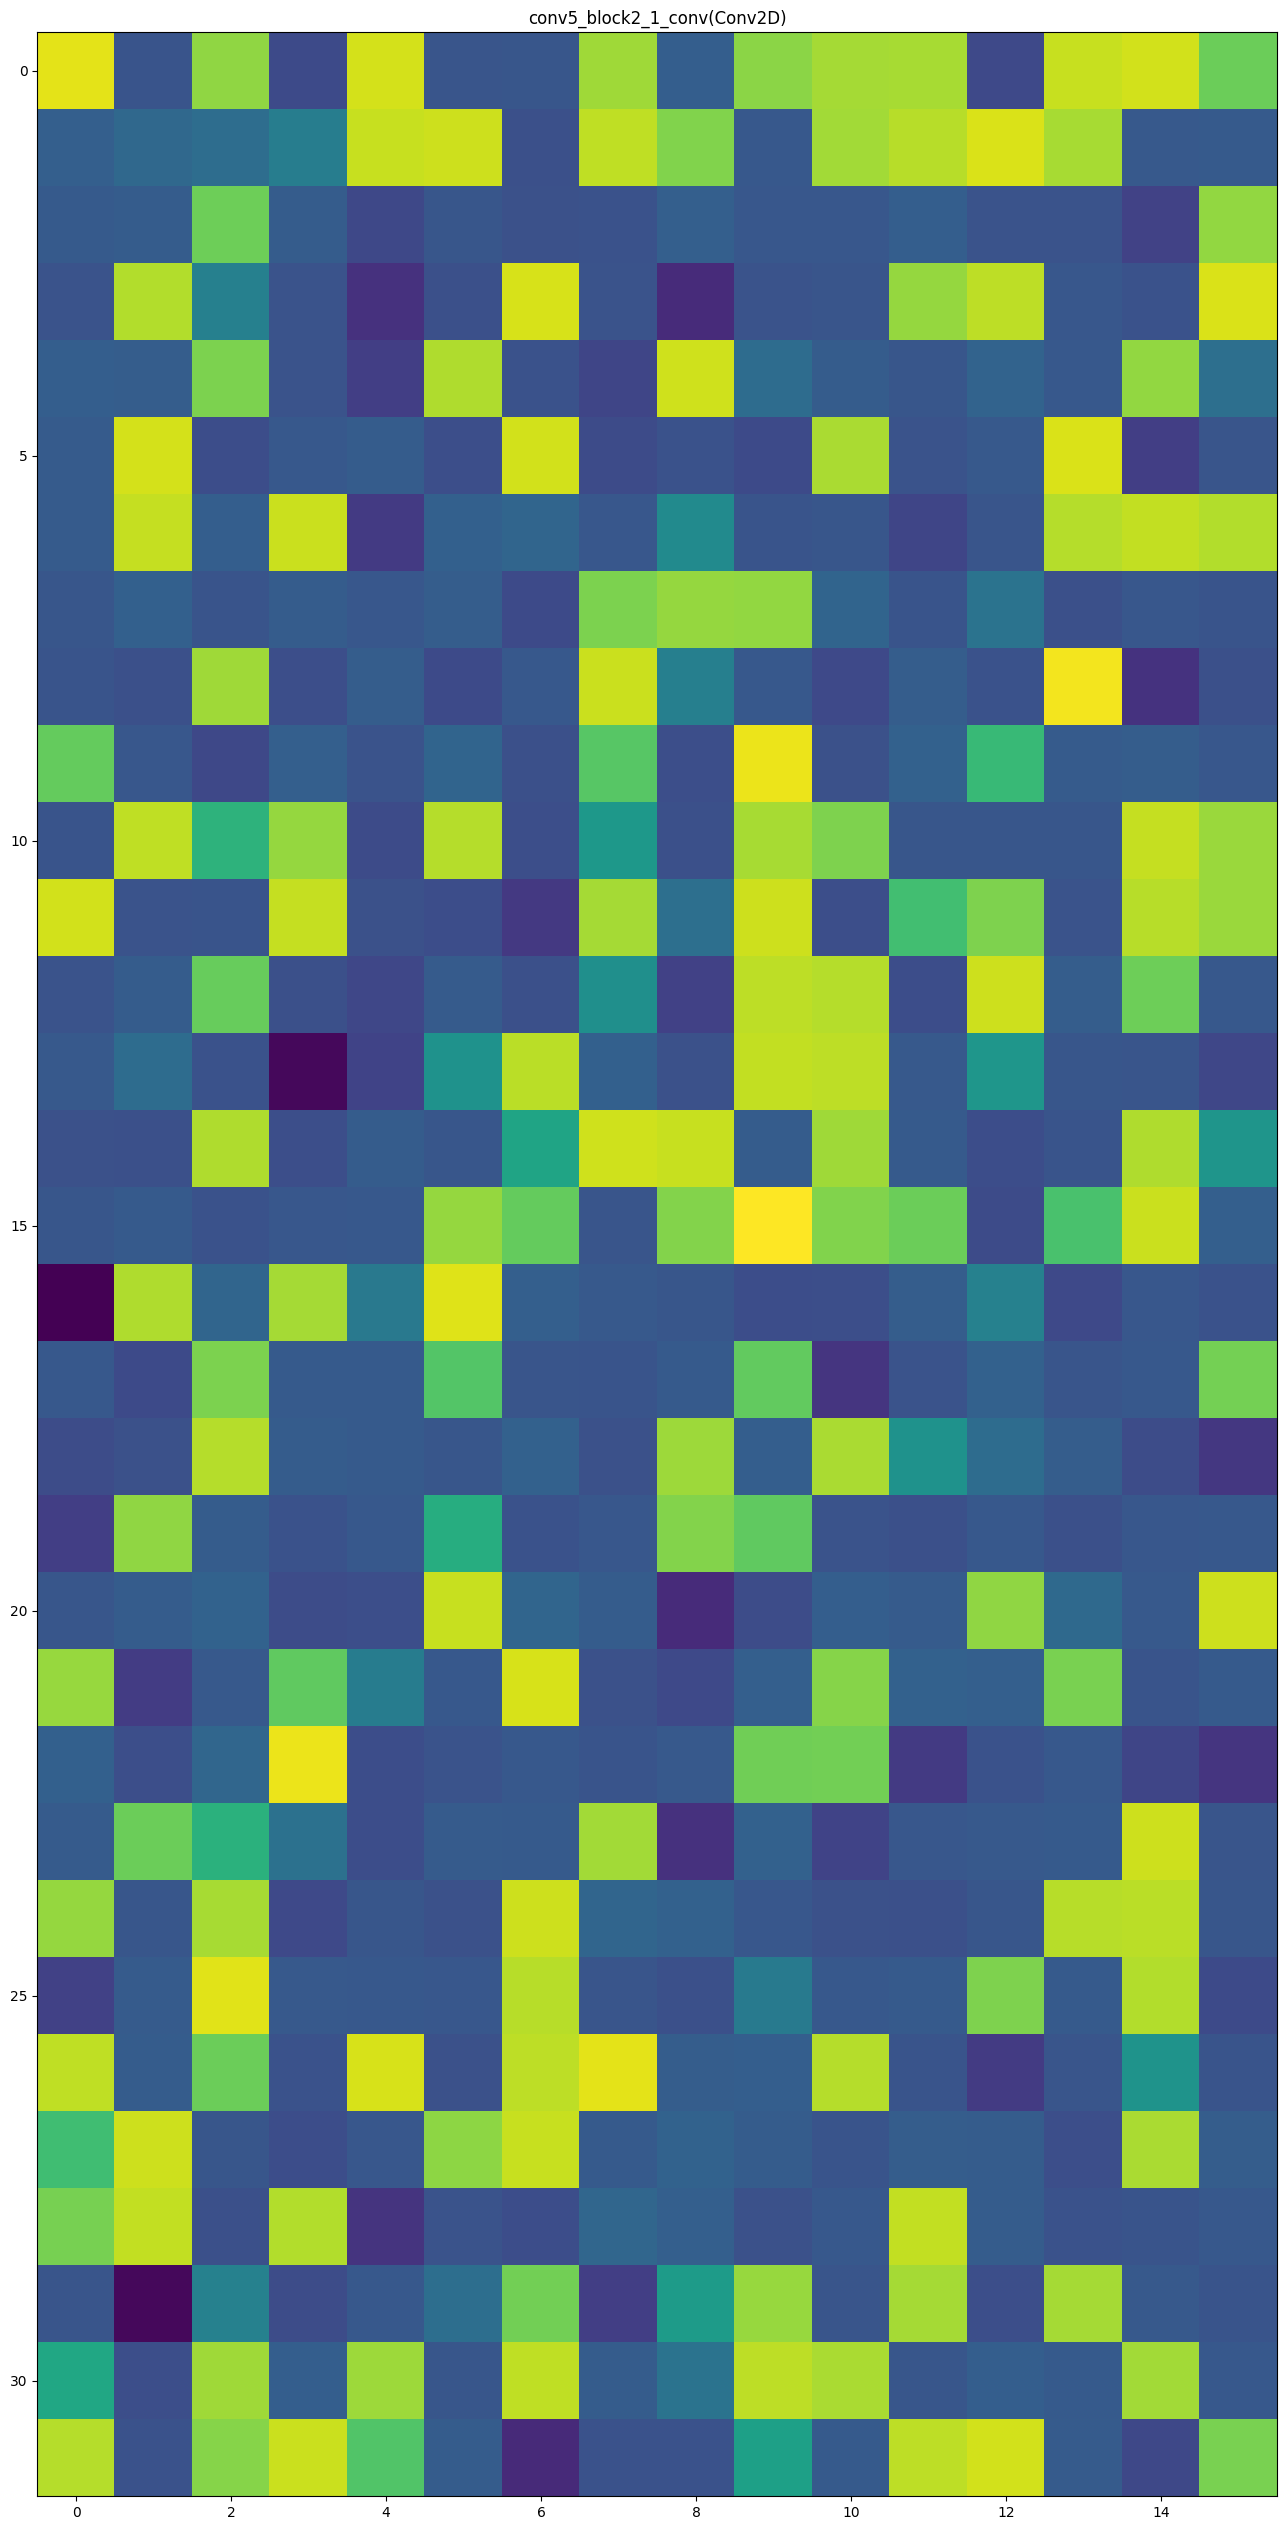

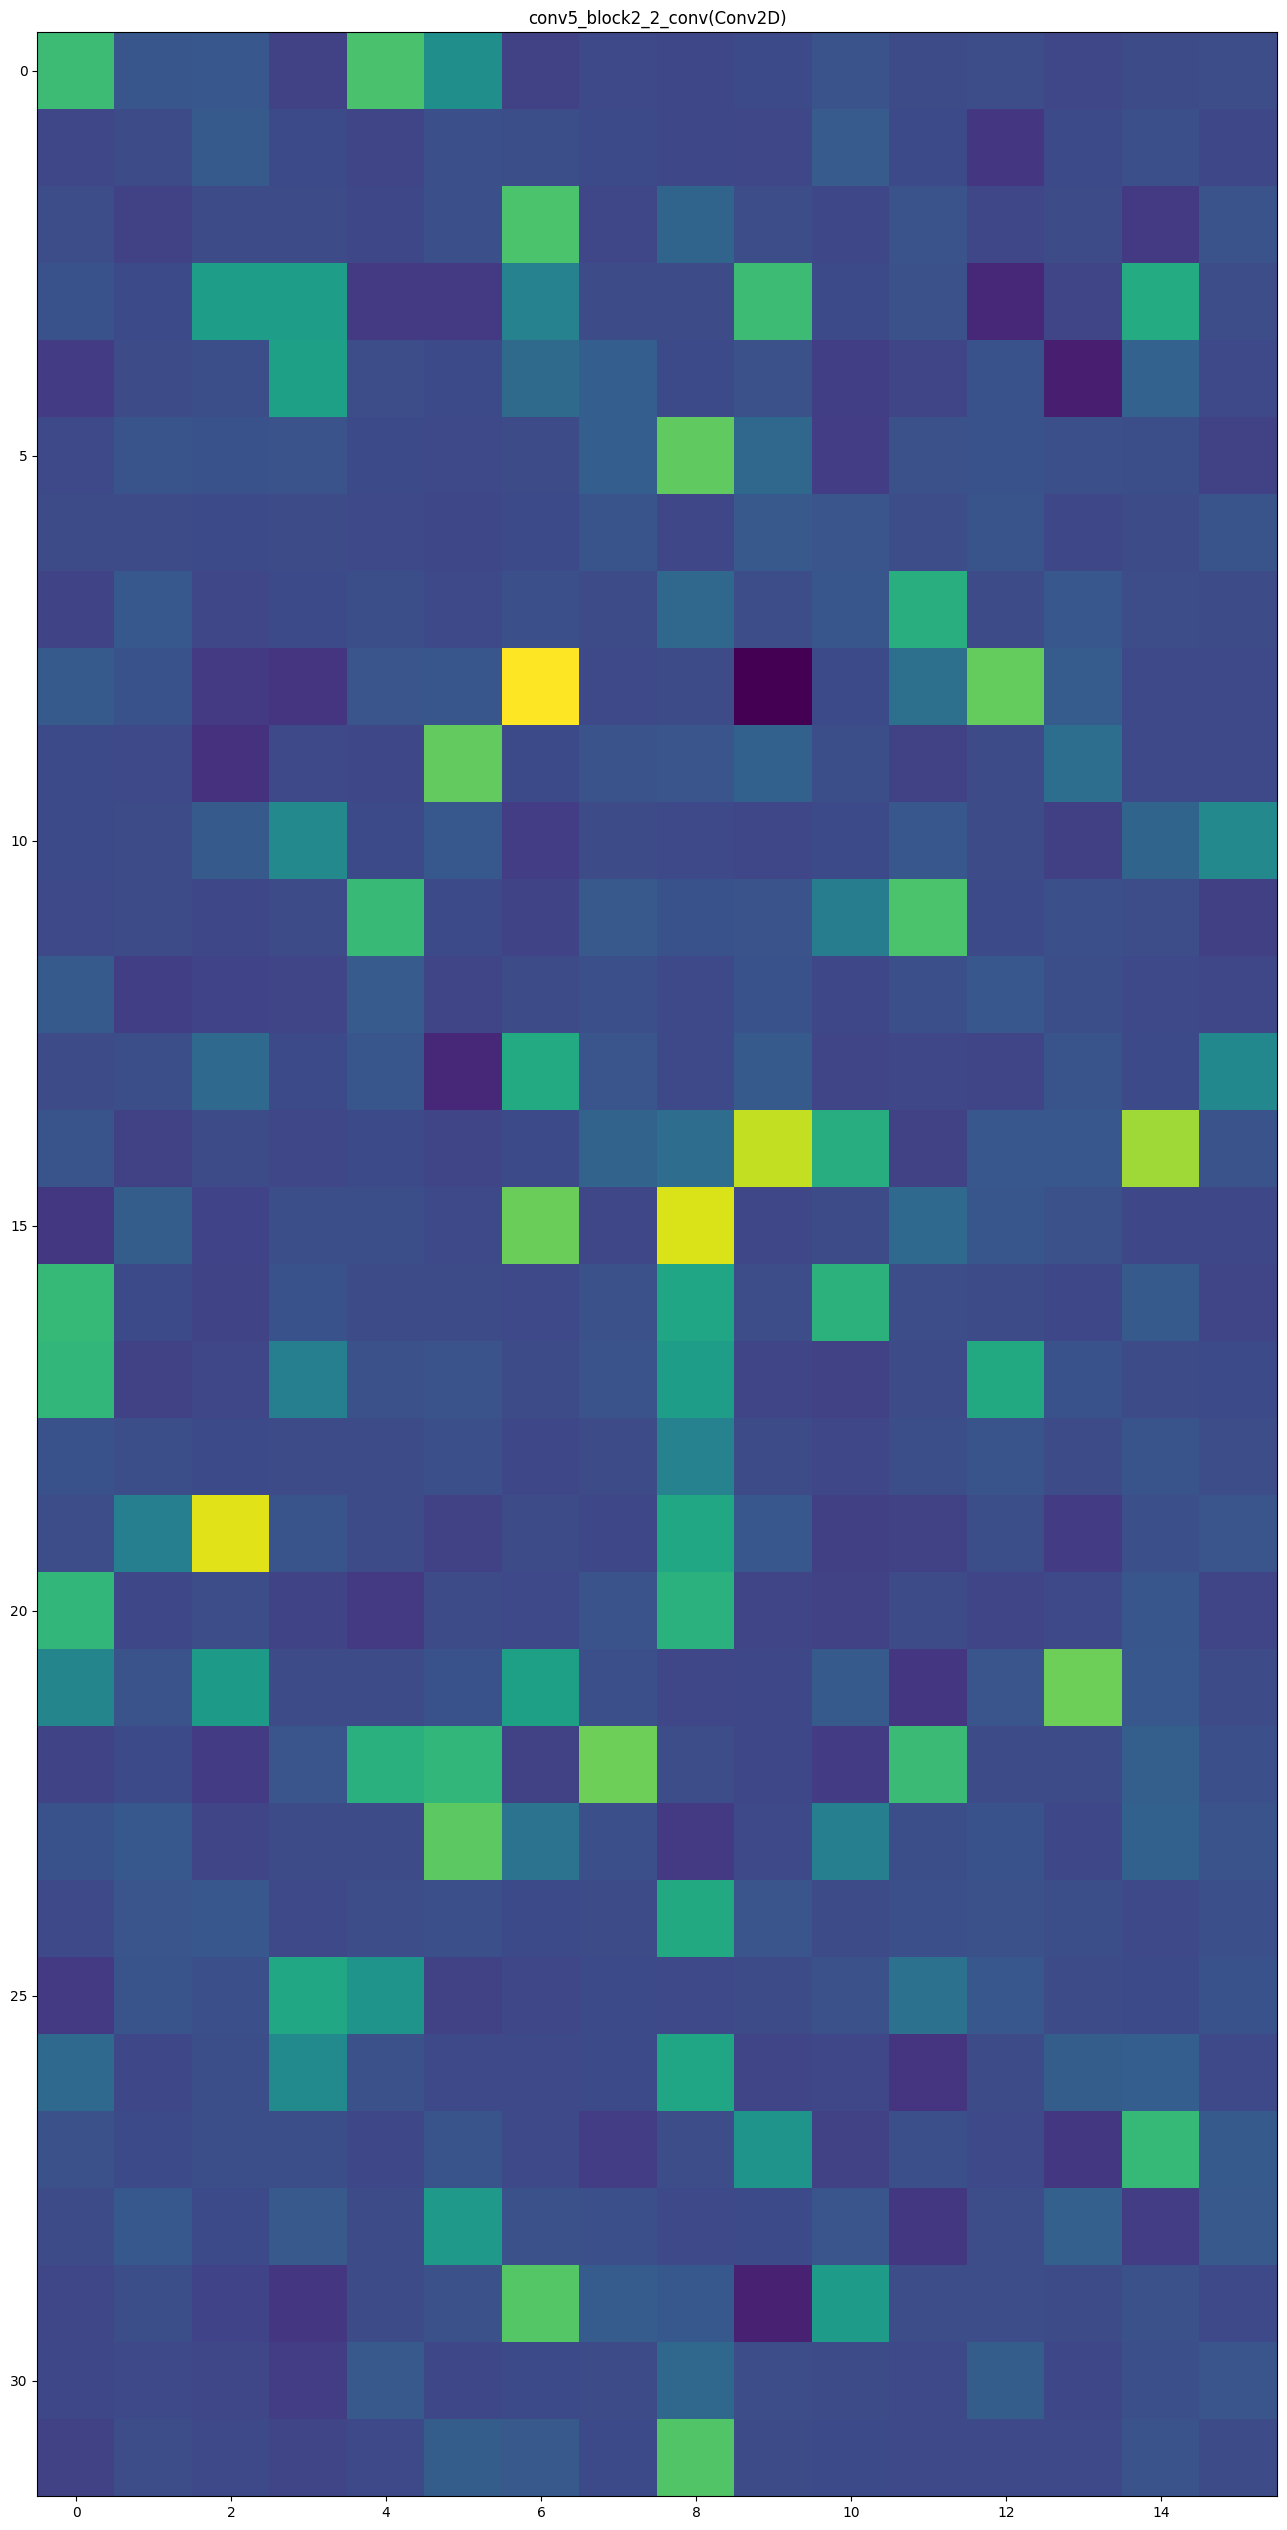

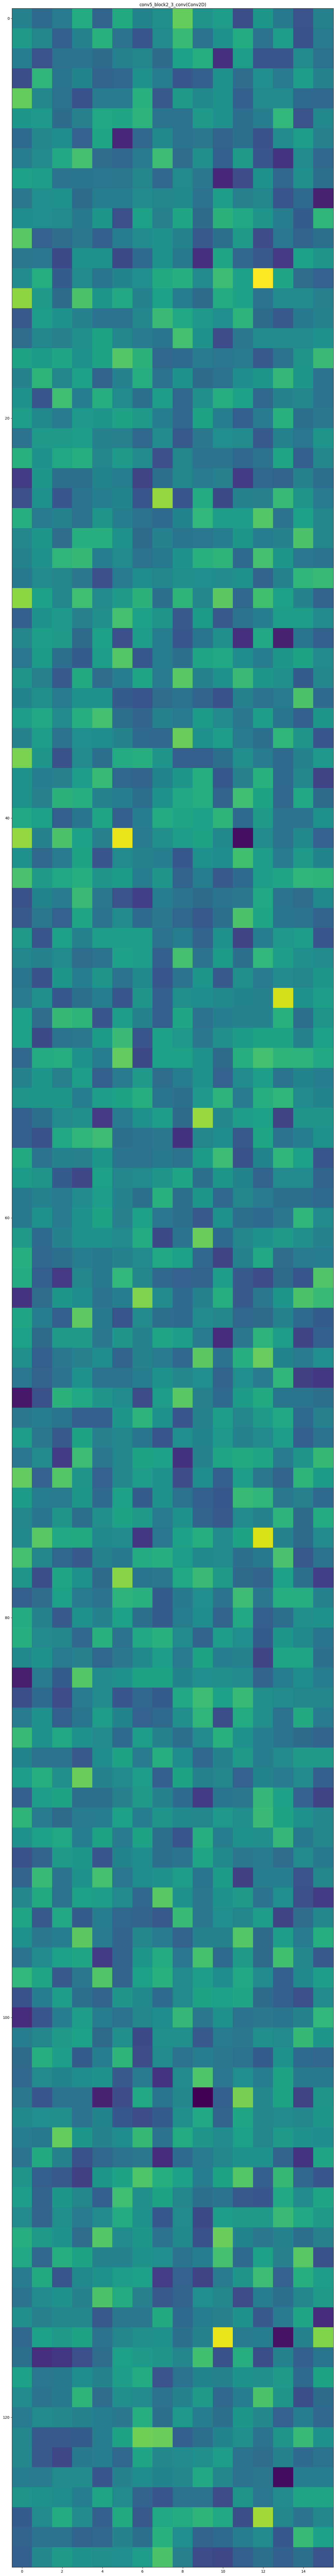

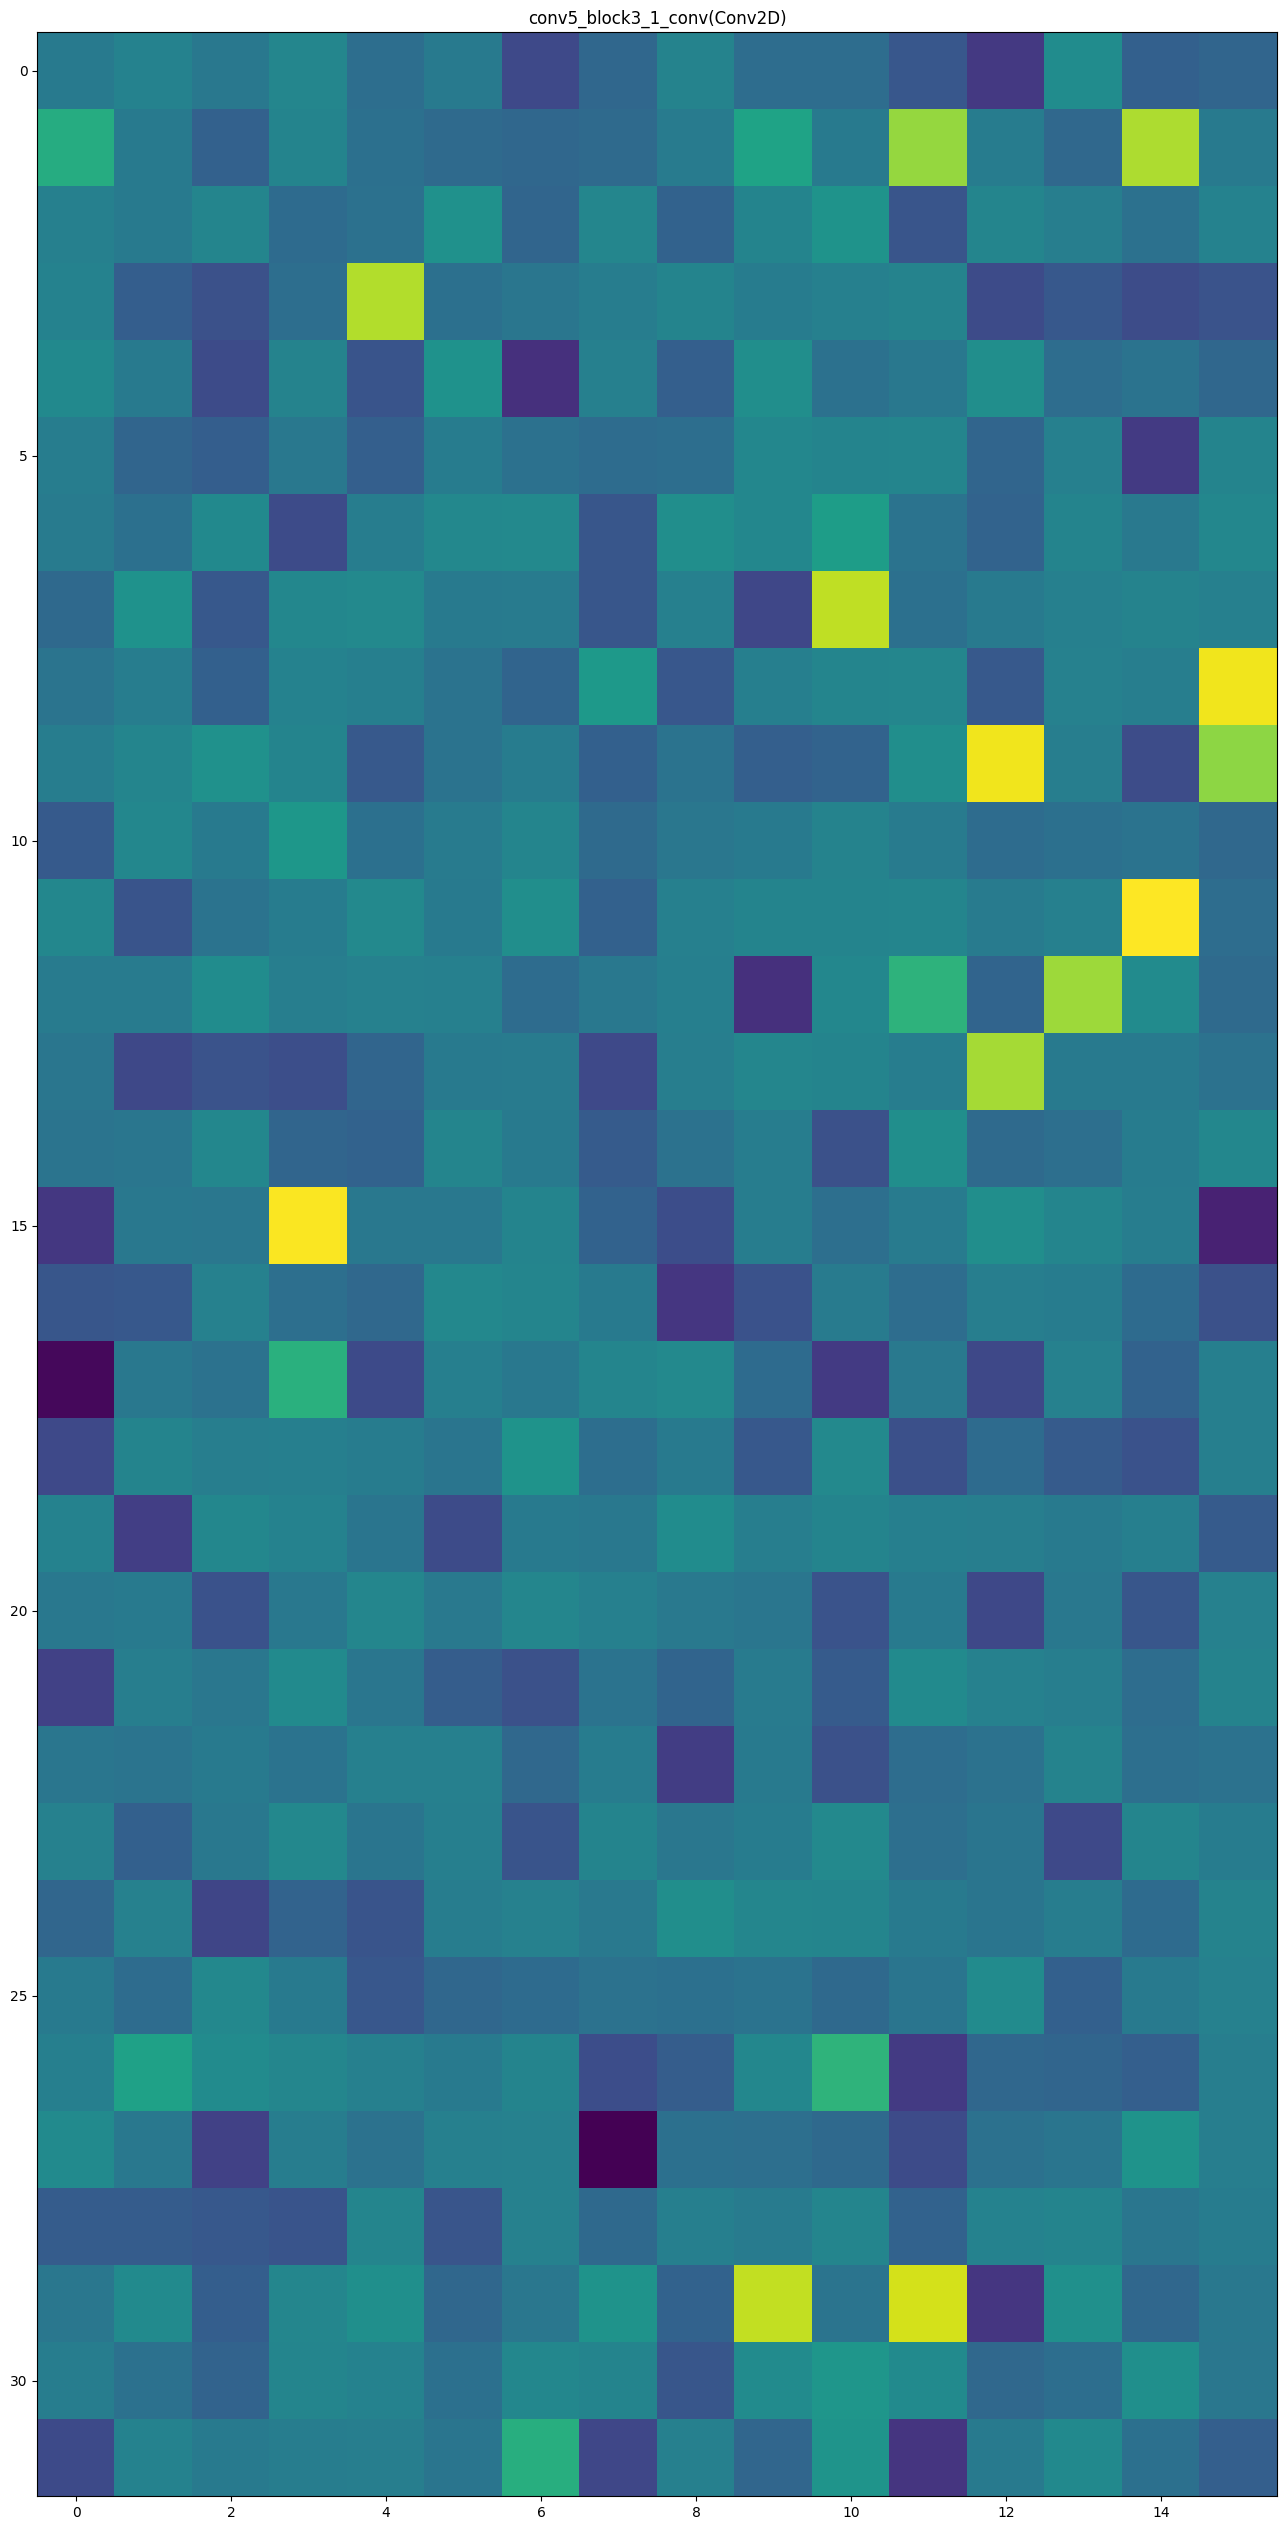

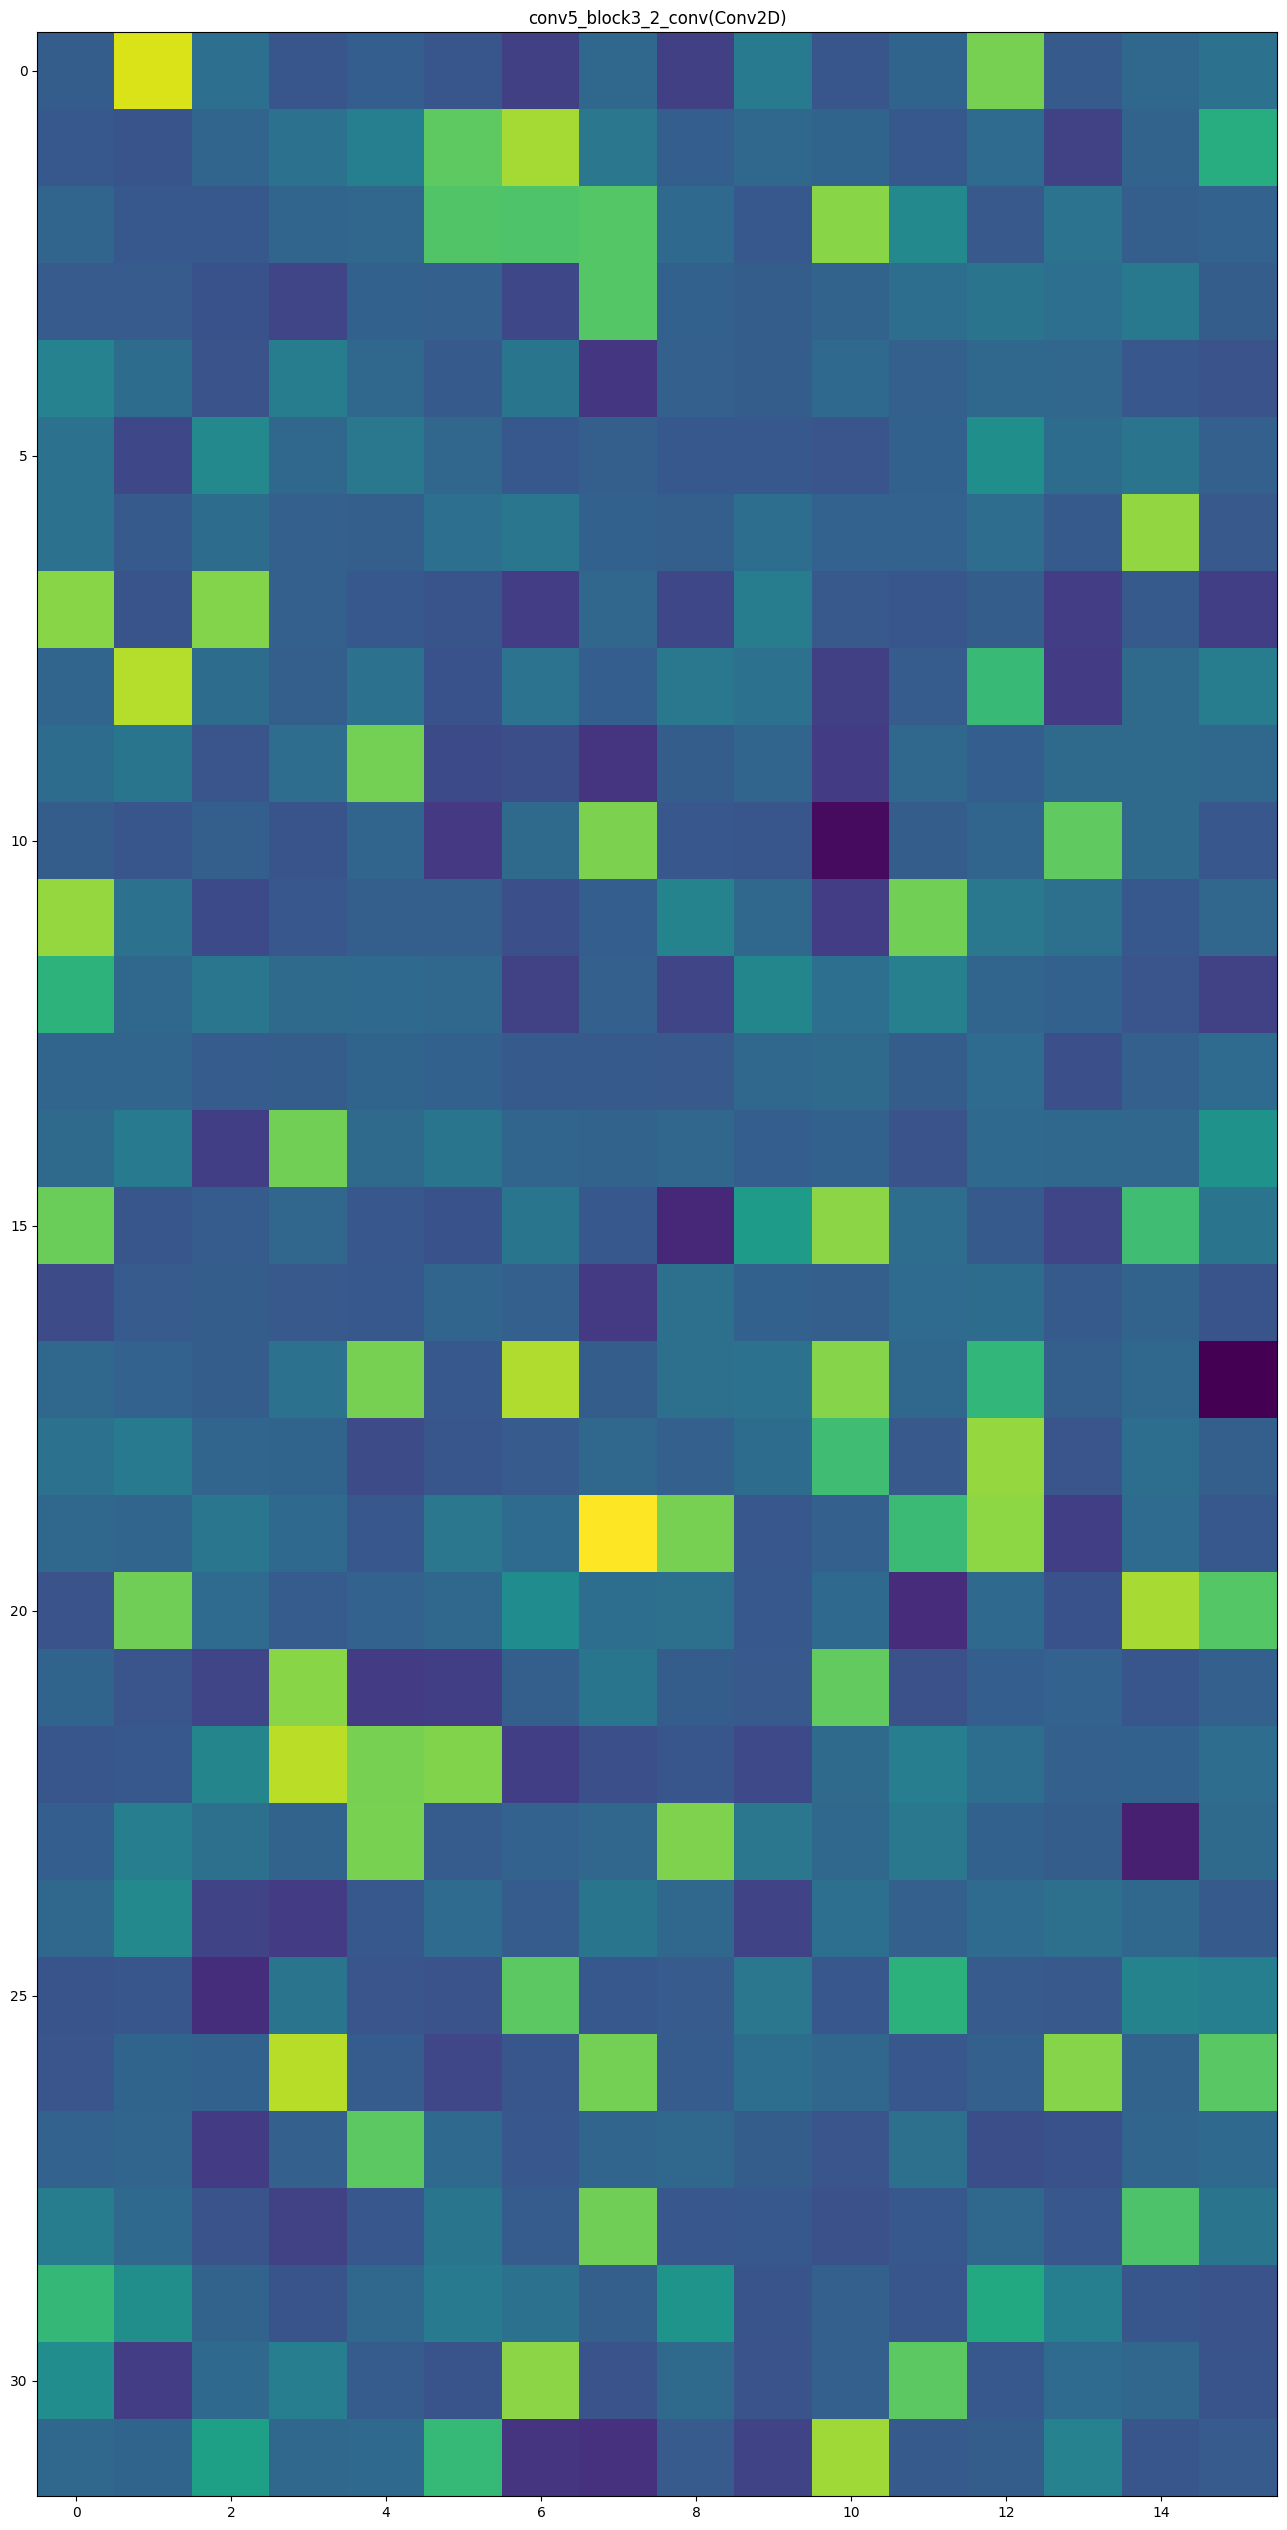

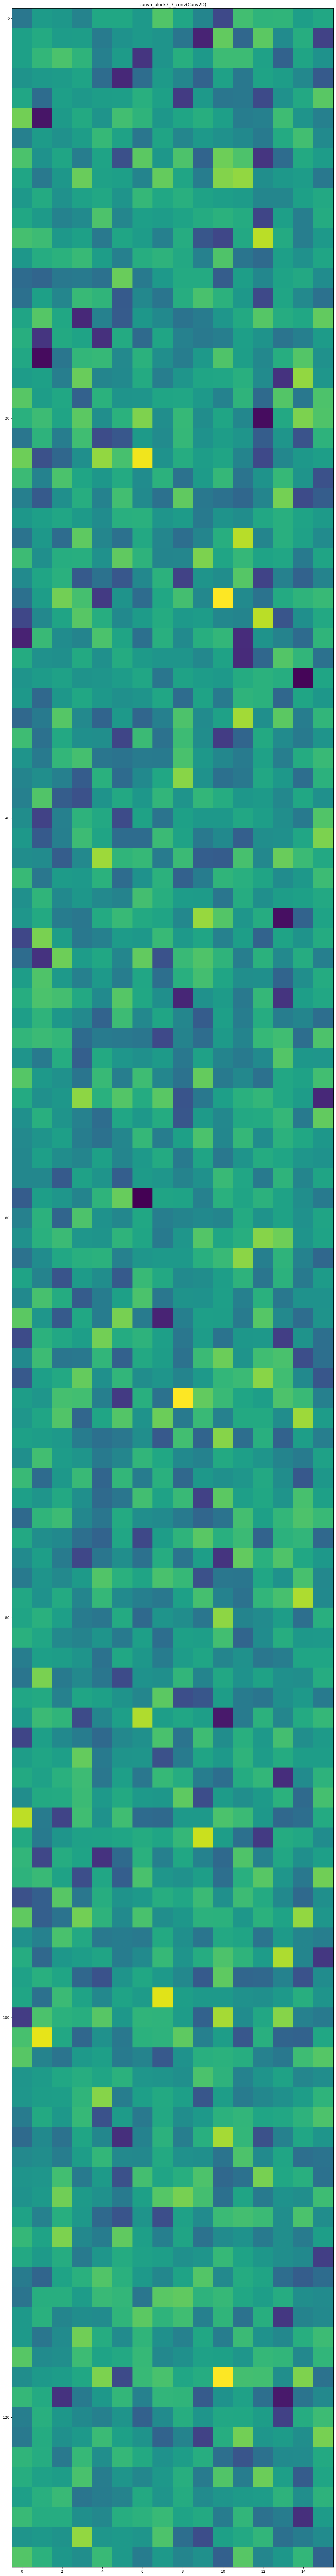

In [ ]:
layer_names = get_layer_names(141, 172, ft_model)

# Now let's display our feature maps

plot_feature_map(layer_names, activations)

3. After feature extraction

In [ ]:
# Extracts the outputs of first block:
layer_outputs = [layer.output for layer in fe_model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=fe_model.input, outputs=layer_outputs)
activations = activation_model.predict(ship_img_tensor)

1/1 [==============================] - 0s 64ms/step


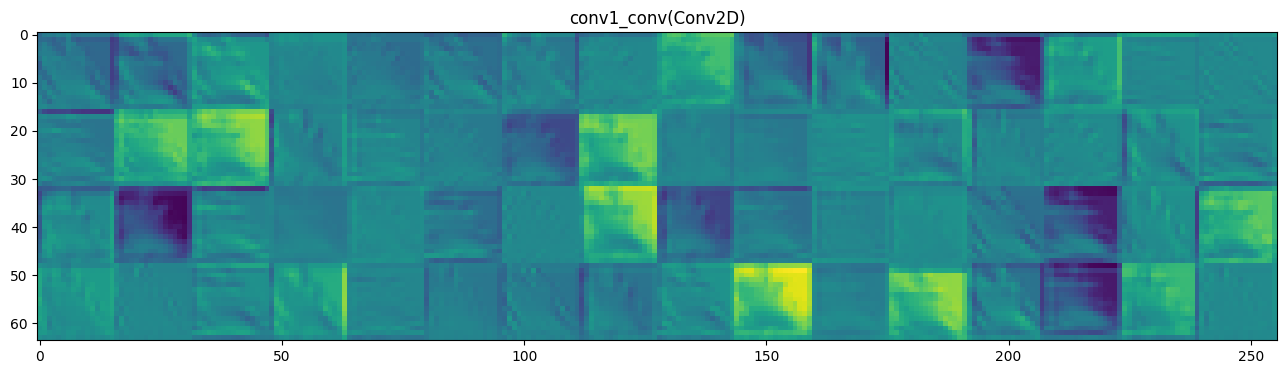

In [ ]:
#Plot feature map for the first block
layer_names = get_layer_names(0, 6, fe_model)

# Now let's display our feature maps
plot_feature_map(layer_names, activations)

In [ ]:
# Extracts the outputs of Block 3
layer_outputs = [layer.output for layer in fe_model.layers[38:78]]

# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=fe_model.input, outputs=layer_outputs)
activations = activation_model.predict(ship_img_tensor)

1/1 [==============================] - 0s 467ms/step


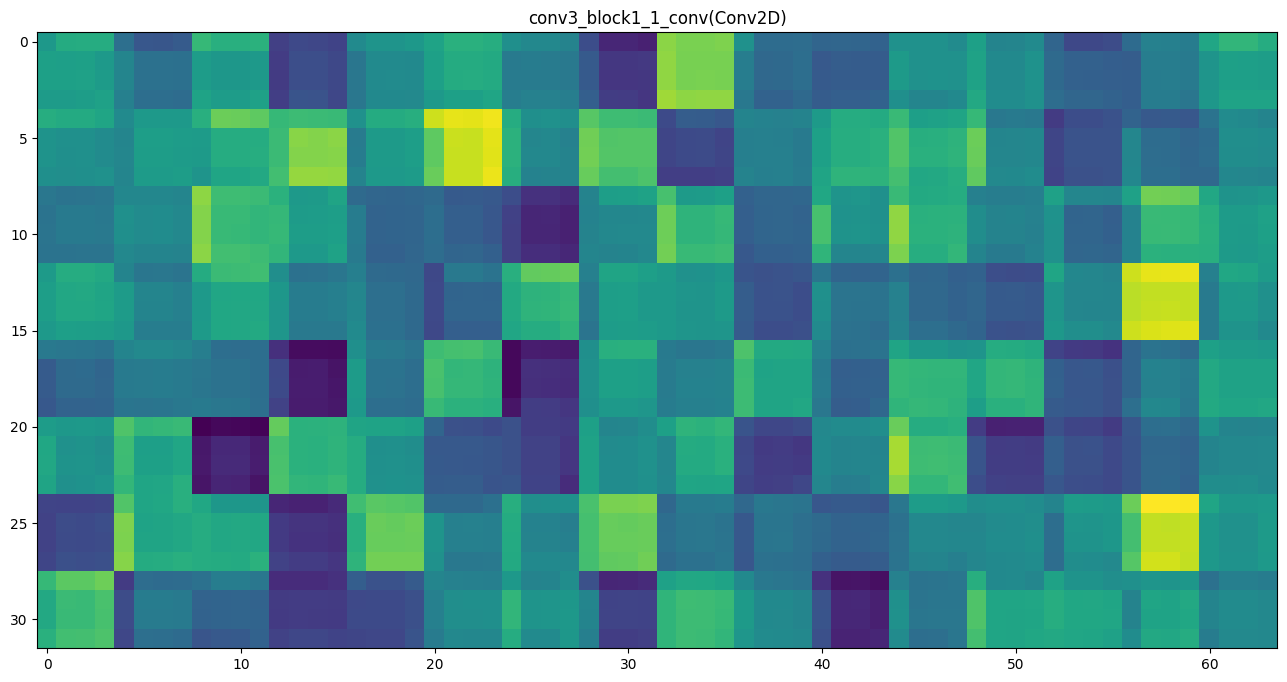

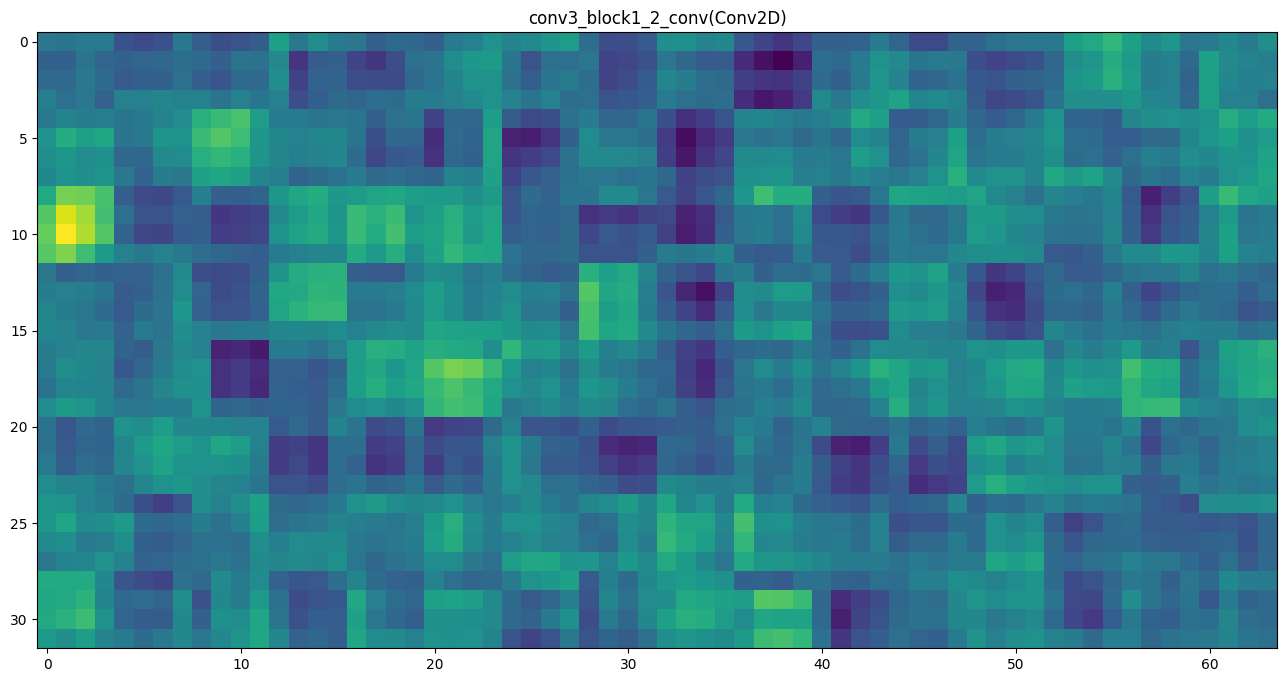

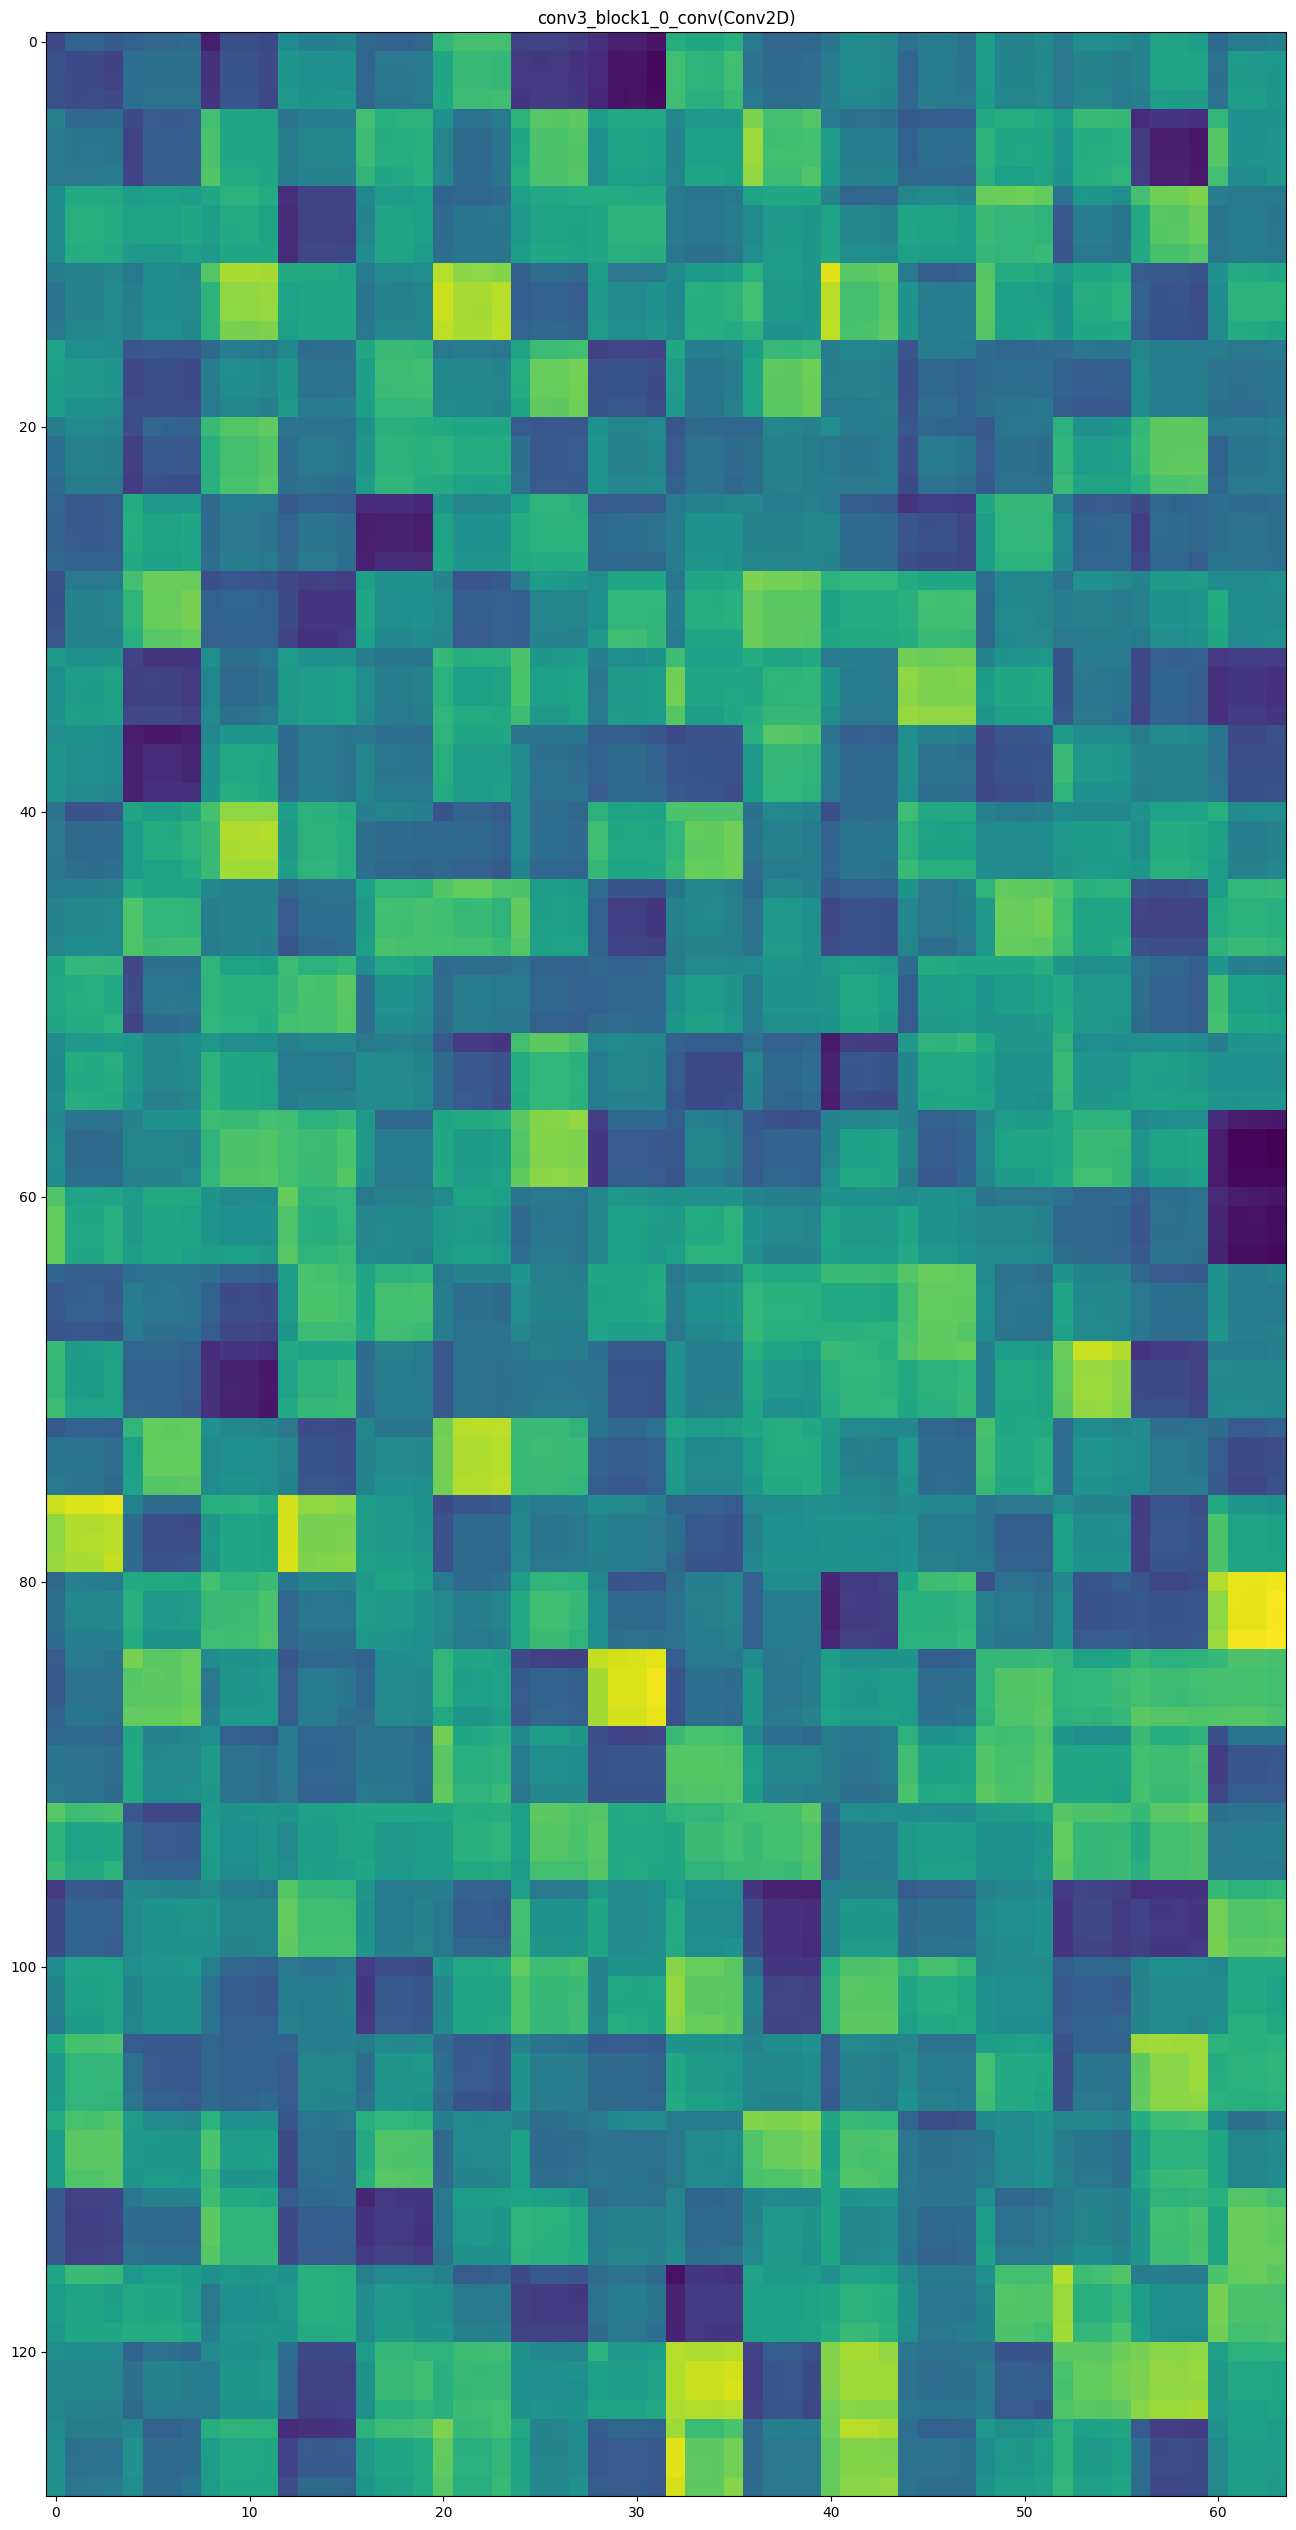

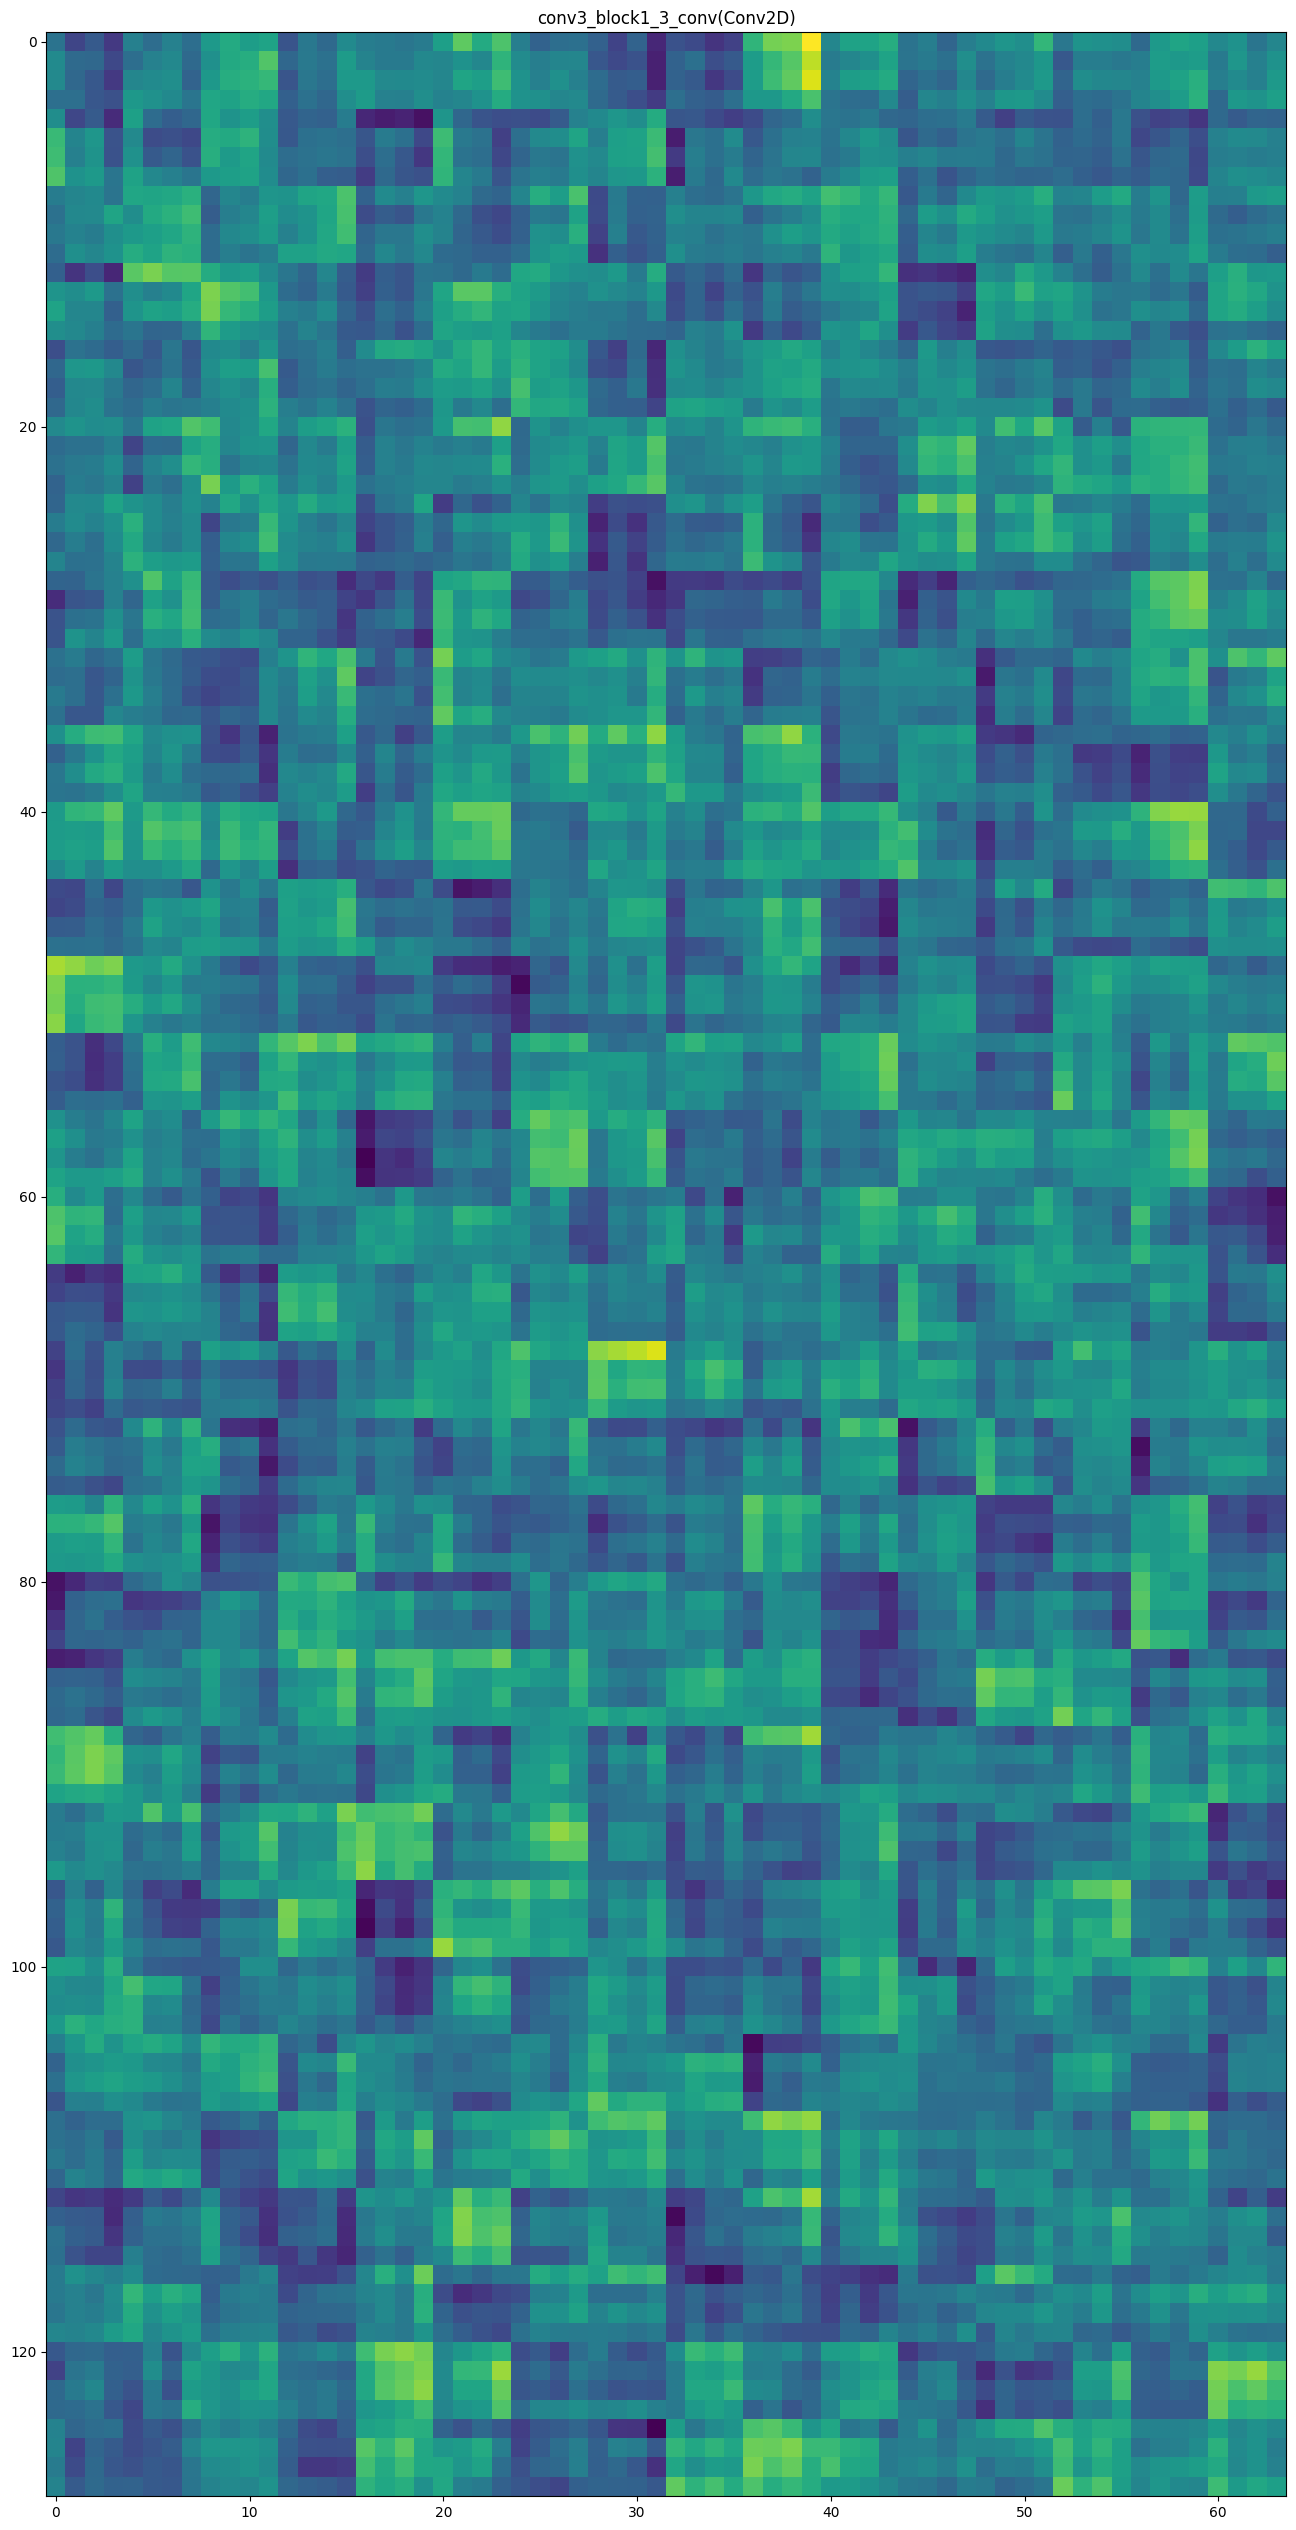

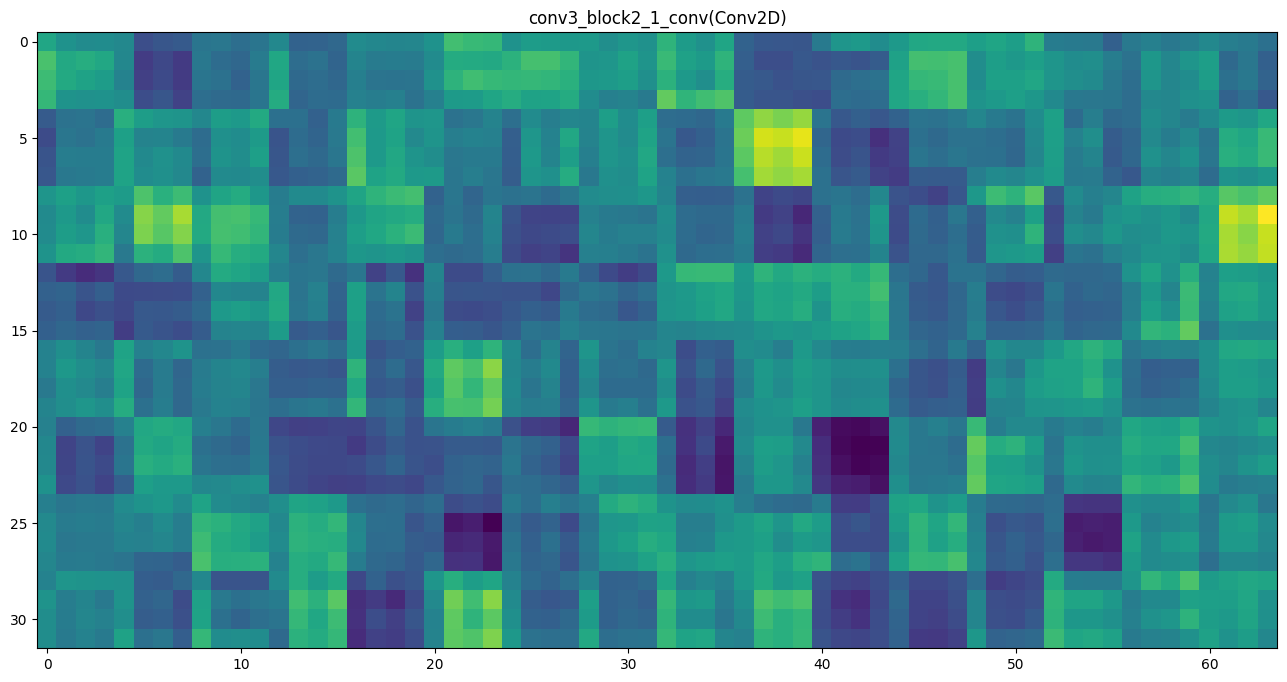

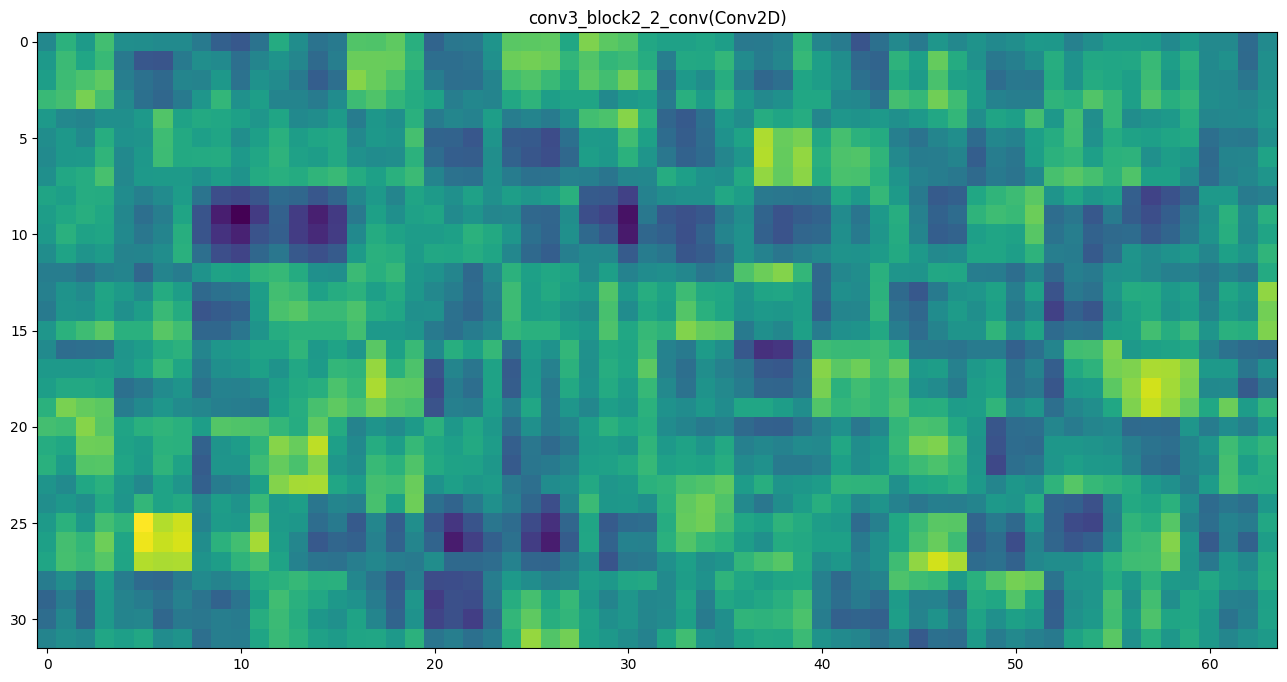

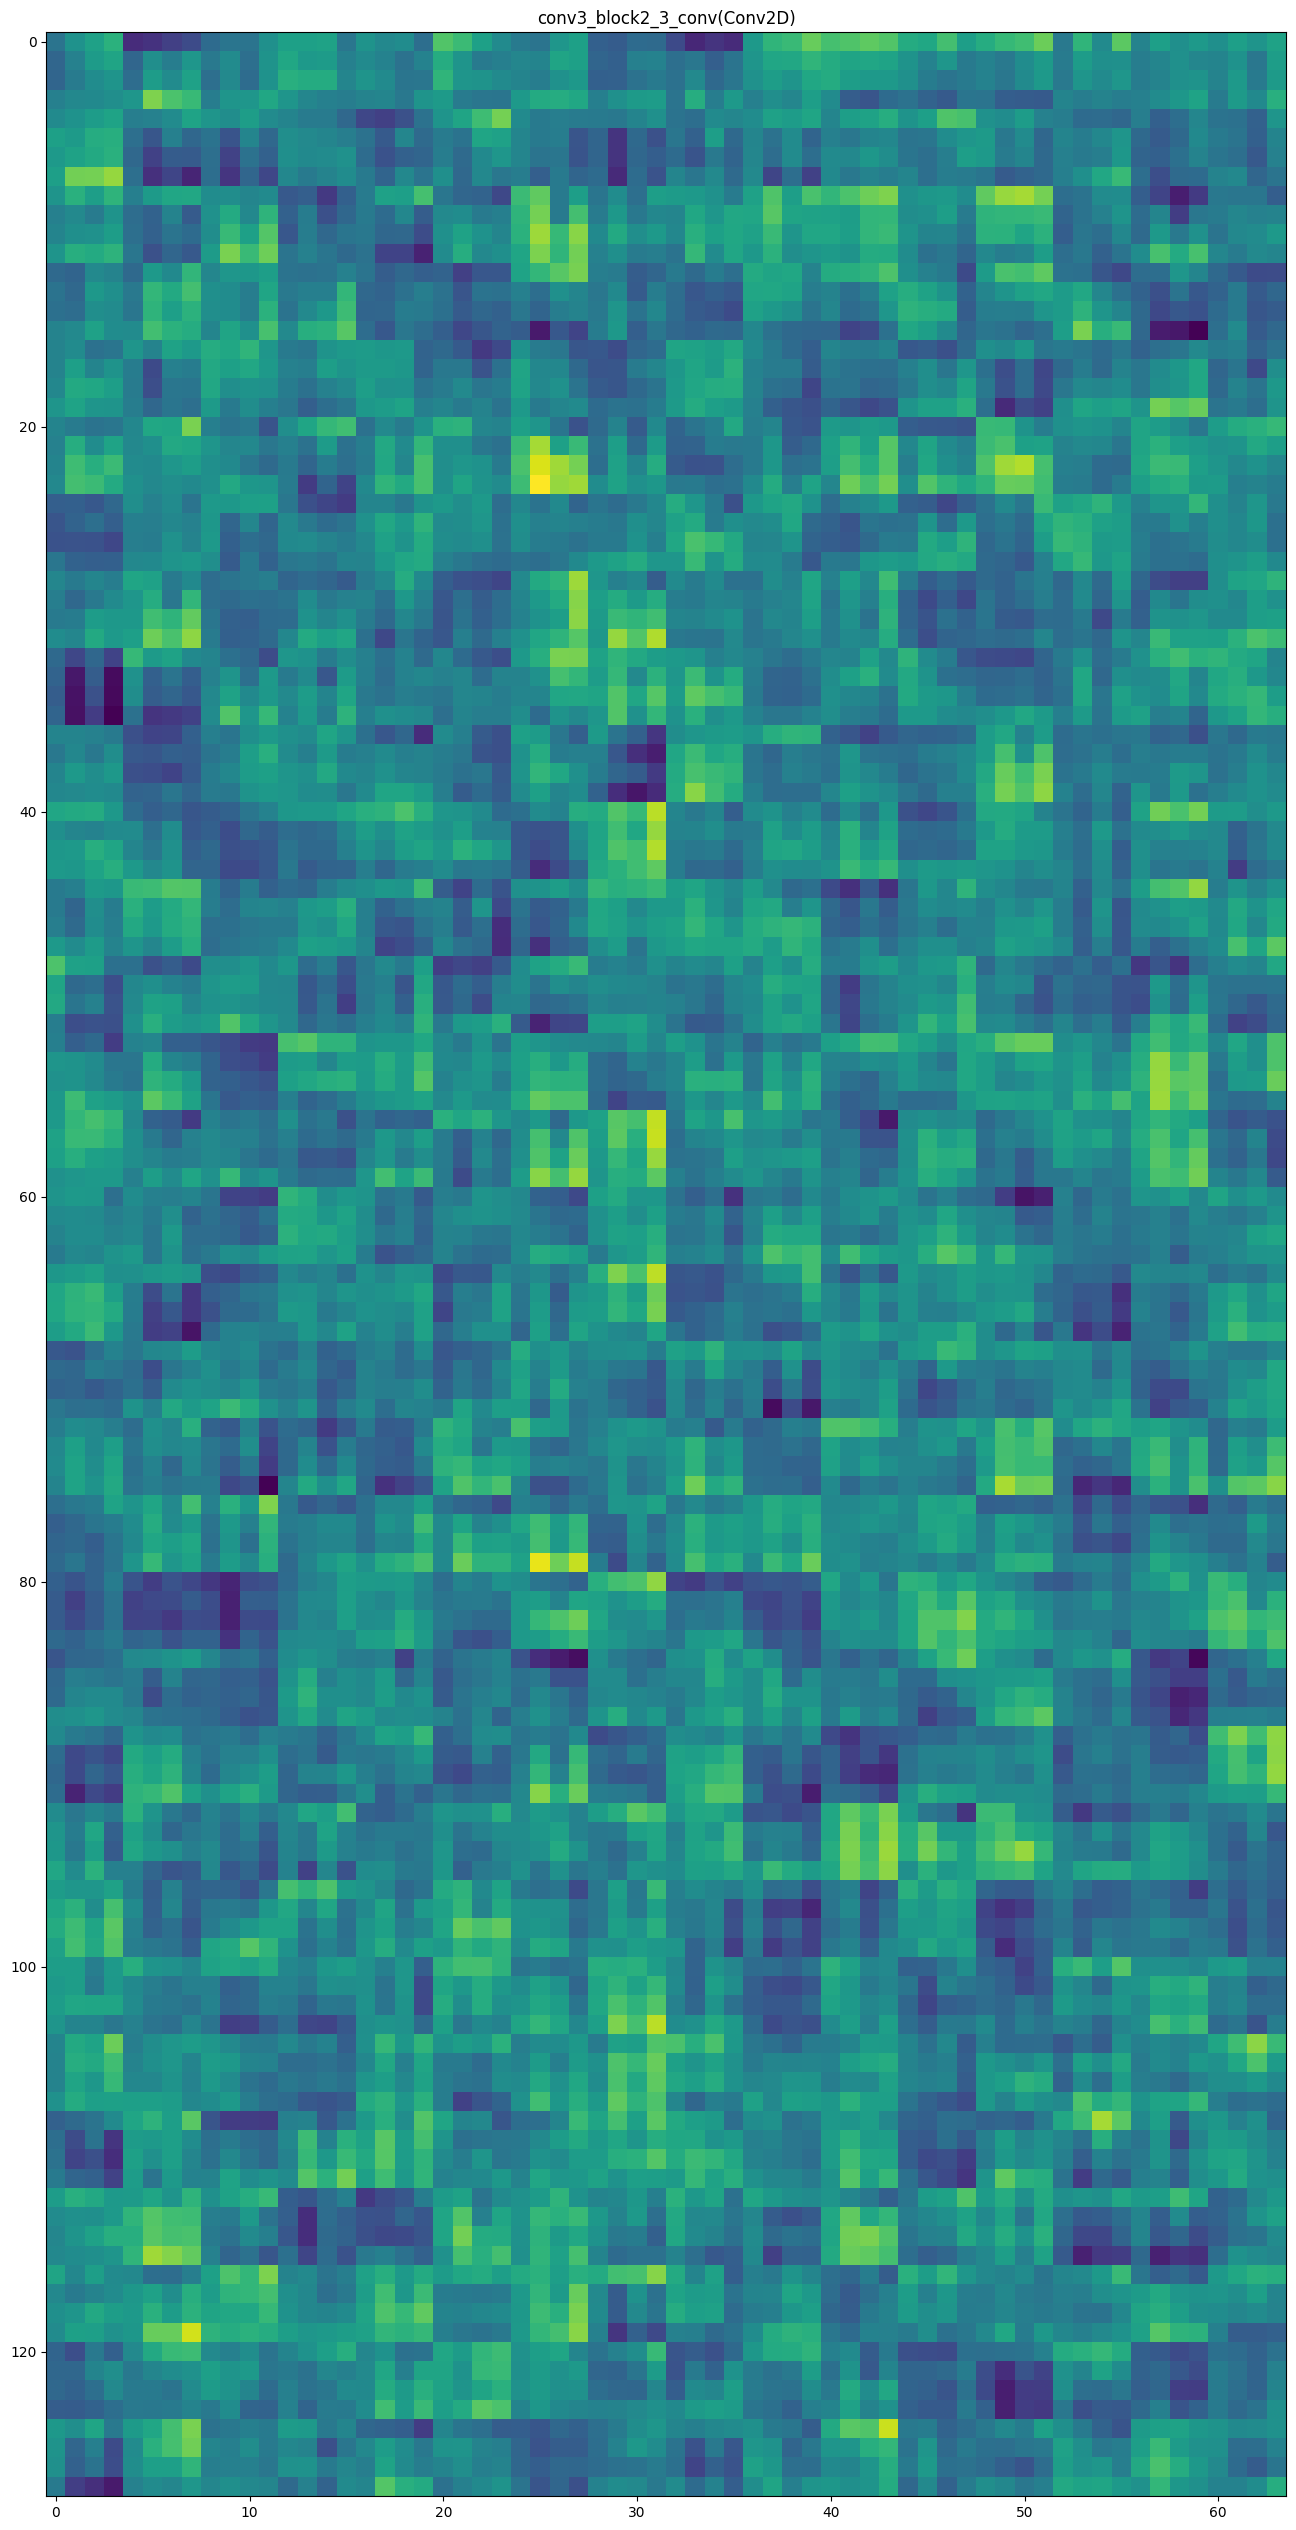

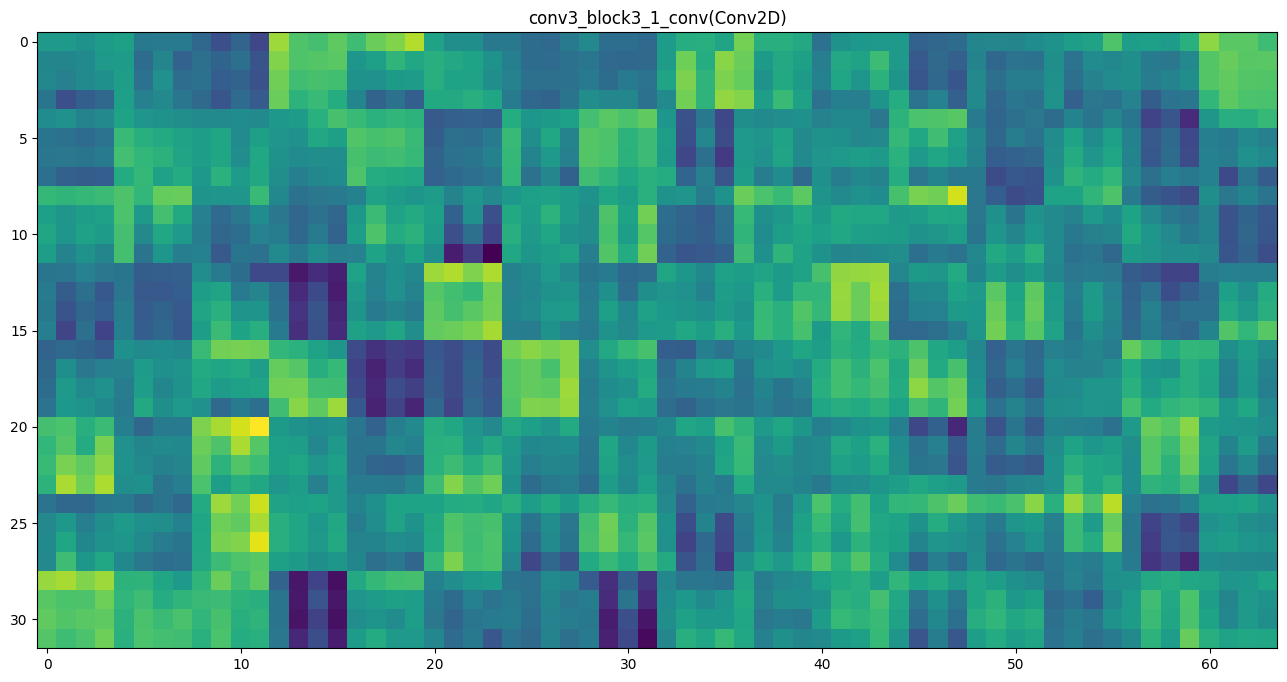

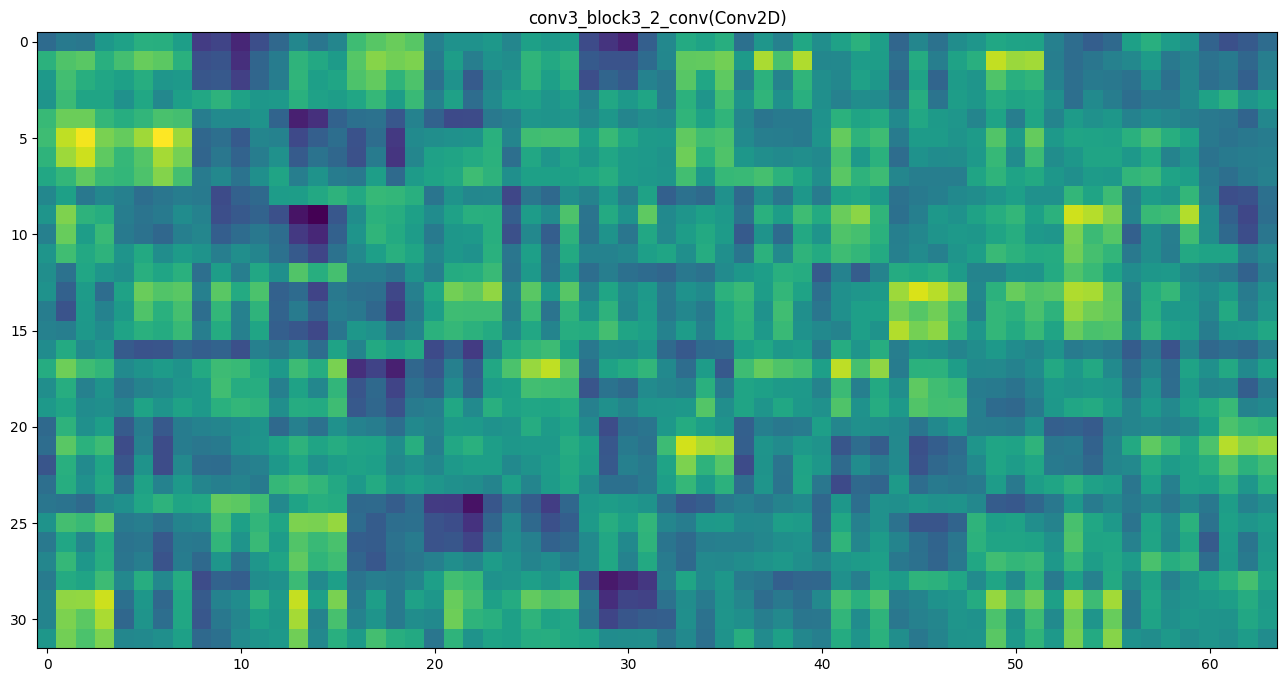

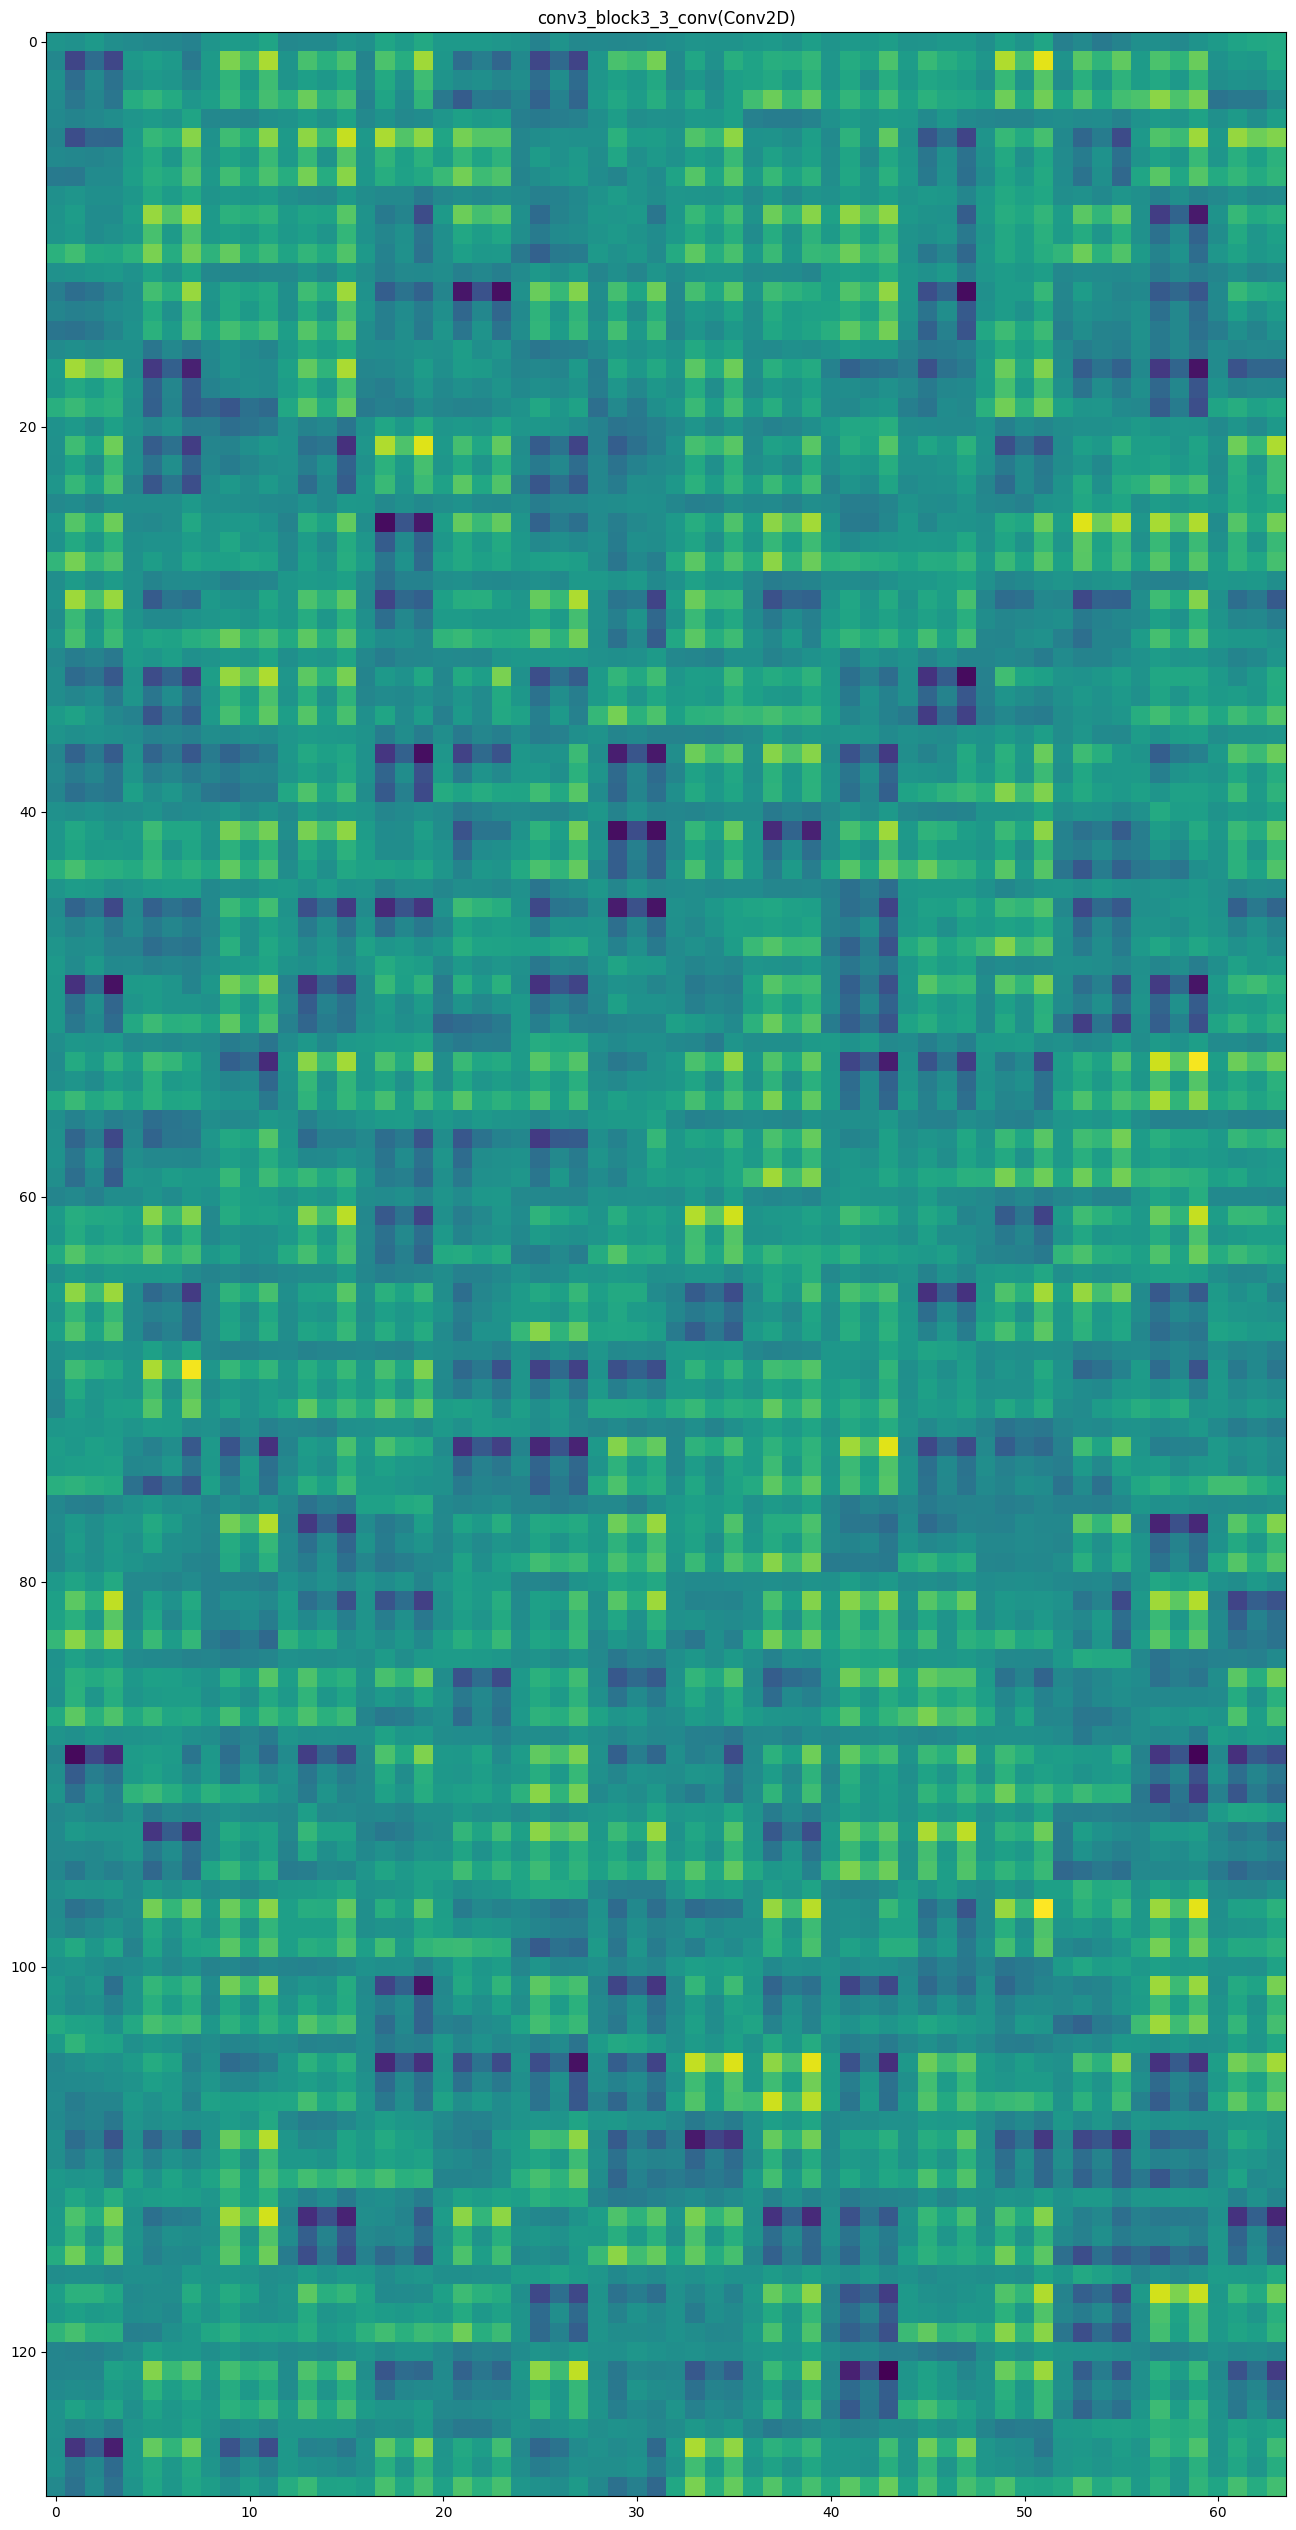

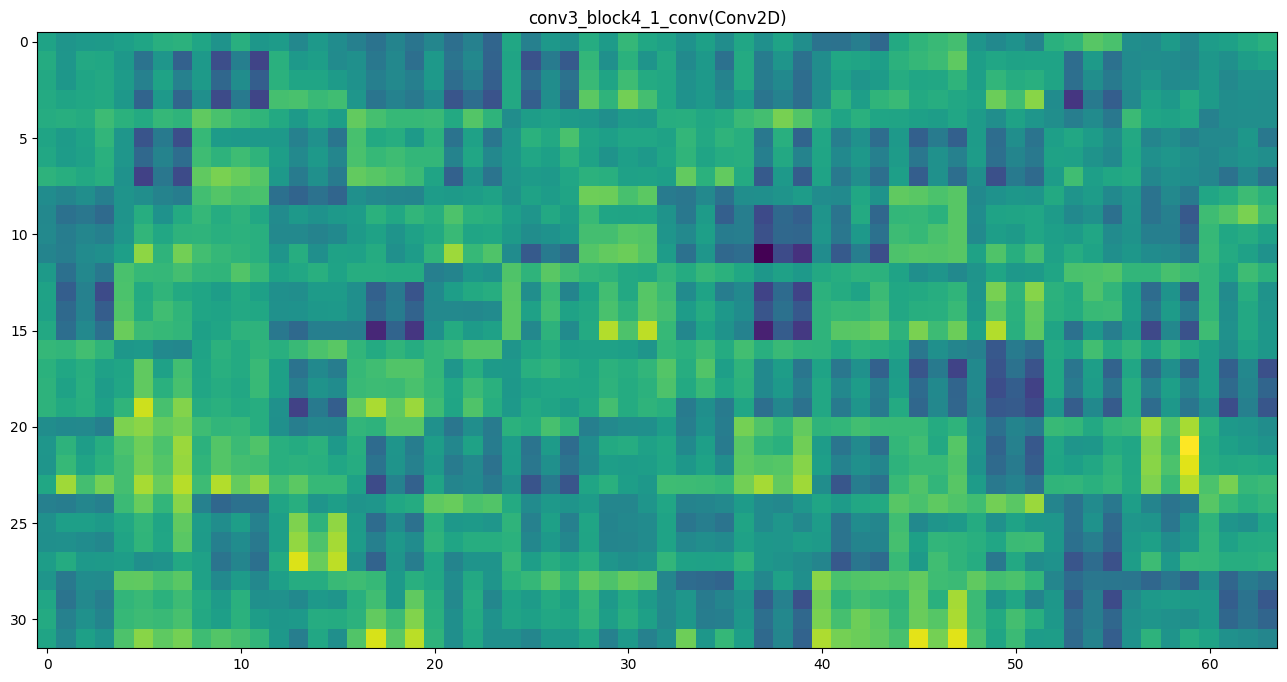

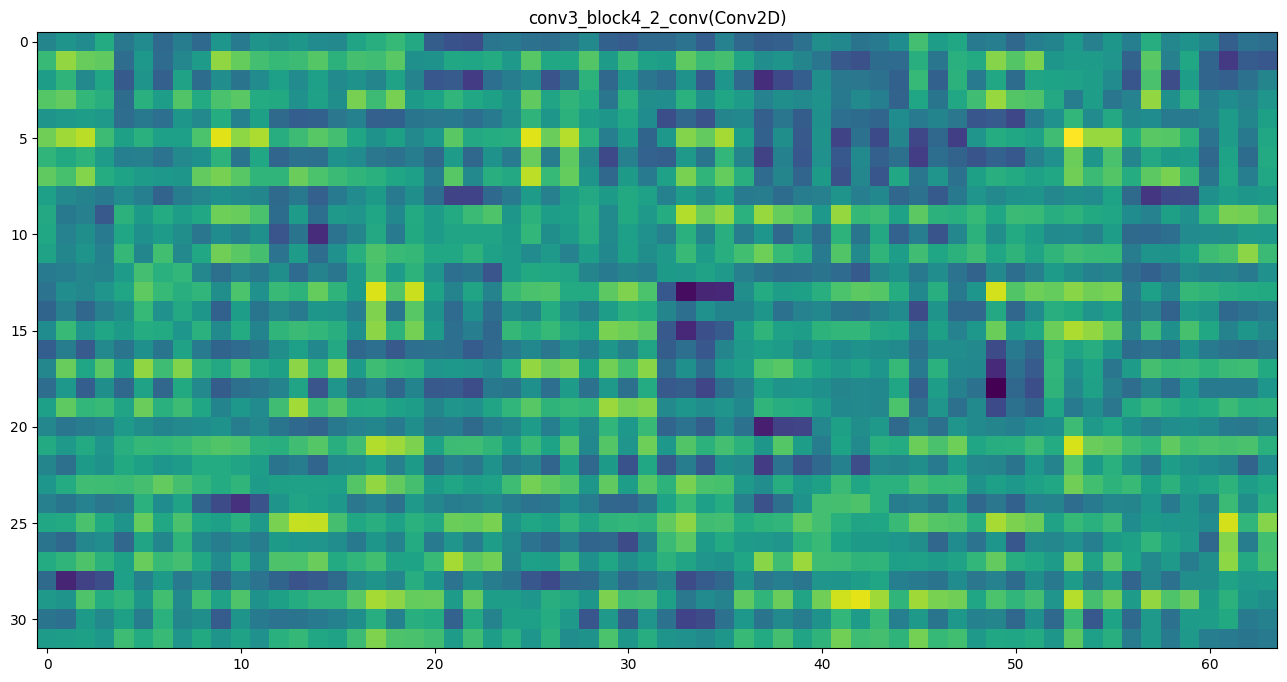

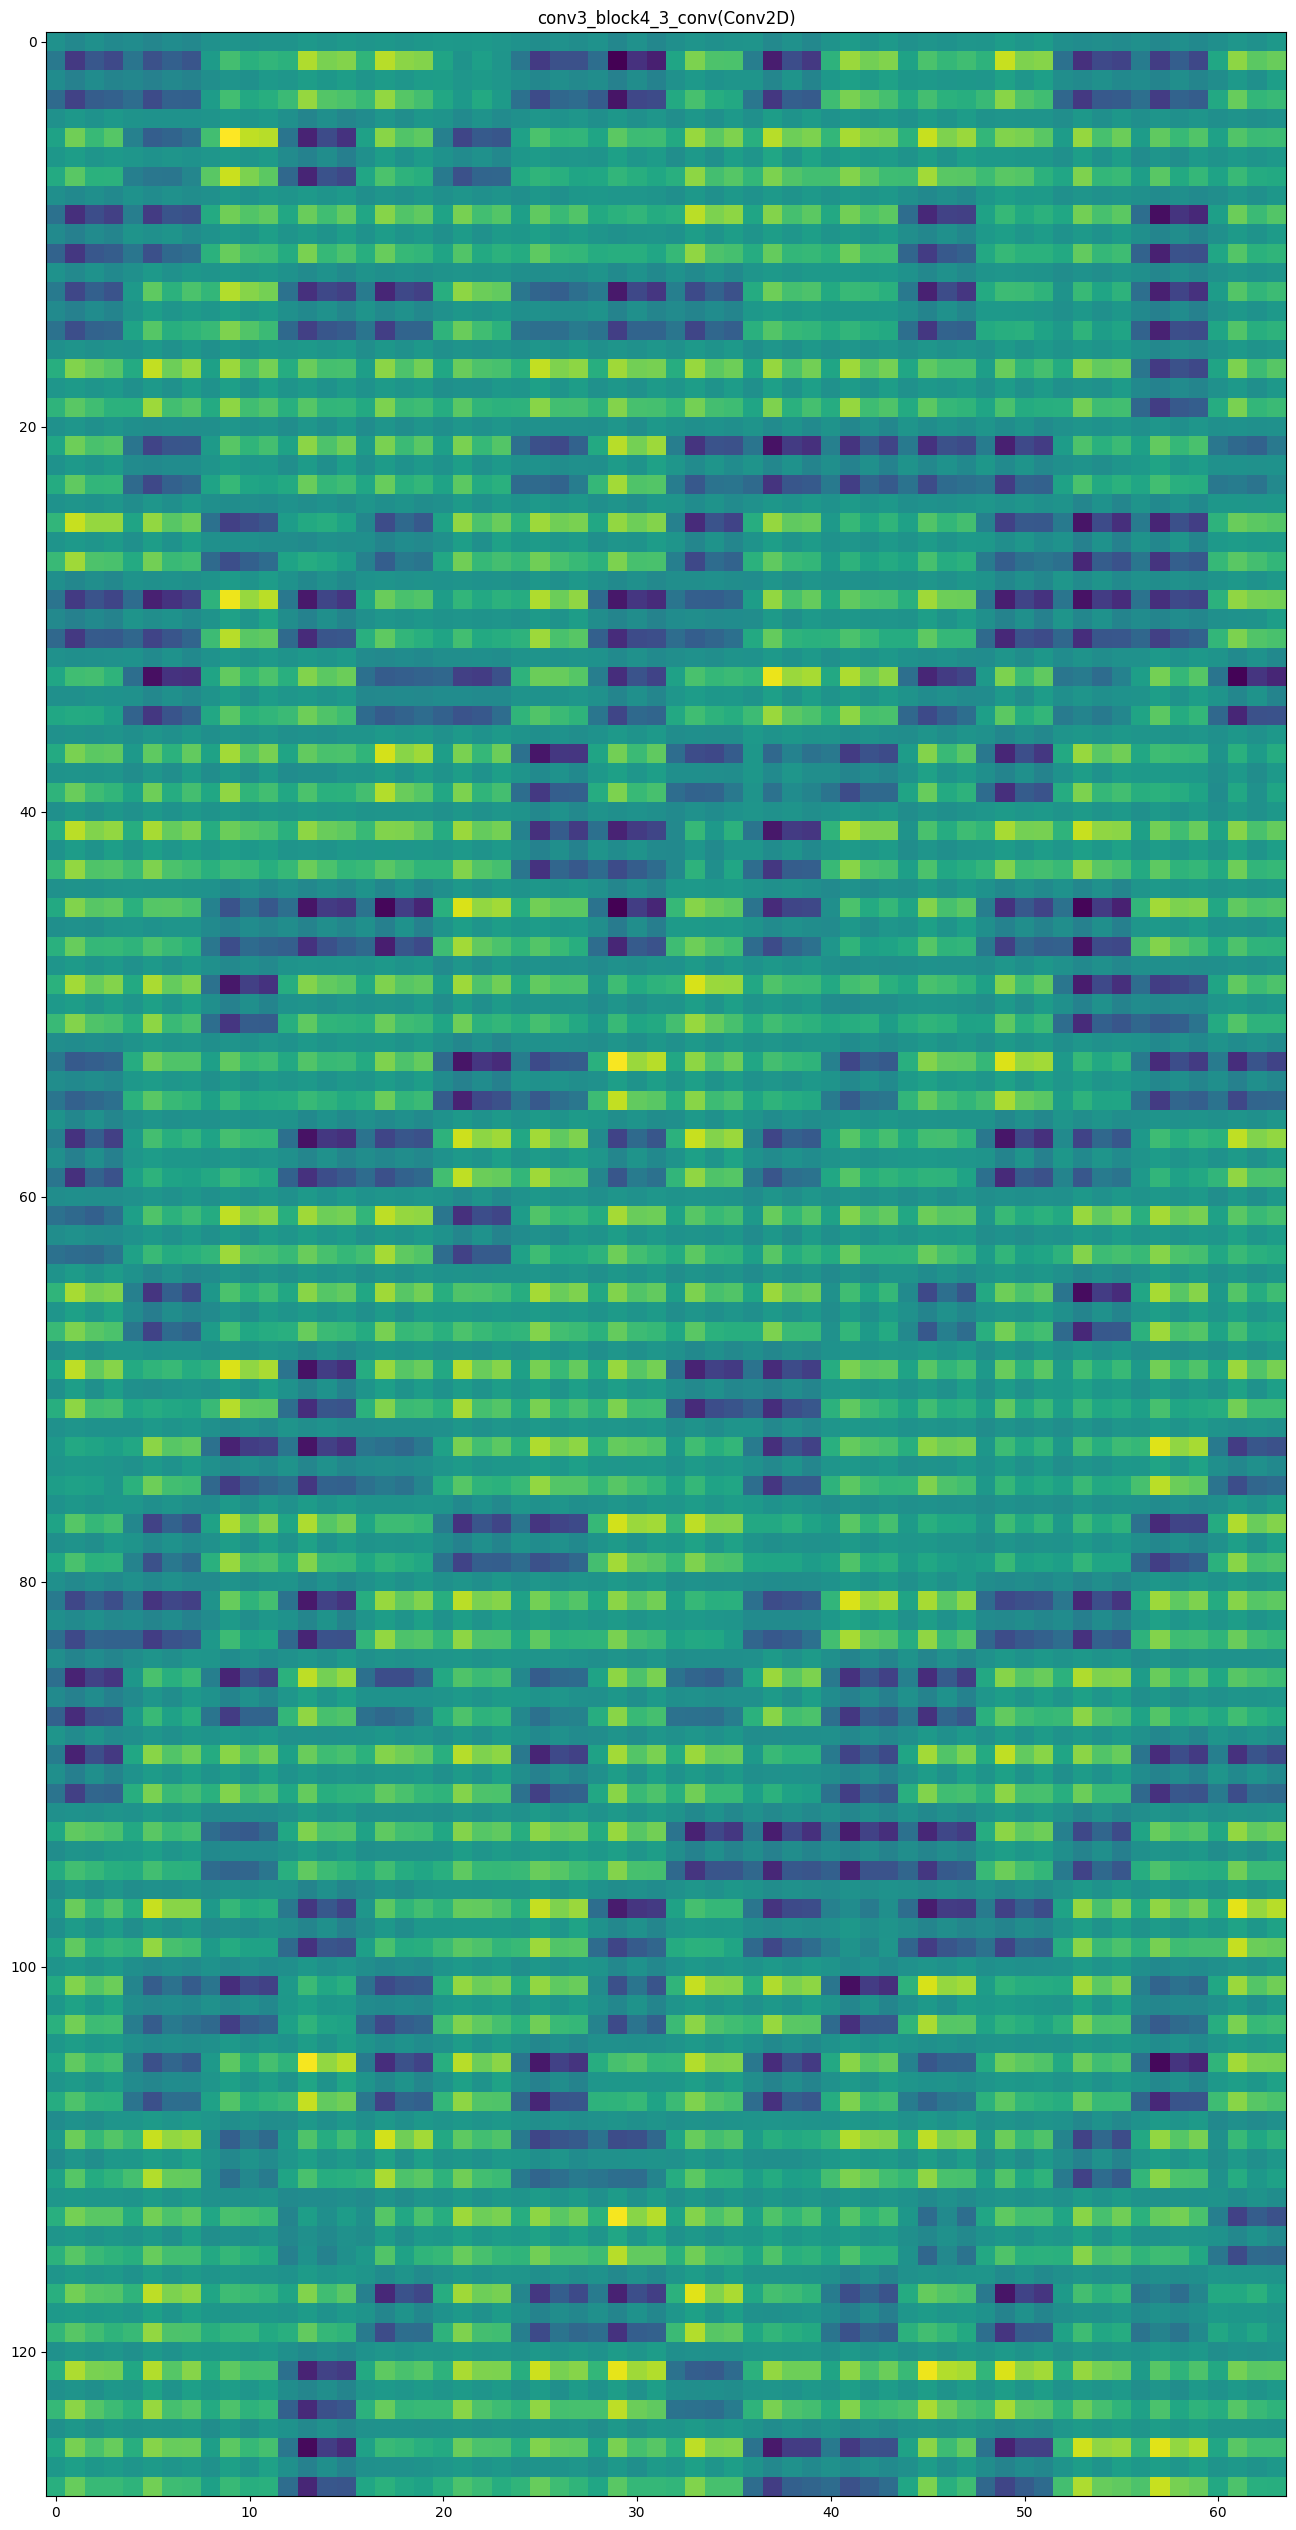

In [ ]:
#get the names of the layers
layer_names = get_layer_names(38, 78, fe_model)

#plot feature maps
plot_feature_map(layer_names, activations)

In [ ]:
# Extracts the outputs of Block 5
layer_outputs = [layer.output for layer in fe_model.layers[141:172]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=fe_model.input, outputs=layer_outputs)
activations = activation_model.predict(ship_img_tensor)

1/1 [==============================] - 1s 987ms/step


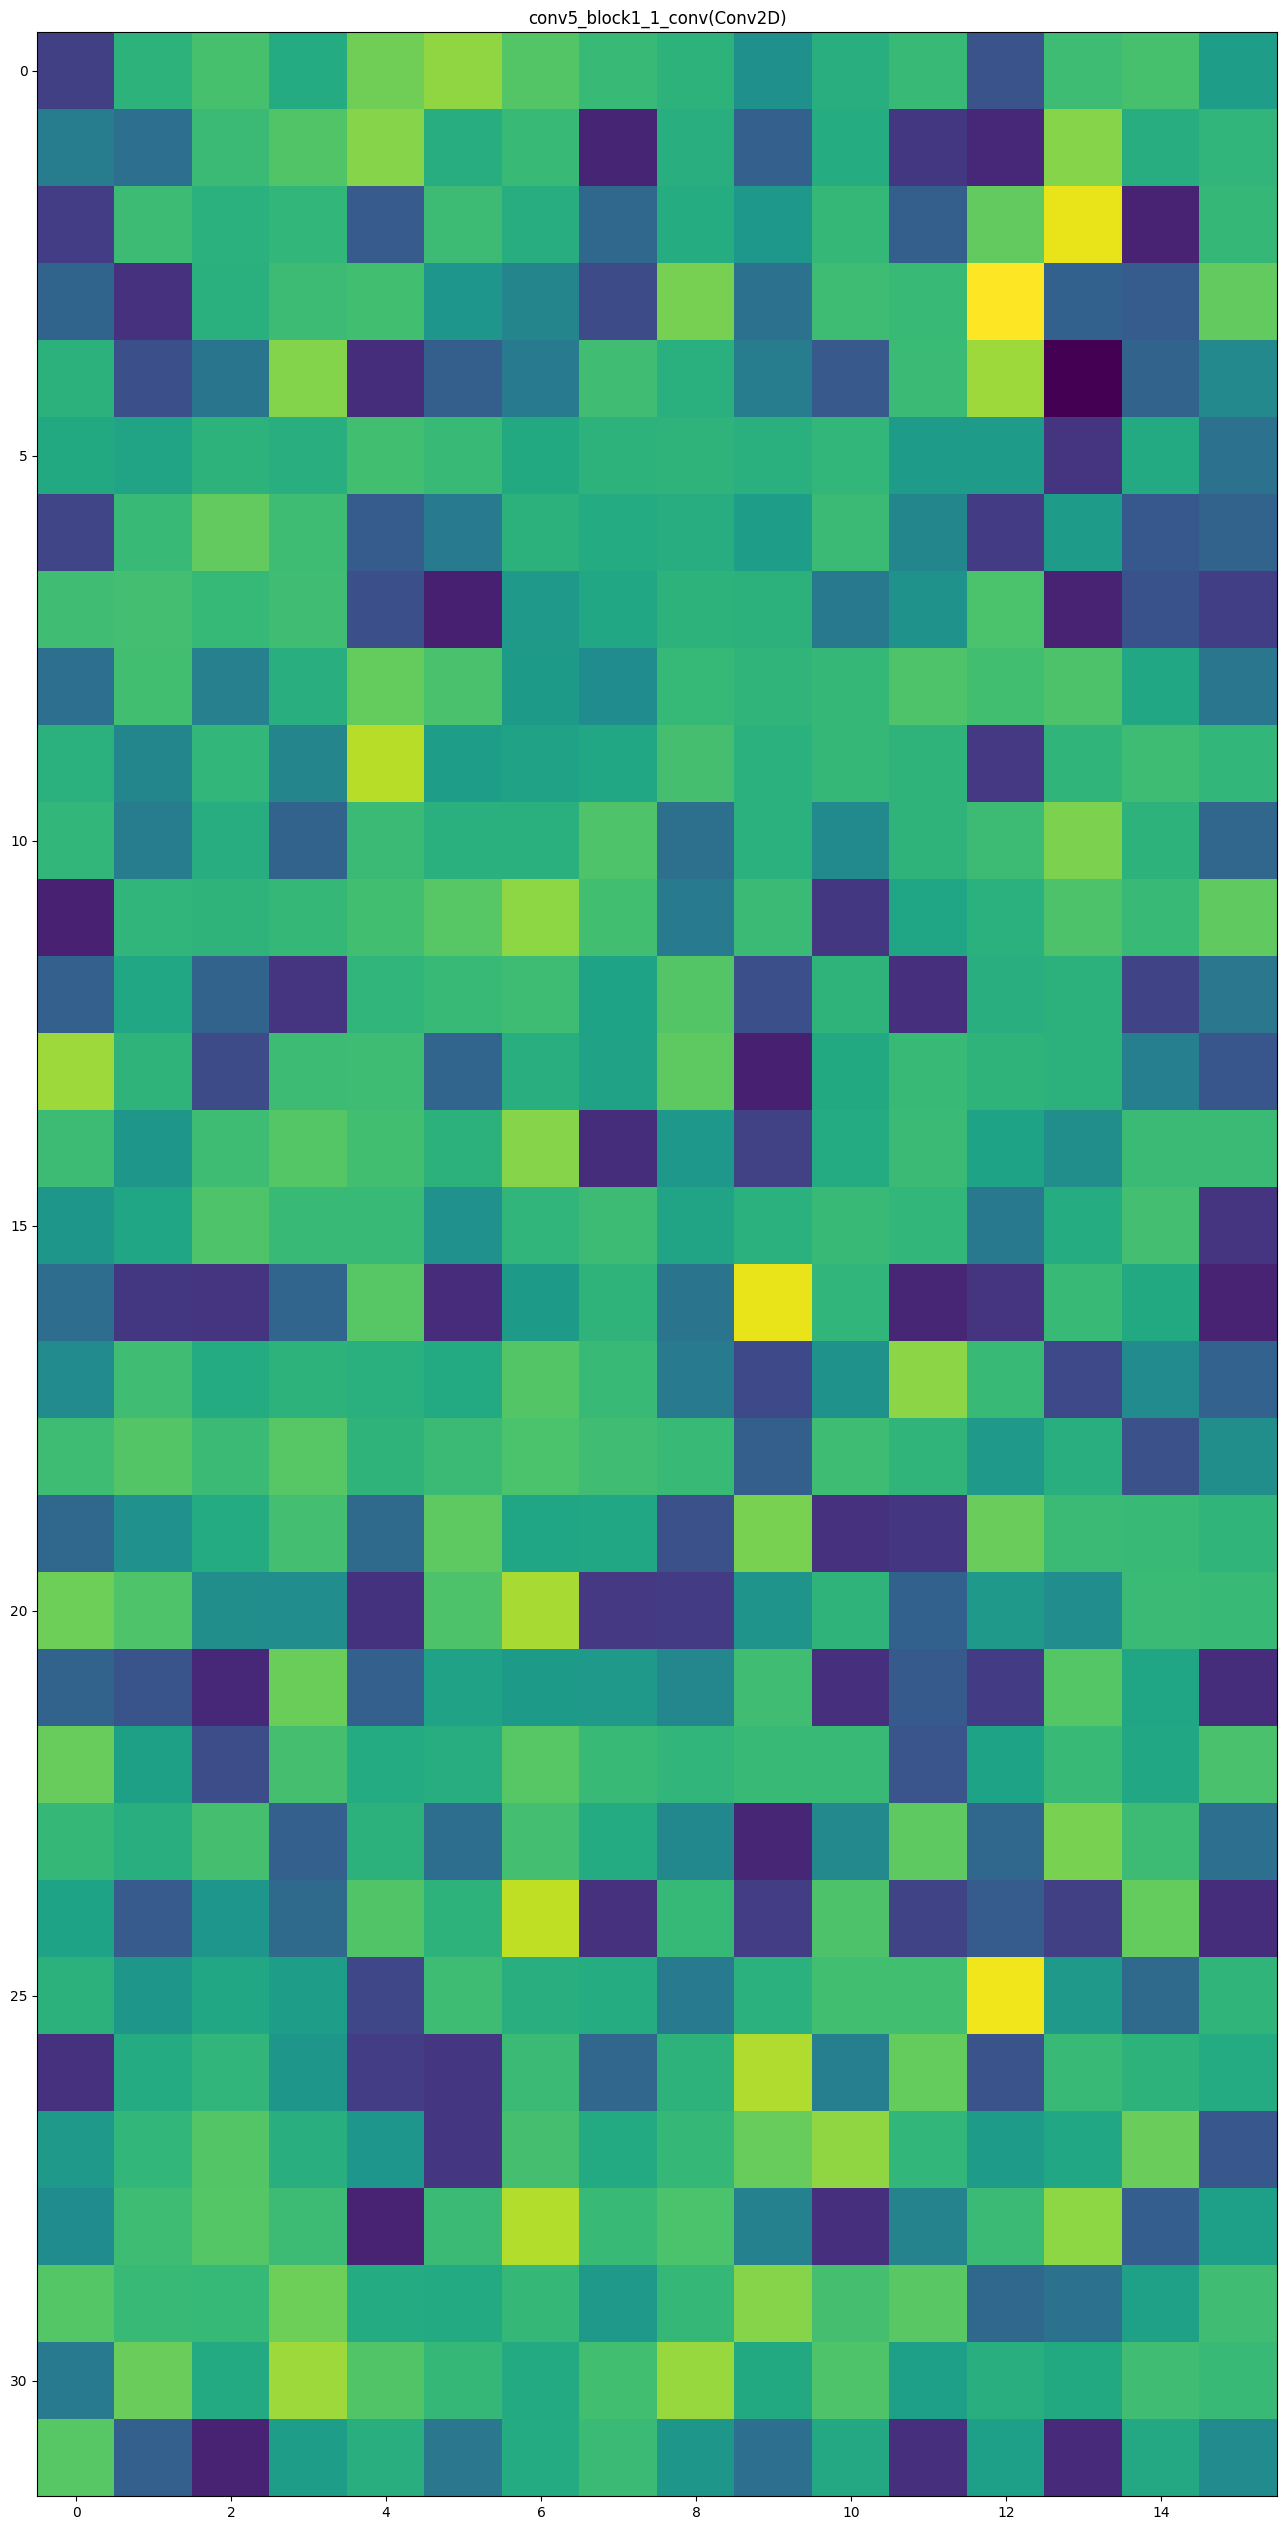

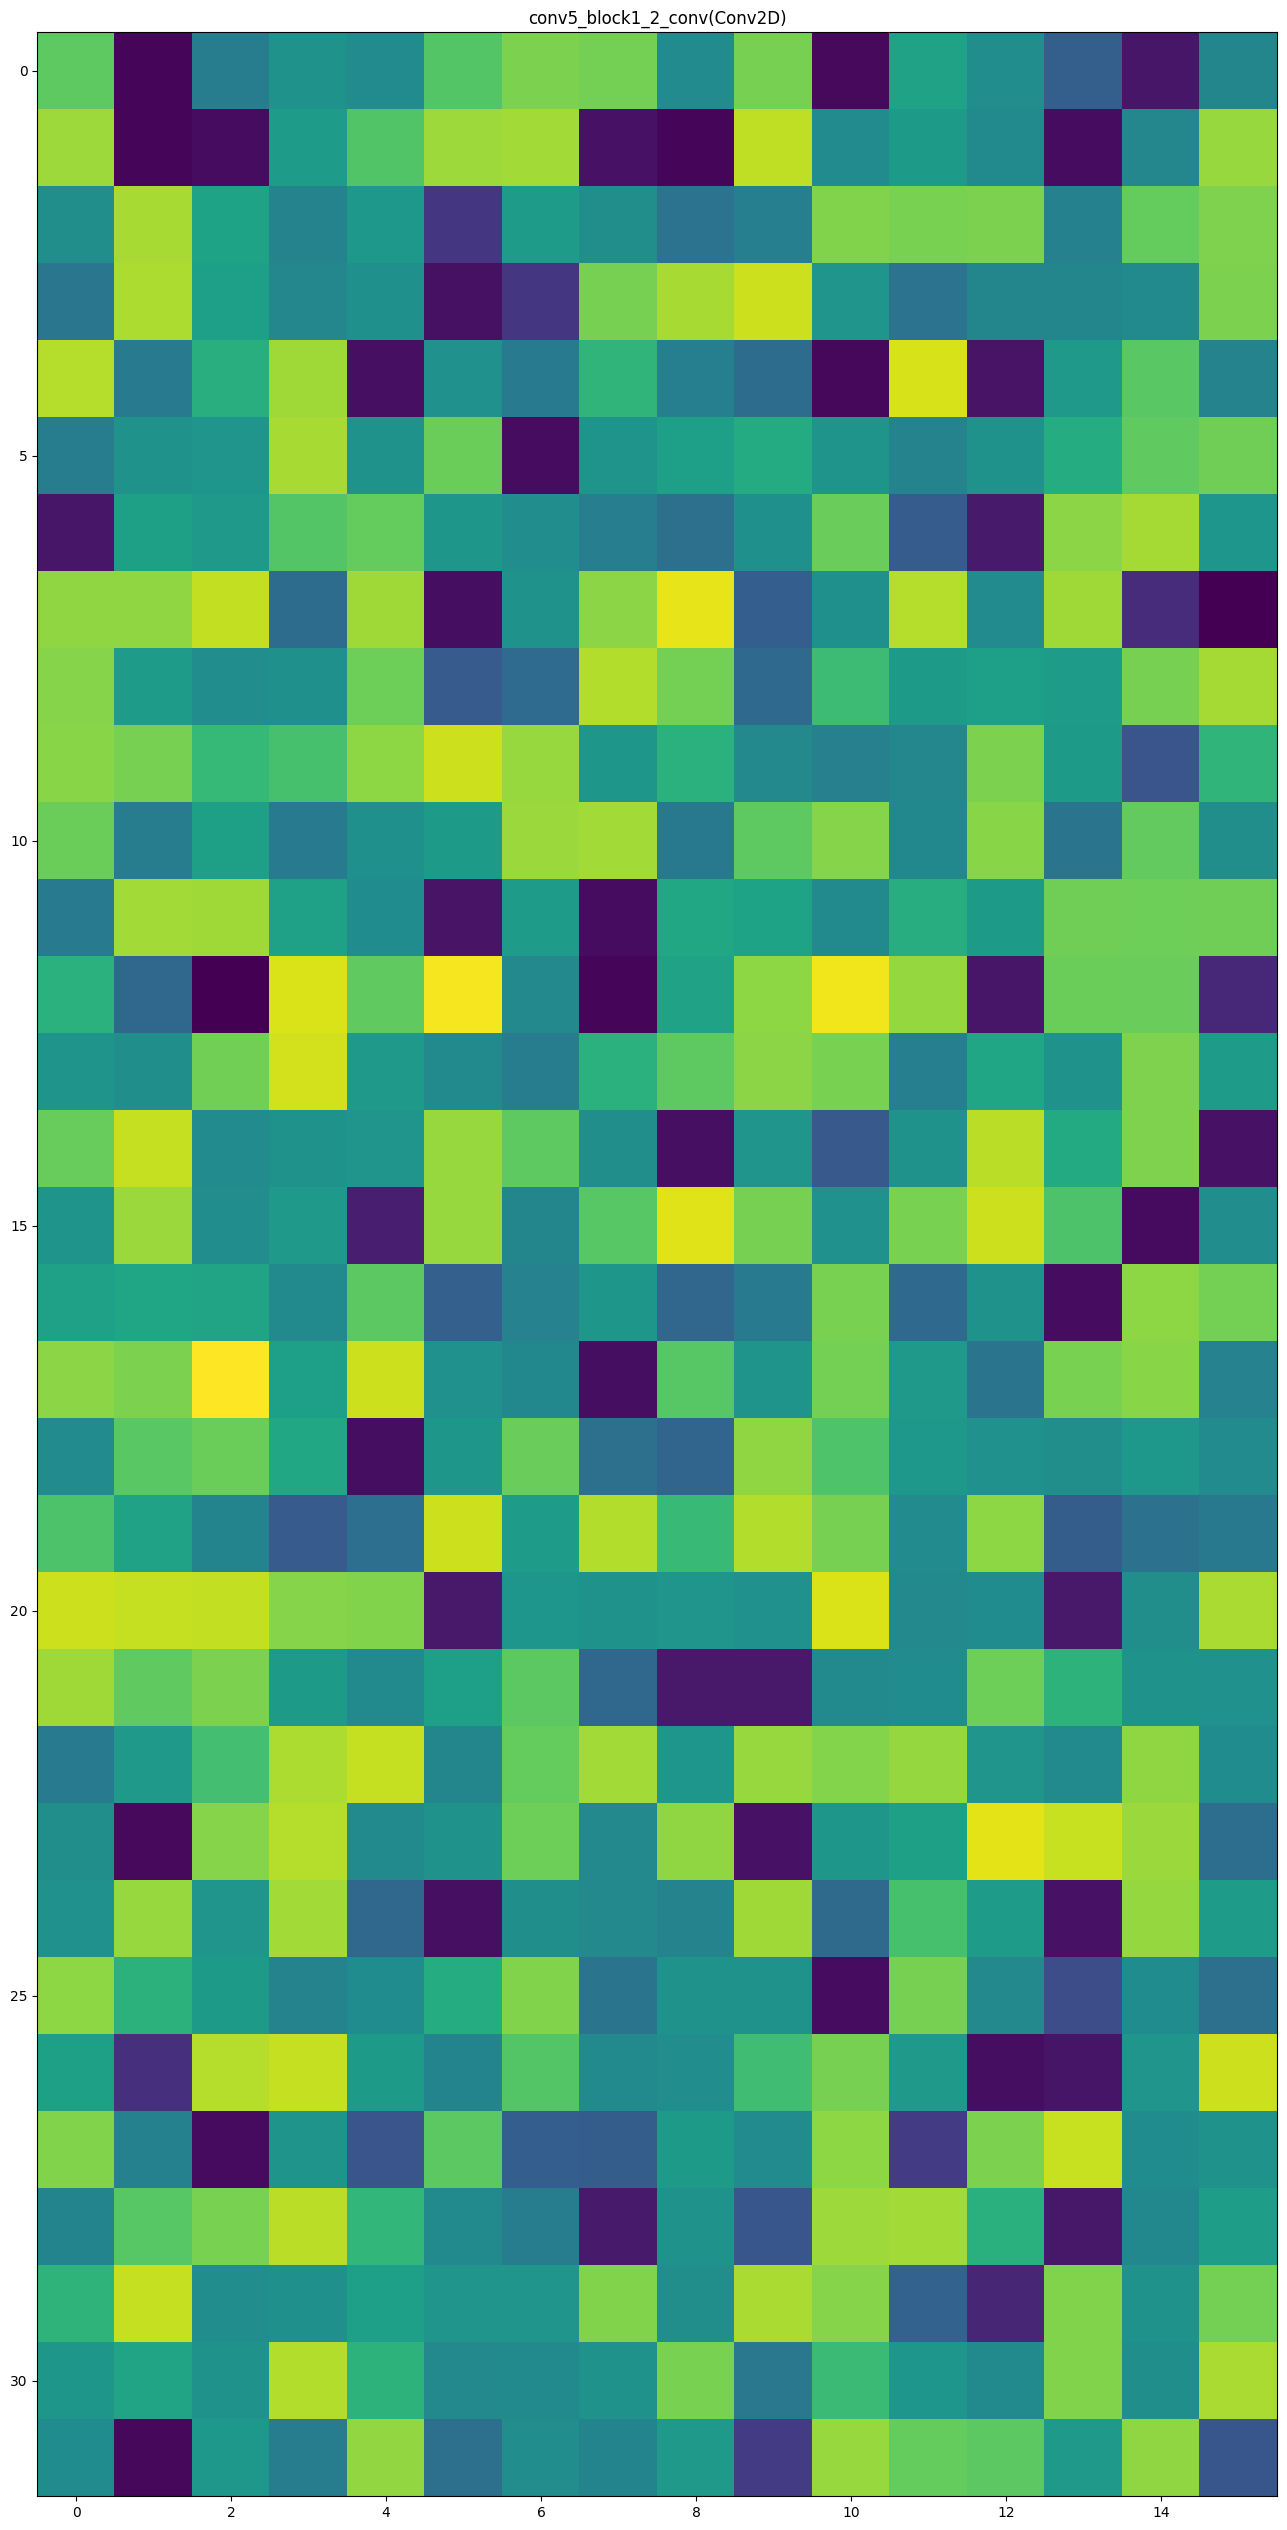

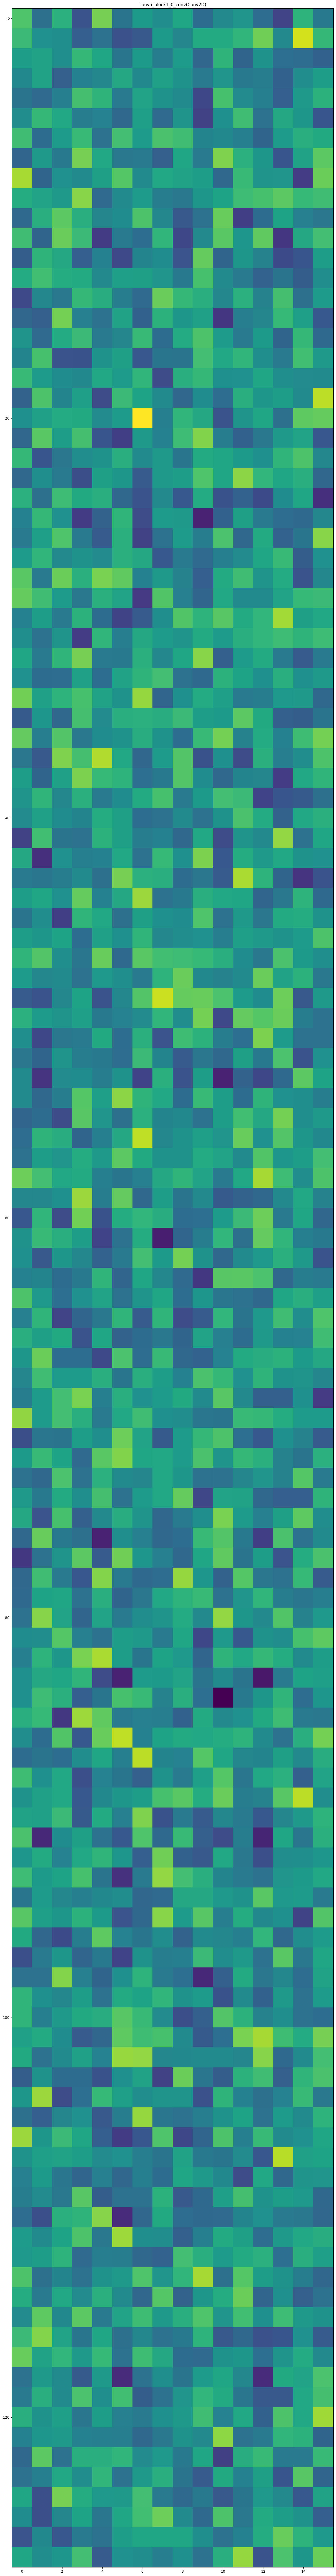

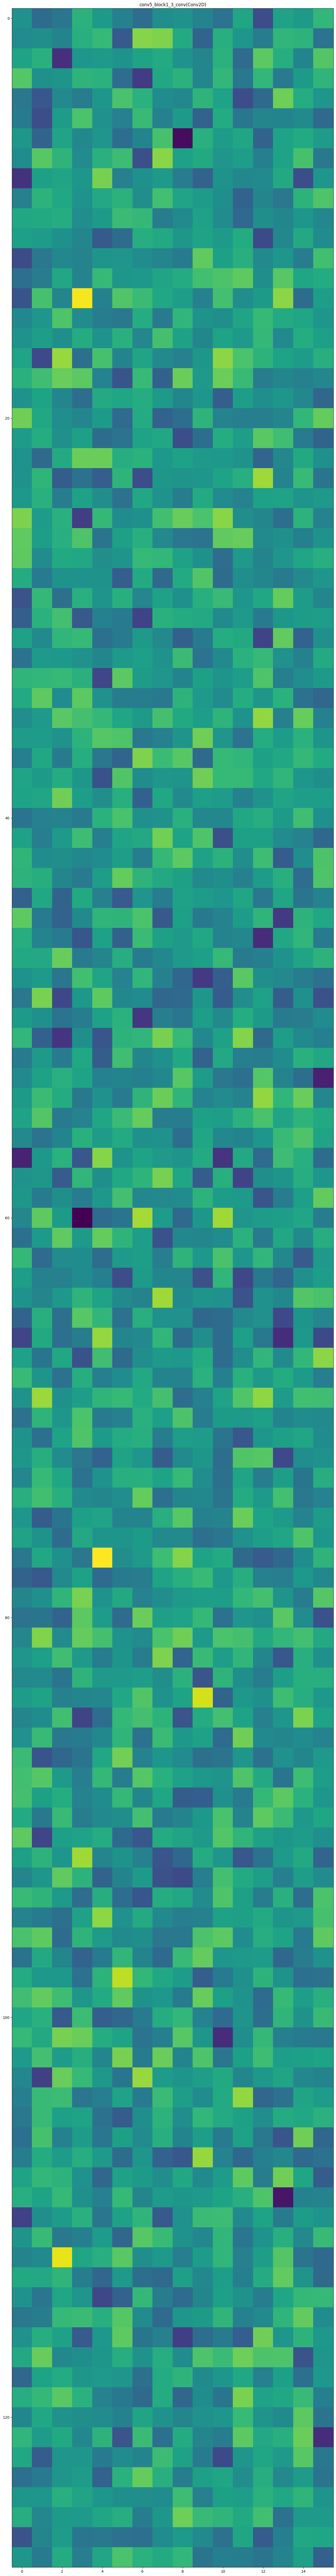

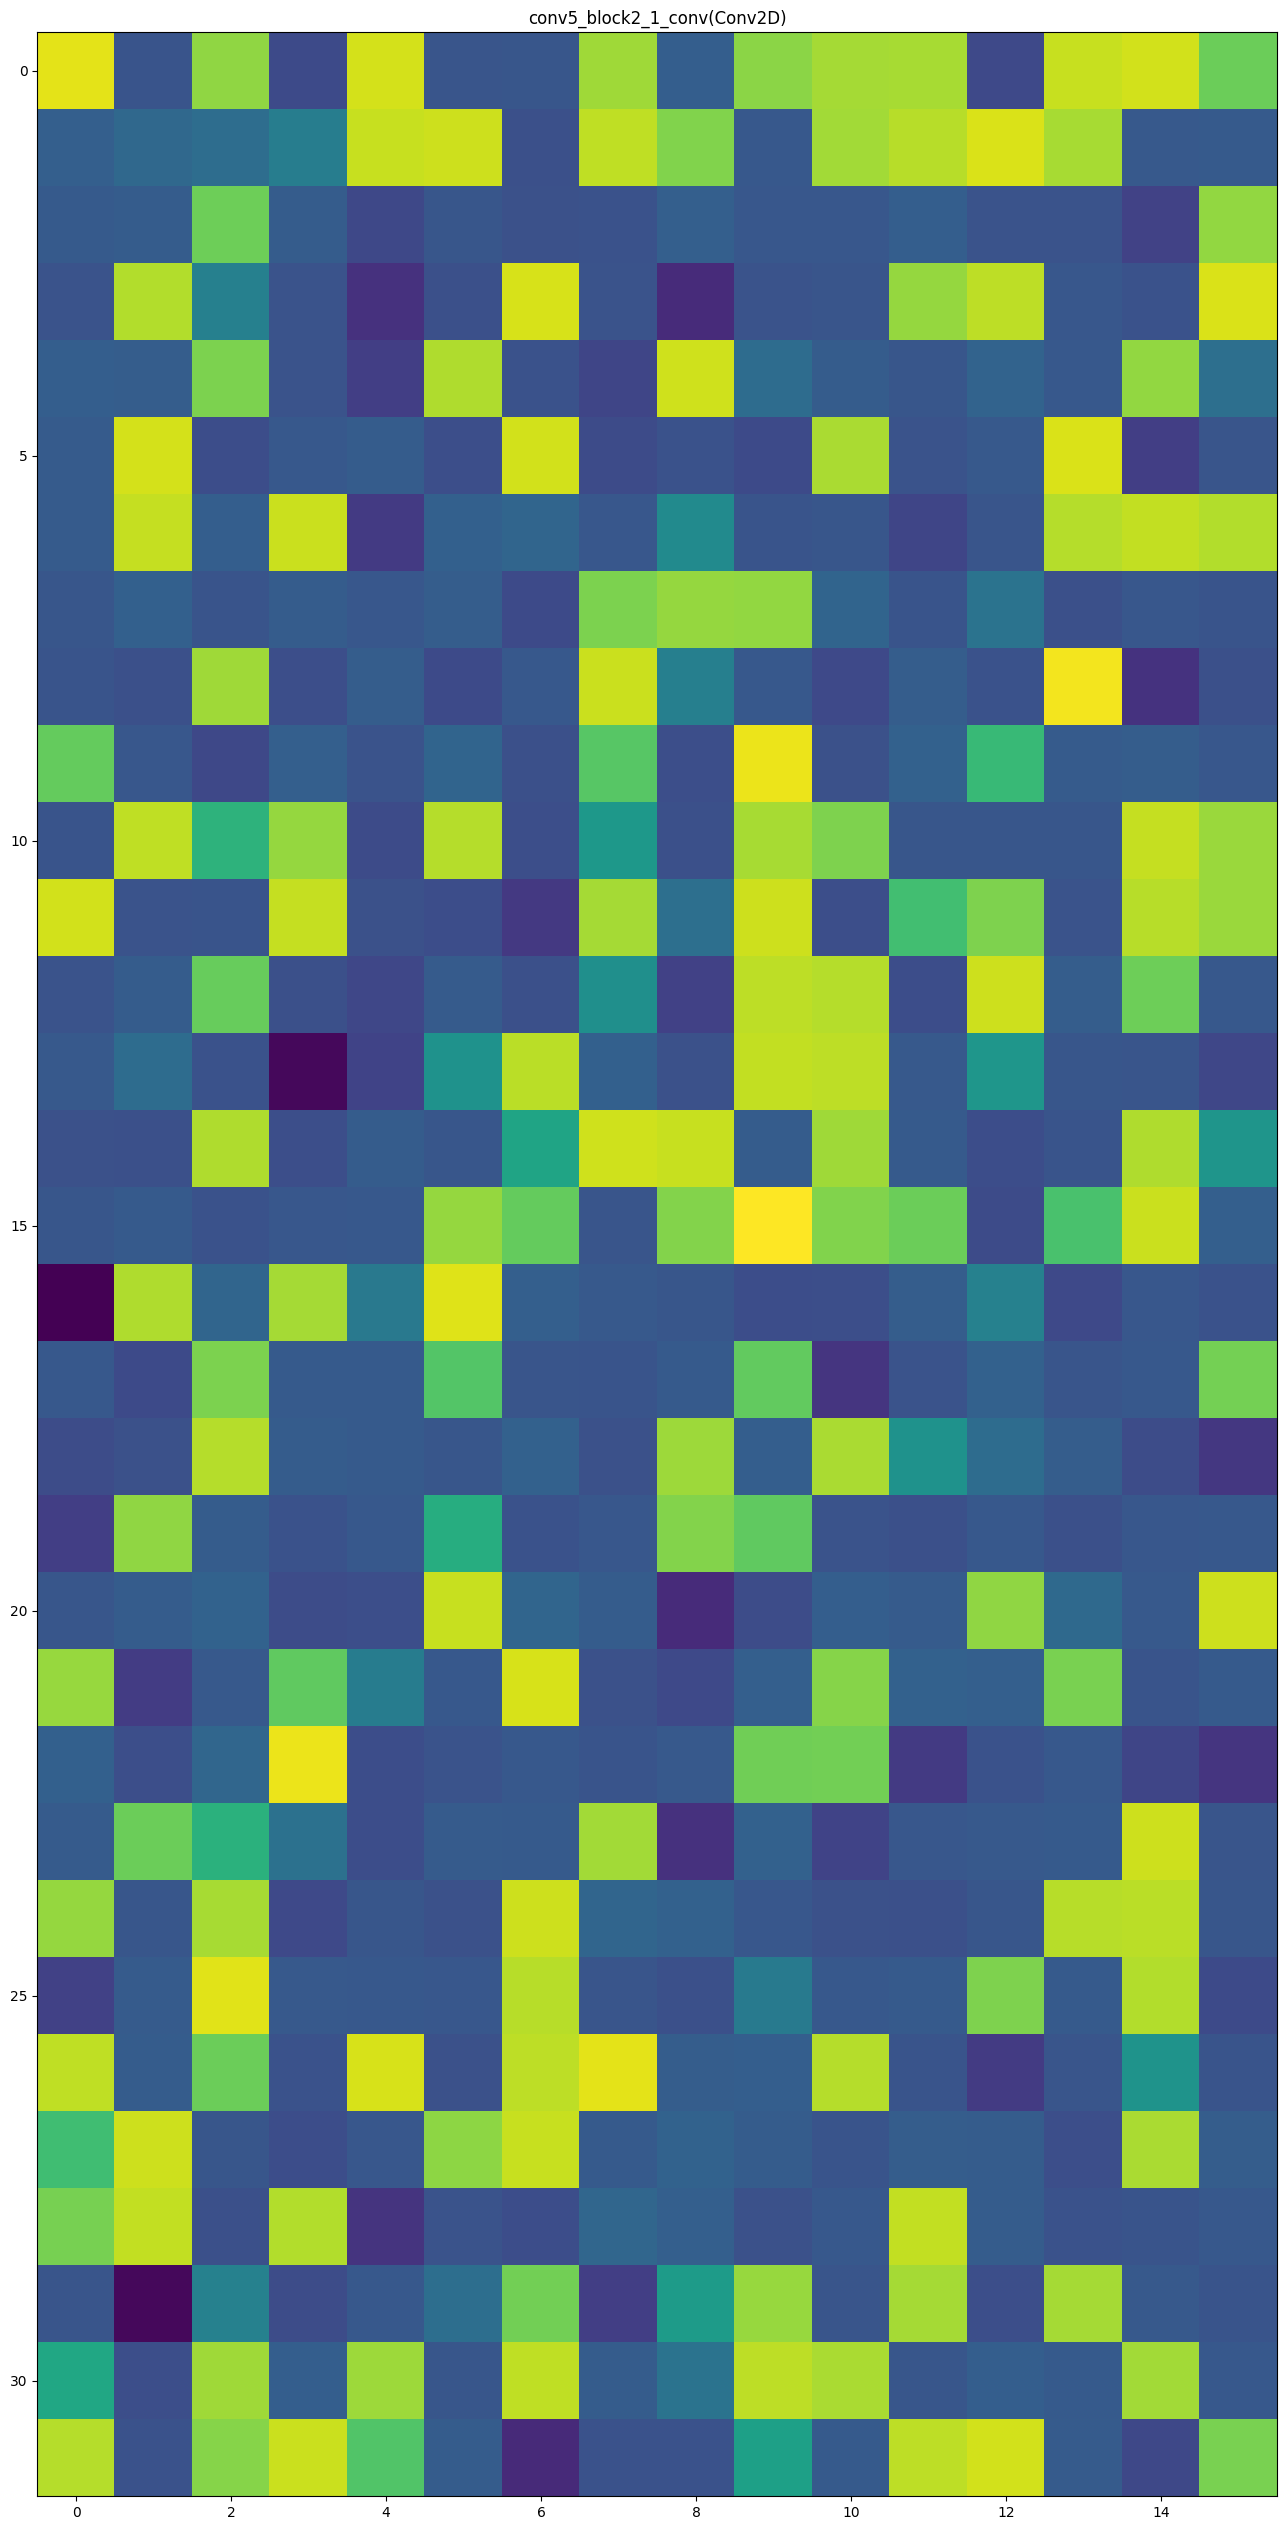

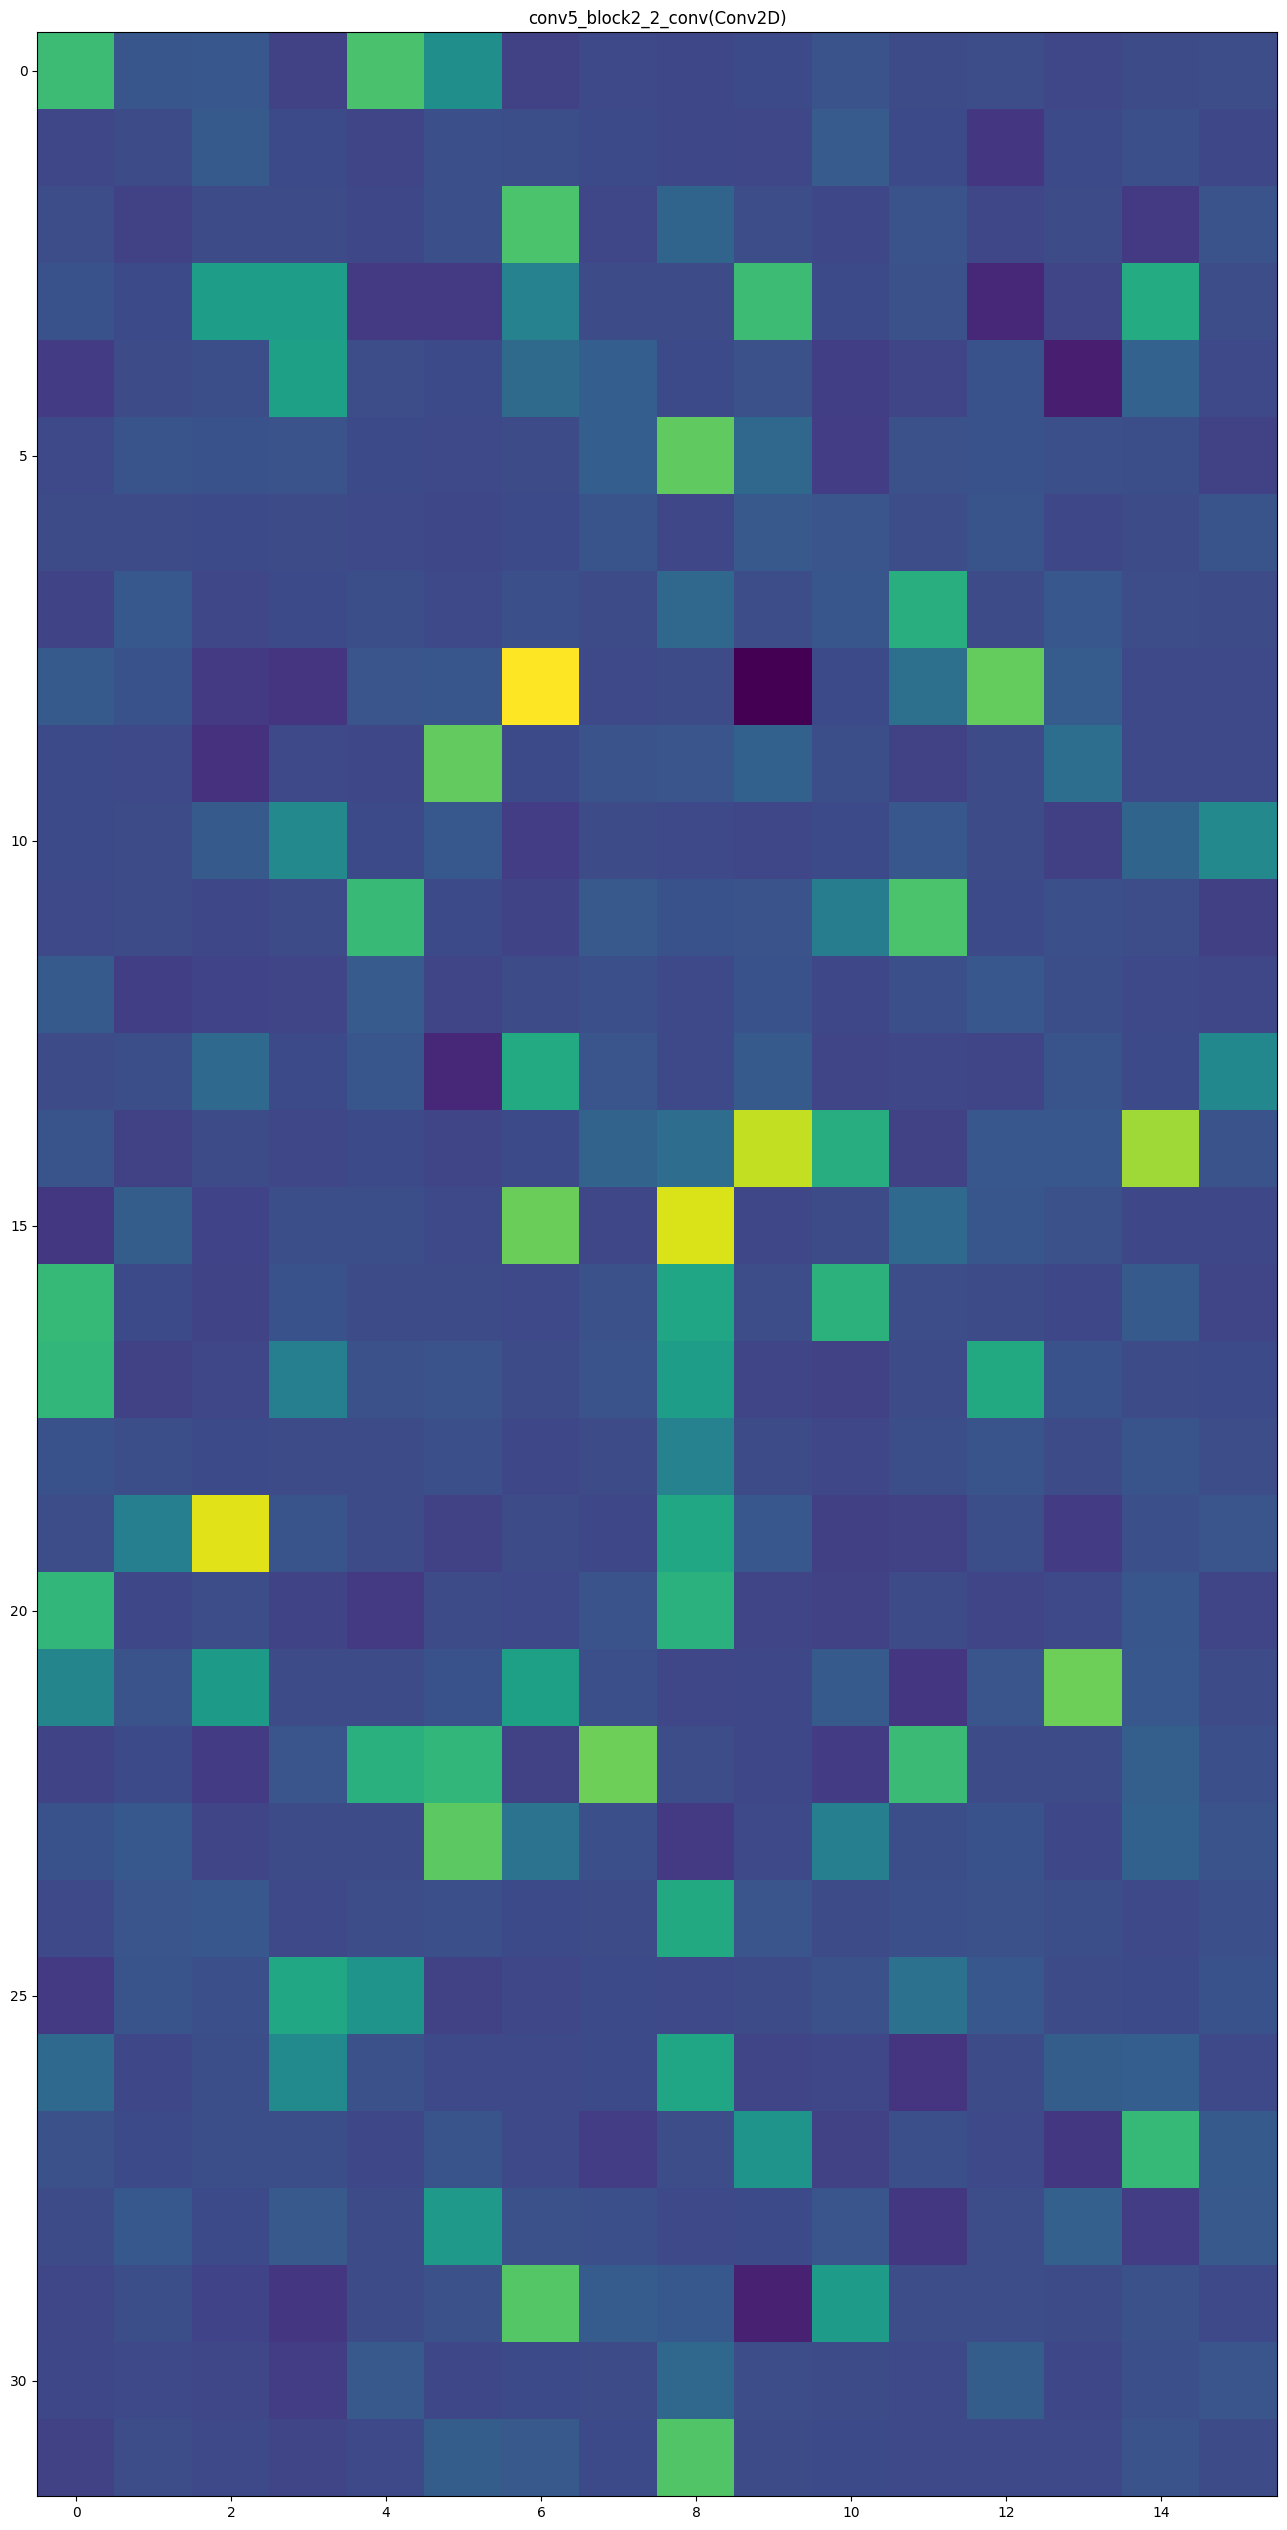

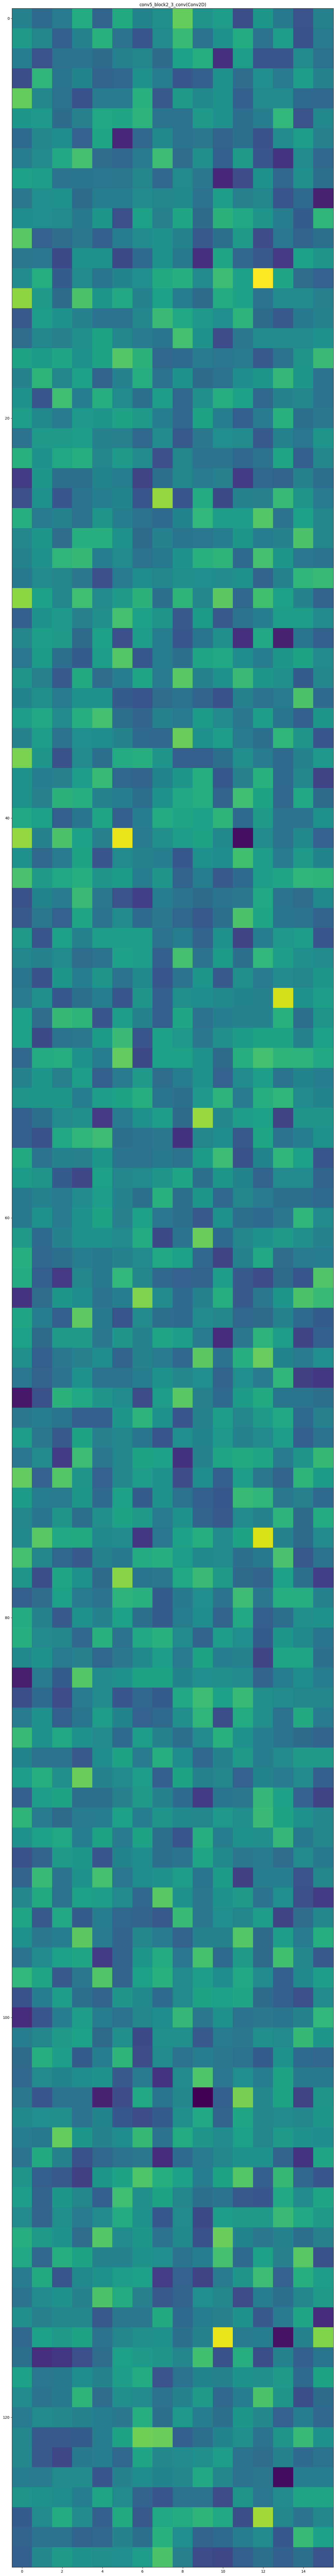

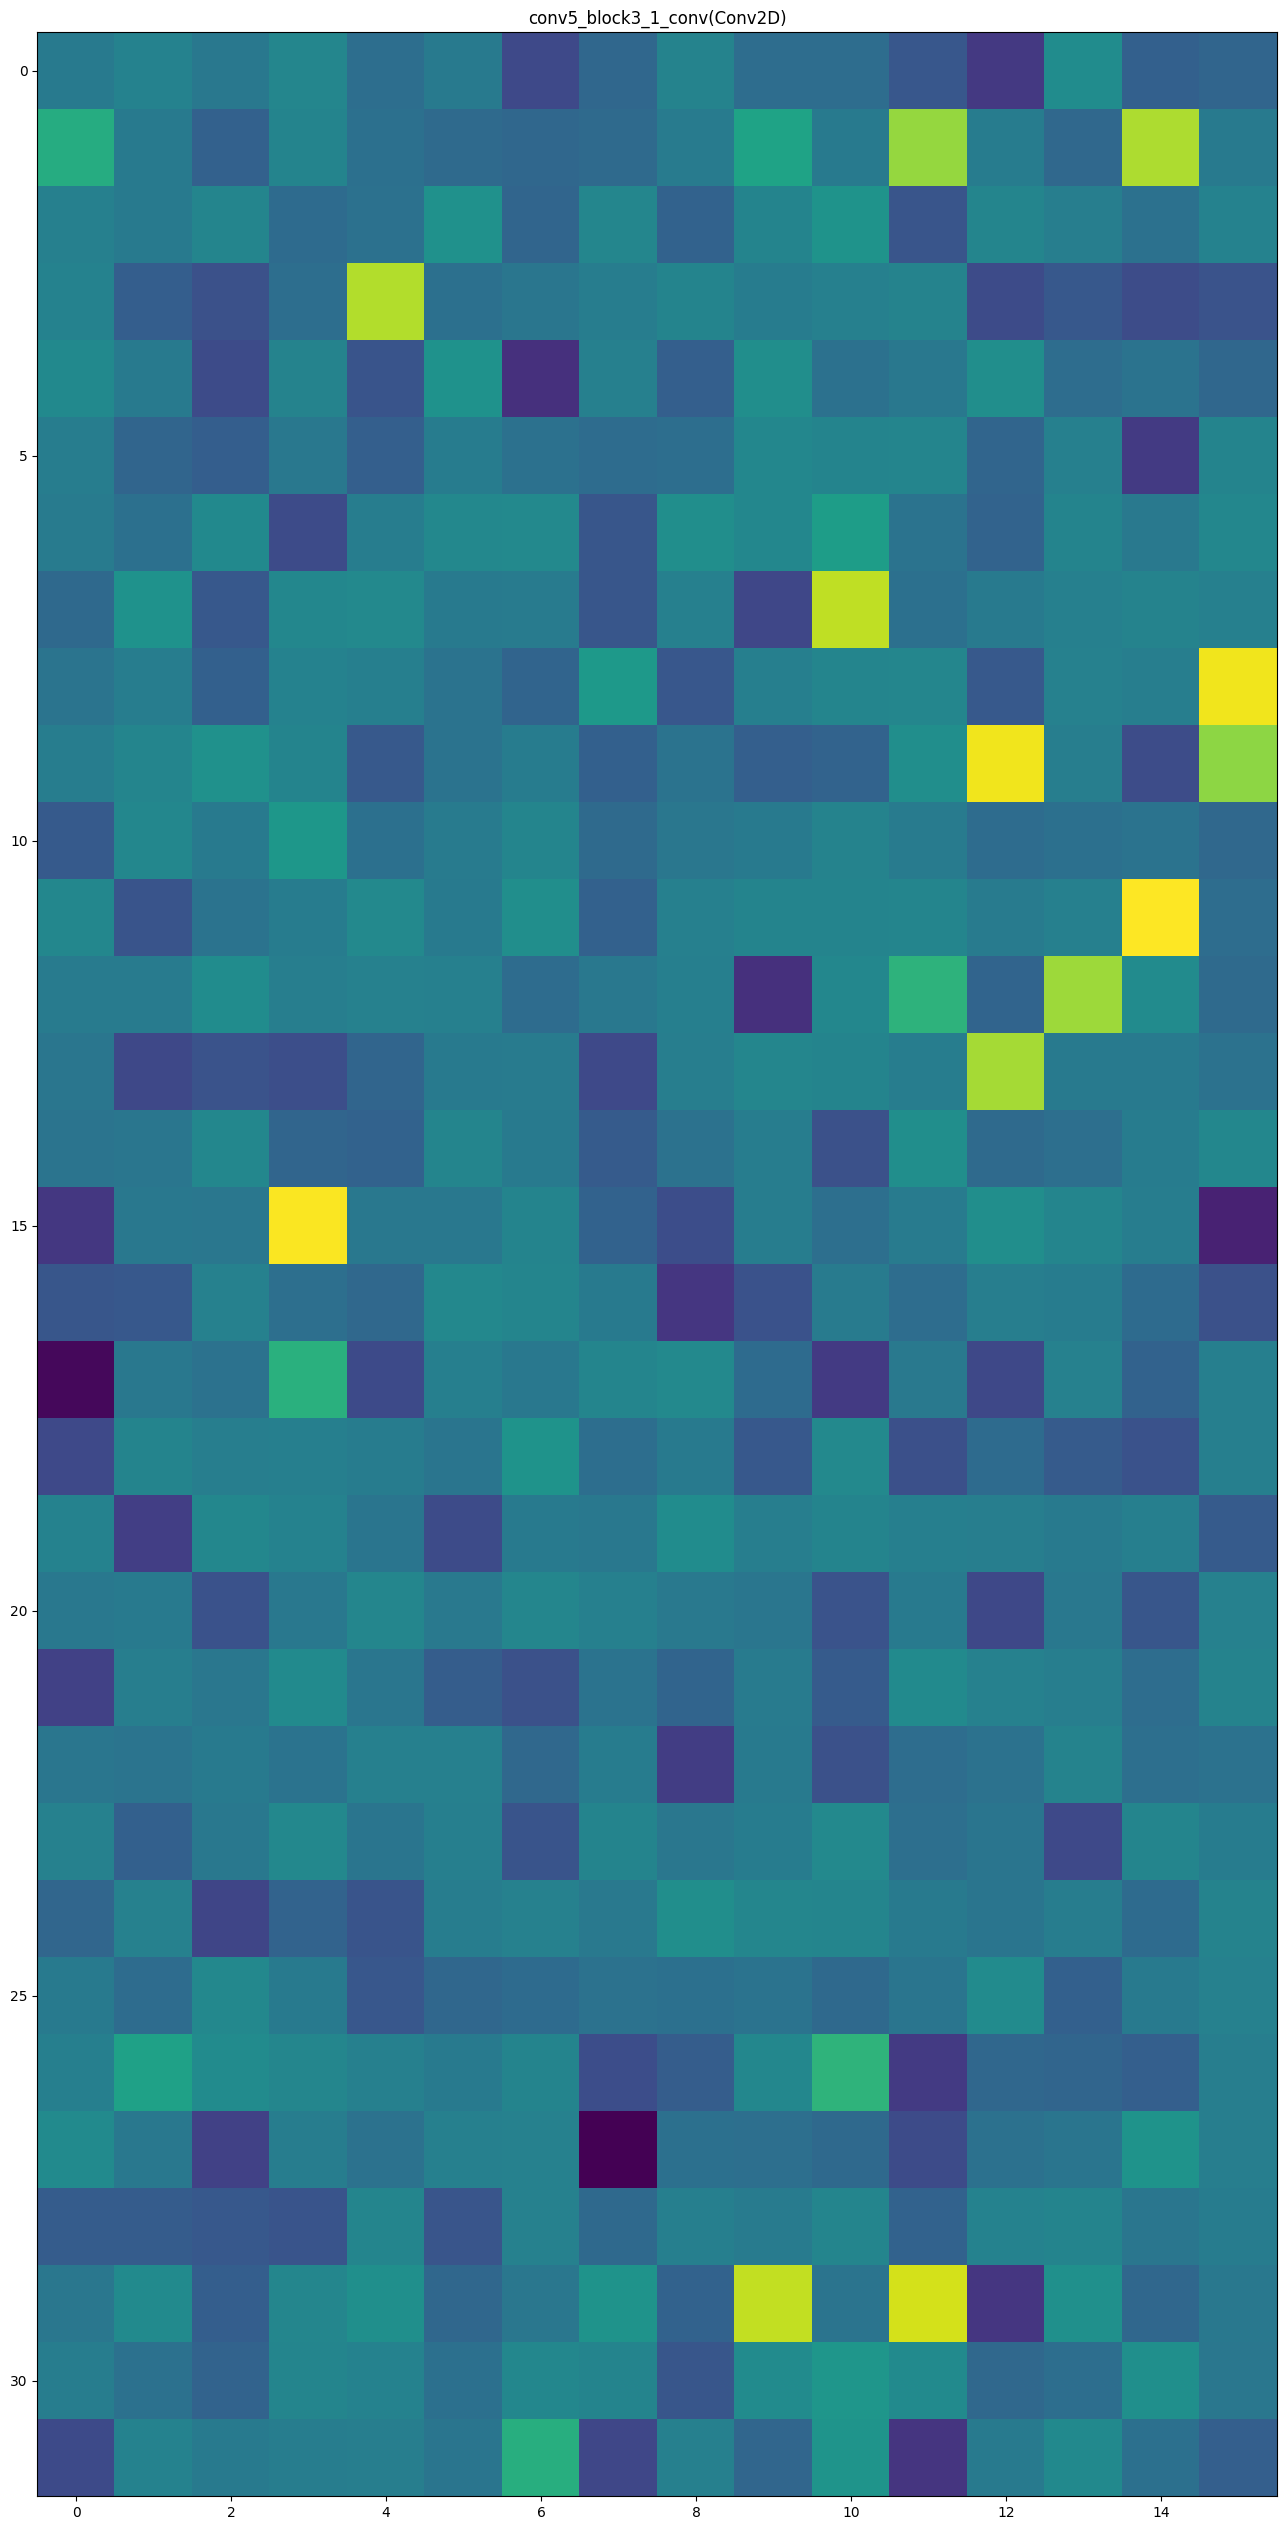

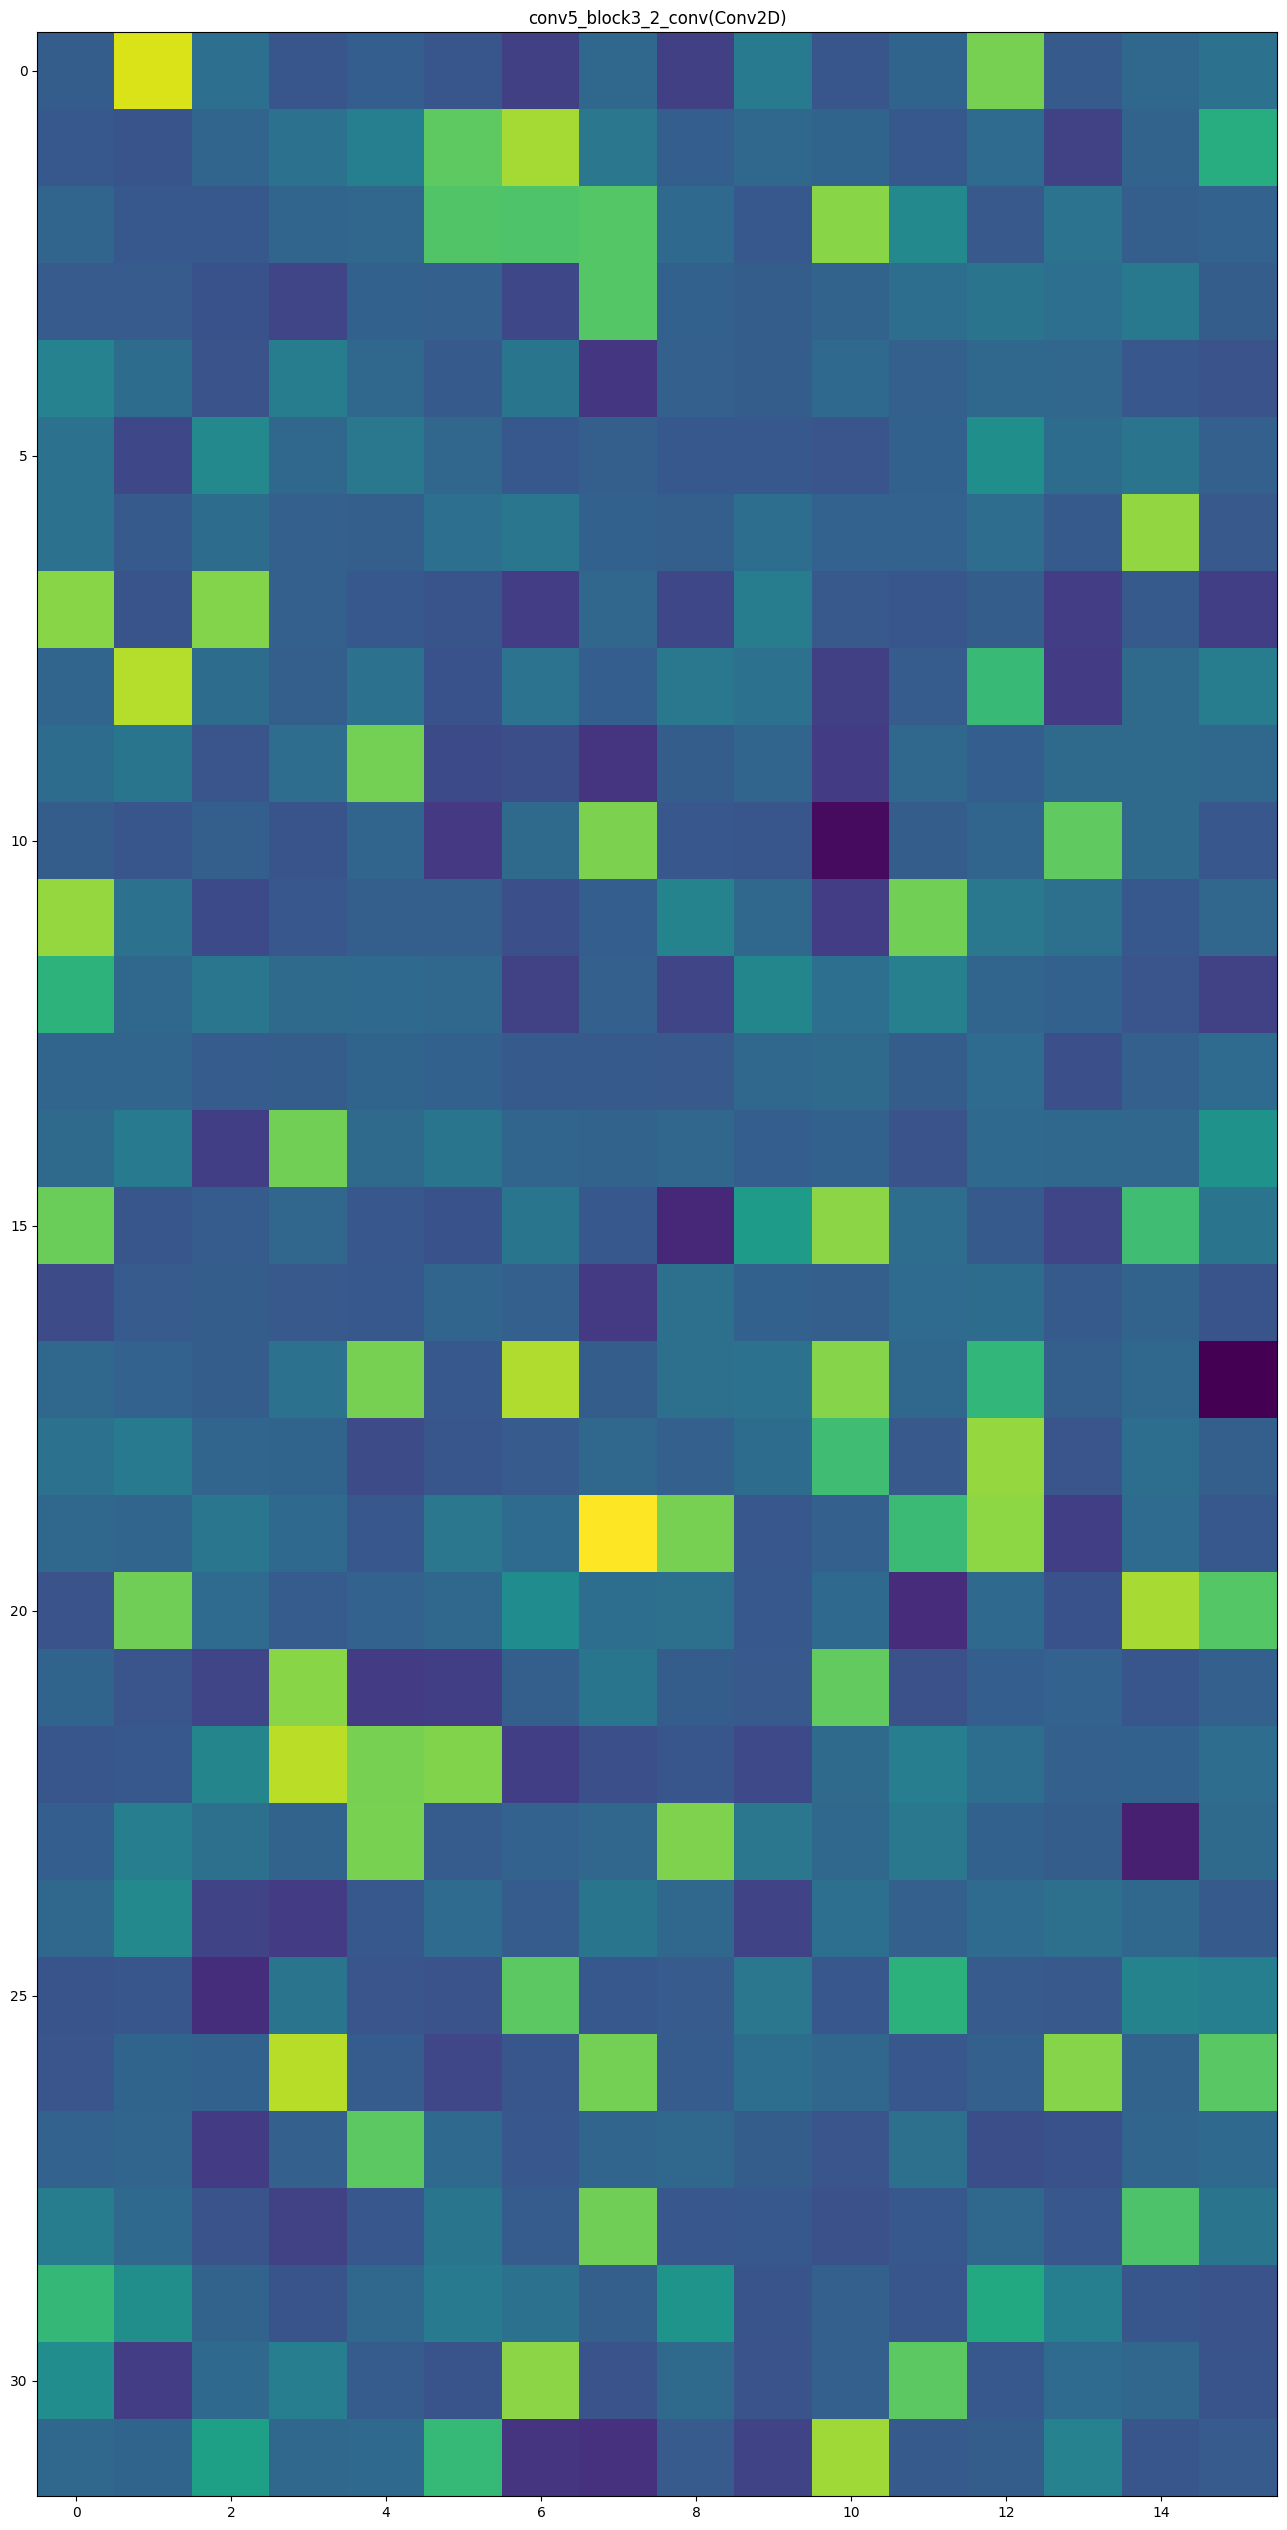

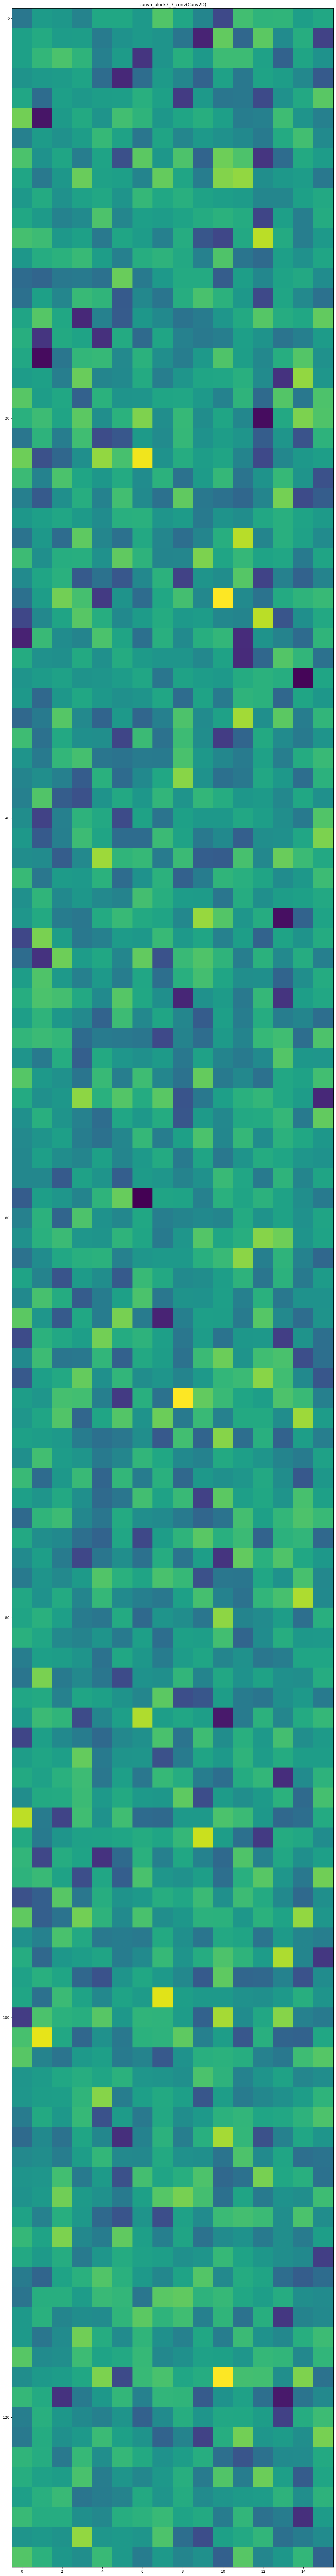

In [ ]:
layer_names = get_layer_names(141, 172, fe_model)

# Now let's display our feature maps

plot_feature_map(layer_names, activations)

# Visualizing convnets filters in models before and after transfer learning.

In [29]:
#Plotting some of the filters
def plot_filters1(layer_names, filters):
  images_per_row = 8
  for layer_name, filter in zip(layer_names, filters):
    if 'Conv2D' not in layer_name:
      continue

    fig1=plt.figure(figsize=(8, 12))
    fig1.suptitle(layer_name)

    n_filters = filter.shape[3]
    columns = 8
    rows = int(n_filters/columns)

    for i in range(1, 17):
        f = filter[:, :, :, i-1]
        fig1 =plt.subplot(rows, columns, i)
        fig1.set_xticks([])  #Turn off axis
        fig1.set_yticks([])
        plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
        #ix += 1


  plt.show()

1. Before transfer learning

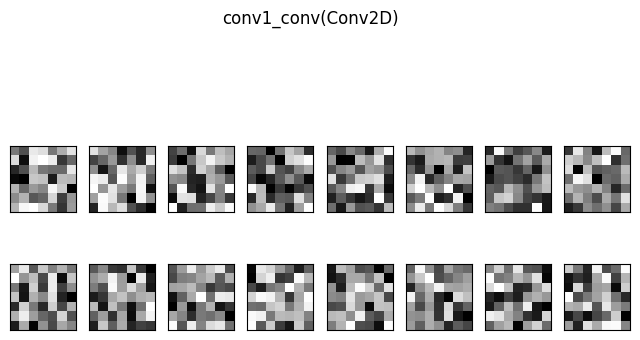

In [30]:
layer_names = get_layer_names(0, 6, before_model)
filters = get_filters(0, 6, layer_names, before_model)
plot_filters1(layer_names, filters)

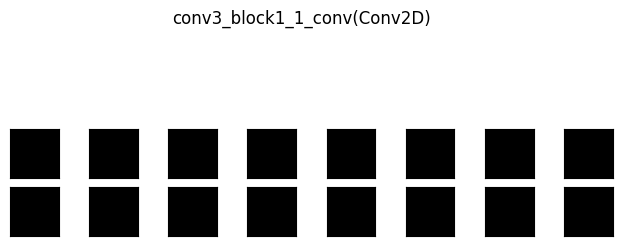

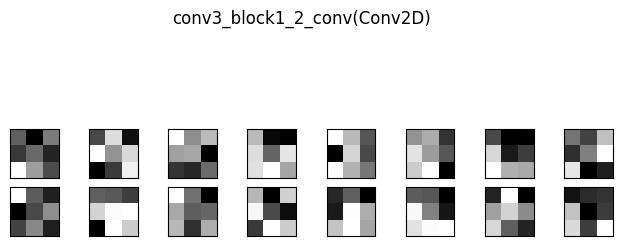

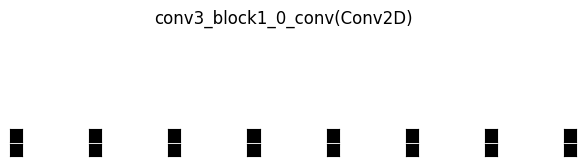

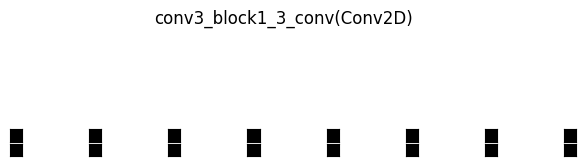

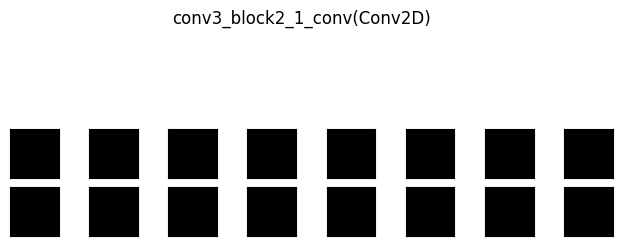

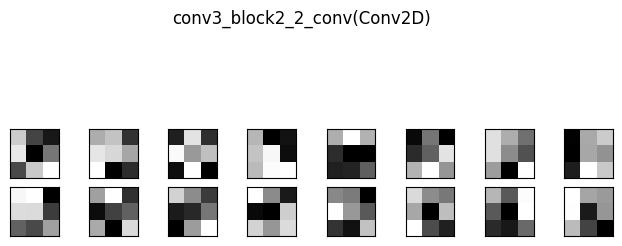

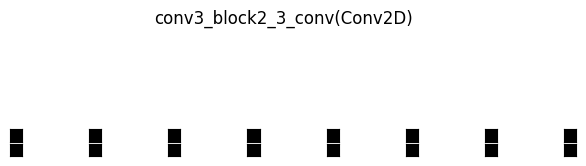

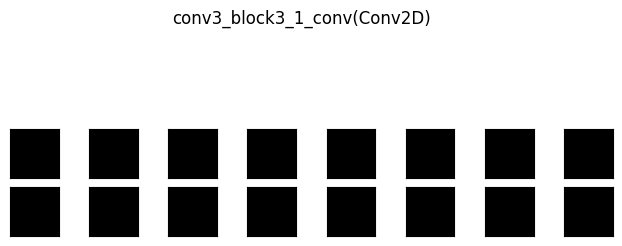

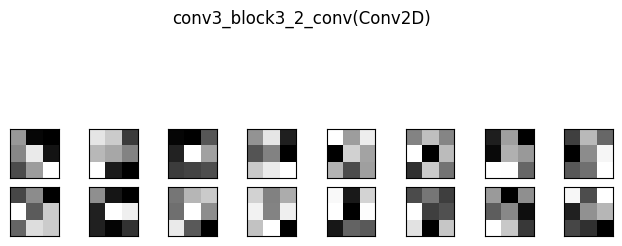

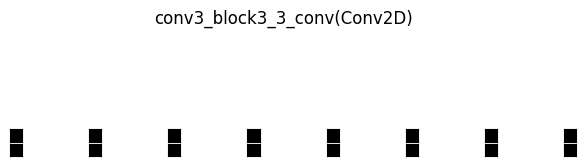

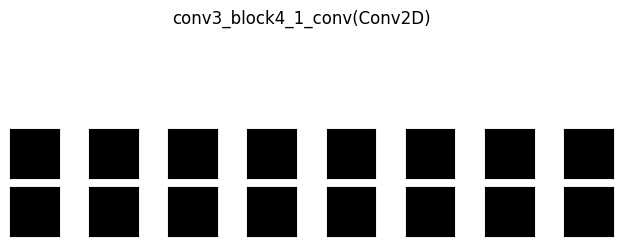

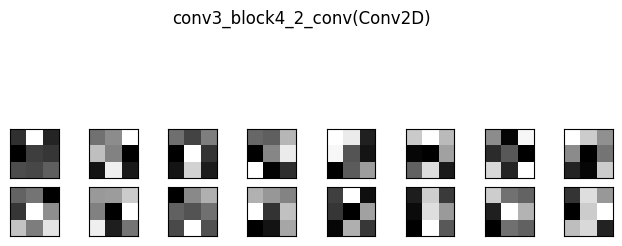

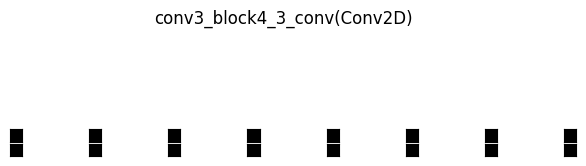

In [32]:
layer_names = get_layer_names(38, 78, before_model)
filters = get_filters(38, 78, layer_names, before_model)
plot_filters1(layer_names, filters)

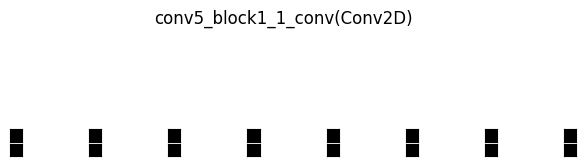

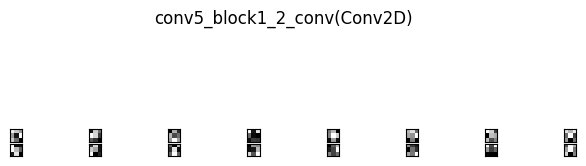

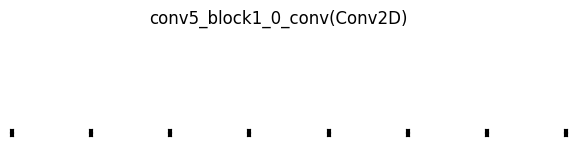

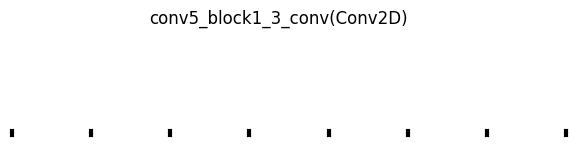

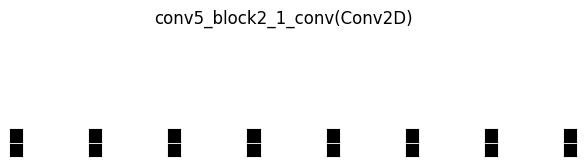

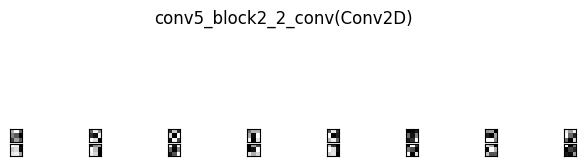

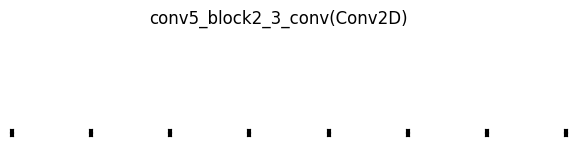

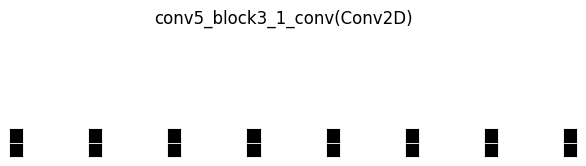

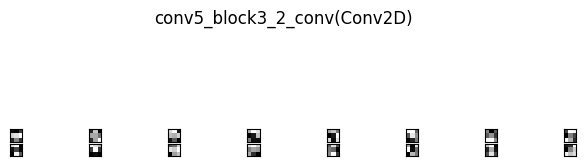

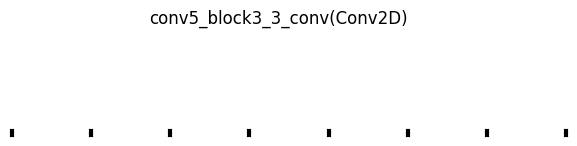

In [33]:
layer_names = get_layer_names(141, 172, before_model)
filters = get_filters(141, 172, layer_names, before_model)
plot_filters1(layer_names, filters)

2. After fine-tuning

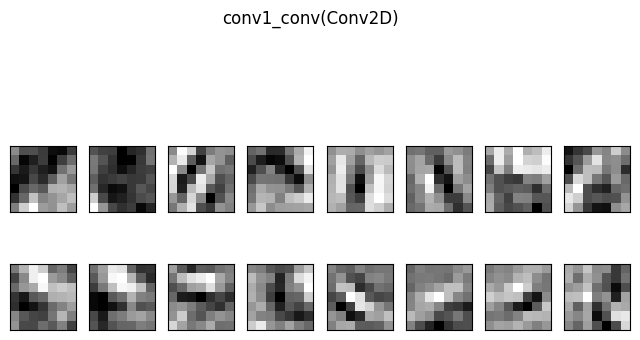

In [41]:
layer_names = get_layer_names(0, 6, ft_model)
filters = get_filters(0, 6, layer_names, ft_model)
plot_filters1(layer_names, filters)

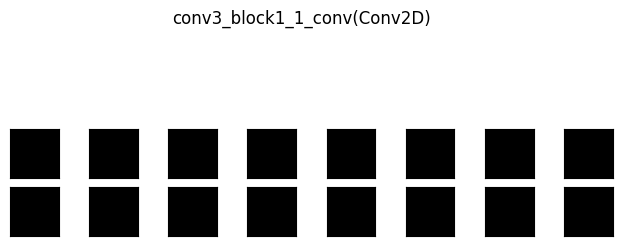

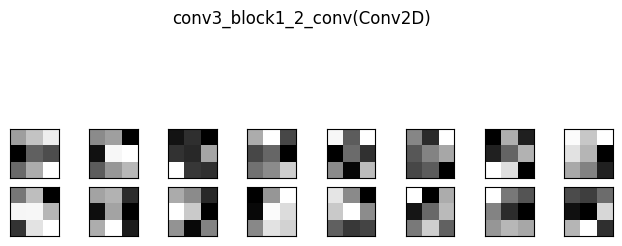

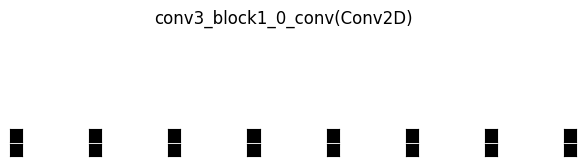

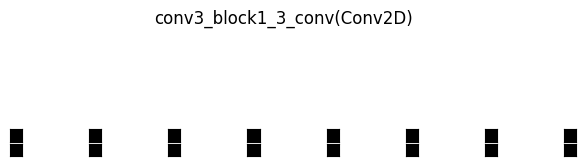

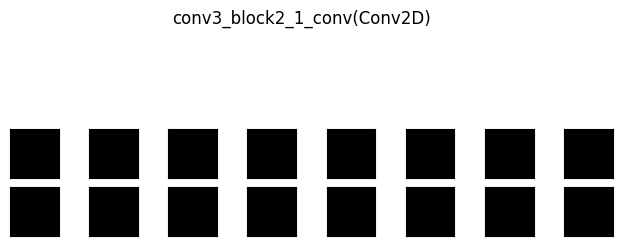

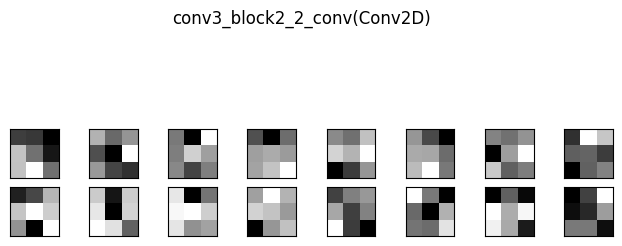

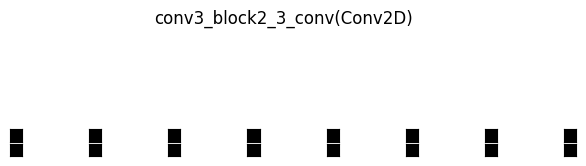

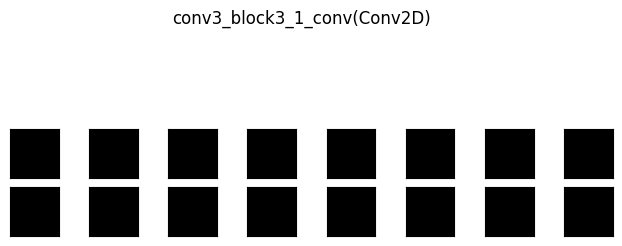

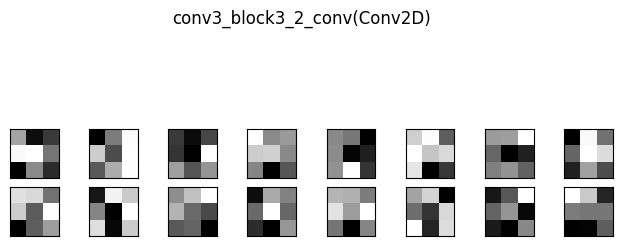

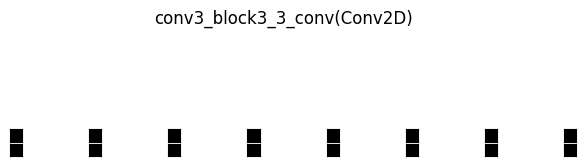

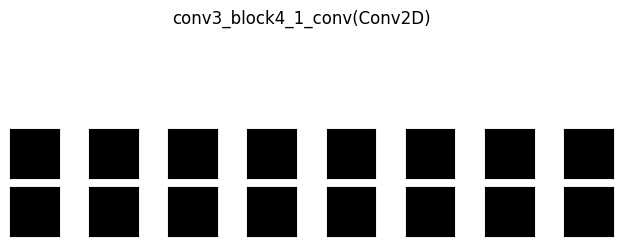

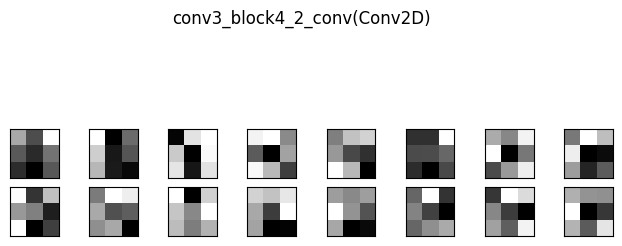

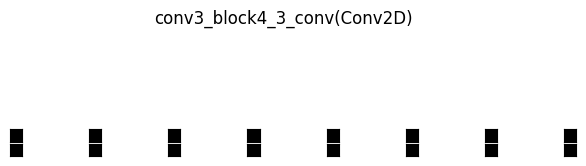

In [42]:
layer_names = get_layer_names(38, 78, ft_model)
filters = get_filters(38, 78, layer_names, ft_model)
plot_filters1(layer_names, filters)

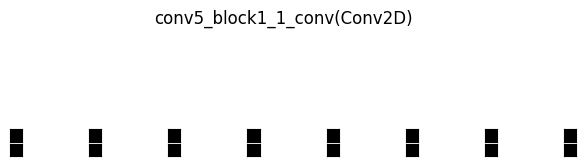

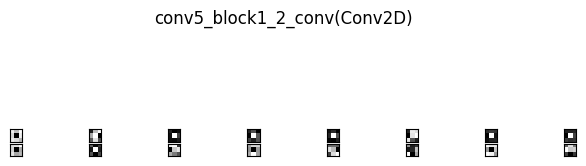

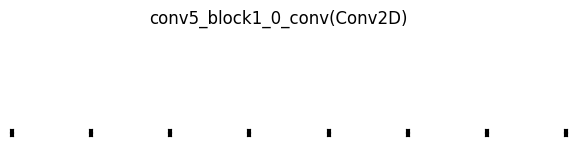

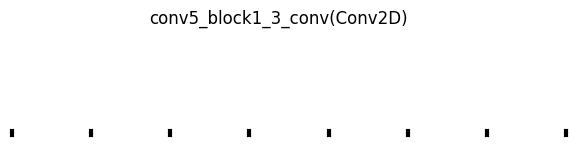

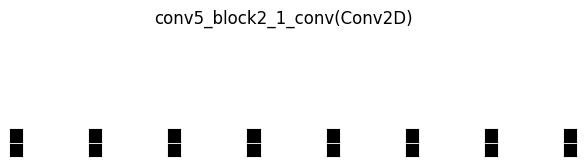

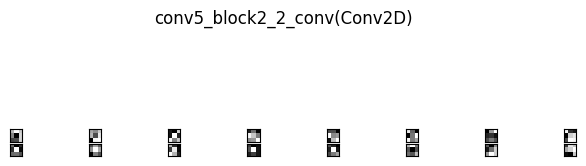

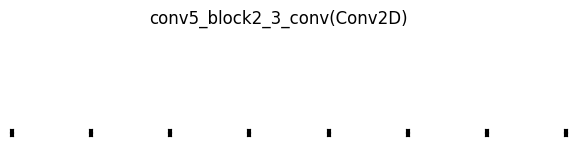

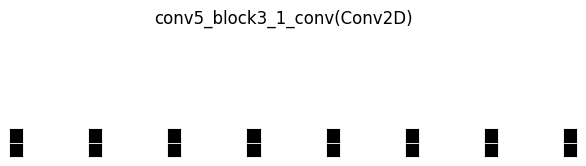

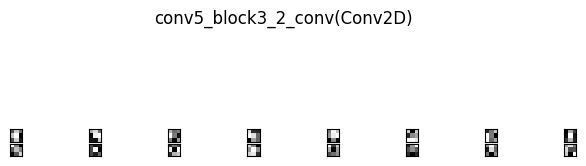

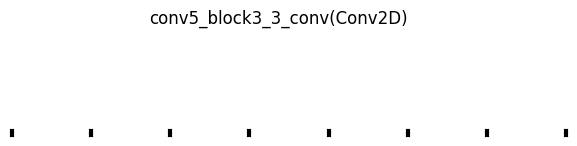

In [43]:
layer_names = get_layer_names(141, 172, ft_model)
filters = get_filters(141, 172, layer_names, ft_model)
plot_filters1(layer_names, filters)

3. After feature extraction

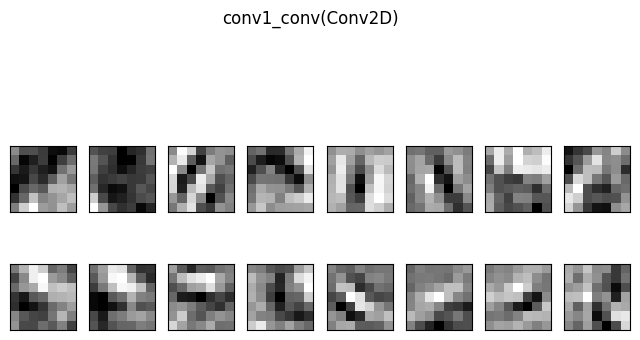

In [44]:
layer_names = get_layer_names(0, 6, fe_model)
filters = get_filters(0, 6, layer_names, fe_model)
plot_filters1(layer_names, filters)

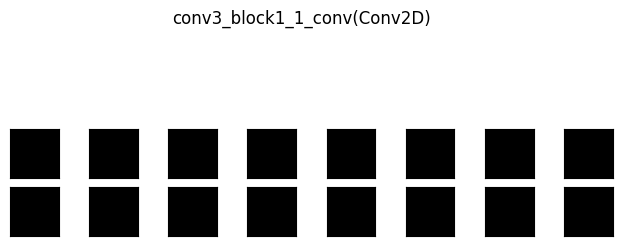

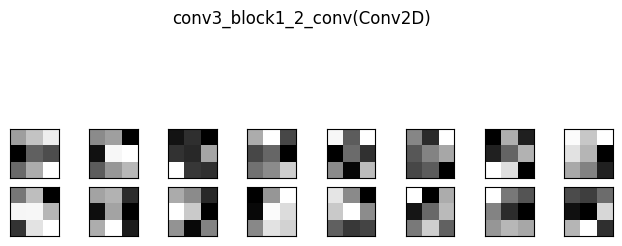

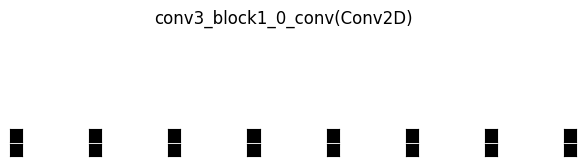

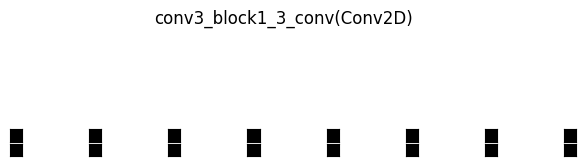

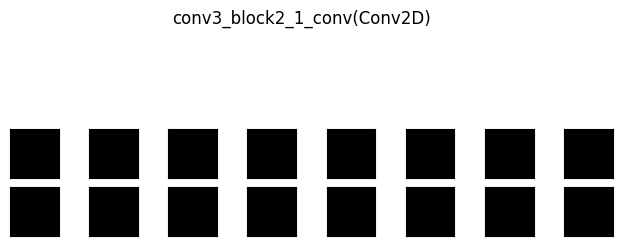

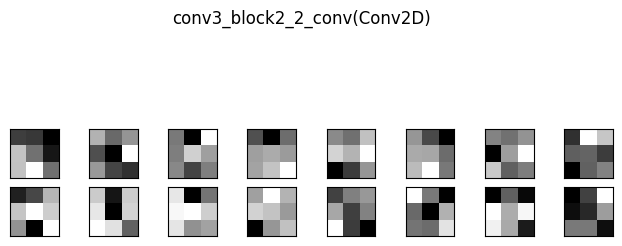

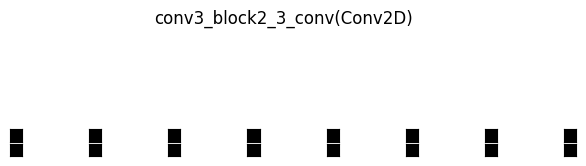

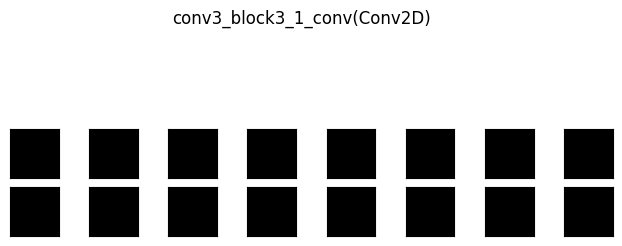

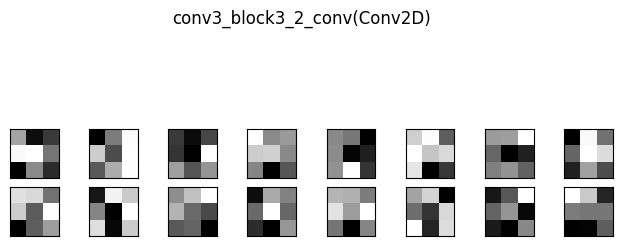

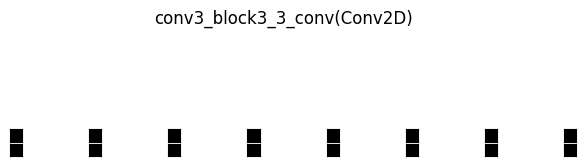

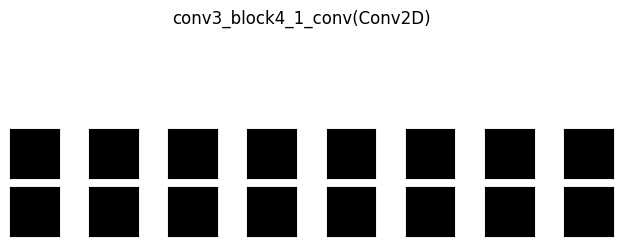

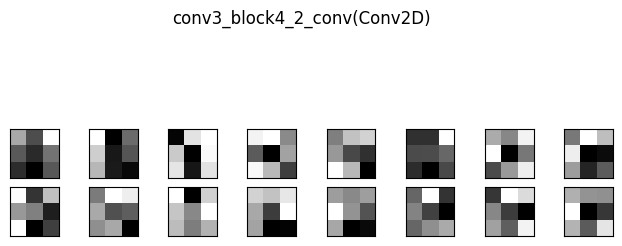

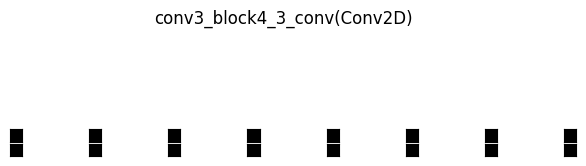

In [45]:
layer_names = get_layer_names(38, 78, fe_model)
filters = get_filters(38, 78, layer_names, fe_model)
plot_filters1(layer_names, filters)

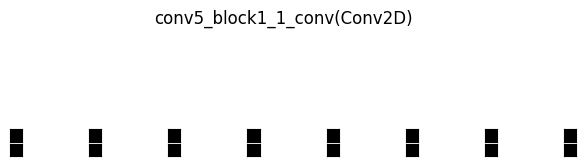

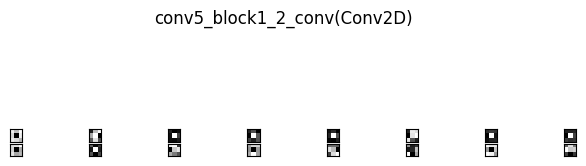

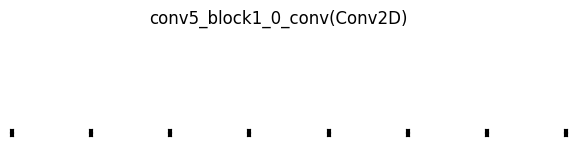

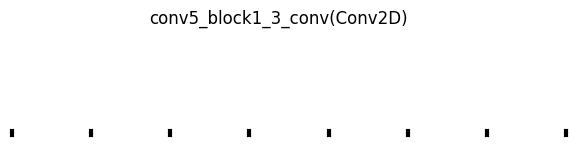

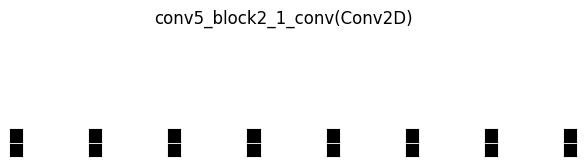

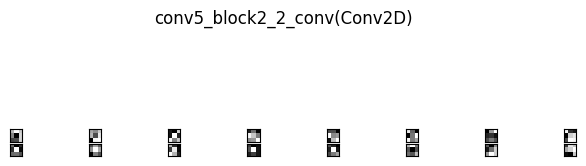

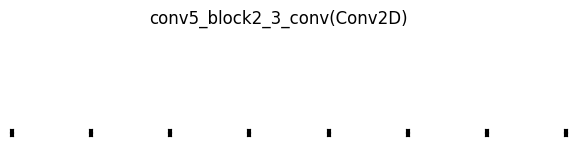

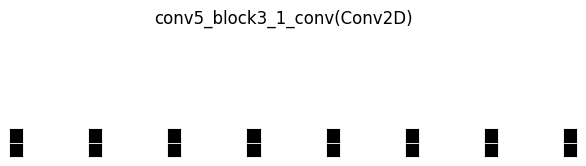

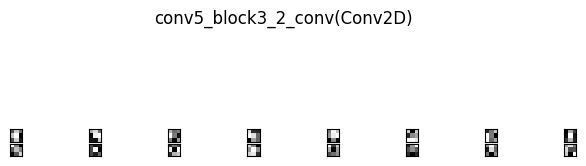

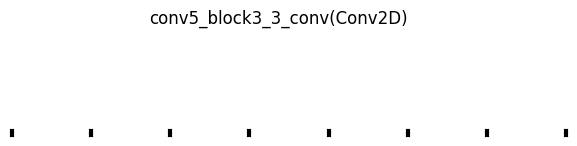

In [46]:
layer_names = get_layer_names(141, 172, fe_model)
filters = get_filters(141, 172, layer_names, fe_model)
plot_filters1(layer_names, filters)